In [1]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
# import nltk
# nltk.set_proxy('http://127.0.0.1:7890')
# nltk.download('punkt') # [nltk_data] Downloading package punkt to /home/tyd/nltk_data...
from nltk.tokenize import word_tokenize

class Defects4JDataset(Dataset):
    def __init__(self, defects4j_dir, model_name, test_size=0.2, random_state=None):
        self.project_ids = ['Chart', 'Cli', 'Closure', 'Codec', 'Collections', 'Compress', 'Csv', 'Gson', 'JacksonCore',
               'JacksonDatabind', 'JacksonXml', 'Jsoup', 'JxPath', 'Lang', 'Math', 'Mockito', 'Time']
        self.defects4j_dir = defects4j_dir
        self.model_name = model_name
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # What a fucking rich programmer dare do this! 
        # Please load the dataset onto the CPU
        # RTX 3080Ti OutOfMemoryError: CUDA out of memory.
        self.model = AutoModel.from_pretrained(model_name)#.to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.test_size = test_size
        self.random_state = random_state
        self.df = pd.DataFrame()
        self.train_df, self.test_df = self.load_data()
        self.train_tokens = self.to_tokens(self.train_df)
        self.test_tokens = self.to_tokens(self.test_df)
        self.train_encodings = self.encoding(self.train_tokens)
        self.test_encodings = self.encoding(self.test_tokens)
        self.train_dataset = self.create_dataset(self.train_encodings, self.train_df)
        self.test_dataset = self.create_dataset(self.test_encodings, self.test_df)

        
    def load_data(self):
        csv_folder = f'{self.defects4j_dir}/csv/'
        for pid in self.project_ids:
            df_t = pd.read_csv(f'{csv_folder}/{pid}/{pid}-modified_classes.csv')
            modified_classes = df_t['Modified Classes'].tolist()
            tokens = [x.split('.')[-1] for x in modified_classes]
            df_dw = pd.read_csv(f'{csv_folder}/{pid}/{pid}-detailed-warnings.csv')
            df_dw['nl_input'] = df_dw['Warning'] + " " + df_dw['Warning Detail']
            df_dw['Label'] = df_dw['Warning'].str.contains('|'.join(tokens)).astype(int)
            self.df = pd.concat([self.df, df_dw], ignore_index=True)
        df_unique = self.df.drop_duplicates(subset=['nl_input', 'Source Code', 'Label'])
        df_unique = df_unique.rename(columns={'Source Code': 'pl_input', 'Label': 'label'})
        train_df, test_df = train_test_split(df_unique, test_size=self.test_size, random_state=self.random_state)
        return train_df, test_df
    
    def to_tokens(self, df):
        nl_tokens = [word_tokenize(x) for x in list(df['nl_input'])]
        df['pl_input'].fillna('[UNK]', inplace=True)
        pl_tokens = [self.tokenizer.tokenize(x, padding=True, truncation=True) for x in list(df['pl_input'])]
        tokens = [[self.tokenizer.cls_token] + nl_tokens[i] + [self.tokenizer.sep_token] + pl_tokens[i] + [self.tokenizer.eos_token] for i in range(len(nl_tokens))]
        return tokens
    
    def encoding(self, tokens):
        tokens_ids = [self.tokenizer.convert_tokens_to_ids(token) for token in tokens]
        context_embeddings = []
        max_seq_length = 150
        tokens_ids = [token[:max_seq_length] + [self.tokenizer.pad_token_id] * (max_seq_length - len(token[:max_seq_length])) for token in tokens_ids] 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.model.to(device)
        with torch.no_grad():
            for tokens_id in tokens_ids:
                tokens_tensor = torch.tensor(tokens_id)[None,:].to(model.device)
                context_embedding = self.model(tokens_tensor)[0].to('cpu')
                context_embeddings.append(context_embedding)
                torch.cuda.empty_cache()
        attention_mask = [[int(token_id != self.tokenizer.pad_token_id) for token_id in tokens] for tokens in tokens_ids]
        return {'input_ids': tokens_ids, 'attention_mask': attention_mask, 'context_embeddings': context_embeddings}
    
    def create_dataset(self, encodings, df):
        class CustomDataset(Dataset):
            def __init__(self, encodings, labels):
                self.encodings = encodings
                self.labels = labels

            def __getitem__(self, idx):
                item = {key: val[idx].detach().clone() if isinstance(val[idx], torch.Tensor) else torch.tensor(val[idx]) for key, val in self.encodings.items()}
                item['label'] = torch.tensor(self.labels[idx])
                return item

            def __len__(self):
                return len(self.labels)

        dataset = CustomDataset(encodings, df['label'].tolist())
        return dataset   
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        nl_input = row['nl_input']
        code_line = row['Source Code']
        label = row['Label']
        sample = {'warning': nl_input, 'code': code_line, 'label': label }
        return sample

model_name = "microsoft/codebert-base"
defects4j_dir = os.path.expanduser('~/defects4j')
dataset = Defects4JDataset(defects4j_dir, model_name)
print(len(dataset), dataset[123])

152518 {'warning': 'org.jfree.chart.title.CompositeTitle defines equals but not hashCode Bug type HE_EQUALS_NO_HASHCODE (click for details)\nIn class org.jfree.chart.title.CompositeTitleIn method org.jfree.chart.title.CompositeTitle.equals(Object)At CompositeTitle.java:[lines 207-220]', 'code': 'if (obj == this) {\nreturn true;\n}\nif (!(obj instanceof CompositeTitle)) {\nreturn false;\n}\nCompositeTitle that = (CompositeTitle) obj;\nif (!this.container.equals(that.container)) {\nreturn false;\n}\nif (!PaintUtilities.equal(this.backgroundPaint, that.backgroundPaint)) {\nreturn false;\n}', 'label': 0}


In [2]:
import time

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [3]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] 

In [4]:
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

In [5]:
def collate_fn(batch):
    context_embeddings = torch.stack([b['context_embeddings'] for b in batch])
    labels = torch.tensor([b['label'] for b in batch])
    return {context_embeddings.squeeze(1), labels}

train_loader = DataLoader(dataset.train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset.test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
for i, (inputs, labels) in enumerate(train_loader):
    print(inputs.shape) # torch.Size([32, 256, 768])
    print(labels.shape)  # torch.Size([32])
    break
print('小批量数目：', len(train_loader))

torch.Size([32, 150, 768])
torch.Size([32])
小批量数目： 384


In [6]:
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [50]:
from IPython import display

def try_all_gpus():
    """ Return all available GPUs, or [cpu(),] if no GPU exists. """
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

def train_batch(net, X, y, loss, trainer, devices):
    """ Train for a minibatch with mutiple GPUs. """
    if isinstance(X, list):
        # Required for BERT fine-tuning
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, test_iter, loss, trainer, num_epochs, devices=try_all_gpus()):
    """ Train a model with mutiple GPUs. """
    lis = []
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        lis.append(f'{test_acc:.4f}')
    print(f'loss {metric[0] / metric[2]:.4f}, train acc {metric[1] / metric[3]:.4f}, test acc {test_acc:.4f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')
    print(lis)

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(net, test_iter, devices=try_all_gpus()):
    net.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = net(X)
            y_hat = torch.argmax(y_hat, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(y_hat.cpu().numpy())

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(precision, recall, f1))

In [9]:
from torch import nn
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.num_directions = 2
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                          batch_first=True, bidirectional=True)
        self.fc = nn.Linear(self.num_directions * hidden_size, 2)
        
    def forward(self, x):
        output, hidden = self.gru(x)
        output = self.fc(output[:, -1, :])
        return output

loss 0.0954, train acc 0.9599, test acc 0.9326
5264.5 examples/sec on [device(type='cuda', index=0)]
['0.7454', '0.8027', '0.8369', '0.8607', '0.8568', '0.8864', '0.9049', '0.8971', '0.9079', '0.9167', '0.9111', '0.9215', '0.9268', '0.9258', '0.9271', '0.9248', '0.9085', '0.9242', '0.9300', '0.9326']
Precision: 0.9679, Recall: 0.9232, F1-Score: 0.9450


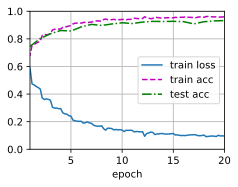

In [54]:
net = BiRNN(input_size=768, hidden_size=128, num_layers=2)
devices = try_all_gpus()
lr, num_epochs = 0.001, 20
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_loader, test_loader, loss, trainer, num_epochs, devices)
evaluate(net, test_loader)

[1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 

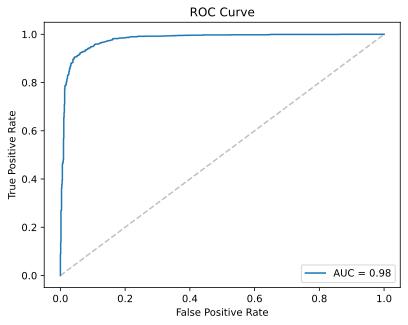

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
y_true, y_scores = [], []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    probs = torch.softmax(outputs, dim=1)
    y_true.extend(labels.cpu().tolist())
    y_scores.extend(probs[:, 1].cpu().tolist())
print(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
print(auc)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], "--", color="gray", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

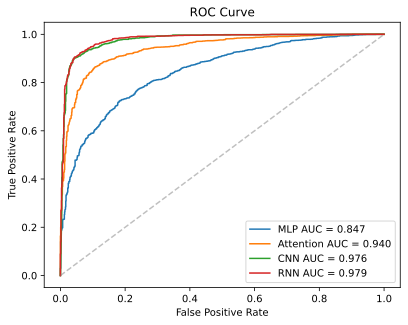

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

mlp_true = [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1] 
mlp_scores = [0.6840002536773682, 0.49284878373146057, 0.8335075378417969, 0.606503963470459, 0.33686646819114685, 0.2581369876861572, 0.5753867030143738, 0.4842211604118347, 0.44658637046813965, 0.5876297354698181, 0.346218466758728, 0.9643293023109436, 0.6083511114120483, 0.9950152039527893, 0.45135125517845154, 0.1956598162651062, 0.3126370906829834, 0.16430535912513733, 0.924819827079773, 0.5368043780326843, 0.5737630724906921, 0.21743135154247284, 0.8930158019065857, 0.09977050870656967, 0.8209497332572937, 0.9988803267478943, 0.18072058260440826, 0.2233322411775589, 0.17075484991073608, 0.22390057146549225, 0.16779740154743195, 0.865729570388794, 0.9063381552696228, 0.9064338803291321, 0.9213255047798157, 0.5893499255180359, 0.3956742286682129, 0.6663571000099182, 0.08722200989723206, 0.8797934651374817, 0.13773439824581146, 0.53104168176651, 0.9502646923065186, 0.2716904580593109, 0.9588638544082642, 0.8403103351593018, 0.771483302116394, 0.6631474494934082, 0.27551984786987305, 0.7893111705780029, 0.3116077482700348, 0.45860397815704346, 0.42724791169166565, 0.2523864507675171, 0.4738100469112396, 0.41303297877311707, 0.968679666519165, 0.8152753710746765, 0.36287516355514526, 0.5227644443511963, 0.6901395916938782, 0.8079961538314819, 0.9646334648132324, 0.4122098982334137, 0.7138738632202148, 0.6399039030075073, 0.834615170955658, 0.15172263979911804, 0.73946613073349, 0.5647155046463013, 0.364519864320755, 0.13142803311347961, 0.37272781133651733, 0.3902319371700287, 0.800152599811554, 0.3415951132774353, 0.9675477743148804, 0.9728381037712097, 0.843313992023468, 0.7749471664428711, 0.8716334104537964, 0.312836617231369, 0.3867356479167938, 0.9959110021591187, 0.7607774138450623, 0.1273351013660431, 0.48555633425712585, 0.4316311180591583, 0.6439697742462158, 0.6638766527175903, 0.9963262677192688, 0.25109052658081055, 0.8212652206420898, 0.15040212869644165, 0.42850127816200256, 0.07136663794517517, 0.9728381037712097, 0.07593879848718643, 0.7891718745231628, 0.9922385811805725, 0.7037241458892822, 0.7311066389083862, 0.6786326169967651, 0.9932356476783752, 0.9141218066215515, 0.07873944938182831, 0.17359907925128937, 0.9953179359436035, 0.9568267464637756, 0.6320314407348633, 0.9489849209785461, 0.8393423557281494, 0.503158688545227, 0.5130784511566162, 0.2690174877643585, 0.44166550040245056, 0.7368898391723633, 0.11137817054986954, 0.823723316192627, 0.9507980942726135, 0.8016202449798584, 0.6238177418708801, 0.8524839282035828, 0.9941970109939575, 0.4316311180591583, 0.2594638466835022, 0.1030433252453804, 0.2134983241558075, 0.8468245267868042, 0.35503169894218445, 0.13941559195518494, 0.3575950860977173, 0.7459914088249207, 0.23706360161304474, 0.763576865196228, 0.14810101687908173, 0.96101975440979, 0.18683189153671265, 0.634975790977478, 0.09940052777528763, 0.7186135053634644, 0.6531748175621033, 0.6485852599143982, 0.30395960807800293, 0.7441948652267456, 0.9662882089614868, 0.34653887152671814, 0.9873687624931335, 0.9058341979980469, 0.8954305052757263, 0.12393304705619812, 0.42172908782958984, 0.8967235088348389, 0.4168757498264313, 0.9728381037712097, 0.3778531849384308, 0.5305148363113403, 0.5006766319274902, 0.0356706939637661, 0.4356829822063446, 0.32107797265052795, 0.3351484537124634, 0.8737924695014954, 0.36194461584091187, 0.7324373126029968, 0.5246657729148865, 0.7101022005081177, 0.5028484463691711, 0.942733108997345, 0.7163987159729004, 0.998304009437561, 0.9112403392791748, 0.10062611103057861, 0.2288752794265747, 0.9335955381393433, 0.8819988369941711, 0.8984168767929077, 0.14844699203968048, 0.5639051795005798, 0.5554453134536743, 0.8011067509651184, 0.6799514889717102, 0.08516678214073181, 0.7414273023605347, 0.9948683977127075, 0.6172606348991394, 0.9862275719642639, 0.49149253964424133, 0.8393423557281494, 0.7450416088104248, 0.09603950381278992, 0.3748515248298645, 0.9930267333984375, 0.9202746152877808, 0.442230224609375, 0.1653282195329666, 0.6407672762870789, 0.5248405337333679, 0.9984532594680786, 0.33951282501220703, 0.15830324590206146, 0.9899784326553345, 0.07593879848718643, 0.9988634586334229, 0.5182440280914307, 0.5958007574081421, 0.9996895790100098, 0.38382038474082947, 0.6113865971565247, 0.6170101165771484, 0.42028096318244934, 0.1359500139951706, 0.11843153834342957, 0.8408989906311035, 0.23794034123420715, 0.9910967350006104, 0.9986953139305115, 0.5322752594947815, 0.13045039772987366, 0.38689953088760376, 0.977287769317627, 0.5389160513877869, 0.7541726231575012, 0.8592594265937805, 0.44713538885116577, 0.5551421642303467, 0.5736403465270996, 0.28016990423202515, 0.48684045672416687, 0.8714863061904907, 0.7285448312759399, 0.37272781133651733, 0.1618461012840271, 0.12441227585077286, 0.6886103749275208, 0.5424309372901917, 0.9486448168754578, 0.9846958518028259, 0.07873944938182831, 0.5087460279464722, 0.16951778531074524, 0.241205632686615, 0.8587511777877808, 0.2757047712802887, 0.9084212779998779, 0.7232987284660339, 0.3926375210285187, 0.0796707272529602, 0.20522348582744598, 0.7729442715644836, 0.5371994376182556, 0.2337908297777176, 0.01985592395067215, 0.16704203188419342, 0.5842790603637695, 0.8213211297988892, 0.9457337260246277, 0.4181540906429291, 0.3267679512500763, 0.2903275787830353, 0.4034414291381836, 0.9991768002510071, 0.1692192554473877, 0.27882981300354004, 0.9706630706787109, 0.4026654064655304, 0.6150157451629639, 0.2881667912006378, 0.16901864111423492, 0.5470578670501709, 0.9941970109939575, 0.16564589738845825, 0.8954305052757263, 0.15655581653118134, 0.8596326112747192, 0.15637435019016266, 0.9631466865539551, 0.5678297281265259, 0.621937096118927, 0.40372446179389954, 0.6154721975326538, 0.7677512168884277, 0.9728381037712097, 0.7749471664428711, 0.32693347334861755, 0.07509975135326385, 0.44693130254745483, 0.8393423557281494, 0.43171191215515137, 0.09268737584352493, 0.8714863061904907, 0.12298345565795898, 0.6580515503883362, 0.9413033127784729, 0.39849764108657837, 0.6575592756271362, 0.8101558685302734, 0.09624193608760834, 0.040875278413295746, 0.8690174221992493, 0.9668468832969666, 0.6971603631973267, 0.8657413721084595, 0.5577599406242371, 0.9908508658409119, 0.20470629632472992, 0.6623640060424805, 0.5492013692855835, 0.558870792388916, 0.5762428641319275, 0.5958007574081421, 0.44559481739997864, 0.8972866535186768, 0.9357598423957825, 0.34116411209106445, 0.6728065013885498, 0.9019391536712646, 0.5236520171165466, 0.7362427711486816, 0.9000001549720764, 0.9654256105422974, 0.15954414010047913, 0.06880953162908554, 0.4163302481174469, 0.5071227550506592, 0.18088744580745697, 0.8408989906311035, 0.7445281147956848, 0.27980273962020874, 0.6869388222694397, 0.6706259846687317, 0.8408302664756775, 0.21792326867580414, 0.31693530082702637, 0.962785005569458, 0.3290843367576599, 0.5121327638626099, 0.5889344215393066, 0.6407672762870789, 0.783499002456665, 0.37856873869895935, 0.6913482546806335, 0.10357553511857986, 0.08507684618234634, 0.7934021949768066, 0.4310636818408966, 0.9862275719642639, 0.89913010597229, 0.9674216508865356, 0.27693817019462585, 0.9282674193382263, 0.21803373098373413, 0.9764270782470703, 0.1185850128531456, 0.9986147880554199, 0.31538861989974976, 0.6518871188163757, 0.1956598162651062, 0.17211568355560303, 0.45245566964149475, 0.2559168338775635, 0.825093150138855, 0.2003914713859558, 0.13889960944652557, 0.2235904484987259, 0.9204779267311096, 0.6625862121582031, 0.3931249678134918, 0.9246410727500916, 0.7618211507797241, 0.44600027799606323, 0.8026065826416016, 0.6381150484085083, 0.5470879673957825, 0.14121077954769135, 0.5546680688858032, 0.08516678214073181, 0.9909371733665466, 0.180552676320076, 0.41908058524131775, 0.4995321035385132, 0.32361677289009094, 0.44204825162887573, 0.9960936903953552, 0.7794405221939087, 0.1995047926902771, 0.8741172552108765, 0.2970040738582611, 0.3123408555984497, 0.8956775665283203, 0.23433275520801544, 0.9254453778266907, 0.44709473848342896, 0.0609811395406723, 0.8418583273887634, 0.8466027975082397, 0.49453210830688477, 0.8110170960426331, 0.9926044940948486, 0.9721361994743347, 0.8860441446304321, 0.43737924098968506, 0.9790922403335571, 0.8468245267868042, 0.9149844646453857, 0.5153254866600037, 0.12393304705619812, 0.9670330882072449, 0.10819624364376068, 0.686206042766571, 0.2939336597919464, 0.3129764497280121, 0.06057221442461014, 0.9304375052452087, 0.7711647152900696, 0.7973332405090332, 0.71869957447052, 0.8797934651374817, 0.9996811151504517, 0.4748899042606354, 0.4921395778656006, 0.019636018201708794, 0.06097021326422691, 0.5608727335929871, 0.1926450878381729, 0.9502406716346741, 0.3455747067928314, 0.37035107612609863, 0.4315080940723419, 0.17899109423160553, 0.962440013885498, 0.36021608114242554, 0.29946666955947876, 0.8714863061904907, 0.2504033148288727, 0.9862275719642639, 0.43590718507766724, 0.8256294131278992, 0.9991936087608337, 0.4274630546569824, 0.6171771287918091, 0.4748899042606354, 0.3655698001384735, 0.2666947543621063, 0.6762163043022156, 0.6991099715232849, 0.2610924541950226, 0.9693009853363037, 0.9970990419387817, 0.13781242072582245, 0.5605769753456116, 0.9698823094367981, 0.07555292546749115, 0.9755263924598694, 0.9704915881156921, 0.31834572553634644, 0.5119295716285706, 0.5051419734954834, 0.314083456993103, 0.9507980942726135, 0.6273751258850098, 0.14413341879844666, 0.5675714015960693, 0.6149638891220093, 0.8525242209434509, 0.16938269138336182, 0.18567682802677155, 0.3719242513179779, 0.2235904484987259, 0.9991768002510071, 0.1956598162651062, 0.7727896571159363, 0.6613200902938843, 0.3565371334552765, 0.924611508846283, 0.7769339680671692, 0.998304009437561, 0.24617859721183777, 0.4810643196105957, 0.42082419991493225, 0.2725951373577118, 0.19132544100284576, 0.8979781866073608, 0.7890894412994385, 0.9821400046348572, 0.7037241458892822, 0.2587541937828064, 0.11860440671443939, 0.6116985082626343, 0.39721471071243286, 0.27020925283432007, 0.4402575194835663, 0.47647377848625183, 0.9091397523880005, 0.058735813945531845, 0.5473534464836121, 0.8773999810218811, 0.758560299873352, 0.7558671832084656, 0.5454447865486145, 0.6566727161407471, 0.3665737807750702, 0.8335830569267273, 0.3645962178707123, 0.9023173451423645, 0.7527502775192261, 0.5023503303527832, 0.5711691379547119, 0.1823858767747879, 0.9502646923065186, 0.5402278304100037, 0.9148390293121338, 0.24494676291942596, 0.3337520658969879, 0.19100125133991241, 0.9930267333984375, 0.036087557673454285, 0.8607162833213806, 0.23800799250602722, 0.7297289371490479, 0.574930727481842, 0.6807846426963806, 0.4135677218437195, 0.987153947353363, 0.9736413955688477, 0.19944271445274353, 0.9829066395759583, 0.5262472629547119, 0.9632379412651062, 0.8145383596420288, 0.9886264204978943, 0.9976198077201843, 0.1956598162651062, 0.9952919483184814, 0.5420675873756409, 0.44598615169525146, 0.5667765140533447, 0.188333660364151, 0.6003255844116211, 0.10862022638320923, 0.17586646974086761, 0.9754623174667358, 0.997391939163208, 0.9878646731376648, 0.1123121827840805, 0.5308341383934021, 0.86667400598526, 0.7528149485588074, 0.15091350674629211, 0.03256514295935631, 0.21362879872322083, 0.9375253915786743, 0.08221498876810074, 0.7532970905303955, 0.8692429065704346, 0.08353014290332794, 0.9976198077201843, 0.1952161341905594, 0.370649516582489, 0.14136694371700287, 0.6594151258468628, 0.7260551452636719, 0.09035079926252365, 0.5958007574081421, 0.7622888684272766, 0.834615170955658, 0.661285936832428, 0.6107521057128906, 0.2728491425514221, 0.19082799553871155, 0.9137194752693176, 0.5830386877059937, 0.6286047101020813, 0.48786813020706177, 0.31538861989974976, 0.24834896624088287, 0.09908066689968109, 0.3379509747028351, 0.6688827276229858, 0.20439238846302032, 0.9693009853363037, 0.9000001549720764, 0.9865070581436157, 0.25804710388183594, 0.22208820283412933, 0.21085897088050842, 0.12575650215148926, 0.7775333523750305, 0.38716110587120056, 0.17715606093406677, 0.7280417680740356, 0.32372215390205383, 0.5708461999893188, 0.36795204877853394, 0.33194494247436523, 0.5744791626930237, 0.34370505809783936, 0.26730382442474365, 0.12444331496953964, 0.7137495875358582, 0.9670330882072449, 0.5867667198181152, 0.9373011589050293, 0.8750661611557007, 0.18596328794956207, 0.5259686708450317, 0.6334856748580933, 0.578690230846405, 0.8916130065917969, 0.9037485122680664, 0.4726497232913971, 0.1454547494649887, 0.28302204608917236, 0.10331651568412781, 0.9632997512817383, 0.2622317373752594, 0.7759639024734497, 0.8152753710746765, 0.6547374129295349, 0.843313992023468, 0.09601742029190063, 0.3764469027519226, 0.3964070975780487, 0.1956598162651062, 0.9976902008056641, 0.09191764891147614, 0.3192433714866638, 0.44249778985977173, 0.7505897879600525, 0.22511814534664154, 0.45882678031921387, 0.8084787130355835, 0.8632766008377075, 0.9538228511810303, 0.8943675756454468, 0.9966703057289124, 0.46081411838531494, 0.7670519948005676, 0.8692429065704346, 0.9858989715576172, 0.783499002456665, 0.44456467032432556, 0.5731565356254578, 0.3917124271392822, 0.7445281147956848, 0.924611508846283, 0.9000001549720764, 0.8714863061904907, 0.37984174489974976, 0.76373690366745, 0.33622679114341736, 0.8598525524139404, 0.8930158019065857, 0.13306020200252533, 0.6356197595596313, 0.9141218066215515, 0.612183690071106, 0.757832944393158, 0.7815593481063843, 0.4549941122531891, 0.4905286729335785, 0.8891843557357788, 0.8734477758407593, 0.9137194752693176, 0.14876410365104675, 0.4304388761520386, 0.673468291759491, 0.05081906542181969, 0.6022837162017822, 0.7172179818153381, 0.8860441446304321, 0.9948047995567322, 0.4203127920627594, 0.32549533247947693, 0.5685793161392212, 0.400971382856369, 0.8353614807128906, 0.6617757081985474, 0.7432567477226257, 0.512624204158783, 0.23412249982357025, 0.33571016788482666, 0.31574374437332153, 0.46421200037002563, 0.8860441446304321, 0.7205895185470581, 0.14324358105659485, 0.5519485473632812, 0.7730011343955994, 0.6381164193153381, 0.6875461339950562, 0.3453337848186493, 0.8199607133865356, 0.9975167512893677, 0.6514199376106262, 0.7256843447685242, 0.27119573950767517, 0.5524719953536987, 0.5012245178222656, 0.21002601087093353, 0.9502406716346741, 0.25075429677963257, 0.049948014318943024, 0.4476499855518341, 0.11657003313302994, 0.9880189299583435, 0.6607860922813416, 0.22032497823238373, 0.7611939311027527, 0.8838796019554138, 0.07965531200170517, 0.42166268825531006, 0.4105687737464905, 0.489430695772171, 0.22970792651176453, 0.25782668590545654, 0.3833647072315216, 0.36604246497154236, 0.9976020455360413, 0.24197633564472198, 0.2592000365257263, 0.25539377331733704, 0.1654483824968338, 0.979941189289093, 0.43596363067626953, 0.7121769189834595, 0.62936931848526, 0.7123549580574036, 0.09145314246416092, 0.1426418572664261, 0.24795587360858917, 0.6657447814941406, 0.972367525100708, 0.3370262086391449, 0.13041023910045624, 0.8501889109611511, 0.20993828773498535, 0.21656352281570435, 0.19224904477596283, 0.5965458750724792, 0.2936843931674957, 0.5881475806236267, 0.6498335599899292, 0.18012063205242157, 0.4633140563964844, 0.24834896624088287, 0.629320502281189, 0.8714863061904907, 0.6807846426963806, 0.3543583154678345, 0.5486266613006592, 0.775225043296814, 0.6223921775817871, 0.2594488561153412, 0.11362912505865097, 0.0789370983839035, 0.16254402697086334, 0.38215404748916626, 0.3497287929058075, 0.9035323262214661, 0.9063381552696228, 0.9949475526809692, 0.1863839030265808, 0.686206042766571, 0.4796374440193176, 0.8128889799118042, 0.34191909432411194, 0.821541965007782, 0.6612342596054077, 0.15842083096504211, 0.06589525192975998, 0.33544179797172546, 0.04747738689184189, 0.40901315212249756, 0.6047629714012146, 0.38740161061286926, 0.8984168767929077, 0.9141218066215515, 0.5414703488349915, 0.6898559331893921, 0.9996811151504517, 0.7598364353179932, 0.9292766451835632, 0.6594485640525818, 0.29622116684913635, 0.07296718657016754, 0.3622753322124481, 0.7311066389083862, 0.6162974834442139, 0.6044794321060181, 0.418093740940094, 0.5075765252113342, 0.7625971436500549, 0.995254635810852, 0.37272781133651733, 0.09754426032304764, 0.1750413030385971, 0.681592583656311, 0.9992914199829102, 0.1759166121482849, 0.5457953214645386, 0.3943275809288025, 0.654334545135498, 0.5589885115623474, 0.37272781133651733, 0.9934878349304199, 0.8095159530639648, 0.9133053421974182, 0.9321299195289612, 0.5016096234321594, 0.8508421778678894, 0.843313992023468, 0.540678858757019, 0.49636784195899963, 0.32392436265945435, 0.9373011589050293, 0.4770722985267639, 0.5881054401397705, 0.8152148127555847, 0.3951352536678314, 0.7025212645530701, 0.6331412196159363, 0.30317261815071106, 0.33305874466896057, 0.5748015642166138, 0.556294322013855, 0.936467170715332, 0.4397600293159485, 0.15958890318870544, 0.485041081905365, 0.6971293091773987, 0.7876831293106079, 0.9507980942726135, 0.441704660654068, 0.33604294061660767, 0.6890143156051636, 0.9058341979980469, 0.8741172552108765, 0.9373011589050293, 0.49817946553230286, 0.6434199213981628, 0.9664023518562317, 0.7928621768951416, 0.572656512260437, 0.843313992023468, 0.24806800484657288, 0.8101814389228821, 0.8797934651374817, 0.34916138648986816, 0.15940144658088684, 0.6573972702026367, 0.9792898893356323, 0.995254635810852, 0.843313992023468, 0.86057049036026, 0.8376118540763855, 0.4642135500907898, 0.2640846073627472, 0.17112356424331665, 0.15046373009681702, 0.6621825695037842, 0.8903406262397766, 0.9504520297050476, 0.10364027321338654, 0.686840832233429, 0.11684198677539825, 0.12206507474184036, 0.9988803267478943, 0.9373011589050293, 0.5601085424423218, 0.8231086134910583, 0.7710617184638977, 0.9686192870140076, 0.5670375227928162, 0.3712958097457886, 0.3024735748767853, 0.4573773443698883, 0.6326987147331238, 0.14139088988304138, 0.20173729956150055, 0.9433068633079529, 0.7764007449150085, 0.811427116394043, 0.23115584254264832, 0.16952195763587952, 0.24113158881664276, 0.5606689453125, 0.1921267807483673, 0.8400099277496338, 0.783499002456665, 0.11546182632446289, 0.9586817026138306, 0.2605420649051666, 0.9554721713066101, 0.31871849298477173, 0.06246188282966614, 0.28953495621681213, 0.9204779267311096, 0.23840758204460144, 0.627864420413971, 0.4388826787471771, 0.42394983768463135, 0.1956598162651062, 0.32532909512519836, 0.2300160825252533, 0.737415075302124, 0.6279652118682861, 0.9159201979637146, 0.6629165410995483, 0.3856397569179535, 0.7981123924255371, 0.5830162763595581, 0.20861512422561646, 0.5937963724136353, 0.8550629019737244, 0.9529004096984863, 0.5825174450874329, 0.8860441446304321, 0.5229440331459045, 0.5256161093711853, 0.22713938355445862, 0.5577599406242371, 0.3758862018585205, 0.8717478513717651, 0.11743563413619995, 0.9646660685539246, 0.4748899042606354, 0.5058751106262207, 0.9958654642105103, 0.6507375240325928, 0.41963085532188416, 0.1956598162651062, 0.8212652206420898, 0.2592000365257263, 0.7120834589004517, 0.9203256368637085, 0.9930819869041443, 0.8819190859794617, 0.8328216075897217, 0.3694630563259125, 0.09624193608760834, 0.9991768002510071, 0.06802307814359665, 0.7769339680671692, 0.5593363046646118, 0.5178732872009277, 0.6795374751091003, 0.4505763351917267, 0.9485556483268738, 0.7677512168884277, 0.22127459943294525, 0.8545666933059692, 0.44252264499664307, 0.39889827370643616, 0.2842077314853668, 0.9893501400947571, 0.6166625022888184, 0.24229519069194794, 0.8381578922271729, 0.8240110278129578, 0.9942821264266968, 0.31627851724624634, 0.23120450973510742, 0.8835288286209106, 0.43298137187957764, 0.8940478563308716, 0.9002853631973267, 0.10415191948413849, 0.4484809935092926, 0.8283128142356873, 0.31659021973609924, 0.8480495810508728, 0.5846200585365295, 0.9728448987007141, 0.6867004632949829, 0.12025808542966843, 0.31199920177459717, 0.6807846426963806, 0.9063381552696228, 0.222601518034935, 0.6263222098350525, 0.8463214635848999, 0.8192741870880127, 0.36490538716316223, 0.663358211517334, 0.33011704683303833, 0.7645226716995239, 0.11035115271806717, 0.9983168840408325, 0.11841418594121933, 0.5323631763458252, 0.6515982151031494, 0.22431735694408417, 0.9943205118179321, 0.4748899042606354, 0.2704964578151703, 0.10357553511857986, 0.25065070390701294, 0.2876201570034027, 0.9673212766647339, 0.5622084140777588, 0.5992856025695801, 0.9986953139305115, 0.09265778213739395, 0.4491599500179291, 0.9934256076812744, 0.42794322967529297, 0.7579047083854675, 0.6889937520027161, 0.33119434118270874, 0.5647588968276978, 0.7489070892333984, 0.28358161449432373, 0.5330346822738647, 0.2696472406387329, 0.36596378684043884, 0.9094359278678894, 0.2658950090408325, 0.39990460872650146, 0.9991768002510071, 0.588555634021759, 0.1325363963842392, 0.32871150970458984, 0.15544955432415009, 0.4273028075695038, 0.04304380342364311, 0.8027751445770264, 0.3299970030784607, 0.09056717157363892, 0.9136260151863098, 0.9370033740997314, 0.17004811763763428, 0.5424309372901917, 0.2936843931674957, 0.6258144974708557, 0.093686543405056, 0.06974004209041595, 0.24053534865379333, 0.5990254282951355, 0.6543294191360474, 0.6213715672492981, 0.886001467704773, 0.22895993292331696, 0.9958654642105103, 0.843313992023468, 0.05742184817790985, 0.3967224657535553, 0.21969838440418243, 0.21442186832427979, 0.6815764307975769, 0.9443995356559753, 0.07844807952642441, 0.5863958597183228, 0.8954305052757263, 0.9693009853363037, 0.9361817836761475, 0.8468245267868042, 0.8319772481918335, 0.10331651568412781, 0.138253852725029, 0.7923191785812378, 0.8408989906311035, 0.7769339680671692, 0.0369441956281662, 0.07136663794517517, 0.09822726249694824, 0.6807846426963806, 0.5259234309196472, 0.6877952814102173, 0.6592651009559631, 0.3185008764266968, 0.1916094273328781, 0.9996811151504517, 0.29736876487731934, 0.84393709897995, 0.23372291028499603, 0.3646189868450165, 0.09567097574472427, 0.8773761987686157, 0.8209800124168396, 0.6454423666000366, 0.33554649353027344, 0.8393419981002808, 0.49866142868995667, 0.6888880133628845, 0.39659643173217773, 0.31397318840026855, 0.899700939655304, 0.9529004096984863, 0.20375636219978333, 0.8508303761482239, 0.43443891406059265, 0.557213544845581, 0.913673460483551, 0.7811948657035828, 0.3692508935928345, 0.46542009711265564, 0.7123490571975708, 0.5699601769447327, 0.2905365824699402, 0.9992784857749939, 0.07564356923103333, 0.800686776638031, 0.9204779267311096, 0.5384822487831116, 0.47367092967033386, 0.15797999501228333, 0.37272781133651733, 0.6240071058273315, 0.09437645971775055, 0.3948974907398224, 0.9443995356559753, 0.5920436382293701, 0.991733193397522, 0.35772940516471863, 0.7605030536651611, 0.7068227529525757, 0.9507980942726135, 0.44198742508888245, 0.4532206654548645, 0.44623124599456787, 0.4258072078227997, 0.07909554243087769, 0.4582632780075073, 0.6008898019790649, 0.13851749897003174, 0.07965531200170517, 0.40525758266448975, 0.3779163360595703, 0.9670330882072449, 0.3522011339664459, 0.8956634998321533, 0.09493837505578995, 0.7442403435707092, 0.19468162953853607, 0.7818556427955627, 0.8938973546028137, 0.6624912023544312, 0.9983406066894531, 0.8240110278129578, 0.9204779267311096, 0.12357286363840103, 0.8149259090423584, 0.521392822265625, 0.9950802326202393, 0.3813786208629608, 0.238305926322937, 0.9655061364173889, 0.9930267333984375, 0.5284589529037476, 0.8711832761764526, 0.40826547145843506, 0.1975136399269104, 0.17304518818855286, 0.787204384803772, 0.7677512168884277, 0.8967235088348389, 0.17949089407920837, 0.8746659755706787, 0.5004538297653198, 0.3277183771133423, 0.5301285982131958, 0.8688269257545471, 0.8712946772575378, 0.24792620539665222, 0.8587511777877808, 0.48087960481643677, 0.3422287404537201, 0.37217041850090027, 0.9272982478141785, 0.9941970109939575, 0.4920758605003357, 0.9958998560905457, 0.09485317021608353, 0.17085564136505127, 0.9176974296569824, 0.8453081250190735, 0.9278762340545654, 0.45949655771255493, 0.38371723890304565, 0.6955137848854065, 0.3503360450267792, 0.5238286256790161, 0.8401391506195068, 0.4356829822063446, 0.14547684788703918, 0.24755461513996124, 0.9878646731376648, 0.3286755383014679, 0.7326942682266235, 0.6347149014472961, 0.8530519008636475, 0.6558703780174255, 0.09666276723146439, 0.5722560286521912, 0.19785448908805847, 0.14810101687908173, 0.9693009853363037, 0.995270311832428, 0.2517412304878235, 0.9000001549720764, 0.7806499004364014, 0.41292470693588257, 0.527006208896637, 0.4229799807071686, 0.9999668598175049, 0.17334295809268951, 0.8240110278129578, 0.7217252254486084, 0.9897273182868958, 0.5774936676025391, 0.736700177192688, 0.34553706645965576, 0.3282169699668884, 0.34859541058540344, 0.23908784985542297, 0.47927534580230713, 0.9737775921821594, 0.20061762630939484, 0.6032363772392273, 0.5909952521324158, 0.25597506761550903, 0.9702168107032776, 0.3530939519405365, 0.5196681618690491, 0.23429806530475616, 0.5355224013328552, 0.5407606363296509, 0.44992223381996155, 0.9463291764259338, 0.5966377854347229, 0.5108478665351868, 0.856546938419342, 0.23436792194843292, 0.627116322517395, 0.3895704448223114, 0.21753716468811035, 0.9980518817901611, 0.8070797920227051, 0.07925555855035782, 0.6132523417472839, 0.10587965697050095, 0.2202061414718628, 0.3079192340373993, 0.6481267809867859, 0.7243032455444336, 0.05422694608569145, 0.683165967464447, 0.3865557014942169, 0.9405272006988525, 0.9996763467788696, 0.45671820640563965, 0.5068473815917969, 0.3662187159061432, 0.21928708255290985, 0.1712217777967453, 0.24644652009010315, 0.9992914199829102, 0.5283195972442627, 0.17034991085529327, 0.3380671739578247, 0.7271451950073242, 0.8456496000289917, 0.8249863982200623, 0.9648798108100891, 0.09757523983716965, 0.9756380319595337, 0.6421442031860352, 0.4594731032848358, 0.2293660044670105, 0.21492893993854523, 0.8606489300727844, 0.36146754026412964, 0.09056717157363892, 0.3739795684814453, 0.048930857330560684, 0.45203250646591187, 0.21896617114543915, 0.8940478563308716, 0.9959110021591187, 0.45028477907180786, 0.09808126091957092, 0.6542511582374573, 0.6409420371055603, 0.9757817983627319, 0.7041504383087158, 0.8934330344200134, 0.35318392515182495, 0.5463119745254517, 0.713626503944397, 0.5540817379951477, 0.5174251794815063, 0.6141952276229858, 0.9275339841842651, 0.7695545554161072, 0.516234815120697, 0.9994555115699768, 0.33488398790359497, 0.648070216178894, 0.1672995686531067, 0.9045013785362244, 0.09601742029190063, 0.16582705080509186, 0.6808269619941711, 0.1323634684085846, 0.18136078119277954, 0.4982219338417053, 0.7280641198158264, 0.11982515454292297, 0.15813501179218292, 0.48031148314476013, 0.4298357665538788, 0.5622084140777588, 0.9980862140655518, 0.2577899992465973, 0.9568267464637756, 0.9648662805557251, 0.9881997108459473, 0.6929313540458679, 0.02583582140505314, 0.6287755370140076, 0.5436732172966003, 0.7371289730072021, 0.5488199591636658, 0.8797934651374817, 0.2885141968727112, 0.3226892948150635, 0.27277737855911255, 0.5558657050132751, 0.9970314502716064, 0.3933497965335846, 0.9711931347846985, 0.9712215065956116, 0.1956598162651062, 0.1795194149017334, 0.1108873188495636, 0.34983447194099426, 0.8922795057296753, 0.3350100815296173, 0.5905906558036804, 0.41912010312080383, 0.33011704683303833, 0.9651264548301697, 0.9946776628494263, 0.9250947833061218, 0.987153947353363, 0.42445290088653564, 0.5803333520889282, 0.8775889873504639, 0.2801302671432495, 0.8741172552108765, 0.9693009853363037, 0.7864822149276733, 0.33501574397087097, 0.2825959622859955, 0.20960526168346405, 0.8967235088348389, 0.866670548915863, 0.4207901060581207, 0.42604517936706543, 0.5622084140777588, 0.3986126780509949, 0.9624302983283997, 0.3973349332809448, 0.9791602492332458, 0.6911599636077881, 0.7045310139656067, 0.17684365808963776, 0.2586219608783722, 0.40087059140205383, 0.4617173671722412, 0.45428112149238586, 0.4611086845397949, 0.11435101926326752, 0.8797934651374817, 0.9063381552696228, 0.5480180978775024, 0.4660106599330902, 0.924278974533081, 0.8902875185012817, 0.683165967464447, 0.37082067131996155, 0.9993119239807129, 0.763576865196228, 0.34127458930015564, 0.20983007550239563, 0.2600030303001404, 0.23372291028499603, 0.17249852418899536, 0.26688021421432495, 0.3259895443916321, 0.5163495540618896, 0.6158655285835266, 0.7091139554977417, 0.9052241444587708, 0.9507980942726135, 0.7386956810951233, 0.5968652963638306, 0.5297448635101318, 0.21549732983112335, 0.7928621768951416, 0.45705580711364746, 0.2176288515329361, 0.8414512872695923, 0.9794426560401917, 0.7426168322563171, 0.8970913887023926, 0.19833029806613922, 0.35659196972846985, 0.744805097579956, 0.392473429441452, 0.8930158019065857, 0.7309176921844482, 0.9985852241516113, 0.19684767723083496, 0.8772206902503967, 0.9225254654884338, 0.37494683265686035, 0.7260509133338928, 0.34155747294425964, 0.6132523417472839, 0.7408658266067505, 0.1663368046283722, 0.7270458340644836, 0.25822651386260986, 0.9320130944252014, 0.22895967960357666, 0.6866492033004761, 0.8004589676856995, 0.3113119602203369, 0.5889049172401428, 0.5146344900131226, 0.5244133472442627, 0.3709562420845032, 0.8224239945411682, 0.49750208854675293, 0.07866156101226807, 0.29462334513664246, 0.8785630464553833, 0.5438545942306519, 0.9998568296432495, 0.3883824646472931, 0.49517202377319336, 0.8104379177093506, 0.6791293621063232, 0.10331651568412781, 0.7027173638343811, 0.9895652532577515, 0.4581628143787384, 0.4759880006313324, 0.3014811873435974, 0.165201798081398, 0.1660880148410797, 0.7677512168884277, 0.9764270782470703, 0.05182512477040291, 0.9996811151504517, 0.4412233531475067, 0.9568267464637756, 0.9953179359436035, 0.8270506262779236, 0.8621485829353333, 0.31824639439582825, 0.5768060088157654, 0.7725929617881775, 0.9000001549720764, 0.07599495351314545, 0.972564697265625, 0.21539446711540222, 0.33301594853401184, 0.3994957208633423, 0.3260725736618042, 0.8956634998321533, 0.9709551930427551, 0.5189695358276367, 0.8987138867378235, 0.5753408670425415, 0.973822832107544, 0.30075693130493164, 0.8967235088348389, 0.2257722169160843, 0.5424309372901917, 0.5718618035316467, 0.36230364441871643, 0.6321392059326172, 0.5251152515411377, 0.674384355545044, 0.02720400132238865, 0.6079782247543335, 0.8960736989974976, 0.239561527967453, 0.2081402987241745, 0.9373011589050293, 0.9408839344978333, 0.7788258194923401, 0.6454423666000366, 0.1439923495054245, 0.6807846426963806, 0.9764270782470703, 0.21139059960842133, 0.4283148944377899, 0.05422694608569145, 0.5973250865936279, 0.34739646315574646, 0.7590643167495728, 0.6194509267807007, 0.9317663908004761, 0.2232004553079605, 0.6443306803703308, 0.2974800169467926, 0.7503932118415833, 0.23040618002414703, 0.7633603811264038, 0.9632379412651062, 0.11137817054986954, 0.9974114298820496, 0.8335830569267273, 0.5953936576843262, 0.24035413563251495, 0.9975541234016418, 0.4651372730731964, 0.30524560809135437, 0.5757087469100952, 0.8772442936897278, 0.20625902712345123, 0.8741172552108765, 0.9770280122756958, 0.13281705975532532, 0.1325363963842392, 0.2139412760734558, 0.5070903301239014, 0.9112403392791748, 0.4857766628265381, 0.4005756974220276, 0.3582243323326111, 0.3316344618797302, 0.7264627814292908, 0.10877200216054916, 0.4090041220188141, 0.9373635649681091, 0.41184329986572266, 0.9879155158996582, 0.5319443941116333, 0.8741172552108765, 0.6307946443557739, 0.6219158172607422, 0.9198896288871765, 0.2912406921386719, 0.8112300038337708, 0.8540133237838745, 0.5268386006355286, 0.7677512168884277, 0.7981123924255371, 0.11671961098909378, 0.6096020340919495, 0.9204779267311096, 0.47680163383483887, 0.6873518228530884, 0.6191126108169556, 0.41945523023605347, 0.18908201158046722, 0.16679924726486206, 0.10115252435207367, 0.9373011589050293, 0.43392959237098694, 0.742990255355835, 0.8320890069007874, 0.652888298034668, 0.368553102016449, 0.7489764094352722, 0.4046875536441803, 0.9697262048721313, 0.32894381880760193, 0.7708414196968079, 0.1309392750263214, 0.8110170960426331, 0.7410014867782593, 0.1956598162651062, 0.8215028047561646, 0.9320175647735596, 0.9670330882072449, 0.5996230840682983, 0.4814700186252594, 0.7309176921844482, 0.18640172481536865, 0.561451256275177, 0.8400293588638306, 0.8223873376846313, 0.4551955759525299, 0.23354212939739227, 0.7320380210876465, 0.42604517936706543, 0.7258039116859436, 0.44058850407600403, 0.8400099277496338, 0.9996811151504517, 0.8193581104278564, 0.8300406336784363, 0.5333151817321777, 0.5269379615783691, 0.3833138644695282, 0.9722674489021301, 0.3665737807750702, 0.4642500579357147, 0.5973250865936279, 0.8967235088348389, 0.5200413465499878, 0.3047955334186554, 0.6942956447601318, 0.5540941953659058, 0.4548155963420868, 0.8763556480407715, 0.8547412157058716, 0.8457660675048828, 0.9790927171707153, 0.8741743564605713, 0.4412233531475067, 0.42010360956192017, 0.33364585041999817, 0.8691751956939697, 0.4691392481327057, 0.6080579161643982, 0.7388517260551453, 0.6872777938842773, 0.9632379412651062, 0.5016096234321594, 0.8070797920227051, 0.9670330882072449, 0.4239960312843323, 0.6984789371490479, 0.6760708093643188, 0.8393423557281494, 0.9578357934951782, 0.8332756161689758, 0.39034533500671387, 0.9868553280830383, 0.4998549818992615, 0.15544955432415009, 0.700756311416626, 0.14458633959293365, 0.9507019519805908, 0.8956634998321533, 0.9996811151504517, 0.5980609655380249, 0.44727298617362976, 0.9878646731376648, 0.2792838215827942, 0.942845344543457, 0.519515335559845, 0.27674710750579834, 0.17054590582847595, 0.2498602718114853, 0.1872013807296753, 0.17366160452365875, 0.5310072302818298, 0.4476407468318939, 0.6734604835510254, 0.929304301738739, 0.9058341979980469, 0.9204779267311096, 0.3815036416053772, 0.21955738961696625, 0.9746600985527039, 0.7035057544708252, 0.7068227529525757, 0.21540576219558716, 0.9845325350761414, 0.7188973426818848, 0.8902528882026672, 0.1192985326051712, 0.7934021949768066, 0.9251657128334045, 0.7896602153778076, 0.19406072795391083, 0.1956598162651062, 0.14248797297477722, 0.758409321308136, 0.3892950713634491, 0.526997447013855, 0.47925370931625366, 0.06880953162908554, 0.525193989276886, 0.6355454325675964, 0.6330504417419434, 0.362089604139328, 0.9686192870140076, 0.9480563402175903, 0.6431204676628113, 0.2465241551399231, 0.987153947353363, 0.2692195475101471, 0.48031148314476013, 0.44210803508758545, 0.5323631763458252, 0.7769339680671692, 0.8239070773124695, 0.9568267464637756, 0.4899146854877472, 0.8110170960426331, 0.8446175456047058, 0.17520175874233246, 0.8652704358100891, 0.38739800453186035, 0.9007977843284607, 0.603847324848175, 0.17563773691654205, 0.7161675095558167, 0.9694771766662598, 0.40758898854255676, 0.2592000365257263, 0.9300100803375244, 0.7033419609069824, 0.7358376979827881, 0.9588638544082642, 0.7949972152709961, 0.5549168586730957, 0.8839246034622192, 0.23148223757743835, 0.31824639439582825, 0.279214471578598, 0.9457337260246277, 0.9986979961395264, 0.4560655355453491, 0.6838515996932983, 0.7891926169395447, 0.834615170955658, 0.6112014651298523, 0.6600667238235474, 0.5262592434883118, 0.08255045861005783, 0.3413911461830139, 0.5016096234321594, 0.8353614807128906, 0.3639969825744629, 0.7097633481025696, 0.9996811151504517, 0.6329830884933472, 0.9983008503913879, 0.06828437745571136, 0.4874379634857178, 0.28411778807640076, 0.5339888334274292, 0.5958007574081421, 0.720343828201294, 0.02160869911313057, 0.8972866535186768, 0.8752730488777161, 0.9991936087608337, 0.6921963691711426, 0.22665564715862274, 0.30545827746391296, 0.8070797920227051, 0.06104427948594093, 0.49810630083084106, 0.9058341979980469, 0.0609811395406723, 0.9588638544082642, 0.8652704358100891, 0.0871162936091423, 0.4476402997970581, 0.9104875922203064, 0.07442580908536911, 0.5412436127662659, 0.6169988512992859, 0.5622084140777588, 0.320371150970459, 0.9893501400947571, 0.3160903751850128, 0.8353614807128906, 0.35187655687332153, 0.8080873489379883, 0.875801146030426, 0.9542700052261353, 0.1030949279665947, 0.2524488866329193, 0.2700871229171753, 0.2151782065629959, 0.26467543840408325, 0.2501887083053589, 0.6619986295700073, 0.1309392750263214, 0.8980883955955505, 0.8967235088348389, 0.8400099277496338, 0.742830216884613, 0.2534579932689667, 0.1255343109369278, 0.7547163963317871, 0.7205560207366943, 0.7275078892707825, 0.600853681564331, 0.18957896530628204, 0.6756967306137085, 0.8072850704193115, 0.9998568296432495, 0.9338627457618713, 0.31349000334739685, 0.7523358464241028, 0.6018133163452148, 0.8159207105636597, 0.754458487033844, 0.42010360956192017, 0.6096606254577637, 0.6199998259544373, 0.37632203102111816, 0.5044310092926025, 0.20773056149482727, 0.6599702835083008, 0.5275603532791138, 0.7681690454483032, 0.19223211705684662, 0.35771575570106506, 0.575823962688446, 0.5749305486679077, 0.15544955432415009, 0.3730512261390686, 0.799159049987793, 0.5459840297698975, 0.9933253526687622, 0.987153947353363, 0.1786142885684967, 0.7701705098152161, 0.6181822419166565, 0.6121820211410522, 0.17156267166137695, 0.27173343300819397, 0.09271470457315445, 0.4714913070201874, 0.9608830213546753, 0.5340461730957031, 0.31957635283470154, 0.5258886218070984, 0.5827393531799316, 0.5623377561569214, 0.739155650138855, 0.7855236530303955, 0.6920619010925293, 0.7924133539199829, 0.3162291347980499, 0.6322448253631592, 0.2945486307144165, 0.16807295382022858, 0.4321148693561554, 0.07593925297260284, 0.5200620293617249, 0.4629998505115509, 0.612509548664093, 0.08122844994068146, 0.3133077621459961, 0.6615922451019287, 0.7387945055961609, 0.9908508658409119, 0.9507980942726135, 0.9673212766647339, 0.648070216178894, 0.32359883189201355, 0.8102079629898071, 0.26238447427749634, 0.4163888394832611, 0.5073270201683044, 0.10331651568412781, 0.7894496321678162, 0.25809335708618164, 0.5421277284622192, 0.7973864674568176, 0.3372569680213928, 0.06211192533373833, 0.9986953139305115, 0.3654730021953583, 0.20408660173416138, 0.886947751045227, 0.2339387685060501, 0.5668689012527466, 0.575213611125946, 0.3607000708580017, 0.722429096698761, 0.532378077507019, 0.34565040469169617, 0.41424641013145447, 0.3135567009449005, 0.2210189551115036, 0.04741470143198967, 0.9174020886421204, 0.028733612969517708, 0.3002558946609497, 0.6038498878479004, 0.641002357006073, 0.2609099745750427, 0.3990490436553955, 0.9651387929916382, 0.9861883521080017, 0.12685556709766388, 0.6930616497993469, 0.9419877529144287, 0.2656017541885376, 0.42918211221694946, 0.6030234694480896, 0.7229759693145752, 0.35751083493232727, 0.9708194136619568, 0.7802890539169312, 0.153888538479805, 0.9716930985450745, 0.5273614525794983, 0.14232990145683289, 0.022760841995477676, 0.9502406716346741, 0.9346194863319397, 0.5167244076728821, 0.7998778223991394, 0.8469781279563904, 0.13777999579906464, 0.5744411945343018, 0.15544955432415009, 0.5287836790084839, 0.6748666167259216, 0.09842370450496674, 0.9880343079566956, 0.16082103550434113, 0.3002435266971588, 0.1720593422651291, 0.3457317054271698, 0.997391939163208, 0.6799451112747192, 0.5481950044631958, 0.5156144499778748, 0.9361437559127808, 0.1062789335846901, 0.3268909454345703, 0.21867260336875916, 0.10052554309368134, 0.9091397523880005, 0.7094394564628601, 0.7161714434623718, 0.2128623127937317, 0.28805816173553467, 0.45718488097190857, 0.6921777129173279, 0.4504413306713104, 0.06104427948594093, 0.9731737375259399, 0.9632379412651062, 0.45369818806648254, 0.9717615246772766, 0.3814047873020172, 0.8200528025627136, 0.10357553511857986, 0.49162012338638306, 0.5945035219192505, 0.5636148452758789, 0.30862435698509216, 0.19578468799591064, 0.7544169425964355, 0.48853665590286255, 0.5552025437355042, 0.7934021949768066, 0.8374404311180115, 0.7798793315887451, 0.19442163407802582, 0.8092817664146423, 0.6217122077941895, 0.765035092830658, 0.6959318518638611, 0.31379762291908264, 0.9994555115699768, 0.7670536041259766, 0.7180167436599731, 0.8393423557281494, 0.8957887887954712, 0.547852635383606, 0.40834367275238037, 0.9984257221221924, 0.7240357995033264, 0.6853088736534119, 0.5229548215866089, 0.648070216178894, 0.20514735579490662, 0.7618211507797241, 0.16915759444236755, 0.8773999810218811, 0.18148821592330933, 0.36458733677864075, 0.2131032943725586, 0.3271372318267822, 0.9204779267311096, 0.9035323262214661, 0.8011067509651184, 0.22994095087051392, 0.48487788438796997, 0.9529004096984863, 0.32726627588272095, 0.8772442936897278, 0.8248163461685181, 0.4379481077194214, 0.6175064444541931, 0.20625902712345123, 0.7416701316833496, 0.4221563935279846, 0.843313992023468, 0.07573879510164261, 0.09977095574140549, 0.9999569654464722, 0.4368520975112915, 0.21958819031715393, 0.23899300396442413, 0.4525524377822876, 0.8353614807128906, 0.5798251628875732, 0.8741172552108765, 0.9736413955688477, 0.0592704713344574, 0.913673460483551, 0.043393202126026154, 0.6294398903846741, 0.9204779267311096, 0.631749153137207, 0.6121011972427368, 0.6854267716407776, 0.32002291083335876, 0.8749277591705322, 0.36731475591659546, 0.6304832696914673, 0.9103668332099915, 0.9987536668777466, 0.2824430763721466, 0.20173729956150055, 0.07555292546749115, 0.5512415170669556, 0.23998254537582397, 0.09121987223625183, 0.23650774359703064, 0.5200413465499878, 0.11662723124027252, 0.539141833782196, 0.3180863559246063, 0.6372128129005432, 0.6495836973190308, 0.687856912612915, 0.9507980942726135, 0.4323904812335968, 0.5492868423461914, 0.9630406498908997, 0.4292888939380646, 0.6165831089019775, 0.3716784119606018, 0.17400909960269928, 0.210051491856575, 0.42604517936706543, 0.9908508658409119, 0.7923191785812378, 0.42604517936706543, 0.9502646923065186, 0.224595844745636, 0.8357017040252686, 0.8393423557281494, 0.09773074835538864, 0.2189030647277832, 0.15544955432415009, 0.5532821416854858, 0.5213274955749512, 0.42604517936706543, 0.7045459151268005, 0.17112356424331665, 0.5579420924186707, 0.8956634998321533, 0.23293368518352509, 0.804510235786438, 0.8692429065704346, 0.09925216436386108, 0.20173729956150055, 0.40197259187698364, 0.14674539864063263, 0.8309515714645386, 0.1721082329750061, 0.9672396183013916, 0.4238820970058441, 0.5568305850028992, 0.6067618727684021, 0.261735737323761, 0.23545096814632416, 0.6050554513931274, 0.7210508584976196, 0.09664425253868103, 0.9897273182868958, 0.9792898893356323, 0.9845527410507202, 0.22328713536262512, 0.4690462350845337, 0.7981123924255371, 0.1921267807483673, 0.9925819635391235, 0.8466027975082397, 0.8967235088348389, 0.43261435627937317, 0.8967235088348389, 0.3629312813282013, 0.5415721535682678, 0.33918818831443787, 0.9104875922203064, 0.1620606929063797, 0.8421812057495117, 0.9897273182868958, 0.16493576765060425, 0.6501737833023071, 0.42336776852607727, 0.4051779806613922, 0.9950802326202393, 0.28244274854660034, 0.2522467076778412, 0.13509434461593628, 0.9200555086135864, 0.08388965576887131, 0.16637946665287018, 0.6773509383201599, 0.6344393491744995, 0.41364824771881104, 0.8367016315460205, 0.11177926510572433, 0.8797934651374817, 0.1679714471101761, 0.8393423557281494, 0.893621027469635, 0.42858850955963135, 0.4412233531475067, 0.2079780548810959, 0.8336526155471802, 0.7145591974258423, 0.1397719532251358, 0.37961822748184204, 0.5803333520889282, 0.21073022484779358, 0.9983406066894531, 0.4926806092262268, 0.7000751495361328, 0.9282715320587158, 0.2644377648830414, 0.29527172446250916, 0.9703627228736877, 0.40166690945625305, 0.8084313869476318, 0.4399009048938751, 0.44701269268989563, 0.35385268926620483, 0.09549347311258316, 0.27252259850502014, 0.8015455603599548, 0.4270296096801758, 0.2982548177242279, 0.9047331809997559, 0.5399901270866394, 0.5270988941192627, 0.8907541632652283, 0.5822628736495972, 0.2427164763212204, 0.9755263924598694, 0.2931589186191559, 0.8714863061904907, 0.6888428330421448, 0.9708847403526306, 0.3626796007156372, 0.9693009853363037, 0.31574374437332153, 0.9935649037361145, 0.11449772119522095, 0.8939155340194702, 0.3362373113632202, 0.3366353213787079, 0.3837698996067047, 0.945205807685852, 0.4015587270259857, 0.9981864094734192, 0.9214878678321838, 0.0356706939637661, 0.8828452229499817, 0.14299510419368744, 0.7083388566970825, 0.16176441311836243, 0.8091145157814026, 0.848149836063385, 0.3117718994617462, 0.4616359770298004, 0.8839246034622192, 0.6538517475128174, 0.7012758255004883, 0.7366610169410706, 0.9821802377700806, 0.536936342716217, 0.7934021949768066, 0.5201947689056396, 0.6527145504951477, 0.9673092365264893, 0.8606449365615845, 0.9953179359436035, 0.9424952268600464, 0.842068076133728, 0.9361437559127808, 0.5640007853507996, 0.7443015575408936, 0.15878908336162567, 0.9744735956192017, 0.4569897949695587, 0.4748899042606354, 0.2743779122829437, 0.34718647599220276, 0.18447428941726685, 0.9502406716346741, 0.609444797039032, 0.20963411033153534, 0.9193557500839233, 0.6106253266334534, 0.35503169894218445, 0.7923191785812378, 0.06821437180042267, 0.6495394110679626, 0.471574068069458, 0.27454763650894165, 0.6394847631454468, 0.21042513847351074, 0.9204779267311096, 0.6042606234550476, 0.8954305052757263, 0.6827018857002258, 0.27977254986763, 0.7891926169395447, 0.8797934651374817, 0.13081201910972595, 0.8632237315177917, 0.4517631232738495, 0.8466027975082397, 0.5623377561569214, 0.9935649037361145, 0.4356829822063446, 0.5016096234321594, 0.24718311429023743, 0.6611658334732056, 0.9200555086135864, 0.1726589798927307, 0.3330465257167816, 0.37782368063926697, 0.5749388933181763, 0.8065797090530396, 0.510474443435669, 0.4375813901424408, 0.8735427260398865, 0.08572147786617279, 0.5084142684936523, 0.13350316882133484, 0.9753667712211609, 0.3362616002559662, 0.8839246034622192, 0.43382927775382996, 0.8508026599884033, 0.8715922236442566, 0.9770280122756958, 0.9861883521080017, 0.9244852066040039, 0.41214191913604736, 0.4356829822063446, 0.7705907821655273, 0.9063381552696228, 0.935161292552948, 0.4497871994972229, 0.9764270782470703, 0.9244852066040039, 0.538602352142334, 0.26061826944351196, 0.4725709855556488, 0.36756008863449097, 0.16679924726486206, 0.4836386740207672, 0.6091140508651733, 0.9424952268600464, 0.601902425289154, 0.9529004096984863, 0.9373011589050293, 0.5597355365753174, 0.12656965851783752, 0.33011704683303833, 0.4638032615184784, 0.8827058672904968, 0.1321294754743576, 0.9678261280059814, 0.6421830654144287, 0.5803333520889282, 0.07921533286571503, 0.5680697560310364, 0.5984873175621033, 0.35159504413604736, 0.5256161093711853, 0.9632379412651062, 0.7029808163642883, 0.654508650302887, 0.5824222564697266, 0.21769961714744568, 0.913673460483551, 0.9701384902000427, 0.9886264204978943, 0.17229725420475006, 0.638938844203949, 0.843313992023468, 0.35473817586898804, 0.09316972643136978, 0.7147093415260315, 0.5930580496788025, 0.3583349883556366, 0.48403725028038025, 0.7906941175460815, 0.2163729965686798, 0.986164927482605, 0.05441826581954956, 0.9608402252197266, 0.9304154515266418, 0.2907392382621765, 0.17680762708187103, 0.7530845999717712, 0.8986744284629822, 0.8463214635848999, 0.2166551649570465, 0.09433333575725555, 0.5735031962394714, 0.11018961668014526, 0.5516642928123474, 0.34818267822265625, 0.7217317819595337, 0.18567682802677155, 0.29908910393714905, 0.8833383917808533, 0.2856438457965851, 0.26774314045906067, 0.916011393070221, 0.5730993151664734, 0.9886264204978943, 0.4748899042606354, 0.814520537853241, 0.5391489267349243, 0.9951948523521423, 0.11807747930288315, 0.8348050713539124, 0.8404098153114319, 0.758560299873352, 0.5958007574081421, 0.8984168767929077, 0.21127761900424957, 0.33778586983680725, 0.1437707245349884, 0.20377784967422485, 0.994343638420105, 0.4269160032272339, 0.16622422635555267, 0.9660557508468628, 0.35966765880584717, 0.8652704358100891, 0.1653282195329666, 0.21335162222385406, 0.16582705080509186, 0.5317599773406982, 0.5266403555870056, 0.9278590083122253, 0.508303701877594, 0.63176029920578, 0.9686192870140076, 0.5417180061340332, 0.23438110947608948, 0.5853082537651062, 0.834615170955658, 0.9725219011306763, 0.4615955948829651, 0.6667311787605286, 0.707549512386322, 0.9934878349304199, 0.7786064743995667, 0.4216267764568329, 0.8265306353569031, 0.6911599636077881, 0.8070797920227051, 0.5236867666244507, 0.6326988935470581, 0.5958007574081421, 0.47577783465385437, 0.35523465275764465, 0.09121987223625183, 0.15842083096504211, 0.15105758607387543, 0.23736520111560822, 0.8238615989685059, 0.31412872672080994, 0.8930158019065857, 0.7075758576393127, 0.2471376359462738, 0.6807846426963806, 0.5534140467643738, 0.6069926619529724, 0.14662712812423706, 0.9043078422546387, 0.8827900290489197, 0.2235904484987259, 0.09601742029190063, 0.686206042766571, 0.13032984733581543, 0.8864073157310486, 0.6977095603942871, 0.9300100803375244, 0.8143941164016724, 0.8763556480407715, 0.4910952150821686, 0.7583653926849365, 0.8870568871498108, 0.705184817314148, 0.2936843931674957, 0.15544955432415009, 0.5327450037002563, 0.9893501400947571, 0.3507397472858429, 0.5062602162361145, 0.739205539226532, 0.424320787191391, 0.7107251882553101, 0.6394681334495544, 0.7381081581115723, 0.8692429065704346, 0.2610531747341156, 0.49057191610336304, 0.38999372720718384, 0.9104875922203064, 0.6338382363319397, 0.180552676320076, 0.7866897583007812, 0.10357553511857986, 0.9670330882072449, 0.31461435556411743, 0.4417075514793396, 0.9708194136619568, 0.9978548884391785, 0.8741172552108765, 0.09121987223625183, 0.8037456274032593, 0.09407408535480499, 0.5577599406242371, 0.8271313309669495, 0.7594868540763855, 0.4853486120700836, 0.9840753674507141, 0.38548386096954346, 0.4641425311565399, 0.17121802270412445, 0.8785630464553833, 0.9706786870956421, 0.46648064255714417, 0.2586219608783722, 0.3034847676753998, 0.3952640891075134, 0.8240110278129578, 0.2779681980609894, 0.7711647152900696, 0.37272781133651733, 0.8414512872695923, 0.20707155764102936, 0.8484740853309631, 0.35882335901260376, 0.6229751110076904, 0.7596437931060791, 0.973125696182251, 0.8763556480407715, 0.5320472717285156, 0.8396871089935303, 0.9881997108459473, 0.575273334980011, 0.5459923148155212, 0.15322309732437134, 0.15474209189414978, 0.32592594623565674, 0.6369001865386963, 0.23488686978816986, 0.9550509452819824, 0.45433926582336426, 0.8401391506195068, 0.9103668332099915, 0.2144572138786316, 0.7130782008171082, 0.7102317214012146, 0.8082618713378906, 0.24626165628433228, 0.6562830209732056, 0.8468245267868042, 0.47639501094818115, 0.6533670425415039, 0.43389347195625305, 0.4748899042606354, 0.5561980605125427, 0.32329005002975464, 0.5437328219413757, 0.7934021949768066, 0.9699923396110535, 0.4053677022457123, 0.8278230428695679, 0.21220213174819946, 0.5041832327842712, 0.039582859724760056, 0.40915197134017944, 0.5305635333061218, 0.825093150138855, 0.32141056656837463, 0.5223632454872131, 0.1956598162651062, 0.39965522289276123, 0.45132651925086975, 0.9104875922203064, 0.7104490995407104, 0.7352303862571716, 0.7632734775543213, 0.19138877093791962, 0.28726139664649963, 0.5138253569602966, 0.843313992023468, 0.13504904508590698, 0.5369452834129333, 0.9093759059906006, 0.5853976011276245, 0.9985852241516113, 0.8006661534309387, 0.6726959347724915, 0.9828251004219055, 0.763576865196228, 0.9708194136619568, 0.19064205884933472, 0.8839246034622192, 0.261869877576828, 0.9458257555961609, 0.8962299227714539, 0.8250941038131714, 0.41792815923690796, 0.800686776638031, 0.336421936750412, 0.1375320702791214, 0.825093150138855, 0.7404030561447144, 0.37272781133651733, 0.7749471664428711, 0.913673460483551, 0.11580722033977509, 0.6976756453514099, 0.5016096234321594, 0.5537213087081909, 0.8454872369766235, 0.5963061451911926, 0.5123938918113708, 0.1818498969078064, 0.11941647529602051, 0.5810409188270569, 0.9653990268707275, 0.05014030262827873, 0.9632379412651062, 0.16782313585281372, 0.611443281173706, 0.09682001173496246, 0.8815304636955261, 0.09808126091957092, 0.8705238699913025, 0.9304154515266418, 0.45949655771255493, 0.2522572875022888, 0.16074338555335999, 0.9790927171707153, 0.6142726540565491, 0.6035139560699463, 0.8192608952522278, 0.1956598162651062, 0.987153947353363, 0.10733680427074432, 0.5346893668174744, 0.5463119745254517, 0.2403048276901245, 0.6391086578369141, 0.4248703718185425, 0.05345954746007919, 0.5239812135696411, 0.35844510793685913, 0.6198627948760986, 0.5795013904571533, 0.5539078116416931, 0.20185309648513794, 0.30740463733673096, 0.1345362812280655, 0.6621052026748657, 0.8530173897743225, 0.2613344192504883, 0.8743621706962585, 0.3693145215511322, 0.5577599406242371, 0.8763556480407715, 0.10790527611970901, 0.9452030658721924, 0.9941970109939575, 0.10331651568412781, 0.514966607093811, 0.5763944983482361, 0.886947751045227, 0.3515681326389313, 0.4714326858520508, 0.5590009093284607, 0.33501574397087097, 0.8916770815849304, 0.7782508730888367, 0.5016096234321594, 0.3546443283557892, 0.9864380359649658, 0.21931569278240204, 0.06211192533373833, 0.06991414725780487, 0.9460131525993347, 0.9480563402175903, 0.9801740646362305, 0.7731220722198486, 0.9979076385498047, 0.3594724237918854, 0.9943205118179321, 0.21442186832427979, 0.6853546500205994, 0.36266836524009705, 0.5521066784858704, 0.7327134013175964, 0.9984257221221924, 0.2936843931674957, 0.7905212640762329, 0.9588638544082642, 0.21553173661231995, 0.10959083586931229, 0.16975417733192444, 0.09720318019390106, 0.583590030670166, 0.3111349642276764, 0.8026974201202393, 0.29435986280441284, 0.9905160069465637, 0.9941970109939575, 0.43601101636886597, 0.931904137134552, 0.12957565486431122, 0.9950152039527893, 0.5204706788063049, 0.7673117518424988, 0.9103668332099915, 0.9834088087081909, 0.8010069131851196, 0.22074009478092194, 0.33678552508354187, 0.45882678031921387, 0.6280425786972046, 0.9880343079566956, 0.16975417733192444, 0.8463214635848999, 0.7548511028289795, 0.1871964931488037, 0.3119487166404724, 0.5940019488334656, 0.741174042224884, 0.9063381552696228, 0.30626821517944336, 0.09967049956321716, 0.7736133933067322, 0.7686493396759033, 0.07564356923103333, 0.18778997659683228, 0.11889946460723877, 0.8839246034622192, 0.07071203738451004, 0.4194473922252655, 0.02160869911313057, 0.4713752567768097, 0.36428508162498474, 0.30447569489479065, 0.19053970277309418, 0.3643154799938202, 0.27871865034103394, 0.551012396812439, 0.9626561403274536, 0.1485523283481598, 0.18822942674160004, 0.8077647089958191, 0.8759046196937561, 0.5073632001876831, 0.7921832203865051, 0.36791062355041504, 0.29310211539268494, 0.5097041130065918, 0.8332756161689758, 0.32195672392845154, 0.8984168767929077, 0.6529797911643982, 0.1594051569700241, 0.47607260942459106, 0.965961217880249, 0.4668731987476349, 0.15210005640983582, 0.6807846426963806, 0.5853975415229797, 0.12748216092586517, 0.3827367126941681, 0.4307939112186432, 0.7354283928871155, 0.19544924795627594, 0.8064085245132446, 0.059707820415496826, 0.19304221868515015, 0.198568195104599, 0.4835939407348633, 0.3628767132759094, 0.27228638529777527, 0.8070797920227051, 0.492866575717926, 0.3974391520023346, 0.5994191765785217, 0.7332850098609924, 0.8762515187263489, 0.8785630464553833, 0.843313992023468, 0.4950975775718689, 0.9821400046348572, 0.3272091746330261, 0.4433041214942932, 0.4569816291332245, 0.868296205997467, 0.5034198760986328, 0.6339523196220398, 0.18258880078792572, 0.3489185571670532, 0.5882537364959717, 0.07782288640737534, 0.6783679723739624, 0.4267081916332245, 0.8763556480407715, 0.5395458340644836, 0.875257670879364, 0.8405986428260803, 0.7262847423553467, 0.9940569400787354, 0.6052775979042053, 0.9995625615119934, 0.7382650971412659, 0.8943675756454468, 0.9236881732940674, 0.4150678813457489, 0.8283128142356873, 0.9035323262214661, 0.34796997904777527, 0.3327869772911072, 0.3848186433315277, 0.705106794834137, 0.6409357190132141, 0.1990886628627777, 0.36219504475593567, 0.863395094871521, 0.16045694053173065, 0.6518076658248901, 0.9137194752693176, 0.3692980706691742, 0.21508871018886566, 0.9567514061927795, 0.22636474668979645, 0.4255063235759735, 0.5937862992286682, 0.40952354669570923, 0.15933215618133545, 0.43032240867614746, 0.38459712266921997, 0.4085915684700012, 0.7934021949768066, 0.35318392515182495, 0.16525593400001526, 0.6076458692550659, 0.825093150138855, 0.11435101926326752, 0.4246934652328491, 0.7994638681411743, 0.9260147213935852, 0.22349663078784943, 0.843350350856781, 0.6869388222694397, 0.26634976267814636, 0.6680664420127869, 0.35826346278190613, 0.841400146484375, 0.3033178448677063, 0.9870347380638123, 0.19972333312034607, 0.367053747177124, 0.9987536668777466, 0.38458138704299927, 0.4936959147453308, 0.9699327349662781, 0.8455219268798828, 0.4156917333602905, 0.4431459605693817, 0.10365153849124908, 0.9007887840270996, 0.7558671832084656, 0.7290700674057007, 0.8864805102348328, 0.852980375289917, 0.8785630464553833, 0.9985852241516113, 0.5384792685508728, 0.13284137845039368, 0.7155356407165527, 0.23066605627536774, 0.7292351126670837, 0.07711762189865112, 0.9985911250114441, 0.39035627245903015, 0.3460410535335541, 0.22517308592796326, 0.9865070581436157, 0.4017601013183594, 0.27486923336982727, 0.6072731018066406, 0.8463214635848999, 0.045769620686769485, 0.8849011659622192, 0.28735315799713135, 0.10331651568412781, 0.11447468400001526, 0.5768442749977112, 0.28603699803352356, 0.5622084140777588, 0.8306942582130432, 0.9422396421432495, 0.028733612969517708, 0.516848087310791, 0.9937127232551575, 0.9960045218467712, 0.692338228225708, 0.08530575782060623, 0.9244852066040039, 0.4760168492794037, 0.4848874807357788, 0.9797306060791016, 0.2747049629688263, 0.14819364249706268, 0.3879411220550537, 0.9988803267478943, 0.9558190107345581, 0.7890810966491699, 0.8026974201202393, 0.8689978122711182, 0.45970436930656433, 0.3193100094795227, 0.2719324231147766, 0.8967235088348389, 0.4833639860153198, 0.5735031962394714, 0.15544955432415009, 0.7456540465354919, 0.09399043768644333, 0.4879275858402252, 0.6390771865844727, 0.2870817184448242, 0.9878646731376648, 0.37742847204208374, 0.9161534905433655, 0.6994009017944336, 0.4422858655452728, 0.11177926510572433, 0.4875514805316925, 0.4680052101612091, 0.7314173579216003, 0.1047530397772789, 0.7954109907150269, 0.8271313309669495, 0.49621397256851196, 0.5261221528053284, 0.8675262928009033, 0.2535369396209717, 0.8797033429145813, 0.0871162936091423, 0.7727417945861816, 0.11657003313302994, 0.4356829822063446, 0.34564581513404846, 0.32909831404685974, 0.4748899042606354, 0.5261221528053284, 0.5135093927383423, 0.9880343079566956, 0.5805187225341797, 0.6359760761260986, 0.4160058796405792, 0.9204779267311096, 0.7483031749725342, 0.43530017137527466, 0.8860441446304321, 0.8271313309669495, 0.7981123924255371, 0.6822223663330078, 0.924611508846283, 0.23798957467079163, 0.2849130630493164, 0.9996811151504517, 0.16624325513839722, 0.2879445552825928, 0.8943675756454468, 0.9499353170394897, 0.849443256855011, 0.9821802377700806, 0.8931057453155518, 0.1563093662261963, 0.20769433677196503, 0.8550629019737244, 0.973691463470459, 0.8652704358100891, 0.08255045861005783, 0.15620693564414978, 0.7000607252120972, 0.9502646923065186, 0.6454423666000366, 0.9354336857795715, 0.7275753021240234, 0.37501218914985657, 0.8110170960426331, 0.0798477753996849, 0.20625902712345123, 0.9693009853363037, 0.6979060173034668, 0.5450684428215027, 0.7221803665161133, 0.6663571000099182, 0.1185850128531456, 0.9504259824752808, 0.19037100672721863, 0.2889319062232971, 0.9009271264076233, 0.33571016788482666, 0.6718600392341614, 0.4902688264846802, 0.3656960129737854, 0.8240110278129578, 0.14876410365104675, 0.16462109982967377, 0.7445289492607117, 0.7764418125152588, 0.15055641531944275, 0.4061231017112732, 0.8463214635848999, 0.9246410727500916, 0.2498328685760498, 0.23411676287651062, 0.819835364818573, 0.9661824107170105, 0.6832485198974609, 0.8319772481918335, 0.4863167107105255, 0.9588638544082642, 0.7774638533592224, 0.7904835343360901, 0.6786671876907349, 0.7981123924255371, 0.07781317085027695, 0.8797934651374817, 0.1350703090429306, 0.05295972153544426, 0.3162275552749634, 0.8657413721084595, 0.634782612323761, 0.6708667278289795, 0.5195086002349854, 0.5264666080474854, 0.22557716071605682, 0.33676424622535706, 0.9063381552696228, 0.7309176921844482, 0.7674591541290283, 0.9632379412651062, 0.47278937697410583, 0.2580650746822357, 0.5699769854545593, 0.39137351512908936, 0.9984257221221924, 0.37252718210220337, 0.180552676320076, 0.0998799279332161, 0.05710301548242569, 0.5173401832580566, 0.04814109951257706, 0.6799514889717102, 0.33868148922920227, 0.9987536668777466, 0.8954305052757263, 0.3851465880870819, 0.9064338803291321, 0.28741633892059326, 0.3078620731830597, 0.7618211507797241, 0.7735046148300171, 0.15394152700901031, 0.5222461223602295, 0.4057328402996063, 0.9974114298820496, 0.33962541818618774, 0.10331651568412781, 0.9346194863319397, 0.7743695974349976, 0.3185008764266968, 0.6783493161201477, 0.1842019110918045, 0.21383026242256165, 0.5107848644256592, 0.5413416028022766, 0.398751825094223, 0.3931177258491516, 0.1795194149017334, 0.9706040024757385, 0.61845463514328, 0.44351860880851746, 0.8332756161689758, 0.8353614807128906, 0.7162395715713501, 0.04298003017902374, 0.8714863061904907, 0.8393423557281494, 0.17232541739940643, 0.5691892504692078, 0.9878646731376648, 0.9588638544082642, 0.5622084140777588, 0.1729239523410797, 0.2817343771457672, 0.1956598162651062, 0.10331651568412781, 0.6811408400535583, 0.5973250865936279, 0.7314273118972778, 0.5266279578208923, 0.548928439617157, 0.5914045572280884, 0.6419188380241394, 0.8694503903388977, 0.7484421730041504, 0.10584591329097748, 0.9677406549453735, 0.9641411304473877, 0.683165967464447, 0.7389915585517883, 0.17254742980003357, 0.921454668045044, 0.5743402242660522, 0.962440013885498, 0.38443389534950256, 0.5178732872009277, 0.8930158019065857, 0.42036959528923035, 0.13284137845039368, 0.6021720170974731, 0.6557273864746094, 0.155268132686615, 0.9084212779998779, 0.5716416239738464, 0.43888846039772034, 0.8727741241455078, 0.5568405985832214, 0.5249786972999573, 0.5128622055053711, 0.6264165043830872, 0.2761586606502533, 0.3139045834541321, 0.442432165145874, 0.6423929929733276, 0.966073215007782, 0.942733108997345, 0.9264093637466431, 0.4167841374874115, 0.2299836426973343, 0.2852044403553009, 0.9712752103805542]
mlp_auc = roc_auc_score(mlp_true, mlp_scores)
mlp_fpr, mlp_tpr, thresholds = roc_curve(mlp_true, mlp_scores)
plt.plot(mlp_fpr, mlp_tpr, label=f"MLP AUC = {mlp_auc:.3f}")

attention_true =[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
attention_scores = [0.9933483004570007, 0.9915621876716614, 0.9999232292175293, 0.9985355138778687, 0.8936933279037476, 0.9998010993003845, 0.9976680874824524, 0.9663781523704529, 0.9323374032974243, 0.2815919816493988, 0.30827975273132324, 0.9992818236351013, 0.9974543452262878, 0.9299178123474121, 0.17032481729984283, 0.4773206412792206, 0.8182864785194397, 0.9974700212478638, 0.9798728227615356, 0.14586111903190613, 0.8893856406211853, 0.9998461008071899, 0.08885286003351212, 0.07398948073387146, 0.9945198893547058, 0.6451355218887329, 0.21422885358333588, 0.9947064518928528, 0.8694875240325928, 0.9679797291755676, 0.9767925143241882, 0.24964624643325806, 0.994210958480835, 0.8068884611129761, 0.12190895527601242, 0.9909345507621765, 0.6168119311332703, 0.999437153339386, 0.1443052440881729, 0.8095981478691101, 0.9995123147964478, 0.9342106580734253, 0.3068919777870178, 0.9978477954864502, 0.99936443567276, 0.6898168325424194, 0.6242007613182068, 0.1747058480978012, 0.5320359468460083, 0.9931001663208008, 0.2789836525917053, 0.005553538911044598, 0.9844170808792114, 0.9979877471923828, 0.9991065859794617, 0.9781599640846252, 0.9258067607879639, 0.18232710659503937, 0.04831014946103096, 0.5947036743164062, 0.15235763788223267, 0.45214203000068665, 0.9991874098777771, 0.03904232755303383, 0.4321688115596771, 0.05429806932806969, 0.12199658900499344, 0.9998297691345215, 0.9415510892868042, 0.9978390336036682, 0.10749839246273041, 0.004239914007484913, 0.1073567271232605, 0.003569577820599079, 0.2263398915529251, 0.9208070039749146, 0.4419969916343689, 0.994115948677063, 0.994365930557251, 0.27277901768684387, 0.11906998604536057, 0.36049020290374756, 0.24566780030727386, 0.9048739075660706, 0.9969747066497803, 0.9093545079231262, 0.08396576344966888, 0.27112847566604614, 0.9827799797058105, 0.998375654220581, 0.9988206028938293, 0.2507171928882599, 0.804193377494812, 0.9895054697990417, 0.9961361289024353, 0.8137701749801636, 0.9175456762313843, 0.9697986245155334, 0.9881338477134705, 0.9996633529663086, 0.6660363674163818, 0.9626554250717163, 0.9206956624984741, 0.6176406741142273, 0.9995599389076233, 0.13439418375492096, 0.07270240783691406, 0.9914708733558655, 0.8589348196983337, 0.9404348134994507, 0.18162433803081512, 0.99431312084198, 0.7192537188529968, 0.9995731711387634, 0.04223041236400604, 0.6491485834121704, 0.9919740557670593, 0.8933427333831787, 0.08983157575130463, 0.008359581232070923, 0.758350670337677, 0.6552930474281311, 0.83356112241745, 0.9999581575393677, 0.9536539316177368, 0.1378890722990036, 0.9919740557670593, 0.05246033892035484, 0.669816792011261, 0.26330840587615967, 0.9370629191398621, 0.5925071835517883, 0.9990596175193787, 0.9773067831993103, 0.998989999294281, 0.49419185519218445, 0.34226587414741516, 0.9991492033004761, 0.09637921303510666, 0.9984782338142395, 0.6465770602226257, 0.994210958480835, 0.045872658491134644, 0.1601669192314148, 0.9909275770187378, 0.8603199124336243, 0.17225871980190277, 0.999437153339386, 0.22566495835781097, 0.9802452921867371, 0.8677912354469299, 0.009674692526459694, 0.9978477954864502, 0.051430702209472656, 0.008542698808014393, 0.9976824522018433, 0.9858819246292114, 0.16680601239204407, 0.13116800785064697, 0.9614577293395996, 0.9375455379486084, 0.8635016083717346, 0.880525529384613, 0.02024860680103302, 0.9982646107673645, 0.8854244947433472, 0.7530713677406311, 0.039420731365680695, 0.09134431183338165, 0.13167332112789154, 0.9966434240341187, 0.9998227953910828, 0.7744627594947815, 0.9767925143241882, 0.054360345005989075, 0.9992449283599854, 0.9603484272956848, 0.9841790795326233, 0.3869965374469757, 0.9720120429992676, 0.4737303555011749, 0.9926532506942749, 0.977564811706543, 0.23560456931591034, 0.9847710728645325, 0.2047148048877716, 0.34101012349128723, 0.8567579388618469, 0.9967349171638489, 0.7991477847099304, 0.9760658740997314, 0.20077094435691833, 0.011137442663311958, 0.9948934316635132, 0.9984990358352661, 0.9996833801269531, 0.7626110315322876, 0.9919740557670593, 0.991712212562561, 0.8313973546028137, 0.06943710148334503, 0.958159863948822, 0.2694786489009857, 0.9986501336097717, 0.9999322891235352, 0.9283128380775452, 0.1687997430562973, 0.6559640765190125, 0.9955782294273376, 0.9993429780006409, 0.8029183149337769, 0.9999984502792358, 0.11556566506624222, 0.47122475504875183, 0.8279391527175903, 0.9374150037765503, 0.4287923574447632, 0.9873120784759521, 0.9763588905334473, 0.05557289719581604, 0.9987496137619019, 0.979962944984436, 0.9321430325508118, 0.9999954700469971, 0.4674595296382904, 0.28157323598861694, 0.9996665716171265, 0.16255764663219452, 0.9977492690086365, 0.5493032932281494, 0.5062483549118042, 0.9881338477134705, 0.10175119340419769, 0.9583401083946228, 0.9961541295051575, 0.6686521768569946, 0.9603713154792786, 0.9654489159584045, 0.31097787618637085, 0.6910344362258911, 0.9236089587211609, 0.7414566874504089, 0.9982584118843079, 0.26331284642219543, 0.9994786381721497, 0.35961389541625977, 0.8870128393173218, 0.7803600430488586, 0.3858298361301422, 0.9207227230072021, 0.9995797276496887, 0.44129592180252075, 0.9914708733558655, 0.9985596537590027, 0.9572358131408691, 0.3128645718097687, 0.5196882486343384, 0.9546618461608887, 0.012147719971835613, 0.3531249165534973, 0.02733948826789856, 0.787510335445404, 0.9969484210014343, 0.9860754609107971, 0.9762560725212097, 0.0157212745398283, 0.2272554337978363, 0.9903664588928223, 0.9771924614906311, 0.04904515668749809, 0.0009025451145134866, 0.018935969099402428, 0.5388031601905823, 0.5812351703643799, 0.9972540736198425, 0.8509821891784668, 0.7646414041519165, 0.992185652256012, 0.0640401542186737, 0.06418682634830475, 0.08440515398979187, 0.9978793859481812, 0.14922069013118744, 0.9988412261009216, 0.4138388931751251, 0.9994896650314331, 0.6371326446533203, 0.9873120784759521, 0.9657505750656128, 0.9998555183410645, 0.9975011944770813, 0.9897582530975342, 0.3430056571960449, 0.6915966272354126, 0.9994706511497498, 0.9482433199882507, 0.9462875127792358, 0.08213354647159576, 0.9687354564666748, 0.9999656677246094, 0.9172471761703491, 0.9324780702590942, 0.8933427333831787, 0.9097463488578796, 0.8567778468132019, 0.9494330286979675, 0.9993587136268616, 0.990742027759552, 0.1081756129860878, 0.016069358214735985, 0.7397905588150024, 0.9868757724761963, 0.60086989402771, 0.1455429643392563, 0.9995718598365784, 0.8265690803527832, 0.9863795638084412, 0.9376855492591858, 0.9394999146461487, 0.2296803742647171, 0.9994871616363525, 0.9814233183860779, 0.9536797404289246, 0.961959719657898, 0.9958831071853638, 0.22187843918800354, 0.38764363527297974, 0.9685665965080261, 0.8172159194946289, 0.9601955413818359, 0.4964599609375, 0.299071729183197, 0.003343035699799657, 0.9912657141685486, 0.9998713731765747, 0.989033579826355, 0.9999948740005493, 0.0311745498329401, 0.9732730984687805, 0.11995652318000793, 0.9958509206771851, 0.9960732460021973, 0.4893110394477844, 0.9998922348022461, 0.7158046960830688, 0.001988313626497984, 0.9993159770965576, 0.012616891413927078, 0.9999656677246094, 0.498771071434021, 0.3324142396450043, 0.9999784231185913, 0.3655245006084442, 0.25224968791007996, 0.04381217807531357, 0.9783148765563965, 0.9962402582168579, 0.2115757018327713, 0.8933427333831787, 0.20283232629299164, 0.9226410388946533, 0.9991064667701721, 0.10303378850221634, 0.9918273687362671, 0.9324780702590942, 0.5258708596229553, 0.15760987997055054, 0.9961063265800476, 0.8650676012039185, 0.9754084348678589, 0.997478187084198, 0.4191015958786011, 0.9607915878295898, 0.08747412264347076, 0.07333336770534515, 0.9999740123748779, 0.847829282283783, 0.14447085559368134, 0.25007033348083496, 0.11116989701986313, 0.014420895837247372, 0.02781958505511284, 0.978683352470398, 0.41622430086135864, 0.38864362239837646, 0.09519344568252563, 0.9689406752586365, 0.6753743290901184, 0.022784536704421043, 0.7428881525993347, 0.02856685221195221, 0.1820143461227417, 0.9120509028434753, 0.7574928402900696, 0.999437153339386, 0.1298559010028839, 0.9545751810073853, 0.003402487840503454, 0.9837127923965454, 0.9204972386360168, 0.9534592628479004, 0.20585067570209503, 0.06706071645021439, 0.427840918302536, 0.04571826010942459, 0.06596802175045013, 0.3767826557159424, 0.9688429236412048, 0.27450233697891235, 0.9887868762016296, 0.9994913339614868, 0.9571878910064697, 0.5539779663085938, 0.9944319128990173, 0.9733210206031799, 0.057117268443107605, 0.9860754609107971, 0.9835544228553772, 0.9821637868881226, 0.9954366087913513, 0.9371134042739868, 0.9177295565605164, 0.017615171149373055, 0.3885093629360199, 0.8818102478981018, 0.9255537390708923, 0.12492330372333527, 0.9965439438819885, 0.7234182953834534, 0.9685665965080261, 0.9713881611824036, 0.978683352470398, 0.9781724214553833, 0.9991273283958435, 0.9998146891593933, 0.152494415640831, 0.09078353643417358, 0.7712697982788086, 0.9847865700721741, 0.9837321639060974, 0.45739835500717163, 0.999437153339386, 0.7294530272483826, 0.9987707734107971, 0.013149118050932884, 0.05357025936245918, 0.5968783497810364, 0.7323176264762878, 0.9982640147209167, 0.2530013918876648, 0.7550707459449768, 0.992864727973938, 0.7173073887825012, 0.9999668598175049, 0.9988504648208618, 0.9999713897705078, 0.9886138439178467, 0.4668813943862915, 0.9978235960006714, 0.8069496750831604, 0.40943294763565063, 0.17746055126190186, 0.7784806489944458, 0.8856977224349976, 0.06225193664431572, 0.7832492589950562, 0.7158225178718567, 0.5268640518188477, 0.9037198424339294, 0.9590413570404053, 0.999437153339386, 0.1112496554851532, 0.8255022168159485, 0.9019686579704285, 0.09802435338497162, 0.9942227005958557, 0.0709386095404625, 0.00505833001807332, 0.03936711326241493, 0.06943710148334503, 0.9220311641693115, 0.9854723811149597, 0.5359677672386169, 0.9816333651542664, 0.999601423740387, 0.5530633926391602, 0.13014309108257294, 0.00936957448720932, 0.9660894870758057, 0.9986501336097717, 0.9860754609107971, 0.14039427042007446, 0.5616819262504578, 0.4022570550441742, 0.38412919640541077, 0.35736650228500366, 0.9952120780944824, 0.9996665716171265, 0.9998959302902222, 0.9999656677246094, 0.9328707456588745, 0.9999493360519409, 0.1637229174375534, 0.9978390336036682, 0.9999669790267944, 0.004617407452315092, 0.1908414661884308, 0.9634900689125061, 0.9955145716667175, 0.9999289512634277, 0.9168682098388672, 0.9997449517250061, 0.15385399758815765, 0.6069778800010681, 0.08327288925647736, 0.9989467263221741, 0.9223034381866455, 0.9926447868347168, 0.06943710148334503, 0.5754923820495605, 0.4180032014846802, 0.248385488986969, 0.1278553158044815, 0.9986118078231812, 0.9860754609107971, 0.9987276196479797, 0.41264498233795166, 0.9988698363304138, 0.9998237490653992, 0.968508243560791, 0.9204863905906677, 0.2417515218257904, 0.44000309705734253, 0.1187436431646347, 0.9998888969421387, 0.06861504167318344, 0.954164981842041, 0.40952053666114807, 0.9481255412101746, 0.9420974254608154, 0.004594286438077688, 0.86622154712677, 0.9997178912162781, 0.9952054023742676, 0.1641654670238495, 0.9597426056861877, 0.012094452977180481, 0.8717748522758484, 0.9120725989341736, 0.85608971118927, 0.023373018950223923, 0.01246321015059948, 0.5647143721580505, 0.9999912977218628, 0.9914708733558655, 0.6321192383766174, 0.9981923699378967, 0.8398730754852295, 0.999774158000946, 0.9919740557670593, 0.9919740557670593, 0.038169506937265396, 0.37142983078956604, 0.9998959302902222, 0.9904083013534546, 0.9094187021255493, 0.9384639263153076, 0.9856234788894653, 0.8116942644119263, 0.8700893521308899, 0.4448976218700409, 0.9673700332641602, 0.3511984050273895, 0.2875903844833374, 0.9691318869590759, 0.974465012550354, 0.9842543601989746, 0.6812627911567688, 0.2029435932636261, 0.9972696900367737, 0.9993659853935242, 0.6707202792167664, 0.9875989556312561, 0.28585901856422424, 0.39525458216667175, 0.9999562501907349, 0.045888084918260574, 0.9987276196479797, 0.8181127309799194, 0.9482433199882507, 0.9847474098205566, 0.040476419031620026, 0.9958836436271667, 0.5475329756736755, 0.9841592311859131, 0.9625733494758606, 0.6868261098861694, 0.7446954250335693, 0.8023680448532104, 0.08736947178840637, 0.8148123621940613, 0.5644364356994629, 0.009352492168545723, 0.9777853488922119, 0.9996939897537231, 0.9523326754570007, 0.9341939687728882, 0.15867862105369568, 0.10546079277992249, 0.7261801362037659, 0.04749506711959839, 0.8852097392082214, 0.998496413230896, 0.1519765853881836, 0.9701809883117676, 0.9998854398727417, 0.5846393704414368, 0.03345846012234688, 0.9968841671943665, 0.08520107716321945, 0.995470404624939, 0.9997218251228333, 0.22506622970104218, 0.9988011121749878, 0.08121925592422485, 0.8516675233840942, 0.04115179553627968, 0.9768283367156982, 0.8402288556098938, 0.17537809908390045, 0.5083248019218445, 0.27470120787620544, 0.9999741315841675, 0.9194052219390869, 0.9925293326377869, 0.7397236824035645, 0.9999943971633911, 0.6479036211967468, 0.9330480098724365, 0.05316630005836487, 0.922738790512085, 0.9999728202819824, 0.9998959302902222, 0.968508243560791, 0.9974017143249512, 0.6340723037719727, 0.03784226253628731, 0.8856977224349976, 0.20684301853179932, 0.989033579826355, 0.9997645020484924, 0.16616807878017426, 0.089363232254982, 0.12490762770175934, 0.39108237624168396, 0.9353901743888855, 0.31097787618637085, 0.9944455027580261, 0.9975080490112305, 0.03392177075147629, 0.703446626663208, 0.9665914177894592, 0.9987859129905701, 0.13639266788959503, 0.8603168725967407, 0.9994786381721497, 0.18408149480819702, 0.9996665716171265, 0.9981416463851929, 0.35848021507263184, 0.8822824358940125, 0.5273137092590332, 0.02593812718987465, 0.8461316823959351, 0.8744747638702393, 0.976579487323761, 0.9641143083572388, 0.40367391705513, 0.5911843776702881, 0.3578709363937378, 0.5060524940490723, 0.07691223174333572, 0.9701369404792786, 0.9978504180908203, 0.026189381256699562, 0.9984782338142395, 0.25151771306991577, 0.9998747110366821, 0.9988206028938293, 0.9015070796012878, 0.8639607429504395, 0.16593582928180695, 0.9985355138778687, 0.3296097218990326, 0.3128495514392853, 0.9663277268409729, 0.9746073484420776, 0.6031953692436218, 0.05402195081114769, 0.8928804397583008, 0.7166873812675476, 0.08593595772981644, 0.9999712705612183, 0.058471519500017166, 0.9635622501373291, 0.9851363301277161, 0.15216758847236633, 0.9916724562644958, 0.2439807653427124, 0.11884874850511551, 0.9923770427703857, 0.7120486497879028, 0.9291458129882812, 0.16075186431407928, 0.05705245956778526, 0.1312135010957718, 0.9987455606460571, 0.9837596416473389, 0.7691908478736877, 0.9993417859077454, 0.9678266048431396, 0.889975368976593, 0.9725989699363708, 0.09245561808347702, 0.013566698879003525, 0.9952883720397949, 0.30374136567115784, 0.9952054023742676, 0.9482433199882507, 0.9207590818405151, 0.9985594153404236, 0.20022322237491608, 0.6004554629325867, 0.018262740224599838, 0.9985594153404236, 0.9146443009376526, 0.9999465942382812, 0.11493736505508423, 0.9887301325798035, 0.9094225168228149, 0.11303039640188217, 0.998375654220581, 0.9961361289024353, 0.9766955971717834, 0.12216902524232864, 0.854803740978241, 0.9859747290611267, 0.999924898147583, 0.9977177381515503, 0.9058504104614258, 0.9935781955718994, 0.9945279955863953, 0.017764408141374588, 0.6881014704704285, 0.9859768152236938, 0.010511256754398346, 0.39197203516960144, 0.2918788492679596, 0.32685983180999756, 0.9110879302024841, 0.9482433199882507, 0.996721088886261, 0.2891196608543396, 0.10341885685920715, 0.09486149251461029, 0.9927743673324585, 0.12192928791046143, 0.9832131862640381, 0.38221636414527893, 0.01008752454072237, 0.9994706511497498, 0.9979462027549744, 0.579308271408081, 0.06943710148334503, 0.8486544489860535, 0.7189410924911499, 0.9986501336097717, 0.6536361575126648, 0.4901440441608429, 0.002335293684154749, 0.9966201782226562, 0.9920073747634888, 0.9999740123748779, 0.9994706511497498, 0.6805298924446106, 0.05827909708023071, 0.1402953714132309, 0.9987276196479797, 0.9998747110366821, 0.09010550379753113, 0.9350138902664185, 0.3781414031982422, 0.18624883890151978, 0.9955145716667175, 0.4579331874847412, 0.34289342164993286, 0.9621782898902893, 0.4175959825515747, 0.8558027744293213, 0.9035254120826721, 0.6852101683616638, 0.996216356754303, 0.7275106310844421, 0.9998900890350342, 0.14348089694976807, 0.44621890783309937, 0.3580826222896576, 0.09582526236772537, 0.998683512210846, 0.7982381582260132, 0.9998719692230225, 0.02161562629044056, 0.11688827723264694, 0.4160839021205902, 0.999550998210907, 0.028646545484662056, 0.44379571080207825, 0.9999762773513794, 0.5539430379867554, 0.9938284754753113, 0.25467655062675476, 0.5145485997200012, 0.9997660517692566, 0.18515878915786743, 0.9780592918395996, 0.9644383788108826, 0.024066023528575897, 0.9995288848876953, 0.8981627225875854, 0.9473004341125488, 0.2790946364402771, 0.9863795638084412, 0.47976699471473694, 0.3262210488319397, 0.32748931646347046, 0.9997941851615906, 0.9968961477279663, 0.9997689127922058, 0.9995998740196228, 0.261261910200119, 0.9768283367156982, 0.9823123812675476, 0.7626110315322876, 0.99936443567276, 0.8096068501472473, 0.010632446967065334, 0.8163796663284302, 0.9343249797821045, 0.6179888844490051, 0.01246321015059948, 0.8333654403686523, 0.9466472864151001, 0.986430287361145, 0.687721312046051, 0.994210958480835, 0.2916909456253052, 0.1186605915427208, 0.17409847676753998, 0.9853964447975159, 0.8936740159988403, 0.999774158000946, 0.6222491264343262, 0.0294011402875185, 0.44739896059036255, 0.014614352025091648, 0.6932297348976135, 0.9621325731277466, 0.3447057902812958, 0.38750529289245605, 0.9886138439178467, 0.9094187021255493, 0.8780602216720581, 0.7294296026229858, 0.9508521556854248, 0.12528406083583832, 0.12592650949954987, 0.9982617497444153, 0.4900193512439728, 0.010785086080431938, 0.9708117842674255, 0.6899793744087219, 0.6350706815719604, 0.505041241645813, 0.9513993859291077, 0.36328041553497314, 0.9998959302902222, 0.9994871616363525, 0.9689961075782776, 0.45739835500717163, 0.9112695455551147, 0.013082810677587986, 0.9995428323745728, 0.667903482913971, 0.9918273687362671, 0.9999511241912842, 0.5671489834785461, 0.9757056832313538, 0.753585934638977, 0.040224503725767136, 0.09791527688503265, 0.8701726794242859, 0.39516615867614746, 0.41622430086135864, 0.04381217807531357, 0.5444588661193848, 0.8026651740074158, 0.7627087831497192, 0.6212348937988281, 0.7993541359901428, 0.9261347651481628, 0.7275106310844421, 0.9747944474220276, 0.024074804037809372, 0.7331992983818054, 0.5258326530456543, 0.01060763280838728, 0.9906553626060486, 0.2916909456253052, 0.9999959468841553, 0.9989197254180908, 0.9994896650314331, 0.1759127676486969, 0.9998900890350342, 0.9957558512687683, 0.02667560614645481, 0.9687245488166809, 0.9952054023742676, 0.9996088147163391, 0.8933427333831787, 0.9656328558921814, 0.6241189241409302, 0.38864362239837646, 0.18110410869121552, 0.7781559228897095, 0.979225218296051, 0.99906986951828, 0.9341939687728882, 0.06612500548362732, 0.2839951515197754, 0.6849640607833862, 0.5730746388435364, 0.17686274647712708, 0.6216359734535217, 0.9121804237365723, 0.07387292385101318, 0.30788782238960266, 0.038941558450460434, 0.09908649325370789, 0.9999139308929443, 0.8224436044692993, 0.543714165687561, 0.6043216586112976, 0.9148680567741394, 0.7069072723388672, 0.41626325249671936, 0.0029003890231251717, 0.053930602967739105, 0.5863405466079712, 0.9172471761703491, 0.6479036211967468, 0.10920922458171844, 0.3589727580547333, 0.1050015389919281, 0.6545777916908264, 0.9310169816017151, 0.980348527431488, 0.022666161879897118, 0.30903249979019165, 0.5172551274299622, 0.9725989699363708, 0.5123118162155151, 0.5278602838516235, 0.9856954216957092, 0.977290153503418, 0.2303277552127838, 0.9745060801506042, 0.9788590669631958, 0.8785147666931152, 0.9902700185775757, 0.1349864900112152, 0.06478540599346161, 0.9969552755355835, 0.4886375367641449, 0.9919799566268921, 0.9962921142578125, 0.36328041553497314, 0.3040497303009033, 0.9085731506347656, 0.9999784231185913, 0.9896605014801025, 0.49146562814712524, 0.9328809380531311, 0.27112847566604614, 0.02902825176715851, 0.9410600066184998, 0.9992440938949585, 0.999945878982544, 0.213989719748497, 0.5165129899978638, 0.8407221436500549, 0.41622430086135864, 0.37373897433280945, 0.9803111553192139, 0.051683779805898666, 0.33582115173339844, 0.8563995361328125, 0.9985355138778687, 0.9434585571289062, 0.999940037727356, 0.18680910766124725, 0.2630630135536194, 0.31308019161224365, 0.056655917316675186, 0.12349360436201096, 0.9998337030410767, 0.2733866572380066, 0.9783148765563965, 0.4964599609375, 0.9421530961990356, 0.30853116512298584, 0.28576117753982544, 0.9461718201637268, 0.9976446032524109, 0.2251465916633606, 0.9476441144943237, 0.5317202806472778, 0.9847865700721741, 0.2816055417060852, 0.12934061884880066, 0.9956910014152527, 0.9990159273147583, 0.6176406741142273, 0.905242919921875, 0.9440552592277527, 0.8933427333831787, 0.9856954216957092, 0.9644383788108826, 0.09253226220607758, 0.08755378425121307, 0.9924724102020264, 0.33846670389175415, 0.6235681772232056, 0.24338208138942719, 0.02610175497829914, 0.9203405976295471, 0.9966979026794434, 0.4484298527240753, 0.8717748522758484, 0.9940798878669739, 0.968508243560791, 0.0955146849155426, 0.04905426874756813, 0.9831311702728271, 0.9941840767860413, 0.03466619923710823, 0.6588063836097717, 0.5154303312301636, 0.9955331087112427, 0.9895516037940979, 0.9983662962913513, 0.9687354564666748, 0.18366274237632751, 0.9745175242424011, 0.8635733127593994, 0.5599154233932495, 0.9903804063796997, 0.329740971326828, 0.16671019792556763, 0.9944319128990173, 0.9998900890350342, 0.46006453037261963, 0.3216387927532196, 0.9914708733558655, 0.6172124147415161, 0.9999961853027344, 0.997616171836853, 0.9995332956314087, 0.37014031410217285, 0.6591991186141968, 0.25731661915779114, 0.8512904644012451, 0.3812370300292969, 0.9845758676528931, 0.9482433199882507, 0.9952054023742676, 0.03244006261229515, 0.6668099761009216, 0.8555001020431519, 0.9799112677574158, 0.9969552755355835, 0.986627995967865, 0.21628613770008087, 0.9725348353385925, 0.9982921481132507, 0.4568762183189392, 0.995214581489563, 0.15800151228904724, 0.9993330836296082, 0.9860754609107971, 0.9634481072425842, 0.9997941851615906, 0.9783148765563965, 0.8852097392082214, 0.9966525435447693, 0.888422429561615, 0.4095066487789154, 0.9911342859268188, 0.6916528344154358, 0.07565302401781082, 0.8964895009994507, 0.5275449752807617, 0.11437199264764786, 0.0776224359869957, 0.9989479184150696, 0.5203132629394531, 0.15040281414985657, 0.8445559144020081, 0.9310535192489624, 0.975271999835968, 0.22928887605667114, 0.3591296374797821, 0.9901556968688965, 0.9953428506851196, 0.5812351703643799, 0.9997363686561584, 0.48415112495422363, 0.36328041553497314, 0.96859210729599, 0.9950326681137085, 0.9974182844161987, 0.1614498347043991, 0.15523485839366913, 0.06007988378405571, 0.8933427333831787, 0.9862005710601807, 0.8643445372581482, 0.9953731894493103, 0.22159144282341003, 0.9148790240287781, 0.9999784231185913, 0.8717748522758484, 0.9977214932441711, 0.9353901743888855, 0.3757431209087372, 0.8723939657211304, 0.9993777275085449, 0.03824830427765846, 0.9922385811805725, 0.9906664490699768, 0.2426081746816635, 0.29211878776550293, 0.3477325737476349, 0.05255628377199173, 0.999971866607666, 0.6787649393081665, 0.9829230308532715, 0.9626285433769226, 0.4980218708515167, 0.9195075035095215, 0.21620190143585205, 0.9894202947616577, 0.27057573199272156, 0.4363965690135956, 0.8090224266052246, 0.9657505750656128, 0.9999712705612183, 0.9986355900764465, 0.9753099679946899, 0.09996294230222702, 0.9955177903175354, 0.07786726951599121, 0.6803814172744751, 0.05316630005836487, 0.9750288724899292, 0.9994027614593506, 0.7519358992576599, 0.01122430618852377, 0.8413613438606262, 0.30620497465133667, 0.07530630379915237, 0.9953428506851196, 0.44361141324043274, 0.7863566875457764, 0.9768283367156982, 0.005636905319988728, 0.35590970516204834, 0.05909709259867668, 0.8699166774749756, 0.999346911907196, 0.9112460613250732, 0.2155160903930664, 0.9994871616363525, 0.999437153339386, 0.11264190822839737, 0.010632446967065334, 0.36295264959335327, 0.9991207718849182, 0.7396026849746704, 0.06943710148334503, 0.11624659597873688, 0.12292234599590302, 0.673442006111145, 0.2916909456253052, 0.48042869567871094, 0.9094187021255493, 0.11075720936059952, 0.04381217807531357, 0.9910005927085876, 0.960581362247467, 0.9978773593902588, 0.052251894026994705, 0.04813240095973015, 0.8228694200515747, 0.9979325532913208, 0.17565250396728516, 0.08520107716321945, 0.8822824358940125, 0.012027336284518242, 0.6321192383766174, 0.6988100409507751, 0.9852085113525391, 0.3194129467010498, 0.9997320771217346, 0.9747893214225769, 0.9980558156967163, 0.03833663463592529, 0.9981042146682739, 0.9955613613128662, 0.6957364082336426, 0.9192352294921875, 0.8144018054008484, 0.8703139424324036, 0.017454631626605988, 0.9987276196479797, 0.1381840854883194, 0.7809063792228699, 0.8983528017997742, 0.6498755812644958, 0.9054244160652161, 0.9570687413215637, 0.9569978713989258, 0.10895365476608276, 0.9998192191123962, 0.9271191358566284, 0.9996383190155029, 0.9838874936103821, 0.6495760083198547, 0.13791503012180328, 0.05302770063281059, 0.11019392311573029, 0.38417014479637146, 0.9963351488113403, 0.9993624091148376, 0.12123969197273254, 0.9910668730735779, 0.6406795978546143, 0.1990276575088501, 0.9734851121902466, 0.9999953508377075, 0.06943710148334503, 0.3624352812767029, 0.2584957778453827, 0.4124845266342163, 0.3287930488586426, 0.9982617497444153, 0.7877686619758606, 0.9077017903327942, 0.9847927093505859, 0.46995809674263, 0.35961389541625977, 0.17979837954044342, 0.9881338477134705, 0.9864344596862793, 0.8433457016944885, 0.43029454350471497, 0.9755492806434631, 0.8323938250541687, 0.0765327513217926, 0.9700798392295837, 0.9836792349815369, 0.9998651742935181, 0.9712154269218445, 0.94875168800354, 0.19175918400287628, 0.9999645948410034, 0.7813671827316284, 0.18437734246253967, 0.9716837406158447, 0.03024950437247753, 0.3017057478427887, 0.7812724113464355, 0.9881338477134705, 0.9807199835777283, 0.04292506352066994, 0.9383335113525391, 0.9877089262008667, 0.8585702180862427, 0.36328041553497314, 0.002940516220405698, 0.9406753778457642, 0.0016815755516290665, 0.8094322681427002, 0.2004157453775406, 0.9621782898902893, 0.9746714234352112, 0.0023287273943424225, 0.34823665022850037, 0.8159030079841614, 0.9989162683486938, 0.9821100831031799, 0.9054499268531799, 0.9673700332641602, 0.13898657262325287, 0.2916909456253052, 0.47594955563545227, 0.9998297691345215, 0.2499481439590454, 0.08192475140094757, 0.9857646822929382, 0.9448364973068237, 0.841498076915741, 0.9570229053497314, 0.5241667032241821, 0.9943091869354248, 0.19246423244476318, 0.9845676422119141, 0.9427081346511841, 0.9997941851615906, 0.9323374032974243, 0.9987519979476929, 0.3134879767894745, 0.23143410682678223, 0.5073550343513489, 0.9089251160621643, 0.06035451591014862, 0.9999455213546753, 0.9915354251861572, 0.20022322237491608, 0.9999814033508301, 0.9955145716667175, 0.9980521202087402, 0.7132148146629333, 0.8874356746673584, 0.9049484729766846, 0.999437153339386, 0.2018459588289261, 0.9902967810630798, 0.018475191667675972, 0.9969860911369324, 0.9979031085968018, 0.6179888844490051, 0.9906664490699768, 0.016497889533638954, 0.9353901743888855, 0.9340635538101196, 0.9363796710968018, 0.65325528383255, 0.9999784231185913, 0.013695924542844296, 0.9534592628479004, 0.41622430086135864, 0.9427056908607483, 0.9170663952827454, 0.26539328694343567, 0.6836284399032593, 0.03732777759432793, 0.9970411658287048, 0.8578574657440186, 0.5247775316238403, 0.8900118470191956, 0.5995477437973022, 0.9610694050788879, 0.25716346502304077, 0.9986501336097717, 0.0502590611577034, 0.9953368306159973, 0.7453250288963318, 0.9944038391113281, 0.9983558058738708, 0.9978925585746765, 0.9876775145530701, 0.9987758994102478, 0.9539180994033813, 0.9999599456787109, 0.9800620675086975, 0.2569708228111267, 0.8677409291267395, 0.09904232621192932, 0.5799127817153931, 0.28173208236694336, 0.6930751800537109, 0.5929083824157715, 0.6563620567321777, 0.9916724562644958, 0.937225341796875, 0.9998959302902222, 0.9920073747634888, 0.12516991794109344, 0.9955145716667175, 0.993813157081604, 0.3684779405593872, 0.9999561309814453, 0.15018883347511292, 0.46996989846229553, 0.9505084753036499, 0.23163828253746033, 0.9995415210723877, 0.047330379486083984, 0.8750907778739929, 0.6220790147781372, 0.894152045249939, 0.897553026676178, 0.9396606683731079, 0.9558308124542236, 0.4986194670200348, 0.25409072637557983, 0.2710096538066864, 0.7414566874504089, 0.03500455617904663, 0.014295266009867191, 0.0007645830046385527, 0.9768283367156982, 0.9999734163284302, 0.5499444603919983, 0.5909793376922607, 0.9897318482398987, 0.9991125464439392, 0.9869362711906433, 0.5580283999443054, 0.9966529011726379, 0.2344096601009369, 0.014987044967710972, 0.8454434871673584, 0.8882080316543579, 0.6406345367431641, 0.43050074577331543, 0.9987276196479797, 0.9310535192489624, 0.5294095873832703, 0.917483925819397, 0.003961287904530764, 0.9999748468399048, 0.4956008791923523, 0.999437153339386, 0.9258067607879639, 0.06528051197528839, 0.0322631299495697, 0.05036890134215355, 0.9961228966712952, 0.9986501336097717, 0.0057231285609304905, 0.8445545434951782, 0.9896230697631836, 0.9033718705177307, 0.958159863948822, 0.9950326681137085, 0.9556909799575806, 0.3775864541530609, 0.9912398457527161, 0.6803879737854004, 0.07398948073387146, 0.005799028556793928, 0.9956960678100586, 0.9968460202217102, 0.9762767553329468, 0.8740663528442383, 0.4694363474845886, 0.02838299237191677, 0.9842188954353333, 0.3859120309352875, 0.9685665965080261, 0.9301947355270386, 0.9547281265258789, 0.06340381503105164, 0.8862407207489014, 0.968508243560791, 0.9524723887443542, 0.9999706745147705, 0.9094187021255493, 0.9685414433479309, 0.5626797676086426, 0.06594960391521454, 0.21832939982414246, 0.1729278415441513, 0.9394289255142212, 0.9992592930793762, 0.9963830709457397, 0.976579487323761, 0.9779882431030273, 0.9158959984779358, 0.9376855492591858, 0.2414102405309677, 0.12281292676925659, 0.8528227806091309, 0.00873113889247179, 0.18684829771518707, 0.9965812563896179, 0.9999656677246094, 0.9968841671943665, 0.9961063265800476, 0.6381146311759949, 0.9310535192489624, 0.9411701560020447, 0.9079738855361938, 0.8345370888710022, 0.9967389702796936, 0.09942576289176941, 0.9922637939453125, 0.94542396068573, 0.9981139898300171, 0.9989830851554871, 0.12257590889930725, 0.9985185265541077, 0.9881338477134705, 0.4364321529865265, 0.9824602603912354, 0.9767196178436279, 0.985734224319458, 0.9094187021255493, 0.112481988966465, 0.6876894235610962, 0.9673700332641602, 0.8795748353004456, 0.6021018624305725, 0.9999164342880249, 0.8228694200515747, 0.9200680255889893, 0.2166803777217865, 0.9794753789901733, 0.9989098310470581, 0.8794089555740356, 0.6473004221916199, 0.9341939687728882, 0.9353901743888855, 0.15295864641666412, 0.8359112739562988, 0.0009055996197275817, 0.968508243560791, 0.20850121974945068, 0.9902231693267822, 0.9999943971633911, 0.9949238896369934, 0.017974793910980225, 0.2891879677772522, 0.9989197254180908, 0.9980440139770508, 0.10246962308883667, 0.8548899292945862, 0.9989879727363586, 0.8067160844802856, 0.09224018454551697, 0.9738354682922363, 0.2916909456253052, 0.10407618433237076, 0.878974199295044, 0.05914516746997833, 0.9991874098777771, 0.15069060027599335, 0.6483656764030457, 0.9992462396621704, 0.9819000959396362, 0.99908447265625, 0.9353235363960266, 0.01681170053780079, 0.93147212266922, 0.9744439721107483, 0.9998010993003845, 0.3274136185646057, 0.6187745332717896, 0.8131034970283508, 0.25508633255958557, 0.14356856048107147, 0.93129962682724, 0.04381217807531357, 0.8265604972839355, 0.4019928574562073, 0.9230489730834961, 0.1448633372783661, 0.18937505781650543, 0.24315205216407776, 0.9120725989341736, 0.9898889660835266, 0.2507352828979492, 0.4672352969646454, 0.04381217807531357, 0.8075867891311646, 0.08983157575130463, 0.9415510892868042, 0.5998402833938599, 0.47824934124946594, 0.9743869304656982, 0.8043849468231201, 0.9996533393859863, 0.8822824358940125, 0.9924099445343018, 0.9996455907821655, 0.18522204458713531, 0.9932777285575867, 0.11645597964525223, 0.9933998584747314, 0.9999312162399292, 0.7730251550674438, 0.1810503602027893, 0.9526577591896057, 0.5717513561248779, 0.06291166692972183, 0.5055360794067383, 0.15087659657001495, 0.4371016323566437, 0.9965108036994934, 0.5493493676185608, 0.9952054023742676, 0.29044321179389954, 0.20262977480888367, 0.017873164266347885, 0.9822703003883362, 0.9871470928192139, 0.4620887041091919, 0.49055016040802, 0.5748116970062256, 0.9994033575057983, 0.013351314701139927, 0.0642327219247818, 0.045746345072984695, 0.7841448783874512, 0.712272584438324, 0.5572788119316101, 0.9778178930282593, 0.20691610872745514, 0.7727940082550049, 0.9818927049636841, 0.4440965950489044, 0.9482433199882507, 0.23381184041500092, 0.9877805709838867, 0.9906882047653198, 0.3461660146713257, 0.11414293944835663, 0.41456732153892517, 0.9930036664009094, 0.3624350428581238, 0.9994999170303345, 0.9861542582511902, 0.08783303946256638, 0.9997712969779968, 0.9195075035095215, 0.7949925661087036, 0.35402265191078186, 0.9985014200210571, 0.9980992674827576, 0.24483463168144226, 0.9741346836090088, 0.9827799797058105, 0.8856977224349976, 0.1442423015832901, 0.9740235209465027, 0.9829764366149902, 0.9997043013572693, 0.08266647905111313, 0.0762786865234375, 0.9928503036499023, 0.09671041369438171, 0.9985355138778687, 0.9761032462120056, 0.6779894828796387, 0.998806357383728, 0.13691367208957672, 0.019964085891842842, 0.9816333651542664, 0.9998883008956909, 0.7894001603126526, 0.7234175205230713, 0.7729958295822144, 0.8064287900924683, 0.9310702681541443, 0.9980521202087402, 0.9017557501792908, 0.9981139898300171, 0.9992440938949585, 0.9956793189048767, 0.7879596948623657, 0.7275106310844421, 0.6664167642593384, 0.9981093406677246, 0.9457306265830994, 0.9726485013961792, 0.9999953508377075, 0.8463003039360046, 0.004239914007484913, 0.9742736220359802, 0.524369478225708, 0.14704746007919312, 0.9685209393501282, 0.9629439115524292, 0.09011097252368927, 0.9972696900367737, 0.9999953508377075, 0.07569735497236252, 0.014307337813079357, 0.9976297616958618, 0.22879354655742645, 0.5626797676086426, 0.9993762373924255, 0.9989149570465088, 0.9588736295700073, 0.9282979369163513, 0.19113564491271973, 0.6537172198295593, 0.23261551558971405, 0.9980732202529907, 0.9274123311042786, 0.9989356398582458, 0.9967389702796936, 0.8995133638381958, 0.9341939687728882, 0.9719266891479492, 0.06671027839183807, 0.999755322933197, 0.9483888149261475, 0.18510740995407104, 0.9766290783882141, 0.9999599456787109, 0.36145076155662537, 0.6216821074485779, 0.02024860680103302, 0.8216831684112549, 0.0756898745894432, 0.8006450533866882, 0.23259775340557098, 0.9693672060966492, 0.9998980760574341, 0.9957333207130432, 0.960581362247467, 0.9999750852584839, 0.9966631531715393, 0.10516326874494553, 0.8918627500534058, 0.899455189704895, 0.99936443567276, 0.8372853398323059, 0.9559690356254578, 0.8909490704536438, 0.9997714161872864, 0.7163947820663452, 0.5068302750587463, 0.86622154712677, 0.944408655166626, 0.1005062609910965, 0.16366153955459595, 0.9581741690635681, 0.35912683606147766, 0.6105979084968567, 0.8373783230781555, 0.9985999464988708, 0.9341939687728882, 0.9679797291755676, 0.021958064287900925, 0.5577357411384583, 0.99944669008255, 0.8461316823959351, 0.9952054023742676, 0.10770546644926071, 0.9618273377418518, 0.7670636177062988, 0.26383525133132935, 0.9920073747634888, 0.3084371089935303, 0.988907516002655, 0.5493493676185608, 0.99936443567276, 0.5864221453666687, 0.3155815601348877, 0.9362543821334839, 0.9969552755355835, 0.9905457496643066, 0.9989830851554871, 0.9999500513076782, 0.9942142367362976, 0.9549112319946289, 0.2898856997489929, 0.9999063014984131, 0.9989356398582458, 0.9914708733558655, 0.4306257665157318, 0.5401300191879272, 0.5309972763061523, 0.9906664490699768, 0.16366629302501678, 0.434597373008728, 0.006551679689437151, 0.9989879727363586, 0.5369567275047302, 0.4650355577468872, 0.3159782588481903, 0.5417017936706543, 0.9969552755355835, 0.9383304119110107, 0.03509911522269249, 0.16366538405418396, 0.04211803153157234, 0.9997592568397522, 0.0015056661795824766, 0.08950227499008179, 0.21893717348575592, 0.9112460613250732, 0.12592650949954987, 0.9292327761650085, 0.5823331475257874, 0.9937198162078857, 0.883628785610199, 0.9886138439178467, 0.7517645359039307, 0.49725306034088135, 0.9991125464439392, 0.9979549646377563, 0.25716346502304077, 0.5748116970062256, 0.83356112241745, 0.17227019369602203, 0.9836947917938232, 0.6357318758964539, 0.9859825968742371, 0.3710203766822815, 0.976579487323761, 0.028556862846016884, 0.9999576807022095, 0.9698447585105896, 0.9985355138778687, 0.9920073747634888, 0.9999493360519409, 0.09550830721855164, 0.9920073747634888, 0.195459246635437, 0.9594812989234924, 0.8674529194831848, 0.4363965690135956, 0.07641081511974335, 0.6829676628112793, 0.608084499835968, 0.7036111354827881, 0.9859771728515625, 0.8927074670791626, 0.9995094537734985, 0.999602735042572, 0.9985594153404236, 0.10094563663005829, 0.9931179285049438, 0.9130865335464478, 0.97132807970047, 0.08520107716321945, 0.9955613613128662, 0.9353901743888855, 0.7593531012535095, 0.8852097392082214, 0.8715425729751587, 0.3506600856781006, 0.6176406741142273, 0.9993762373924255, 0.8435510396957397, 0.22512607276439667, 0.5423350930213928, 0.6241008639335632, 0.902550458908081, 0.9353901743888855, 0.1712382733821869, 0.7382638454437256, 0.5627086162567139, 0.999804675579071, 0.6337948441505432, 0.04864856228232384, 0.03952060267329216, 0.04684523493051529, 0.994365930557251, 0.2325502634048462, 0.9911393523216248, 0.33752045035362244, 0.41622430086135864, 0.9725989699363708, 0.9768283367156982, 0.07407521456480026, 0.9765035510063171, 0.9972096085548401, 0.569870114326477, 0.1868186742067337, 0.9857160449028015, 0.430757999420166, 0.9841556549072266, 0.019964085891842842, 0.9997941851615906, 0.8627081513404846, 0.025245998054742813, 0.015896780416369438, 0.8121864199638367, 0.22862732410430908, 0.03244006261229515, 0.9967095851898193, 0.3430056571960449, 0.9999343156814575, 0.00490987254306674, 0.4735400676727295, 0.3403318524360657, 0.058471519500017166, 0.9822176098823547, 0.0322631299495697, 0.41622430086135864, 0.9959891438484192, 0.9998822212219238, 0.4764872193336487, 0.8294915556907654, 0.14268195629119873, 0.082041896879673, 0.9955613613128662, 0.9993273019790649, 0.032037682831287384, 0.7077017426490784, 0.9989499449729919, 0.9534592628479004, 0.9856954216957092, 0.9673700332641602, 0.6111881136894226, 0.9938524961471558, 0.6339648365974426, 0.9977675676345825, 0.8818102478981018, 0.8228694200515747, 0.23135103285312653, 0.5812351703643799, 0.0932832807302475, 0.7218032479286194, 0.9992357492446899, 0.9601632952690125, 0.3916095793247223, 0.6793619990348816, 0.9914708733558655, 0.141727015376091, 0.42552080750465393, 0.025737740099430084, 0.9999903440475464, 0.9999645948410034, 0.16043542325496674, 0.9897318482398987, 0.9105818867683411, 0.5619258880615234, 0.1914583444595337, 0.04797883331775665, 0.8872447609901428, 0.09108361601829529, 0.03590673208236694, 0.995022177696228, 0.8568515181541443, 0.2681812644004822, 0.9359842538833618, 0.7729958295822144, 0.9832494258880615, 0.9986118078231812, 0.8966199159622192, 0.9970467686653137, 0.9058504104614258, 0.4004261791706085, 0.7601698637008667, 0.01023754570633173, 0.034853316843509674, 0.11238080263137817, 0.958159863948822, 0.9687150120735168, 0.9913311004638672, 0.6877763867378235, 0.9376962184906006, 0.33752045035362244, 0.24189342558383942, 0.23376362025737762, 0.999998927116394, 0.6571316123008728, 0.9918273687362671, 0.9949976205825806, 0.9827799797058105, 0.34763041138648987, 0.9747017621994019, 0.9968079924583435, 0.41620582342147827, 0.1219484880566597, 0.516329288482666, 0.9954743981361389, 0.9957333207130432, 0.24212296307086945, 0.9834346175193787, 0.9701369404792786, 0.9400185346603394, 0.9870932698249817, 0.21452122926712036, 0.9563196301460266, 0.5188966989517212, 0.993813157081604, 0.038590848445892334, 0.40622997283935547, 0.5013307332992554, 0.9561854004859924, 0.9999257326126099, 0.9963294863700867, 0.9953428506851196, 0.6357670426368713, 0.9966425895690918, 0.044392090290784836, 0.9062050580978394, 0.6833258867263794, 0.5078997015953064, 0.9997218251228333, 0.9066742062568665, 0.9996322393417358, 0.86995929479599, 0.8274854421615601, 0.9854574799537659, 0.913883626461029, 0.9552325010299683, 0.19386273622512817, 0.998730480670929, 0.5094982385635376, 0.010785086080431938, 0.5796700119972229, 0.2647218406200409, 0.924209713935852, 0.11384186148643494, 0.03253071382641792, 0.9981245398521423, 0.3654697835445404, 0.217856302857399, 0.9804916381835938, 0.16789208352565765, 0.6880423426628113, 0.3591461777687073, 0.29983457922935486, 0.9926252961158752, 0.41622430086135864, 0.897391140460968, 0.1973770260810852, 0.4572814702987671, 0.9996833801269531, 0.15206128358840942, 0.9998959302902222, 0.6801608204841614, 0.4248431622982025, 0.930837094783783, 0.980705976486206, 0.8570961952209473, 0.675155520439148, 0.29871872067451477, 0.9783148765563965, 0.9999736547470093, 0.9772894382476807, 0.9739897847175598, 0.9880544543266296, 0.23672522604465485, 0.907041072845459, 0.8094398379325867, 0.2916909456253052, 0.8107988238334656, 0.7926413416862488, 0.2635378837585449, 0.5686395168304443, 0.20904657244682312, 0.13735362887382507, 0.8818102478981018, 0.14014844596385956, 0.8872447609901428, 0.8299634456634521, 0.9901648163795471, 0.11881217360496521, 0.8933427333831787, 0.9797067642211914, 0.12417155504226685, 0.04381217807531357, 0.9821639060974121, 0.9970732927322388, 0.8884549140930176, 0.0294011402875185, 0.00578096741810441, 0.9830401539802551, 0.8751678466796875, 0.9342955350875854, 0.9989197254180908, 0.01343394722789526, 0.9999784231185913, 0.9644516706466675, 0.9981518387794495, 0.41622430086135864, 0.5960341691970825, 0.6176406741142273, 0.6277230381965637, 0.4563726484775543, 0.9978504180908203, 0.9994786381721497, 0.9992375373840332, 0.08788561075925827, 0.9998277425765991, 0.9988828301429749, 0.05804067477583885, 0.10098826885223389, 0.007362486328929663, 0.9948544502258301, 0.9977492690086365, 0.37610095739364624, 0.9841668605804443, 0.9965672492980957, 0.14014844596385956, 0.9676607847213745, 0.931423544883728, 0.9935694932937622, 0.5928933024406433, 0.9952213168144226, 0.35485807061195374, 0.9997734427452087, 0.9299317002296448, 0.23258890211582184, 0.7833138108253479, 0.9310535192489624, 0.027304895222187042, 0.9886077642440796, 0.14116130769252777, 0.9696483016014099, 0.9586412906646729, 0.9936102032661438, 0.9989479184150696, 0.24849382042884827, 0.98753821849823, 0.027351822704076767, 0.1877010315656662, 0.41360098123550415, 0.999943733215332, 0.6340723037719727, 0.9022533893585205, 0.25408440828323364, 0.5654680728912354, 0.7516772747039795, 0.8822824358940125, 0.4107220470905304, 0.9644516706466675, 0.9903664588928223, 0.9893544912338257, 0.4390675127506256, 0.9578717947006226, 0.98847496509552, 0.9999920129776001, 0.9998900890350342, 0.9995195865631104, 0.8096068501472473, 0.9763346910476685, 0.9999599456787109, 0.5863405466079712, 0.9783148765563965, 0.5247775316238403, 0.9999707937240601, 0.9783148765563965, 0.4762905240058899, 0.9655837416648865, 0.02509327419102192, 0.14682148396968842, 0.9534592628479004, 0.06820942461490631, 0.07840131223201752, 0.9807361364364624, 0.9999599456787109, 0.9999164342880249, 0.007867380976676941, 0.3443250060081482, 0.043508630245923996, 0.9821434617042542, 0.4355525076389313, 0.24386031925678253, 0.2785390317440033, 0.9850518703460693, 0.9934539794921875, 0.3287930488586426, 0.051233768463134766, 0.9856954216957092, 0.999278724193573, 0.4454510509967804, 0.7427463531494141, 0.9994706511497498, 0.9859054684638977, 0.9963786005973816, 0.03877495601773262, 0.8535474538803101, 0.05027011036872864, 0.994820237159729, 0.9143529534339905, 0.19631807506084442, 0.9860754609107971, 0.5426662564277649, 0.8852097392082214, 0.9407534003257751, 0.9984849095344543, 0.9890643954277039, 0.35753118991851807, 0.03244006261229515, 0.5114035606384277, 0.958159863948822, 0.9985594153404236, 0.7718960642814636, 0.8372936248779297, 0.2535378336906433, 0.39113232493400574, 0.9278076887130737, 0.7469991445541382, 0.9906664490699768, 0.9816048741340637, 0.42552080750465393, 0.2187550961971283, 0.9845676422119141, 0.9536539316177368, 0.171177476644516, 0.9891958236694336, 0.7925683856010437, 0.06808654218912125, 0.32311323285102844, 0.9995813965797424, 0.8008439540863037, 0.009352492168545723, 0.48908957839012146, 0.8324870467185974, 0.02733948826789856, 0.28468194603919983, 0.9839308857917786, 0.9928232431411743, 0.08864717185497284, 0.9994111061096191, 0.3690957725048065, 0.9972434043884277, 0.3886677920818329, 0.9900556802749634, 0.22290055453777313, 0.7739407420158386, 0.3155815601348877, 0.9320785403251648, 0.9989616870880127, 0.9906664490699768, 0.9687354564666748, 0.8770700693130493, 0.9570804238319397, 0.6157089471817017, 0.9994706511497498, 0.8763175010681152, 0.31184762716293335, 0.4666575491428375, 0.9969674944877625, 0.9967533946037292, 0.9904925227165222, 0.010632446967065334, 0.9895516037940979, 0.9987369179725647, 0.9972102046012878, 0.9999699592590332, 0.8936740159988403, 0.04230795428156853, 0.994365930557251, 0.999607503414154, 0.7376816272735596, 0.5493493676185608, 0.9999536275863647, 0.9130996465682983, 0.33960264921188354, 0.027789384126663208, 0.4100389778614044, 0.943851113319397, 0.14922751486301422, 0.923973560333252, 0.020085440948605537, 0.8926844000816345, 0.9946953654289246, 0.3572612404823303, 0.9997878670692444, 0.786395251750946, 0.6926400065422058, 0.22215324640274048, 0.9538936018943787, 0.7048225998878479, 0.9217901825904846, 0.7809846997261047, 0.015896780416369438, 0.9294872879981995, 0.9915697574615479, 0.8629960417747498, 0.9998900890350342, 0.9957641363143921, 0.9860754609107971, 0.9972684383392334, 0.10053220391273499, 0.933748722076416, 0.9977492690086365, 0.9094187021255493, 0.9786527156829834, 0.47179675102233887, 0.11240208894014359, 0.9651375412940979, 0.051980964839458466, 0.881624698638916, 0.1164795383810997, 0.4205525517463684, 0.056722491979599, 0.9094187021255493, 0.9972304701805115, 0.8081769347190857, 0.684798538684845, 0.009189924225211143, 0.03215237706899643, 0.9997363686561584, 0.10194314271211624, 0.9964120984077454, 0.9932630658149719, 0.04381217807531357, 0.9819000959396362, 0.9667084813117981, 0.9987082481384277, 0.9982921481132507, 0.993813157081604, 0.484836220741272, 0.9998708963394165, 0.9825846552848816, 0.0038386762607842684, 0.41622430086135864, 0.9990472197532654, 0.3084371089935303, 0.6825480461120605, 0.7296546697616577, 0.056335803121328354, 0.16086579859256744, 0.9759399890899658, 0.9985355138778687, 0.003824169049039483, 0.31980928778648376, 0.9883981347084045, 0.6026795506477356, 0.9997714161872864, 0.9969552755355835, 0.07495991140604019, 0.9763715863227844, 0.21180808544158936, 0.5952538251876831, 0.9621832370758057, 0.03830970823764801, 0.9982584118843079, 0.639369547367096, 0.9887301325798035, 0.9803111553192139, 0.2020668089389801, 0.5812351703643799, 0.9975110292434692, 0.010031397454440594, 0.9798014163970947, 0.407736212015152, 0.9981399774551392, 0.2856907844543457, 0.06225193664431572, 0.9919047355651855, 0.06946015357971191, 0.7183446884155273, 0.9978925585746765, 0.9956279993057251, 0.9961786270141602, 0.8100605607032776, 0.9975110292434692, 0.8038442134857178, 0.4891000986099243, 0.9987758994102478, 0.4684012532234192, 0.8650676012039185, 0.12528406083583832, 0.06276042014360428, 0.989033579826355, 0.9552612900733948, 0.07636488974094391, 0.08520107716321945, 0.7900261878967285, 0.9969723224639893, 0.0009339663083665073, 0.9768283367156982, 0.4538189172744751, 0.997605562210083, 0.7823183536529541, 0.029212256893515587, 0.9922890067100525, 0.98415607213974, 0.02690543606877327, 0.9860754609107971, 0.3553992509841919, 0.9954743981361389, 0.3580484688282013, 0.9147793650627136, 0.07743233442306519, 0.9994058609008789, 0.17409847676753998, 0.32072511315345764, 0.6027605533599854, 0.9802365899085999, 0.601845920085907, 0.9983217120170593, 0.9978651404380798, 0.9899207353591919, 0.9832009077072144, 0.7780709266662598, 0.0021501744631677866, 0.7062513828277588, 0.9077017903327942, 0.8530853986740112, 0.9078862071037292, 0.984183132648468, 0.9990515112876892, 0.9172471761703491, 0.6222814917564392, 0.2090780884027481, 0.05172763392329216, 0.944117546081543, 0.008125077933073044, 0.1629217118024826, 0.2991894483566284, 0.6539779901504517, 0.9540451765060425, 0.9997941851615906, 0.5402992963790894, 0.9952054023742676, 0.9969552755355835, 0.9294992685317993, 0.5153988599777222, 0.9863795638084412, 0.8334724307060242, 0.04115179553627968, 0.9859768152236938, 0.9881338477134705, 0.9969552755355835, 0.46781662106513977, 0.7910664081573486, 0.9860754609107971, 0.99774569272995, 0.9466946125030518, 0.9908661246299744, 0.6851236820220947, 0.49013805389404297, 0.6176406741142273, 0.41622430086135864, 0.9978477954864502, 0.987194836139679, 0.5880885720252991, 0.8317651748657227, 0.9427831172943115, 0.7364386320114136, 0.8639599680900574, 0.021958064287900925, 0.1457253247499466, 0.9980679154396057, 0.9871324300765991, 0.29169416427612305, 0.989033579826355, 0.9812079668045044, 0.03904232755303383, 0.7711353898048401, 0.9606245756149292, 0.03750284016132355, 0.9698992371559143, 0.012652571313083172, 0.7207402586936951, 0.6598626375198364, 0.06943710148334503, 0.9883472323417664, 0.9999558925628662, 0.9310535192489624, 0.13108497858047485, 0.10817396640777588, 0.9863795638084412, 0.09877114742994308, 0.8997027277946472, 0.6350486874580383, 0.9994596838951111, 0.19649910926818848, 0.06943710148334503, 0.4843360483646393, 0.049611013382673264, 0.9301026463508606, 0.5822402834892273, 0.5396137237548828, 0.9936309456825256, 0.4946903884410858, 0.9680272936820984, 0.036960944533348083, 0.41622430086135864, 0.23853008449077606, 0.933748722076416, 0.9711756110191345, 0.19680066406726837, 0.6995621919631958, 0.11896426975727081, 0.21296580135822296, 0.7840749621391296, 0.4568312168121338, 0.1924392282962799, 0.9859768152236938, 0.9937297105789185, 0.055698614567518234, 0.852156400680542, 0.16197307407855988, 0.9094187021255493, 0.9906664490699768, 0.017147215083241463, 0.9555517435073853, 0.9998747110366821, 0.08520107716321945, 0.9998914003372192, 0.17473071813583374, 0.9195075035095215, 0.9996941089630127, 0.9999736547470093, 0.7559526562690735, 0.28019973635673523, 0.9999712705612183, 0.9341939687728882, 0.013106608763337135, 0.3340320289134979, 0.9991496801376343, 0.9998747110366821, 0.758090078830719, 0.9310535192489624, 0.07095522433519363, 0.9790249466896057, 0.28824925422668457, 0.24344240128993988, 0.5717146396636963, 0.9998573064804077, 0.9995419979095459, 0.5493493676185608, 0.5929368138313293, 0.4659050405025482, 0.9999130964279175, 0.9914267063140869, 0.11226850003004074, 0.974380373954773, 0.9376855492591858, 0.0980045348405838, 0.9867914915084839, 0.034741126000881195, 0.9942352175712585, 0.9994014501571655, 0.8915855288505554, 0.9881338477134705, 0.41627249121665955, 0.5730928182601929, 0.9999581575393677, 0.022089216858148575, 0.43807220458984375, 0.13837657868862152, 0.03275164216756821, 0.9970719814300537, 0.3983236253261566, 0.960581362247467, 0.9933289289474487, 0.8094161152839661, 0.9999589920043945, 0.8927752375602722, 0.06577952951192856, 0.18402718007564545, 0.8362008333206177, 0.40155500173568726, 0.06797260046005249, 0.9968187808990479, 0.9403893947601318, 0.995712399482727, 0.9998013377189636, 0.8210994601249695, 0.035643570125103, 0.16086579859256744, 0.9988206028938293, 0.22454650700092316, 0.18417231738567352, 0.5997759103775024, 0.9984782338142395, 0.11760573834180832, 0.9814759492874146, 0.40761134028434753, 0.35728201270103455, 0.2021278589963913, 0.15680021047592163, 0.9178986549377441, 0.9999500513076782, 0.9301026463508606, 0.9906664490699768, 0.9985594153404236, 0.9987051486968994, 0.941061794757843, 0.99774569272995, 0.013605071231722832, 0.12025514245033264, 0.9491761326789856, 0.36090078949928284, 0.9454032182693481, 0.13507525622844696, 0.9969321489334106, 0.05804067477583885, 0.9817416071891785, 0.8459100127220154, 0.3077157139778137, 0.9440552592277527, 0.20938637852668762, 0.7626110315322876, 0.2058885246515274, 0.9930036664009094, 0.9859768152236938, 0.980233371257782, 0.1703031361103058, 0.9997630715370178, 0.578773021697998, 0.44136956334114075, 0.7832492589950562, 0.8512775301933289, 0.998646080493927, 0.6228787899017334, 0.9518753290176392, 0.9482433199882507, 0.15301257371902466, 0.29912152886390686, 0.07487738877534866, 0.9999581575393677, 0.9120725989341736, 0.8945497274398804, 0.9860754609107971, 0.1887127161026001, 0.9968928098678589, 0.9353901743888855, 0.915166437625885, 0.9489004015922546, 0.3159659206867218, 0.9930437803268433, 0.048395078629255295, 0.6137462854385376, 0.7334807515144348, 0.8096068501472473, 0.9971551895141602, 0.913883626461029, 0.9897700548171997, 0.16192807257175446, 0.8502650856971741, 0.012094452977180481, 0.978683352470398, 0.9961361289024353, 0.2916909456253052, 0.9857886433601379, 0.9172471761703491, 0.9972499012947083, 0.03236705809831619, 0.991271436214447, 0.9328809380531311, 0.15671716630458832, 0.999974250793457, 0.976579487323761, 0.1858271062374115, 0.6479036211967468, 0.9546969532966614, 0.9866856336593628, 0.9201120138168335, 0.9974609613418579, 0.9981399774551392, 0.08525851368904114, 0.9310702681541443, 0.9644516706466675, 0.3688313066959381, 0.941061794757843, 0.927668571472168, 0.3362293541431427, 0.012616891413927078, 0.9996833801269531, 0.31324121356010437, 0.7433709502220154, 0.9854022264480591, 0.7832492589950562, 0.6137296557426453, 0.5661441087722778, 0.9812458753585815, 0.11903358995914459, 0.9987596273422241, 0.9803111553192139, 0.8826535940170288, 0.9545033574104309, 0.9803111553192139, 0.9942337870597839, 0.9679797291755676, 0.9323140978813171, 0.04126996919512749, 0.9914708733558655, 0.40023836493492126, 0.7718960642814636, 0.20213626325130463, 0.8992770314216614, 0.9999455213546753, 0.9925336837768555, 0.11308200657367706, 0.08466693758964539, 0.11347217112779617, 0.9241266250610352, 0.9944514632225037, 0.9999988079071045, 0.9302100539207458, 0.9991874098777771, 0.6105502843856812, 0.9195075035095215, 0.2883310616016388, 0.9978390336036682, 0.9375607371330261, 0.9982073307037354, 0.990331768989563, 0.19960832595825195, 0.9877176284790039, 0.9986799359321594, 0.17802925407886505, 0.06263063102960587, 0.01105132233351469, 0.6234588623046875, 0.9171914458274841, 0.6920310854911804, 0.9863795638084412, 0.03024950437247753, 0.9757394790649414, 0.018262740224599838, 0.3681625723838806, 0.7007765769958496, 0.7525514364242554, 0.29498186707496643, 0.018928712233901024, 0.21393415331840515, 0.9587871432304382, 0.9999041557312012, 0.9121383428573608, 0.11316802352666855, 0.9998812675476074, 0.9260926842689514, 0.8919087648391724, 0.5390061140060425, 0.9997218251228333, 0.011780439876019955, 0.9994706511497498, 0.049679916352033615, 0.9841727018356323, 0.6549887657165527, 0.14965598285198212, 0.9997648596763611, 0.9966163039207458, 0.9922215342521667, 0.16086579859256744, 0.9656485319137573, 0.6925949454307556, 0.28510555624961853, 0.8727200031280518, 0.6791525483131409, 0.7379133701324463, 0.9999340772628784, 0.9320167303085327, 0.24189342558383942, 0.5735492706298828, 0.0659998282790184, 0.982884407043457, 0.9900113940238953, 0.9967095851898193, 0.9914708733558655, 0.9985594153404236, 0.9879226088523865, 0.026320625096559525, 0.999622106552124, 0.9286466240882874, 0.38791710138320923, 0.16748858988285065, 0.044468022882938385, 0.8856977224349976, 0.9989356398582458, 0.7379133701324463, 0.7178686261177063, 0.36937883496284485, 0.07567666471004486, 0.9166204929351807, 0.7688471078872681, 0.02610175497829914, 0.9993245601654053, 0.7869905829429626, 0.999514102935791, 0.023373018950223923, 0.9959198236465454, 0.02279062382876873, 0.9994027614593506, 0.6343622207641602, 0.22972926497459412, 0.04021575674414635, 0.8200088739395142, 0.8417437672615051, 0.9998254179954529, 0.8507460355758667, 0.7254096269607544, 0.9955471754074097, 0.9969407320022583, 0.28486233949661255, 0.9989197254180908, 0.9083603620529175, 0.9999581575393677, 0.9840058088302612, 0.034427132457494736, 0.9998900890350342, 0.48878294229507446, 0.23005108535289764, 0.9998941421508789, 0.9328809380531311, 0.6709170937538147, 0.10303302109241486, 0.9627746343612671, 0.999957799911499, 0.978683352470398, 0.42262181639671326, 0.09530826658010483, 0.9989175796508789, 0.14148765802383423, 0.3243785500526428, 0.3147701621055603, 0.9847865700721741, 0.9993159770965576, 0.9954268932342529, 0.7699125409126282, 0.8581504821777344, 0.9994871616363525, 0.3879982829093933, 0.055712562054395676, 0.26008540391921997, 0.20022322237491608, 0.7276305556297302, 0.9195075035095215, 0.060598164796829224, 0.2528921961784363, 0.9972545504570007, 0.7010241150856018, 0.4017154276371002, 0.7864888906478882, 0.9878219962120056, 0.9841960668563843, 0.9736875295639038, 0.9965996146202087, 0.9715961813926697, 0.9094187021255493, 0.9175081253051758, 0.17594805359840393, 0.5812926888465881, 0.9982895255088806, 0.9242180585861206, 0.9981139898300171, 0.5367256999015808, 0.835712194442749, 0.9999953508377075, 0.33154115080833435, 0.25421610474586487, 0.9326639175415039, 0.9999632835388184, 0.4505455791950226, 0.9985594153404236, 0.9985355138778687, 0.9966309666633606, 0.9912657141685486, 0.9792966246604919, 0.9832069873809814, 0.16054363548755646, 0.9986799359321594, 0.6124743819236755, 0.9619000554084778, 0.20935435593128204, 0.9774192571640015, 0.9789139032363892, 0.9914708733558655, 0.9966525435447693, 0.9856171011924744, 0.33752045035362244, 0.9699033498764038, 0.906578779220581, 0.9985594153404236, 0.3757431209087372, 0.9999748468399048, 0.989033579826355, 0.999920129776001, 0.9989499449729919, 0.602899432182312, 0.999961256980896, 0.11223606765270233, 0.8627630472183228, 0.9162808656692505, 0.940750241279602, 0.7275106310844421, 0.01008752454072237, 0.9696483016014099, 0.8266953825950623, 0.9978390336036682, 0.5903631448745728, 0.8855893611907959, 0.6907902956008911, 0.028025584295392036, 0.9982617497444153, 0.44244593381881714, 0.9867089986801147, 0.6001755595207214, 0.9859768152236938, 0.9400399327278137, 0.9560211896896362, 0.9627695083618164, 0.9994896650314331, 0.5710311532020569, 0.999957799911499, 0.9999247789382935, 0.9800981283187866, 0.9995947480201721, 0.9310535192489624, 0.9398382306098938, 0.20249837636947632, 0.9938502311706543, 0.9969269633293152, 0.9555517435073853, 0.025172311812639236, 0.15527251362800598, 0.042441390454769135, 0.6406345367431641, 0.9773805737495422, 0.9658967852592468, 0.2586488127708435, 0.2047894448041916, 0.25751084089279175, 0.8600245714187622, 0.996829092502594, 0.8005214333534241, 0.3287930488586426, 0.9993630051612854, 0.9893990755081177, 0.7951169013977051, 0.2898856997489929, 0.3636687994003296, 0.9914708733558655, 0.5058306455612183, 0.5746983885765076, 0.9544683694839478, 0.09816338121891022, 0.9353901743888855, 0.7273978590965271, 0.3712170422077179, 0.9993740916252136, 0.9955686926841736, 0.9996633529663086, 0.999872088432312, 0.9842426776885986, 0.8399450182914734, 0.9902700185775757, 0.1201762929558754, 0.994365930557251, 0.8097960948944092, 0.41622430086135864, 0.3619524836540222, 0.7387645840644836, 0.9909275770187378, 0.27277901768684387, 0.4528929889202118, 0.8074901103973389, 0.08008408546447754, 0.17877887189388275, 0.9534592628479004, 0.2022414207458496, 0.9960911870002747, 0.8822824358940125, 0.9784384965896606, 0.8909490704536438, 0.9868393540382385, 0.5154920220375061, 0.14148765802383423, 0.9952054023742676, 0.02313133515417576, 0.7399671077728271, 0.9862101674079895, 0.945934534072876, 0.9954743981361389, 0.9037723541259766, 0.9906681180000305, 0.0559723936021328, 0.7178686261177063, 0.997736930847168, 0.9990435242652893, 0.9195075035095215, 0.2747352123260498, 0.1649552434682846, 0.9978883862495422, 0.696042001247406, 0.01343394722789526, 0.144153892993927, 0.9120725989341736, 0.9989499449729919, 0.9997363686561584, 0.8731972575187683, 0.14063182473182678, 0.6022964715957642, 0.9780745506286621, 0.9991505146026611, 0.9711663722991943, 0.9998013377189636, 0.7564113736152649, 0.8373783230781555, 0.23924849927425385, 0.9759573340415955, 0.9946044087409973, 0.008953884243965149, 0.9970909357070923, 0.05478695034980774, 0.9531124830245972, 0.884512722492218, 0.0942755788564682, 0.36328041553497314, 0.9995633959770203, 0.9917166829109192, 0.9952563643455505, 0.9744816422462463, 0.31640326976776123, 0.04496047645807266, 0.9770082235336304, 0.1596721112728119, 0.9999953508377075, 0.978683352470398, 0.9976478219032288, 0.12926410138607025, 0.9980459213256836, 0.9890300631523132, 0.04280548170208931, 0.933748722076416, 0.5570818185806274, 0.9957333207130432, 0.9989467263221741, 0.019964085891842842, 0.8095872402191162, 0.8649246096611023, 0.018326131626963615, 0.9606698155403137, 0.999972939491272, 0.1806473284959793, 0.9921420812606812, 0.28026947379112244, 0.970557689666748, 0.0881531685590744, 0.2315509021282196, 0.9529617428779602, 0.9998456239700317, 0.004633233416825533, 0.9993863105773926, 0.8765220642089844, 0.4975648820400238, 0.5801408290863037, 0.9933157563209534, 0.9183182716369629, 0.9842690229415894, 0.7811394333839417, 0.9999656677246094, 0.41622430086135864, 0.5163826942443848, 0.7394381165504456, 0.9057124257087708, 0.16361424326896667, 0.0559723936021328, 0.06848271191120148, 0.993813157081604, 0.1820136159658432, 0.3998369872570038, 0.42055782675743103, 0.2700665593147278, 0.9621782898902893, 0.09253226220607758, 0.6357318758964539, 0.13735362887382507, 0.1232341080904007, 0.7868319153785706, 0.12951530516147614, 0.9929252862930298, 0.1186346635222435, 0.9806525707244873]
attention_auc = roc_auc_score(attention_true, attention_scores)
attention_fpr, attention_tpr, thresholds = roc_curve(attention_true, attention_scores)
plt.plot(attention_fpr, attention_tpr, label=f"Attention AUC = {attention_auc:.3f}")

cnn_true = [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0]
cnn_scores = [1.0, 0.2618022561073303, 0.9996352195739746, 0.9943108558654785, 0.014009520411491394, 0.6510528922080994, 0.9996650218963623, 0.9249722957611084, 0.434979110956192, 0.0021893135271966457, 0.6018524765968323, 0.5834444761276245, 0.999721348285675, 0.9976094961166382, 1.0, 0.9996868371963501, 1.0, 0.0074632782489061356, 0.9999747276306152, 0.9999943971633911, 0.9999827146530151, 0.01994679681956768, 0.0009021161822602153, 0.9999994039535522, 0.009120361879467964, 0.004762688651680946, 0.02599371410906315, 1.0, 0.04015948250889778, 0.9992803931236267, 0.9999279975891113, 0.9998041987419128, 0.8318304419517517, 0.9999997615814209, 0.2954196035861969, 0.7977328896522522, 0.9037281274795532, 0.9999909400939941, 0.9998644590377808, 0.9999998807907104, 0.9999992847442627, 0.9998146891593933, 0.006879107560962439, 1.0, 0.0006602174835279584, 1.0, 0.34247246384620667, 0.0938405767083168, 0.4440738558769226, 0.9999899864196777, 1.0, 1.0, 0.9999996423721313, 0.9999978542327881, 0.9385899305343628, 0.22658291459083557, 0.7104870080947876, 0.8815748691558838, 0.02758406661450863, 0.012533649802207947, 0.9999381303787231, 1.0, 0.9999988079071045, 0.8168763518333435, 1.0, 0.9999991655349731, 1.0, 0.9700138568878174, 1.1848892000898559e-07, 0.9999994039535522, 0.9991034865379333, 3.2337320590158924e-05, 0.9999986886978149, 0.999964714050293, 0.0023542249109596014, 1.0, 0.9999998807907104, 0.6388304829597473, 5.991638545310707e-07, 0.9998311996459961, 1.0, 0.9997102618217468, 0.9999819993972778, 0.9982572197914124, 0.9338161945343018, 0.022029228508472443, 0.6516002416610718, 0.9999986886978149, 0.01963937282562256, 0.7832862734794617, 0.0004751864180434495, 0.0806363970041275, 1.0, 1.0, 0.9939476251602173, 0.999995231628418, 1.0, 0.9999829530715942, 1.0, 0.9999666213989258, 0.999830961227417, 1.0, 0.6647348403930664, 1.0, 0.3322586417198181, 0.5492008924484253, 0.99991774559021, 0.6143444776535034, 0.004302850924432278, 0.9998496770858765, 0.9999597072601318, 0.32223331928253174, 0.99953293800354, 0.09960624575614929, 0.9902434945106506, 0.9999998807907104, 0.08614636957645416, 0.030025573447346687, 1.0, 0.7825795412063599, 0.9999942779541016, 8.445167622994632e-06, 0.9999475479125977, 0.999840259552002, 1.0, 0.028504671528935432, 0.00042328634299337864, 0.002250445308163762, 0.0005629942752420902, 0.04742482304573059, 0.03873017802834511, 0.9999886751174927, 0.9999992847442627, 1.0, 0.9998321533203125, 0.999961256980896, 0.9999998807907104, 0.9991711378097534, 0.010750952176749706, 0.9999998807907104, 0.3687088191509247, 0.07975644618272781, 0.7113773822784424, 0.9999988079071045, 0.983878493309021, 0.9999959468841553, 0.9999552965164185, 0.9997381567955017, 0.6156678795814514, 0.025692302733659744, 0.9970802664756775, 0.9645019173622131, 0.9999984502792358, 0.9999892711639404, 0.003263713326305151, 1.0, 0.9330960512161255, 0.9999963045120239, 0.27493956685066223, 0.8326579332351685, 1.0, 1.0, 1.0, 0.0012316047213971615, 0.05603901669383049, 0.995866060256958, 0.29568034410476685, 1.0, 0.22658291459083557, 0.9270917773246765, 0.9999924898147583, 0.5291858315467834, 0.06841491907835007, 0.27672260999679565, 0.9999961853027344, 0.9999948740005493, 1.0, 0.9996868371963501, 0.00016137260536197573, 0.9081107974052429, 0.18314367532730103, 0.9999990463256836, 0.9999760389328003, 0.5734535455703735, 0.00980655662715435, 0.9999992847442627, 0.999991774559021, 0.9515703320503235, 0.6673692464828491, 0.9999988079071045, 0.9956691265106201, 0.010859009809792042, 0.9974730610847473, 0.9999020099639893, 0.026985112577676773, 0.9971206188201904, 1.0, 0.9999936819076538, 0.9989744424819946, 1.0, 1.0, 0.24142082035541534, 0.9999996423721313, 0.010930557735264301, 0.999972939491272, 1.0, 0.7586525678634644, 0.1413484513759613, 0.9992786049842834, 0.000597385223954916, 0.0002622643078211695, 0.9998680353164673, 0.9999988079071045, 0.9999991655349731, 1.0, 0.9999973773956299, 0.8739995956420898, 0.9996623992919922, 7.74009240558371e-05, 0.0008430053130723536, 1.0, 1.0, 0.006483752280473709, 0.9999822378158569, 0.9999254941940308, 0.9999995231628418, 0.19908945262432098, 0.9999351501464844, 0.02289131097495556, 0.9999836683273315, 1.0, 0.9997020363807678, 0.9791803956031799, 0.05912645533680916, 1.0, 0.16377688944339752, 0.9999452829360962, 0.15121550858020782, 0.047164056450128555, 0.9999998807907104, 1.0, 0.9999994039535522, 0.07798631489276886, 0.9999856948852539, 0.9992552399635315, 0.021953430026769638, 4.1066883568419144e-05, 1.0, 1.0, 0.9996126294136047, 0.9999997615814209, 0.9999985694885254, 5.5135315051302314e-05, 0.999139666557312, 0.9999949932098389, 0.9996291399002075, 0.9999997615814209, 0.9999895095825195, 0.9991694688796997, 0.005937482230365276, 0.0138884037733078, 0.9999998807907104, 0.012289454229176044, 0.007417808286845684, 0.011777297593653202, 0.29568034410476685, 0.9999998807907104, 1.0, 1.0, 0.9996650218963623, 0.375363290309906, 0.4735080599784851, 0.8631258606910706, 0.48084187507629395, 0.08643689751625061, 0.9998999834060669, 1.0, 0.9999020099639893, 1.0, 0.05761854723095894, 0.036327045410871506, 0.9995538592338562, 0.9284886717796326, 0.9988180994987488, 0.9999624490737915, 0.2767990231513977, 1.0, 1.0, 0.928765058517456, 0.5706010460853577, 0.9997593760490417, 0.9987534284591675, 0.9999974966049194, 0.9997485280036926, 0.6357082724571228, 1.0, 0.8279724717140198, 0.48084187507629395, 0.07520823180675507, 0.9998791217803955, 0.17135976254940033, 1.0, 0.9996650218963623, 0.0004271590441931039, 1.0, 0.972098708152771, 0.9999703168869019, 0.9999792575836182, 0.01950632780790329, 0.9999991655349731, 0.8895092010498047, 0.9999972581863403, 1.0, 0.999993085861206, 1.0, 0.7118352055549622, 0.9998989105224609, 0.9997554421424866, 0.9999961853027344, 0.0015952172689139843, 0.9997308850288391, 0.9999994039535522, 0.016521217301487923, 1.0, 0.00011378063936717808, 0.11103596538305283, 1.0, 0.47518110275268555, 0.9999890327453613, 0.999975323677063, 0.027551906183362007, 0.9999266862869263, 0.9999996423721313, 0.9999270439147949, 0.9934892654418945, 0.9999998807907104, 0.9999998807907104, 0.9973970651626587, 0.9999151229858398, 0.9999994039535522, 0.0007159177912399173, 0.4290531575679779, 1.0, 0.9999990463256836, 0.9138305187225342, 0.9994789958000183, 1.0, 0.9524832963943481, 0.035557378083467484, 0.9044812917709351, 0.9999963045120239, 0.1573827564716339, 0.9999974966049194, 0.6856353878974915, 0.004025650676339865, 0.9791803956031799, 0.9999293088912964, 0.0050814393907785416, 0.0003464253095444292, 0.9999992847442627, 0.6830418705940247, 1.0, 0.8849067687988281, 0.9975144863128662, 0.6092739701271057, 0.9999909400939941, 0.01088795531541109, 0.00015788424934726208, 0.7273188233375549, 0.34524017572402954, 1.0, 0.9999923706054688, 1.0, 1.0, 0.00394880585372448, 0.42854008078575134, 0.987979531288147, 0.9112107753753662, 0.9999998807907104, 0.8560296893119812, 0.9999642372131348, 1.0, 0.999998927116394, 0.9999972581863403, 0.9999089241027832, 0.9998528957366943, 0.9531223177909851, 1.0, 0.14350931346416473, 0.9999094009399414, 0.9998793601989746, 0.023765699937939644, 0.9999997615814209, 1.0, 0.1695733219385147, 0.6657911539077759, 1.0, 0.00939994864165783, 0.6338218450546265, 0.005026360508054495, 0.9999979734420776, 0.08535820245742798, 0.9996320009231567, 0.00019889410759788007, 0.021953430026769638, 1.0, 0.9992152452468872, 0.11588294059038162, 1.0, 0.5646081566810608, 0.16928820312023163, 0.028886253014206886, 0.9997913241386414, 0.0013469221303239465, 0.9999346733093262, 0.9999246597290039, 0.9994321465492249, 0.9999996423721313, 0.0007380567258223891, 0.45146501064300537, 0.9999984502792358, 0.02416071854531765, 0.9996730089187622, 1.9059334022131225e-07, 0.9998443126678467, 0.9999980926513672, 0.5492252707481384, 0.9992475509643555, 0.051947154104709625, 0.544337809085846, 1.0, 0.0003459510044194758, 0.9999990463256836, 0.9999796152114868, 0.9980456829071045, 0.9938814640045166, 0.9998171925544739, 1.0, 0.000366123829735443, 0.9999945163726807, 0.9999126195907593, 0.9999996423721313, 0.02883576788008213, 0.012798699550330639, 0.9999762773513794, 0.9995805621147156, 0.1475723385810852, 0.02793595939874649, 0.4694444537162781, 0.9999966621398926, 1.0, 1.0, 1.0, 1.0, 0.9893520474433899, 0.9999308586120605, 0.999968409538269, 1.0, 0.11557938158512115, 0.9930463433265686, 0.9934923052787781, 0.9997557997703552, 0.9999983310699463, 0.013045466504991055, 0.9999998807907104, 0.9524832963943481, 0.9999936819076538, 0.014989620074629784, 1.0, 1.0, 0.9982845187187195, 0.9991779923439026, 0.9382298588752747, 0.9998321533203125, 0.047914907336235046, 0.00021196558373048902, 0.9999758005142212, 0.027644526213407516, 0.0437980592250824, 0.9979485869407654, 0.0019225231371819973, 0.9980423450469971, 0.11206259578466415, 0.9996650218963623, 0.9997287392616272, 0.04074890911579132, 0.9999997615814209, 0.00765583012253046, 0.9999984502792358, 0.9999996423721313, 0.9999948740005493, 0.6443068385124207, 1.0, 0.9632653594017029, 0.9999901056289673, 0.9999996423721313, 0.9999129772186279, 0.9999840259552002, 0.004668841604143381, 0.9999563694000244, 0.007399916648864746, 0.9999566078186035, 1.0, 1.0, 0.9994505047798157, 1.0, 0.2863435745239258, 1.0, 0.021724339574575424, 1.0, 0.00012945555499754846, 0.9998613595962524, 0.9975144863128662, 0.9999996423721313, 9.63685852184426e-06, 1.0, 0.841741681098938, 0.0002067049063043669, 0.9783685207366943, 1.0, 0.9999679327011108, 0.9999592304229736, 0.9996813535690308, 1.0, 0.25793683528900146, 0.0015852315118536353, 0.9999994039535522, 0.0015244653914123774, 0.999998927116394, 1.0, 0.999985933303833, 0.7965563535690308, 0.047164056450128555, 0.9871216416358948, 0.0002868091978598386, 0.9987156391143799, 0.999854564666748, 0.9999985694885254, 0.9999886751174927, 0.9999996423721313, 1.0, 0.9999802112579346, 0.42316484451293945, 1.0, 0.9999990463256836, 0.021027734503149986, 0.9985966086387634, 8.586978947278112e-05, 0.029405828565359116, 0.9998032450675964, 0.9999943971633911, 0.9999959468841553, 0.9839120507240295, 0.13075605034828186, 0.9177336692810059, 0.25123828649520874, 0.27715441584587097, 1.0, 0.015397925861179829, 0.9999920129776001, 1.0, 0.9999988079071045, 0.9999873638153076, 0.06866074353456497, 8.298398461192846e-05, 0.5444133877754211, 0.039993152022361755, 0.9999500513076782, 0.9916805624961853, 0.999990701675415, 0.0005982674774713814, 0.9412301182746887, 0.6959938406944275, 0.9874663949012756, 0.9377987384796143, 0.29568034410476685, 0.9993244409561157, 0.9999998807907104, 1.0, 0.9999872446060181, 0.43037179112434387, 0.9998866319656372, 0.9999996423721313, 0.28665369749069214, 0.9847915172576904, 0.3956333100795746, 2.088999463012442e-05, 0.9999858140945435, 1.0, 0.026772884652018547, 0.004295272286981344, 0.9999394416809082, 1.0, 0.9995274543762207, 0.9992873072624207, 1.0, 1.0, 1.0, 1.0, 1.0, 0.18081240355968475, 0.29568034410476685, 0.999998927116394, 0.9999997615814209, 0.07130096107721329, 0.9989640712738037, 0.9999983310699463, 0.0002555582032073289, 0.20023542642593384, 0.9651058912277222, 0.03783174231648445, 0.999974250793457, 0.9996180534362793, 0.9996352195739746, 0.9999969005584717, 0.0013984192628413439, 0.9999980926513672, 0.0004751864180434495, 0.0749782845377922, 0.9999988079071045, 0.9999915361404419, 1.0, 0.9999651908874512, 0.9999996423721313, 1.0, 0.9990915060043335, 0.9999995231628418, 0.01006031408905983, 0.9999735355377197, 0.9999998807907104, 0.9999966621398926, 0.9999250173568726, 1.0, 0.2578132450580597, 1.0, 0.8178725838661194, 1.0, 0.9984915256500244, 0.9854755997657776, 0.9999834299087524, 0.7211856842041016, 0.4413439631462097, 0.9929322004318237, 0.9916074275970459, 0.9999390840530396, 4.0651444578543305e-05, 0.9999984502792358, 0.7725400328636169, 1.0, 1.0, 0.09225248545408249, 0.00014113022189121693, 0.9999974966049194, 3.567508974811062e-05, 0.9999954700469971, 0.9997981190681458, 0.12478915601968765, 1.0, 0.9996820688247681, 0.9999903440475464, 1.0, 0.23604415357112885, 2.5263554562116042e-05, 0.9999097585678101, 0.17337915301322937, 0.9999808073043823, 0.9999254941940308, 1.0, 0.9999988079071045, 0.9979419112205505, 0.6467977166175842, 0.41717469692230225, 0.7121143341064453, 0.02324346825480461, 0.9999960660934448, 0.4987335205078125, 0.8920133113861084, 0.9992475509643555, 1.0, 0.9999991655349731, 0.990925669670105, 0.9713286757469177, 0.710573673248291, 0.0015794984064996243, 0.9430404305458069, 0.03012796677649021, 0.00980655662715435, 0.9996455907821655, 0.03645622357726097, 0.9999868869781494, 0.9999997615814209, 0.9999996423721313, 0.0812108963727951, 0.023568112403154373, 1.0, 0.29568034410476685, 0.9814305901527405, 0.9999997615814209, 0.9999617338180542, 0.0009282942046411335, 0.6684173941612244, 0.003987195901572704, 0.6498950719833374, 0.9996684789657593, 0.9998272061347961, 0.9999885559082031, 0.9999980926513672, 1.0, 0.9999890327453613, 0.47365909814834595, 0.9999814033508301, 0.9999966621398926, 8.586978947278112e-05, 0.9999840259552002, 1.0, 1.0, 1.0, 0.18547005951404572, 0.9999983310699463, 0.001925228745676577, 0.0010752257658168674, 0.0075951265171170235, 0.9999616146087646, 1.0, 0.7514414191246033, 0.9999840259552002, 1.0, 0.5474239587783813, 0.9998639822006226, 0.0011594538809731603, 0.999998927116394, 0.20705172419548035, 1.0, 0.9999880790710449, 0.037554193288087845, 0.9999812841415405, 0.0004531135782599449, 0.2576541006565094, 0.9998809099197388, 0.9999991655349731, 0.9988681077957153, 1.0, 1.481298227190564e-06, 0.21333733201026917, 0.9467512369155884, 0.9994688630104065, 0.6020404696464539, 0.001752366661094129, 0.9999586343765259, 0.9999935626983643, 1.0, 0.6936405897140503, 0.9999980926513672, 0.9999784231185913, 1.0, 0.9989919066429138, 1.0, 0.9944146871566772, 0.9999983310699463, 0.019907675683498383, 1.0, 0.9999946355819702, 0.9999969005584717, 0.9999674558639526, 0.9995689988136292, 0.9999101161956787, 1.0, 0.9997000694274902, 1.0, 1.0, 0.9999990463256836, 0.00012374890502542257, 0.0007442852947860956, 1.0, 0.9999423027038574, 1.0, 0.9999608993530273, 0.9872143268585205, 0.0006225829129107296, 1.886727574174074e-07, 1.0, 0.999996542930603, 0.9999998807907104, 0.9114186763763428, 0.9999940395355225, 0.7135667204856873, 0.6736904978752136, 0.9999504089355469, 0.9999966621398926, 0.010819346643984318, 0.04067039489746094, 0.9999886751174927, 0.9999998807907104, 7.253324292832986e-05, 0.0007380567258223891, 1.0, 0.9999992847442627, 0.9999028444290161, 0.9524832963943481, 0.0002622643078211695, 0.9999998807907104, 0.0001738084392854944, 0.9987924098968506, 0.9987778067588806, 0.17931704223155975, 0.8028275966644287, 0.0003204042441211641, 0.9997095465660095, 0.9999560117721558, 1.0, 0.9992751479148865, 1.0, 0.0005120420828461647, 1.0, 0.9068588018417358, 1.0, 1.0, 0.049287717789411545, 0.9999995231628418, 0.00220990227535367, 0.2211477905511856, 0.0012568084057420492, 0.3821074962615967, 0.025077514350414276, 1.0, 0.998978853225708, 0.9999988079071045, 0.0013183420524001122, 0.11693111807107925, 0.046288955956697464, 0.4624694883823395, 0.43031761050224304, 1.0, 0.002250445308163762, 0.9999992847442627, 0.054602231830358505, 0.9999997615814209, 0.08095011860132217, 0.9999992847442627, 0.004756689537316561, 0.9999992847442627, 0.999998927116394, 0.9980663657188416, 0.9999995231628418, 0.00014503473357763141, 0.07876958698034286, 0.9117878675460815, 0.00010716831457102671, 0.9999810457229614, 0.01907830685377121, 1.0, 0.12105884402990341, 0.0013469221303239465, 0.00314211449585855, 0.2211250513792038, 0.9406746029853821, 1.0, 0.9999998807907104, 0.19531333446502686, 9.998837049352005e-05, 0.9545372724533081, 0.9999653100967407, 0.9999761581420898, 1.0, 0.5875734686851501, 0.5588474869728088, 0.0003464253095444292, 0.29568034410476685, 1.0967487185098435e-07, 0.0006497090216726065, 0.9999651908874512, 0.995866060256958, 0.0032242448069155216, 0.9999630451202393, 7.041409844532609e-05, 0.9999995231628418, 1.481298227190564e-06, 0.0067846281453967094, 1.0, 8.66158734424971e-06, 0.9998937845230103, 0.9999992847442627, 0.9999747276306152, 0.9999805688858032, 0.7309630513191223, 0.34337422251701355, 1.0, 0.9996775388717651, 1.0, 0.0010710081551223993, 0.3610764443874359, 0.007658615708351135, 1.0, 0.9975564479827881, 0.604650616645813, 0.9923064112663269, 0.3440995514392853, 0.999834418296814, 0.007322921417653561, 0.41941142082214355, 1.0, 0.9998512268066406, 0.8841132521629333, 0.9990887641906738, 0.9612122774124146, 0.3374430537223816, 1.0, 0.008735274896025658, 0.9999988079071045, 0.9999880790710449, 0.00028803219902329147, 0.0011606153566390276, 0.9999951124191284, 0.999798595905304, 0.22658291459083557, 0.13958173990249634, 0.9999873638153076, 1.0, 0.9655188322067261, 0.29568034410476685, 0.09636788815259933, 0.9999990463256836, 0.9858371019363403, 0.11947797983884811, 0.9999840259552002, 0.007360192947089672, 1.0, 0.021953430026769638, 0.9999556541442871, 0.9999998807907104, 1.0, 0.9999556541442871, 0.9999146461486816, 0.999390721321106, 0.41082385182380676, 0.023907886818051338, 0.5722247958183289, 0.021953430026769638, 0.00013875291915610433, 1.0, 0.00031474718707613647, 0.012312152422964573, 0.9999426603317261, 0.9999940395355225, 0.999998927116394, 0.9921383261680603, 0.9524832963943481, 0.0003464253095444292, 0.0017926968866959214, 0.012005551718175411, 0.011123549193143845, 0.40713968873023987, 0.9999630451202393, 0.1031096801161766, 0.8397987484931946, 0.00011422907846281305, 0.008659162558615208, 0.9999997615814209, 0.99998939037323, 0.0019449983956292272, 0.9999966621398926, 1.0, 0.9999606609344482, 1.0, 0.9999959468841553, 0.6622244715690613, 0.11758286505937576, 0.9984046816825867, 0.9732561707496643, 0.9999947547912598, 0.9999984502792358, 0.0002067049063043669, 1.0, 0.81983882188797, 0.999937891960144, 0.02466660924255848, 0.929410994052887, 1.0, 1.0, 0.9999058246612549, 1.0, 0.937548041343689, 0.024229101836681366, 0.9999985694885254, 0.02489583007991314, 1.0, 1.0, 0.9999816417694092, 0.11575029790401459, 1.0, 0.14950570464134216, 0.013318655081093311, 0.9999985694885254, 0.990707278251648, 0.9999996423721313, 0.10767131298780441, 0.9999960660934448, 0.999994158744812, 0.9908067584037781, 0.0002644389751367271, 1.0, 0.9999433755874634, 0.48879268765449524, 0.4278661906719208, 0.9644493460655212, 0.10074976086616516, 0.9969018697738647, 0.8689801692962646, 0.9999982118606567, 0.009211841970682144, 1.0, 0.9999961853027344, 0.9999996423721313, 0.9999312162399292, 1.0, 1.0, 0.00017633844981901348, 0.19908945262432098, 0.9999986886978149, 0.0036628732923418283, 0.01987934298813343, 0.9999978542327881, 0.9983065128326416, 0.00980655662715435, 1.0, 0.03397176414728165, 0.02138620615005493, 1.0, 0.18735219538211823, 0.02578727714717388, 0.9999573230743408, 0.476691871881485, 0.05860516428947449, 1.0, 0.8921856880187988, 0.9999988079071045, 0.2535504698753357, 2.3324382709688507e-05, 0.9999998807907104, 1.0, 0.9999923706054688, 1.0, 0.16026471555233002, 8.030866410990711e-06, 0.9987755417823792, 0.6999221444129944, 0.9887686967849731, 0.9999986886978149, 0.8916614055633545, 0.6460974812507629, 1.0, 0.769021213054657, 0.993165910243988, 0.009548913687467575, 0.5689505934715271, 1.0, 0.9999942779541016, 0.9998266100883484, 0.999993085861206, 0.9999822378158569, 0.007207648362964392, 1.0, 0.812350869178772, 1.0, 1.0, 1.0, 0.9993606209754944, 0.027536911889910698, 0.9990202188491821, 0.9999876022338867, 0.006153391674160957, 0.014893722720444202, 0.9999781847000122, 0.5531963109970093, 0.0005747357499785721, 1.0, 0.9530670046806335, 0.9999977350234985, 0.9986090064048767, 1.0, 0.02234462834894657, 0.003065109485760331, 1.0, 0.0003464253095444292, 1.0, 0.20023542642593384, 0.2067682147026062, 0.0491877906024456, 0.9999550580978394, 0.9999995231628418, 0.9996618032455444, 0.9999994039535522, 0.6085189580917358, 0.8233193159103394, 0.006130658555775881, 0.012709160335361958, 0.9999966621398926, 0.7799545526504517, 1.0, 0.18088248372077942, 0.9999674558639526, 0.5544421076774597, 0.9989604949951172, 0.9998459815979004, 1.0, 0.18146376311779022, 0.42316484451293945, 0.6490744948387146, 1.0, 0.630498468875885, 8.153786438924726e-06, 0.999993085861206, 0.9998797178268433, 0.6093286275863647, 0.9999966621398926, 0.7733044028282166, 0.9999997615814209, 1.0, 0.9997990727424622, 0.0002272885467391461, 0.645635724067688, 0.656505823135376, 0.07657250016927719, 0.24432028830051422, 0.9999982118606567, 1.0, 1.0, 0.9998724460601807, 0.07876958698034286, 1.0, 1.0, 0.9994832277297974, 0.0005302249337546527, 0.7077800631523132, 5.432131729321554e-05, 0.9999966621398926, 0.5215725898742676, 0.0006563621573150158, 0.990066409111023, 0.9987823367118835, 0.9999799728393555, 0.06745544075965881, 0.9999970197677612, 0.9999963045120239, 0.5138301849365234, 0.9999998807907104, 1.0, 1.0, 1.0, 0.9999942779541016, 0.8111822605133057, 0.9999954700469971, 0.9983612895011902, 0.9996992349624634, 0.024059727787971497, 0.9999864101409912, 0.16518501937389374, 0.0032242448069155216, 0.9999992847442627, 0.9999998807907104, 0.005809756927192211, 0.9999908208847046, 0.9999266862869263, 0.5064521431922913, 0.001508639776147902, 1.0, 1.0, 0.10603124648332596, 1.0, 0.987979531288147, 0.9990983009338379, 3.709178781718947e-05, 0.9852308034896851, 0.01950632780790329, 0.9993684887886047, 0.9944146871566772, 1.0, 0.0004443880170583725, 0.9999990463256836, 0.8950351476669312, 0.9999995231628418, 0.9999998807907104, 0.034218478947877884, 0.2863435745239258, 5.413494727690704e-05, 1.0, 4.313937824917957e-05, 0.9999556541442871, 0.9999866485595703, 1.0, 0.2517188787460327, 0.999901294708252, 0.9999794960021973, 0.9999997615814209, 0.6447740197181702, 0.9971876740455627, 6.74575348966755e-05, 1.0, 1.0, 0.0037735220976173878, 1.0, 1.0, 1.0, 0.4763866364955902, 0.9791803956031799, 1.0, 0.9986485838890076, 0.010024325922131538, 0.9998201727867126, 0.15790019929409027, 0.998316764831543, 0.9999991655349731, 1.0, 0.9999988079071045, 9.650271977079683e-07, 0.11991830915212631, 0.16063286364078522, 0.23939357697963715, 0.012072516605257988, 0.0031542624346911907, 0.022252433001995087, 1.0, 0.5504633784294128, 0.9999552965164185, 0.9993358254432678, 0.20023542642593384, 0.030761923640966415, 0.8876731395721436, 0.22093792259693146, 1.0, 0.9872061014175415, 0.03043564036488533, 0.9952672719955444, 0.8817034959793091, 0.9996731281280518, 0.7726906538009644, 0.9999994039535522, 1.0, 1.0, 0.9442687630653381, 0.9999997615814209, 0.9993780851364136, 0.9996684789657593, 0.00015763395640533417, 0.036497823894023895, 0.2333506941795349, 0.008253643289208412, 0.9999915361404419, 0.9999992847442627, 0.9999884366989136, 0.9975296854972839, 0.7392647862434387, 0.9999979734420776, 0.9999959468841553, 0.7832862734794617, 0.9999094009399414, 0.29568034410476685, 0.9359806776046753, 0.29568034410476685, 0.0001609986647963524, 0.9999881982803345, 0.9594566226005554, 0.9997747540473938, 1.0, 1.0, 0.040471483021974564, 0.08034953474998474, 1.5680932847317308e-05, 0.11723258346319199, 0.9782186150550842, 0.9999990463256836, 0.47183990478515625, 0.9999674558639526, 0.9999992847442627, 0.4290531575679779, 0.9999717473983765, 0.013698313385248184, 0.0010641322005540133, 1.0, 0.9999986886978149, 0.039968736469745636, 0.11782927811145782, 1.0, 1.0, 1.0, 0.9975793957710266, 0.9971024394035339, 0.006652913521975279, 0.999316930770874, 0.9999936819076538, 0.9999996423721313, 0.010133806616067886, 0.48325273394584656, 0.19259311258792877, 0.7498555183410645, 1.0, 0.9999992847442627, 0.5018178820610046, 0.9994506239891052, 0.0015794984064996243, 0.9999997615814209, 1.0, 1.0, 0.9997218251228333, 0.999998927116394, 0.9999948740005493, 0.9999338388442993, 0.9974900484085083, 0.9999815225601196, 0.9999977350234985, 0.9996799230575562, 0.007047025486826897, 0.0003689747827593237, 0.9999955892562866, 0.18349015712738037, 0.5536970496177673, 0.9999998807907104, 0.9999972581863403, 0.9999833106994629, 8.389716822421178e-05, 0.9973234534263611, 1.0, 1.0, 0.9996650218963623, 1.0, 0.8319136500358582, 0.9981733560562134, 3.709178781718947e-05, 0.9999996423721313, 0.9935449361801147, 0.28227943181991577, 0.9999512434005737, 0.2111668884754181, 0.9999873638153076, 0.9999778270721436, 0.9999983310699463, 1.0, 0.0006687647546641529, 0.9999887943267822, 0.9999996423721313, 2.4324215701199137e-05, 1.0, 1.0, 0.99988853931427, 0.9883497953414917, 0.9169571399688721, 0.9405893087387085, 0.9999996423721313, 0.0172463096678257, 1.0, 1.0, 0.9949793219566345, 0.9999673366546631, 0.9955275654792786, 0.9999439716339111, 0.022002454847097397, 0.3679116666316986, 0.2856895923614502, 0.35572549700737, 0.9999961853027344, 1.0, 0.9999874830245972, 0.9999998807907104, 0.5461953282356262, 1.0, 1.0, 0.9999966621398926, 0.9999998807907104, 0.9329145550727844, 1.0, 1.0, 0.998102605342865, 0.981868326663971, 0.9996967315673828, 0.8330405950546265, 0.029394879937171936, 0.5019513964653015, 1.0, 3.7023488630438806e-07, 0.017794186249375343, 1.0, 1.0, 0.03439921885728836, 0.889718234539032, 1.0, 0.9999761581420898, 0.9994096755981445, 0.00016199034871533513, 0.9858060479164124, 0.9998226761817932, 0.0012316047213971615, 0.9999985694885254, 0.999997615814209, 0.9997159838676453, 1.0, 0.04303019866347313, 0.6979126930236816, 1.0, 0.999971866607666, 0.8708451986312866, 0.9997281432151794, 0.999902606010437, 0.000140451462357305, 0.9995336532592773, 0.13218975067138672, 0.14775922894477844, 0.6423071622848511, 0.03983056917786598, 0.9999966621398926, 0.999996542930603, 0.9999997615814209, 0.9865793585777283, 0.010743207298219204, 0.9999997615814209, 0.03988586738705635, 0.0002601078012958169, 0.0003239935322199017, 0.9999762773513794, 1.0, 0.9999988079071045, 0.9999840259552002, 0.044546015560626984, 0.9999995231628418, 1.8353322957409546e-05, 0.001985537353903055, 0.0013837201986461878, 0.013320046477019787, 0.9999630451202393, 0.9999998807907104, 0.08075284212827682, 0.915651261806488, 0.9972769618034363, 0.9999990463256836, 0.9515703320503235, 0.1070588007569313, 0.012853295542299747, 0.009843574836850166, 0.06836065649986267, 0.9999997615814209, 0.9999998807907104, 0.023236773908138275, 0.9999990463256836, 0.9999889135360718, 0.009838222526013851, 0.9852908849716187, 0.045529697090387344, 0.9999512434005737, 0.9999927282333374, 0.9858060479164124, 0.001640878152102232, 1.0, 0.9999616146087646, 0.29281914234161377, 0.5733374953269958, 0.9999396800994873, 0.9997286200523376, 1.0, 1.0, 0.9844451546669006, 0.9999992847442627, 0.9867128133773804, 0.24456818401813507, 0.9964845180511475, 0.9999994039535522, 0.9999963045120239, 0.999968409538269, 1.1933293535548728e-05, 1.0, 0.9995150566101074, 0.9999067783355713, 1.0, 4.3230053847764793e-07, 0.26219579577445984, 1.0, 4.942792293149978e-05, 0.07742579281330109, 0.010930557735264301, 0.007882480509579182, 0.00482703885063529, 1.0, 0.9999984502792358, 1.0, 0.35572549700737, 0.42750558257102966, 0.9999998807907104, 0.17638304829597473, 0.00037840247387066483, 0.20023542642593384, 1.0, 1.0, 0.3516332507133484, 0.001190769369713962, 0.8550003170967102, 0.99998939037323, 0.9999978542327881, 0.006648881360888481, 1.0, 0.42316484451293945, 0.9999920129776001, 0.9999949932098389, 0.9888666272163391, 1.0, 1.0, 0.9999234676361084, 0.9999985694885254, 0.05273811146616936, 0.9998772144317627, 0.9996868371963501, 0.7604057788848877, 1.0, 0.9999961853027344, 0.927987277507782, 0.9999747276306152, 0.003573095425963402, 1.0, 0.9997686743736267, 1.0, 0.22658291459083557, 0.9191347360610962, 0.9724268317222595, 0.467745840549469, 0.9993661046028137, 0.9994828701019287, 0.0003464253095444292, 1.0, 1.0, 0.005017473362386227, 1.0, 0.9941021800041199, 0.999996542930603, 0.9998644590377808, 0.9999992847442627, 0.14357943832874298, 0.4277547001838684, 0.03865828365087509, 0.9996868371963501, 0.14357943832874298, 0.03983056917786598, 0.9942892789840698, 0.9999940395355225, 1.0, 0.9999991655349731, 0.02324346825480461, 0.9996575117111206, 0.999916672706604, 0.8391566872596741, 1.0, 0.8854172825813293, 0.9999980926513672, 1.0, 0.44122886657714844, 0.8590178489685059, 0.000506042328197509, 0.9999439716339111, 1.0, 1.0, 0.009955013170838356, 0.8319136500358582, 1.0, 0.0007500752108171582, 0.14633749425411224, 0.9983439445495605, 0.4828180968761444, 0.999968409538269, 0.9999836683273315, 0.9999997615814209, 0.8913012146949768, 1.0, 0.9999988079071045, 0.9996660947799683, 0.9999985694885254, 1.0, 0.999998927116394, 1.0, 1.0, 1.0, 0.0008360990323126316, 1.0, 0.9999979734420776, 0.5849446654319763, 1.0, 0.9999942779541016, 4.045398600283079e-05, 0.9979307651519775, 0.9998326301574707, 0.9968716502189636, 0.8399542570114136, 0.9999731779098511, 0.9999998807907104, 1.0, 0.9999258518218994, 0.9999988079071045, 0.0002306078386027366, 1.0, 0.7138090133666992, 0.9999998807907104, 1.0, 0.001136323786340654, 0.695525586605072, 1.0, 0.1739092320203781, 0.12551535665988922, 1.0, 0.024351656436920166, 0.5563835501670837, 0.9999996423721313, 0.9989989399909973, 0.0002855269121937454, 0.9996330738067627, 1.0, 0.969038724899292, 0.041639771312475204, 0.10868840664625168, 0.06340410560369492, 1.0, 0.9999089241027832, 0.999832272529602, 0.9999089241027832, 0.3386386036872864, 0.9999500513076782, 0.9999992847442627, 0.9997321963310242, 0.06488902866840363, 1.0, 1.0, 0.9632653594017029, 0.44253110885620117, 0.9892404675483704, 0.11222716420888901, 0.14717727899551392, 1.0, 0.0009282942046411335, 0.9999940395355225, 0.00498233363032341, 2.3387417968478985e-05, 0.06845530867576599, 0.9999945163726807, 0.0222952738404274, 0.011749699711799622, 0.30629873275756836, 0.007073215674608946, 0.9999743700027466, 1.481298227190564e-06, 1.0, 0.9999982118606567, 1.0, 0.9999947547912598, 0.10736025124788284, 1.0, 0.8334424495697021, 0.999842643737793, 0.9997482895851135, 0.4248896837234497, 2.6997247914550826e-05, 0.7687805891036987, 0.9999991655349731, 0.9999850988388062, 0.9999967813491821, 0.9422124624252319, 1.0, 0.9993765950202942, 0.9858060479164124, 1.0, 0.9934923052787781, 0.5215725898742676, 1.0, 0.997886598110199, 1.0, 0.9999496936798096, 0.009833142161369324, 0.6795938014984131, 0.42316484451293945, 0.9986409544944763, 1.0, 0.9999674558639526, 0.9999978542327881, 0.0405111126601696, 0.9899631142616272, 0.9999945163726807, 0.6708023548126221, 0.999998927116394, 0.31101036071777344, 0.9999845027923584, 0.9994693398475647, 0.9708274006843567, 0.9999040365219116, 0.9999966621398926, 0.04214555770158768, 0.9391850233078003, 0.9999997615814209, 0.9999758005142212, 0.9293373823165894, 0.9996297359466553, 0.9995243549346924, 0.9997305274009705, 0.03182254731655121, 0.21649838984012604, 0.9999990463256836, 0.9375705718994141, 0.9524832963943481, 0.9999666213989258, 1.0, 0.0001759454607963562, 0.9999724626541138, 1.0, 1.0, 0.9999786615371704, 1.0, 0.9994459748268127, 0.9996531009674072, 1.0, 0.00971194263547659, 0.9125574827194214, 0.9994693398475647, 0.9999512434005737, 0.47414645552635193, 0.0011606153566390276, 1.0, 0.9960152506828308, 0.03983056917786598, 0.06488902866840363, 1.0, 0.0029724878259003162, 0.8797847032546997, 0.8889408707618713, 0.9999674558639526, 0.0002711680717766285, 0.9998140931129456, 0.9791803956031799, 0.999925971031189, 0.8910742998123169, 0.9946761131286621, 0.9791803956031799, 1.0, 0.999972939491272, 1.0, 0.03501337021589279, 1.0, 0.5680320858955383, 0.9998482465744019, 0.9999998807907104, 0.9999796152114868, 1.0, 0.0001493403105996549, 0.9999990463256836, 0.9998835325241089, 1.0, 0.058588605374097824, 0.9999873638153076, 0.9138305187225342, 0.9999998807907104, 0.9999816417694092, 0.03983056917786598, 0.9999947547912598, 0.008659162558615208, 0.9628090858459473, 0.8807932734489441, 0.8936421275138855, 0.9926102757453918, 0.9999439716339111, 0.5659752488136292, 0.25076109170913696, 0.003929245751351118, 0.026047520339488983, 0.9999829530715942, 0.5895079374313354, 0.47983190417289734, 0.9999338388442993, 0.7016229629516602, 0.13160082697868347, 1.0, 0.9999138116836548, 0.9813304543495178, 1.0, 0.009170475415885448, 0.9999988079071045, 0.9521616697311401, 0.21808092296123505, 0.07122445851564407, 0.3856286108493805, 1.0, 0.5446317791938782, 0.9999245405197144, 0.005328450817614794, 0.050870783627033234, 1.0, 0.9999619722366333, 0.9981656670570374, 1.0, 1.0, 0.9999997615814209, 0.00040748840547166765, 0.020410040393471718, 0.9999958276748657, 0.9952297210693359, 1.0, 0.9999902248382568, 0.0019578291103243828, 0.9999978542327881, 0.0002868091978598386, 1.0, 0.9954879879951477, 1.0, 0.018090911209583282, 0.010750952176749706, 1.0, 0.028081374242901802, 0.022586846724152565, 0.06283461302518845, 0.9998761415481567, 0.6970061659812927, 0.9999758005142212, 0.9999972581863403, 0.9999997615814209, 1.0, 0.014586607925593853, 0.9999091625213623, 0.0001829729153541848, 0.9990180730819702, 0.999983549118042, 0.5544931888580322, 1.0, 0.42854008078575134, 0.9999998807907104, 0.9999998807907104, 2.2193714244167495e-07, 0.054981473833322525, 0.005063571967184544, 0.9995272159576416, 0.0012568084057420492, 1.0, 0.9999990463256836, 1.0, 0.29627352952957153, 0.9999964237213135, 6.394025695044547e-05, 1.0, 0.998995840549469, 1.0, 0.0013614316703751683, 1.0, 1.0, 0.9998735189437866, 0.9524832963943481, 0.9991379976272583, 0.9999942779541016, 0.7728989720344543, 0.9969594478607178, 0.9997522234916687, 0.9999964237213135, 1.0, 1.0, 0.9835377335548401, 0.9934923052787781, 1.0, 1.0, 1.0, 0.9999817609786987, 0.9999758005142212, 0.005937482230365276, 0.9999980926513672, 0.999933123588562, 0.9999154806137085, 0.021953430026769638, 1.0, 0.9999963045120239, 1.0, 0.9999938011169434, 0.021953430026769638, 0.4938274323940277, 0.0001693033700576052, 0.0032833758741617203, 0.9999996423721313, 0.9998351335525513, 0.9776517748832703, 0.9515703320503235, 0.9999998807907104, 0.9999974966049194, 1.0, 0.01169601920992136, 2.84435850517184e-06, 0.9999886751174927, 0.999903678894043, 0.9998699426651001, 0.9999762773513794, 1.0, 0.002437666989862919, 0.0003181936335749924, 0.025552134960889816, 0.09515295922756195, 0.030243538320064545, 1.0, 0.9998894929885864, 0.999994158744812, 0.9963613152503967, 0.9997730851173401, 0.9999983310699463, 0.9793539047241211, 1.0, 0.9998096823692322, 0.0004387160879559815, 0.9999996423721313, 0.4290531575679779, 1.0, 0.03899184614419937, 0.9995864033699036, 0.9357024431228638, 0.9999912977218628, 0.9858060479164124, 0.3897917568683624, 0.9998600482940674, 0.018838630989193916, 0.0003464253095444292, 0.9999972581863403, 0.012339075095951557, 0.3339833617210388, 0.0019449983956292272, 0.9993377327919006, 0.9998775720596313, 1.0, 1.0, 0.9784206748008728, 0.9999120235443115, 0.00034469086676836014, 0.48084187507629395, 0.9974327683448792, 0.009916212409734726, 0.9999964237213135, 0.9999998807907104, 0.9982374906539917, 0.010467168875038624, 0.9978106617927551, 0.9999637603759766, 0.9394389390945435, 0.0647658035159111, 0.9994131326675415, 1.0, 0.9566498398780823, 0.24485987424850464, 0.9791803956031799, 0.9998719692230225, 0.9993377327919006, 0.9272691607475281, 0.9984385371208191, 0.877270519733429, 0.9561903476715088, 0.9997323155403137, 0.14950570464134216, 0.6913655400276184, 0.9999998807907104, 0.0004792518157046288, 0.9999992847442627, 0.9997352957725525, 0.9998059868812561, 0.9954930543899536, 0.5026585459709167, 0.9983071088790894, 0.9998496770858765, 1.0, 0.8074800968170166, 0.9997569918632507, 0.8806591629981995, 1.0, 0.31216856837272644, 0.616203248500824, 0.971996545791626, 1.0, 0.09082508832216263, 0.9999988079071045, 0.0028017875738441944, 0.999901294708252, 1.0, 0.020184427499771118, 0.03865828365087509, 0.004413311369717121, 0.9994887113571167, 0.044817965477705, 0.9999876022338867, 0.15473492443561554, 0.9999873638153076, 0.9999998807907104, 0.9999998807907104, 0.9999949932098389, 0.3800846338272095, 0.9999879598617554, 0.9996696710586548, 0.9999089241027832, 0.00447827996686101, 0.20023542642593384, 0.9999866485595703, 0.8911081552505493, 0.3790200352668762, 0.3955193758010864, 1.0, 0.9999998807907104, 0.9999630451202393, 0.29568034410476685, 0.9999477863311768, 0.9961179494857788, 0.5744260549545288, 0.022002454847097397, 0.9999361038208008, 1.0, 1.0, 1.0, 1.0, 0.9999996423721313, 0.9999997615814209, 0.9999934434890747, 1.0, 0.9524832963943481, 0.9999953508377075, 0.9999955892562866, 0.9838716983795166, 0.9874663949012756, 0.20797596871852875, 0.9595311284065247, 0.014299371279776096, 0.05882709100842476, 0.9999845027923584, 0.9999620914459229, 0.3007158935070038, 0.9844859838485718, 0.9999762773513794, 0.02054752968251705, 0.7155829071998596, 0.9999998807907104, 0.06643091887235641, 0.07814046740531921, 0.1376919150352478, 0.005223801359534264, 1.0, 0.5013694763183594, 1.7538648535264656e-05, 0.006922314874827862, 0.2974577248096466, 0.010531500913202763, 0.9983599781990051, 0.9874663949012756, 0.9998700618743896, 5.3132607717998326e-05, 1.0, 1.0, 0.029915528371930122, 0.831018328666687, 0.9993711113929749, 0.9999943971633911, 0.9263425469398499, 0.6092342734336853, 0.012603996321558952, 0.5555620193481445, 1.0, 1.0, 0.9923398494720459, 0.9999972581863403, 0.9999988079071045, 0.9999955892562866, 0.9911701679229736, 0.729177713394165, 0.5014529228210449, 0.9999758005142212, 0.0033709544222801924, 0.999909520149231, 0.0014775025192648172, 1.0, 0.0007043582736514509, 0.6529783606529236, 1.0, 0.6812707781791687, 1.0, 0.6288573741912842, 0.9999713897705078, 0.2732267379760742, 0.9996650218963623, 1.0, 0.00019388381042517722, 0.9996684789657593, 2.1413826800653624e-07, 0.6275617480278015, 0.9999998807907104, 0.9999977350234985, 0.00220990227535367, 0.9990943670272827, 0.5873387455940247, 0.9999094009399414, 0.9999994039535522, 0.12018773704767227, 0.9999606609344482, 0.999657392501831, 1.0, 0.0013611646136268973, 1.0, 0.9999415874481201, 0.9998524188995361, 0.2863435745239258, 0.3506771922111511, 0.7813807129859924, 0.002034160541370511, 0.9999998807907104, 9.152731763606425e-06, 0.19799956679344177, 0.9999997615814209, 0.021533966064453125, 0.03444637730717659, 0.8918981552124023, 0.987414538860321, 1.0, 0.09016991406679153, 0.005384774878621101, 0.9999674558639526, 0.9999556541442871, 0.9999995231628418, 0.9999856948852539, 0.9999998807907104, 0.9995197057723999, 0.0012125589419156313, 0.999933123588562, 0.9987910389900208, 0.9992617964744568, 0.9998692274093628, 0.48084187507629395, 0.0024084479082375765, 1.0, 1.0, 0.9987456798553467, 0.999925971031189, 0.9994915723800659, 0.9999674558639526, 0.00021712188026867807, 0.9845156669616699, 1.0, 0.9999957084655762, 1.0, 0.9975144863128662, 0.22658291459083557, 2.4157032385119237e-05, 1.0, 0.005206208676099777, 0.0007452111458405852, 0.32841092348098755, 0.9998999834060669, 0.20023542642593384, 0.15756896138191223, 0.9999998807907104, 1.0, 0.011303596198558807, 1.0, 1.0, 1.0, 0.9375705718994141, 1.0636827596499643e-07, 1.0, 0.20976419746875763, 0.9999934434890747, 0.02005654200911522, 0.9999996423721313, 0.99913090467453, 0.999998927116394, 0.9999768733978271, 0.02185641974210739, 0.00035951839527115226, 1.0, 1.0, 1.0, 0.9998024106025696, 0.9999866485595703, 0.002437666989862919, 0.9999810457229614, 0.9999961853027344, 0.9999804496765137, 1.0, 0.29116207361221313, 0.9999226331710815, 1.0, 0.9164254069328308, 0.08342742174863815, 0.7143152356147766, 0.9999966621398926, 0.999994158744812, 4.3230053847764793e-07, 0.9999942779541016, 0.999941349029541, 0.0118796955794096, 0.9183433055877686, 0.9999630451202393, 0.9999480247497559, 0.9999958276748657, 0.9998812675476074, 0.9008936285972595, 1.0, 0.004764328245073557, 0.010420471429824829, 0.9999898672103882, 0.9999997615814209, 0.0005731318378821015, 0.9999998807907104, 0.9675312042236328, 0.9999866485595703, 0.9999915361404419, 0.14950570464134216, 0.9999679327011108, 0.9999988079071045, 0.9999954700469971, 0.9999737739562988, 0.9999972581863403, 0.9994394183158875, 0.9946371912956238, 0.9032008647918701, 0.999518871307373, 0.004787608981132507, 1.0, 0.0007053342997096479, 0.0009348583989776671, 0.3451668918132782, 0.007871170528233051, 0.9996763467788696, 0.003379765199497342, 0.38962218165397644, 0.9999886751174927, 1.0, 0.999424934387207, 0.9999904632568359, 1.1485447430459317e-05, 0.003781219245865941, 0.9999758005142212, 0.9999974966049194, 0.19378599524497986, 1.0, 0.999743640422821, 0.9999974966049194, 0.8197458982467651, 0.03983056917786598, 0.000880025327205658, 0.03624914586544037, 1.0, 0.9931176900863647, 0.99983811378479, 0.9556018114089966, 0.23376214504241943, 0.07851261645555496, 0.9984641075134277, 1.0, 0.0402369350194931, 0.9986860156059265, 0.042769983410835266, 0.9978664517402649, 0.9746968150138855, 1.0, 0.006628783885389566, 1.0, 0.9306973814964294, 0.9016909003257751, 0.9731348156929016, 0.9897683262825012, 0.9350374341011047, 0.0009025868494063616, 0.9975144863128662, 0.08577752858400345, 0.9999990463256836, 0.15687203407287598, 1.0, 0.9935179948806763, 0.9999984502792358, 0.1399647742509842, 1.0, 0.9999998807907104, 0.21786312758922577, 0.9999996423721313, 0.002193291438743472, 0.0006110565736889839, 0.9999974966049194, 1.0, 0.6622471213340759, 0.9450153112411499, 0.9998984336853027, 0.9972278475761414, 0.9998687505722046, 1.0, 0.9999744892120361, 4.942792293149978e-05, 0.9488695859909058, 0.47459134459495544, 0.020608508959412575, 0.0007609541644342244, 0.9999966621398926, 0.30083680152893066, 0.48084187507629395, 0.8525065183639526, 1.0, 1.0, 0.6707130670547485, 0.031791262328624725, 0.9999998807907104, 0.3007139563560486, 1.0, 0.5653359889984131, 0.23594900965690613, 0.9977638721466064, 0.014395800419151783, 0.9998979568481445, 0.6417499780654907, 0.9999998807907104, 1.0, 0.0003464253095444292, 1.0, 0.9999910593032837, 1.0, 0.04859302192926407, 0.9986447691917419, 0.3714938759803772, 0.9999812841415405, 0.9999747276306152, 0.8502465486526489, 2.4157032385119237e-05, 1.0, 0.987979531288147, 0.0004641453851945698, 0.13409225642681122, 0.9993756413459778, 0.6519566774368286, 0.9999988079071045, 1.0, 0.9858060479164124, 1.0, 0.8168456554412842, 1.0, 0.9524832963943481, 0.9999995231628418, 0.03631967306137085, 0.997917115688324, 0.9999961853027344, 0.999996542930603, 0.8971239924430847, 3.414960019654245e-06, 0.4560578167438507, 0.03233178332448006, 0.0001065196338458918, 0.9999998807907104, 0.939198911190033, 0.9999822378158569, 0.10967704653739929, 0.0002306078386027366, 0.9999822378158569, 0.9999840259552002, 0.9999995231628418, 0.9995803236961365, 0.20325687527656555, 1.0, 0.29568034410476685, 0.0015794984064996243, 0.009465930983424187, 1.0, 0.9551288485527039, 0.9999302625656128, 0.999996542930603, 0.008411637507379055, 0.9999961853027344, 7.426118827424943e-05, 1.0, 0.00014332341379486024, 7.667467434657738e-05, 1.0, 1.0, 0.9999991655349731, 0.18146376311779022, 0.003702965099364519, 0.0001602573465788737, 0.7032380700111389, 0.9999254941940308, 9.18186196940951e-05, 1.0, 0.8227983117103577, 0.999974250793457, 0.9999982118606567, 1.0, 1.0, 0.9994650483131409, 0.7935637831687927, 1.0, 0.02134401910007, 0.9999998807907104, 0.9999927282333374, 0.9999886751174927, 0.5257917642593384, 1.0, 0.026512501761317253, 0.9999997615814209, 0.00015634583542123437, 0.9997631907463074, 0.999997615814209, 2.7770287488237955e-05, 0.9999890327453613, 0.1452726423740387, 0.9546268582344055, 0.8658657073974609, 0.03457591310143471, 0.17923954129219055, 0.16935470700263977, 1.0, 0.9999961853027344, 0.46681728959083557, 0.9999996423721313, 0.999997615814209, 0.6012247800827026, 0.9999845027923584, 0.9999185800552368, 0.9722821116447449, 0.999991774559021, 0.9999020099639893, 1.0, 0.9637240767478943, 0.35777783393859863, 0.9999984502792358, 0.9999943971633911, 0.9489575028419495, 1.0, 0.9998316764831543, 0.9999997615814209, 0.038010820746421814, 0.999998927116394, 0.16935470700263977, 0.9999998807907104, 0.9999966621398926, 0.9169666171073914, 0.03448463976383209, 1.0, 0.7337706685066223, 1.0, 0.8316861987113953, 0.9559897184371948, 1.0, 1.0, 0.011052640154957771, 0.9892084002494812, 0.03159918636083603, 0.593859851360321, 0.9998915195465088, 0.9993802309036255, 0.9991692304611206, 8.002745630619756e-07, 0.9999359846115112, 0.0006145404768176377, 1.0, 0.011639228090643883, 1.0, 1.0, 0.8671677708625793, 0.0017559697153046727, 0.9999912977218628, 0.5072892904281616, 1.0, 0.9036409258842468, 0.9999994039535522, 0.6519566774368286, 0.47647958993911743, 0.9999995231628418, 0.467745840549469, 0.023237887769937515, 0.016654035076498985, 0.9476215839385986, 0.9999998807907104, 0.14370380342006683, 1.0, 0.9999918937683105, 0.9515703320503235, 0.016575610265135765, 0.012934491969645023, 0.9999843835830688, 1.0, 0.04592152312397957, 0.9998272061347961, 0.9515703320503235, 7.54859365770244e-06, 0.020219700410962105, 0.0005565672181546688, 1.0, 0.046364184468984604, 1.0, 0.1725921928882599, 0.025540756061673164, 0.9957106113433838, 0.9997245669364929, 0.0002133093512384221, 0.37610113620758057, 0.4779459536075592, 1.0, 0.035190071910619736, 0.9999781847000122, 0.0405111126601696, 0.999915599822998, 5.447175135486759e-05, 0.632073700428009, 1.0, 0.9595605731010437, 0.9997326731681824, 0.9999996423721313, 1.0, 1.0, 0.9745345115661621, 0.9999829530715942, 0.9631266593933105, 0.02357049658894539, 0.9999674558639526, 7.371257379418239e-05, 0.011123549193143845, 0.999992847442627, 0.9999690055847168, 0.024351656436920166, 0.028236303478479385, 0.28775322437286377, 0.17337915301322937, 0.999994158744812, 0.9979698061943054, 1.0, 0.9999998807907104, 0.9999675750732422, 0.999835729598999, 1.0, 0.00014524067228194326, 0.9593673348426819, 0.9999980926513672, 1.0, 0.9999630451202393, 0.9999998807907104, 0.9999988079071045, 1.0, 0.9463438987731934, 0.009509424678981304, 0.08034953474998474, 0.001316037611104548, 0.9999876022338867, 0.9999188184738159, 1.0, 0.9999927282333374, 0.9999758005142212, 0.9999406337738037, 0.0016178434016183019, 0.0002306078386027366, 0.9994797110557556, 0.01324619259685278, 0.924798309803009, 0.011581184342503548, 0.9999996423721313, 0.6041619181632996, 0.9999674558639526, 0.9758752584457397, 1.0, 1.0, 0.836775541305542, 0.8800148963928223, 0.9999942779541016, 0.9999639987945557, 0.9532493948936462, 0.9997702240943909, 0.9999897480010986, 1.0, 1.0, 0.013318655081093311, 0.31017622351646423, 0.024399537593126297, 0.9844695329666138, 0.998197615146637, 0.9983816146850586, 0.29568034410476685, 0.954253077507019, 0.9999717473983765, 0.04938012361526489, 0.9671403765678406, 1.0, 0.9999599456787109, 0.9999992847442627, 0.9999810457229614, 0.002700649667531252, 0.9987456798553467, 0.9960202574729919, 0.9995142221450806, 0.9999978542327881, 0.9999998807907104, 0.9044897556304932, 1.0, 0.9999977350234985, 0.6622244715690613, 0.02228361926972866, 0.021953430026769638, 0.999998927116394, 0.7534508109092712, 0.9999994039535522, 0.8551257252693176, 1.0, 0.07328089326620102, 1.0, 0.008163435384631157, 0.9999216794967651, 0.6937961578369141, 0.028403444215655327, 0.9995809197425842, 0.9990730285644531, 0.9253789186477661, 1.0, 0.9999887943267822, 1.4403848581423517e-05, 0.9999617338180542, 0.017091846093535423, 0.0057550109922885895, 0.5961279273033142, 0.9588207602500916, 0.9999866485595703, 0.11517612636089325, 0.9986421465873718, 0.0155174033716321, 0.9999940395355225, 0.9944146871566772, 1.0, 1.0, 0.999997615814209, 1.0, 0.9998793601989746, 1.0, 0.9979903697967529, 1.0, 0.9999797344207764, 0.9814085364341736, 0.0007208421593531966, 0.9809234142303467, 0.9999994039535522, 0.9999998807907104, 0.9999011754989624, 1.0, 1.0, 0.9999964237213135, 0.2642582058906555, 0.987979531288147, 0.9979227185249329, 0.12500715255737305, 1.0, 0.9988046884536743, 0.030230185016989708, 0.0006460629520006478, 0.9999988079071045, 0.010396224446594715, 0.9997095465660095, 0.22560442984104156, 0.003230127040296793, 0.5020982027053833, 0.003872145200148225, 0.9032008647918701, 0.003872145200148225, 0.9999936819076538, 0.9802330732345581, 1.0, 0.9997954964637756, 0.1005382165312767, 1.0, 0.06682653725147247, 0.02363470010459423, 1.0, 0.010958775877952576, 0.9999967813491821, 0.30226123332977295, 0.06653639674186707, 0.9999990463256836, 0.5692269206047058, 0.9997639060020447, 1.0, 0.0033133768010884523, 1.0, 1.3220050277595874e-05, 0.9997895359992981, 1.0, 0.9999997615814209, 0.9999245405197144, 0.6519566774368286, 0.5258305668830872, 0.9999988079071045, 1.0, 0.985780656337738, 0.9999998807907104, 1.0, 1.0, 0.32538923621177673, 0.0033839826937764883, 0.00980655662715435, 0.0023177622351795435, 1.0, 1.0, 0.9999966621398926, 0.017857465893030167, 0.9997559189796448, 0.0002555582032073289, 0.0038430294953286648, 0.07066287845373154, 0.006928355433046818, 0.0008514163200743496, 0.5845129489898682, 0.9998171925544739, 0.12468048930168152, 0.9999788999557495, 0.9999440908432007, 1.0, 1.0, 0.9999983310699463, 0.9999991655349731, 0.3570709228515625, 0.9996770620346069, 0.8251910209655762, 0.9999616146087646, 0.9999971389770508, 0.5443586111068726, 0.9999333620071411, 0.9999949932098389, 0.9999957084655762, 0.5550992488861084, 0.8493766188621521, 0.18037016689777374, 1.0, 0.9996084570884705, 0.4714246392250061, 0.9999997615814209, 0.9999717473983765, 0.0031587835401296616, 0.976070761680603, 1.0, 0.002823133487254381, 0.9999992847442627, 1.0, 0.9999998807907104, 0.055793263018131256, 7.65900404076092e-05, 0.0007208421593531966, 0.9999994039535522, 0.9995892643928528, 0.9466409683227539, 0.048600468784570694, 1.0, 0.0008672510739415884, 0.9999966621398926, 0.04441997781395912, 0.07727891951799393, 0.6619449853897095, 0.00018554054258856922, 0.9994491934776306, 0.9956881403923035, 0.0012526863720268011, 0.14691348373889923, 0.9999833106994629, 1.2124056411266793e-05, 0.9237624406814575, 0.0014974772930145264, 1.0, 1.0, 0.13574819266796112, 0.623464047908783, 0.9994032382965088, 0.10273906588554382, 1.0, 0.999998927116394, 0.4873901903629303, 0.9998272061347961, 0.8214457631111145, 0.044665757566690445, 1.0, 0.00356405321508646, 0.9999997615814209, 0.01445259340107441, 0.9999873638153076, 0.9999949932098389, 0.16381685435771942, 4.332211119617568e-06, 0.9994637370109558, 1.0, 0.12600699067115784, 0.9999911785125732, 1.0, 0.9962307810783386, 0.008054063655436039, 1.0, 1.0, 0.9999938011169434, 0.9999556541442871, 0.12153588980436325, 0.9999992847442627, 0.9999994039535522, 0.018186261877417564, 0.09124334901571274, 0.9999994039535522, 1.0, 1.0, 0.9999871253967285, 1.0, 0.045067235827445984, 0.042224299162626266, 0.005559971556067467, 0.43332475423812866, 0.9999985694885254, 0.011005768552422523, 0.0015543707413598895, 1.0, 0.9932871460914612, 1.0, 0.9999678134918213, 0.999998927116394, 1.0, 0.9999994039535522, 0.9980822801589966, 0.9999972581863403, 0.22721318900585175, 1.0, 0.3152754306793213, 0.9944146871566772, 0.9999998807907104, 0.8800148963928223, 0.9999308586120605, 0.0003464253095444292, 0.09499309211969376, 0.9944456815719604, 1.0, 0.9999474287033081, 0.0008752162684686482, 0.9999439716339111, 0.9995689988136292, 0.9998241066932678, 0.9999920129776001, 0.06874528527259827, 0.9999996423721313, 1.0, 0.9377506375312805, 0.8398513197898865, 0.9999974966049194, 1.0, 0.9996973276138306, 1.0, 0.9999758005142212, 0.37558117508888245, 0.008644855581223965, 0.9997320771217346, 0.7838066220283508, 0.4482240080833435, 1.0, 0.9865664839744568, 0.9791803956031799, 0.18274225294589996, 0.9999825954437256, 0.9919849634170532, 1.0, 0.9999972581863403, 0.9969704151153564, 1.0, 0.002712040673941374, 0.0007027856772765517, 0.013677475042641163, 1.0, 0.9167402982711792, 0.9994550347328186, 0.9999997615814209, 0.9999997615814209, 0.9999921321868896, 0.999099850654602, 0.999708354473114, 0.834884524345398, 0.40432271361351013, 0.014912554994225502, 1.0, 0.9999078512191772, 0.9999997615814209, 0.9999997615814209, 0.9997852444648743, 0.997517466545105, 0.9972392320632935, 0.9990501999855042, 1.0, 0.9999994039535522, 1.0, 0.9999927282333374, 1.0, 0.1315665990114212, 0.999875545501709, 0.987979531288147, 1.0, 1.0, 0.9999959468841553, 0.9999972581863403, 0.9999939203262329, 0.9999861717224121, 0.9999697208404541, 1.0, 0.9999996423721313, 0.9992584586143494, 0.09170227497816086, 0.9999974966049194, 0.9999650716781616, 0.9998142123222351, 1.0, 0.9999983310699463, 0.03490522503852844, 0.9999932050704956, 1.0, 0.9997634291648865, 0.9994693398475647, 1.0, 0.9999992847442627, 0.9881707429885864, 0.9999998807907104, 0.001826775842346251, 0.9999966621398926, 1.0, 0.9999537467956543, 0.18796749413013458, 0.9999988079071045, 0.9994041919708252, 0.9999996423721313, 0.6576364636421204, 0.04821839556097984, 0.0029858837369829416, 0.1092735305428505, 0.0004976724740117788, 0.9999974966049194, 0.0003092082333751023, 1.0, 1.0, 0.9999988079071045, 0.9999966621398926, 0.9195780754089355, 0.99998939037323, 0.8537287712097168, 0.9999887943267822, 1.0, 1.0, 1.0, 1.0, 0.9999849796295166, 0.9001024961471558, 0.0003869965730700642, 1.3437288259865454e-07, 0.9989578723907471, 1.0, 0.9999998807907104, 0.9910712242126465, 0.5027061104774475, 0.9999094009399414, 0.9999550580978394, 1.0, 0.978725790977478, 0.05372435227036476, 4.264977633283706e-06, 0.9999998807907104, 0.02051325887441635, 0.9972291588783264, 0.9999865293502808, 0.9999988079071045, 1.0, 0.9995831847190857, 0.05248353257775307, 0.9998171925544739, 0.9999998807907104, 0.9988956451416016, 0.507612407207489, 0.9999983310699463, 1.0, 0.004057165700942278, 0.0337519608438015, 0.9999997615814209, 1.0, 1.0, 0.9987694621086121, 0.9999991655349731, 0.9229702353477478, 0.9999983310699463, 0.8958655595779419, 1.0, 0.9997647404670715, 0.39665934443473816, 0.00014022451068740338, 0.9990887641906738, 0.0012264321558177471, 0.9712702035903931, 0.0004933679010719061, 0.986782431602478, 0.9999662637710571, 0.9999877214431763, 0.9994693398475647, 0.05532862991094589, 0.999874472618103, 1.0, 1.0, 0.991139829158783, 0.9998747110366821, 1.0, 1.0, 0.9984361529350281, 0.9999974966049194, 0.9999890327453613, 0.18788836896419525, 0.9995214939117432, 0.999901294708252, 0.006901484914124012, 0.0011770990677177906, 1.0, 0.8617027401924133, 0.9993358254432678, 0.9997338652610779, 0.999705970287323, 0.20023542642593384, 1.0, 0.9999998807907104, 0.9999440908432007, 1.4400359305000165e-07, 0.9986756443977356, 0.9999966621398926, 0.9041712880134583, 0.9857929348945618, 0.9999998807907104, 0.9999995231628418, 0.9999803304672241, 0.9996367692947388, 0.5027061104774475, 0.8959653377532959, 0.00048678647726774216, 0.9999687671661377, 0.1371154636144638, 0.045283038169145584, 0.9999998807907104, 1.0, 0.0011477891821414232, 0.07227429747581482, 0.994367778301239, 0.021272599697113037, 0.9998660087585449, 0.9999972581863403, 0.4290531575679779, 0.00015634583542123437, 0.9993626475334167, 0.999981164932251, 0.2904115617275238, 0.29568034410476685, 0.999910831451416, 0.3722005784511566, 1.0, 0.9709551930427551, 0.9999792575836182, 1.0, 0.984872043132782, 0.629916787147522, 0.5576475262641907, 1.3068625776213594e-05, 0.03887323662638664, 1.0, 0.06713427603244781, 1.0, 0.013355047442018986, 0.9999890327453613, 0.2709857225418091, 1.0, 0.9990525841712952, 0.002193291438743472, 0.9138305187225342, 1.0, 0.9999935626983643, 0.999985933303833, 0.0017074960051104426, 1.0, 1.0, 0.9971109628677368, 0.19799956679344177, 0.024641724303364754, 0.9987429976463318, 0.2954200804233551, 0.9995689988136292, 1.0, 0.019943030551075935, 0.9994693398475647, 0.9996259212493896, 0.9043164849281311]
cnn_auc = roc_auc_score(cnn_true, cnn_scores)
cnn_fpr, cnn_tpr, thresholds = roc_curve(cnn_true, cnn_scores)
plt.plot(cnn_fpr, cnn_tpr, label=f"CNN AUC = {cnn_auc:.3f}")


rnn_true = [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1]
rnn_scores = [0.9982925057411194, 0.9999372959136963, 0.01368795894086361, 0.999333918094635, 0.00923843588680029, 0.00019668291497509927, 1.1828195056295954e-05, 0.9999939203262329, 0.9998465776443481, 0.005515453405678272, 0.05129864811897278, 0.9999183416366577, 0.9989216327667236, 0.0008773014415055513, 0.9613290429115295, 0.9508345723152161, 0.999909520149231, 0.025793736800551414, 0.00020246814528945833, 0.010331331752240658, 0.9996071457862854, 0.0030436792876571417, 0.1660737842321396, 0.9999005794525146, 0.9995875954627991, 0.31925609707832336, 0.9735882878303528, 0.9977903366088867, 0.0005404794355854392, 0.0011010424932464957, 0.9996168613433838, 0.9999996423721313, 0.8278149366378784, 0.9994949102401733, 1.9812496248050593e-05, 0.2190064787864685, 0.9999616146087646, 0.9912078380584717, 0.9999698400497437, 0.9991492033004761, 0.005214863922446966, 0.018823206424713135, 0.7973840832710266, 0.7928965091705322, 0.4073928892612457, 0.9974370002746582, 0.9999806880950928, 0.09478362649679184, 0.9958679676055908, 0.9991052746772766, 0.9710578918457031, 0.9999860525131226, 0.9999794960021973, 0.9999641180038452, 1.824335049604997e-05, 0.27262040972709656, 0.9985421895980835, 0.9999996423721313, 0.999876856803894, 0.9986238479614258, 0.07411865890026093, 0.0009105903445743024, 0.000845329137519002, 6.303552072495222e-05, 0.9999897480010986, 0.9997684359550476, 0.9995875954627991, 0.9997639060020447, 0.014215975999832153, 0.0021139224991202354, 0.9992995262145996, 0.9845260381698608, 0.9997952580451965, 0.09598405659198761, 0.7411969304084778, 0.9999663829803467, 0.9998890161514282, 0.997599184513092, 0.16758975386619568, 0.9944040775299072, 0.9998261332511902, 0.04568178206682205, 0.9992552399635315, 0.06839179247617722, 0.9978697299957275, 0.029860692098736763, 0.9999642372131348, 0.9999939203262329, 0.9998875856399536, 0.9976315498352051, 0.9999243021011353, 0.0006593133439309895, 0.9993343949317932, 0.9100252985954285, 0.000849478761665523, 0.9992528557777405, 0.0023521650582551956, 0.0025091064162552357, 0.0054346900433301926, 0.9993886947631836, 0.31331634521484375, 0.030636893585324287, 0.08941303938627243, 0.6307072043418884, 0.9995700716972351, 0.9990019202232361, 0.9998736381530762, 0.9964963793754578, 0.9995551705360413, 0.6957509517669678, 0.6102721691131592, 0.9997711777687073, 0.9966553449630737, 0.9999990463256836, 0.8132466077804565, 0.9999797344207764, 0.9977377653121948, 0.9974539875984192, 0.023412954062223434, 0.007274365983903408, 0.0006056164274923503, 0.16854725778102875, 0.04503222182393074, 0.9979096055030823, 0.005054491572082043, 0.9995936751365662, 0.6720588207244873, 0.009017040953040123, 0.9992552399635315, 0.9999995231628418, 0.9581376314163208, 0.02958185225725174, 0.9998836517333984, 0.9999997615814209, 0.0013837921433150768, 0.9999797344207764, 0.9464555978775024, 0.9752551913261414, 0.9999518394470215, 0.9999867677688599, 0.9998487234115601, 0.9999463558197021, 0.9999903440475464, 0.2376832216978073, 0.9999938011169434, 0.9931203126907349, 0.16349592804908752, 0.9999029636383057, 0.9966157078742981, 0.8547032475471497, 0.3762306571006775, 0.9987837672233582, 0.9994332194328308, 0.9999134540557861, 0.9995355606079102, 0.00011445609561633319, 0.9575278162956238, 0.9991130232810974, 0.999542236328125, 0.9999998807907104, 0.999873161315918, 0.09478362649679184, 0.0016611613100394607, 0.0019011247204616666, 0.9999949932098389, 0.0021182913333177567, 0.9906815886497498, 0.9999237060546875, 0.014915315434336662, 0.999873161315918, 0.30382290482521057, 0.9996896982192993, 0.021901560947299004, 0.9992213249206543, 0.001166723552159965, 0.05319663882255554, 0.7395703196525574, 0.9999029636383057, 0.0003170701675117016, 0.011300395242869854, 0.9996356964111328, 0.9999998807907104, 2.6071673346450552e-05, 0.09736674278974533, 0.7946451306343079, 0.008959260769188404, 0.999173104763031, 0.9996614456176758, 0.0024765024427324533, 0.9999897480010986, 0.012907125055789948, 0.05135403200984001, 0.9999879598617554, 0.9999998807907104, 0.9999829530715942, 0.9998414516448975, 0.5893476605415344, 0.9995701909065247, 0.9999969005584717, 0.0021938506979495287, 0.00624798284843564, 0.003896987996995449, 0.0007019733893685043, 0.999955415725708, 0.9930725693702698, 0.03957124054431915, 0.9998645782470703, 0.9813748598098755, 0.00010355309495935217, 0.9730502963066101, 0.9994534850120544, 0.9999964237213135, 0.005550464149564505, 0.005214863922446966, 0.6304346919059753, 0.6740550398826599, 0.9998531341552734, 0.9999920129776001, 0.005419592373073101, 0.999994158744812, 0.11758693307638168, 0.9999769926071167, 0.000488458841573447, 0.0002847143914550543, 0.9998689889907837, 0.9993240833282471, 0.9999642372131348, 0.0008173722890205681, 0.9996931552886963, 0.9996585845947266, 0.9999642372131348, 0.9748422503471375, 0.9981195330619812, 0.9858871102333069, 0.9996734857559204, 0.9999146461486816, 0.9774004817008972, 0.0006496341084130108, 0.0010389310773462057, 0.9999955892562866, 0.9985494017601013, 0.0007053713779896498, 0.9998995065689087, 0.9994654059410095, 0.9843946695327759, 0.9999134540557861, 0.9997298121452332, 0.9998787641525269, 0.6957509517669678, 0.6957509517669678, 0.9998672008514404, 0.03492502495646477, 0.9964520931243896, 0.9999938011169434, 0.999924898147583, 0.0002767578116618097, 0.9996132254600525, 0.9999958276748657, 0.9996442794799805, 0.9998397827148438, 0.9992126226425171, 0.9342712759971619, 0.9997181296348572, 0.9977290034294128, 0.9999898672103882, 0.9999990463256836, 0.0055686915293335915, 0.9995167255401611, 0.9999951124191284, 0.002329622395336628, 0.9998002648353577, 0.6704646348953247, 0.9999992847442627, 0.9997326731681824, 0.38759276270866394, 0.9999063014984131, 0.9999009370803833, 0.4907245934009552, 0.6711888313293457, 0.9200553297996521, 0.9999957084655762, 0.004513257648795843, 0.06855504214763641, 0.0253455750644207, 0.9987096786499023, 0.021138576790690422, 0.9999476671218872, 0.9999253749847412, 0.8641936182975769, 0.010720208287239075, 0.0001354443229502067, 0.9999134540557861, 0.015919804573059082, 0.9999399185180664, 0.0015558884479105473, 0.9943135976791382, 0.9001972675323486, 0.0030791526660323143, 0.9971983432769775, 0.001125139999203384, 0.985821545124054, 0.002554113743826747, 0.5010446310043335, 0.0032136819791048765, 0.7822989225387573, 0.0036128107458353043, 0.9987467527389526, 0.9999806880950928, 0.003946189768612385, 0.9917284846305847, 0.0010459801414981484, 0.9991291165351868, 0.9944500923156738, 0.0038359947502613068, 0.9981693029403687, 0.005214863922446966, 0.9991251826286316, 0.999884843826294, 0.9996898174285889, 0.003216010285541415, 5.187816896068398e-06, 0.9382352828979492, 0.18653370440006256, 0.9516647458076477, 0.9999972581863403, 0.2641054391860962, 0.9999964237213135, 0.1324739009141922, 0.9995701909065247, 0.03100438602268696, 0.9999822378158569, 0.0385318361222744, 0.999998927116394, 0.000285502930637449, 0.9999957084655762, 0.9997730851173401, 0.21509535610675812, 0.9999997615814209, 0.9999958276748657, 0.9996206760406494, 0.9999364614486694, 0.9989364743232727, 0.9999990463256836, 0.9407926797866821, 0.9997395873069763, 0.004821565467864275, 0.008134713396430016, 0.9999899864196777, 0.9998399019241333, 0.9998873472213745, 0.9999810457229614, 0.5309054851531982, 0.9999923706054688, 0.9999897480010986, 0.9997528195381165, 0.999866247177124, 0.9960598349571228, 0.9609134197235107, 0.9999589920043945, 0.016726789996027946, 0.8611099720001221, 0.9752551913261414, 0.999873161315918, 0.9960975050926208, 0.999859094619751, 0.9999957084655762, 0.00036262706271372736, 0.958667516708374, 0.0008430841262452304, 0.9997900128364563, 0.013017317280173302, 0.906330406665802, 0.9999958276748657, 0.9999998807907104, 0.9975408315658569, 0.9989084005355835, 0.4516735374927521, 0.004235163796693087, 0.9681571125984192, 0.3027806282043457, 5.629292718367651e-05, 0.998497486114502, 0.9998563528060913, 0.14211907982826233, 0.041695088148117065, 0.9963545799255371, 0.9998980760574341, 0.9999909400939941, 0.9999213218688965, 0.9990990161895752, 0.00394684262573719, 0.9998657703399658, 0.9998353719711304, 0.8564645051956177, 0.05009682849049568, 0.9999979734420776, 0.2969972789287567, 0.41153326630592346, 0.8080226182937622, 0.003087712684646249, 0.9979096055030823, 0.022488290444016457, 0.999987006187439, 0.011566455475986004, 0.002113206312060356, 0.9999583959579468, 0.9999885559082031, 0.10049784928560257, 0.9999333620071411, 0.9998157620429993, 0.003995191305875778, 0.4477115571498871, 0.9990147352218628, 6.271247548284009e-05, 0.9998531341552734, 0.5332948565483093, 0.9971963167190552, 0.9997904896736145, 0.9931862354278564, 0.9999336004257202, 0.9916375279426575, 0.9999958276748657, 0.9999821186065674, 0.0007923254743218422, 0.9996084570884705, 0.05685073509812355, 0.002687619999051094, 0.9996843338012695, 0.014145542867481709, 0.0005859062075614929, 0.0011544845765456557, 0.9999688863754272, 0.9999992847442627, 0.07223938405513763, 0.9949840307235718, 0.9999990463256836, 0.20412538945674896, 0.9992049336433411, 0.04226560518145561, 0.016203776001930237, 0.0005161834415048361, 0.9999494552612305, 0.9994035959243774, 0.9998817443847656, 0.9999924898147583, 0.9997490048408508, 0.9996886253356934, 0.9994698166847229, 0.001114532700739801, 0.9999943971633911, 0.9996935129165649, 0.9999973773956299, 0.999702513217926, 0.0043102409690618515, 0.9995701909065247, 0.003581415396183729, 0.9999399185180664, 0.06000184640288353, 0.9983159303665161, 0.48030656576156616, 0.9999940395355225, 0.9991170763969421, 0.9997301697731018, 0.9899592995643616, 0.9992528557777405, 0.999293327331543, 0.022596972063183784, 0.9999896287918091, 0.9993255138397217, 0.9999997615814209, 0.9998810291290283, 0.11797834932804108, 0.9999959468841553, 0.9997907280921936, 0.9999878406524658, 0.9999958276748657, 0.9999563694000244, 0.9986684322357178, 0.0015935077099129558, 0.0042986818589270115, 0.999832272529602, 0.0003476992715150118, 0.8529945611953735, 0.03252001106739044, 0.999548614025116, 0.904603898525238, 0.21509535610675812, 0.8072718381881714, 0.9990400671958923, 0.9985744953155518, 0.9999032020568848, 0.998497486114502, 0.9998817443847656, 0.1334192007780075, 0.041997410356998444, 0.9999918937683105, 0.9409686923027039, 0.9993249177932739, 0.9999794960021973, 0.9999995231628418, 0.006924858782440424, 0.5945307612419128, 1.1828195056295954e-05, 0.9974539875984192, 0.9999107122421265, 0.9997546076774597, 0.9999786615371704, 0.0008408849826082587, 0.0743432566523552, 0.10389656573534012, 0.014422399923205376, 0.9999802112579346, 0.9570013880729675, 0.9995710253715515, 0.04143620282411575, 0.020354608073830605, 0.9078028798103333, 0.9999369382858276, 0.9986045956611633, 0.9915202260017395, 0.9998742341995239, 0.9999946355819702, 0.010684258304536343, 0.9998206496238708, 0.896822452545166, 0.9994200468063354, 0.9998725652694702, 0.8564645051956177, 0.9995701909065247, 0.005419592373073101, 0.997020423412323, 0.2225761115550995, 0.932614266872406, 0.9952720999717712, 0.9970635771751404, 0.001252891612239182, 0.9975898265838623, 0.9994576573371887, 0.9973626732826233, 0.9733760952949524, 0.5349355340003967, 0.6957509517669678, 0.9997448325157166, 0.6307072043418884, 0.9999970197677612, 0.13057319819927216, 0.9999246597290039, 0.5727359056472778, 0.9999330043792725, 0.00017462106188759208, 0.0010784324258565903, 0.0005187562201172113, 0.002329622395336628, 0.999077558517456, 0.0025817658752202988, 0.9969203472137451, 0.9999868869781494, 0.08368249982595444, 0.9999938011169434, 0.9999872446060181, 0.9999024868011475, 0.9999865293502808, 0.006883728783577681, 0.11222027987241745, 0.9940550327301025, 0.006162502337247133, 0.9998353719711304, 0.00624798284843564, 0.9999949932098389, 0.9988585710525513, 0.21509677171707153, 0.9999997615814209, 0.9988259673118591, 0.8439273238182068, 0.9992830157279968, 0.7850742340087891, 0.04610856994986534, 0.9992415904998779, 7.956580520840362e-05, 0.994507372379303, 0.999992847442627, 0.5298984050750732, 0.6459808349609375, 0.738068163394928, 0.5945307612419128, 0.999980092048645, 0.997108519077301, 0.9994503855705261, 0.9999167919158936, 0.999995231628418, 0.9954349398612976, 0.008543087169528008, 0.06397494673728943, 0.0619555227458477, 0.9998383522033691, 0.9999537467956543, 0.9993399977684021, 0.999778687953949, 0.9986135959625244, 0.9999977350234985, 0.4907245934009552, 0.0005717334570363164, 0.14817990362644196, 0.0011544993612915277, 0.9999816417694092, 0.9999109506607056, 0.6582799553871155, 0.9993714690208435, 0.9998205304145813, 0.999873161315918, 0.9999806880950928, 0.0017245829803869128, 0.004349667578935623, 0.14481520652770996, 0.9999897480010986, 0.9958860278129578, 0.9998465776443481, 0.9993977546691895, 0.9995330572128296, 0.9998816251754761, 0.9999973773956299, 0.9998505115509033, 0.4907245934009552, 0.9999896287918091, 0.9999998807907104, 0.772861659526825, 0.9993651509284973, 0.014419635757803917, 0.9999237060546875, 0.9018881916999817, 0.9999494552612305, 0.985821545124054, 0.03125925734639168, 0.9999518394470215, 0.9999998807907104, 0.9964520931243896, 0.9999884366989136, 0.9942493438720703, 0.0028091485146433115, 0.10754033923149109, 0.022918514907360077, 0.7230336666107178, 0.9999970197677612, 0.9999947547912598, 0.002482569543644786, 0.9999688863754272, 0.9997462630271912, 0.9992024302482605, 0.9997294545173645, 0.9999998807907104, 0.6416892409324646, 0.9996950626373291, 0.0035852936562150717, 0.07684412598609924, 0.00013220173423178494, 0.9996931552886963, 0.0053646801970899105, 0.7396500706672668, 0.9999688863754272, 0.999873161315918, 8.544992306269705e-05, 0.999997615814209, 0.9970282912254333, 0.9999009370803833, 0.11030048131942749, 0.4907245934009552, 0.0019437085138633847, 0.8788672685623169, 0.9998431205749512, 0.9999951124191284, 0.669016420841217, 0.9999343156814575, 0.11614349484443665, 0.9994503855705261, 0.001695287530310452, 0.004612402059137821, 0.9992627501487732, 0.9983982443809509, 0.013170648366212845, 0.9943812489509583, 0.009394529275596142, 0.15877076983451843, 8.874432387528941e-05, 0.998497486114502, 0.9986199140548706, 0.9999969005584717, 0.9999959468841553, 0.9999967813491821, 0.999885082244873, 0.008455407805740833, 0.32898563146591187, 0.9999978542327881, 0.00045248170499689877, 0.9998773336410522, 0.9999029636383057, 0.058668769896030426, 0.975943386554718, 0.9909804463386536, 0.005094336345791817, 0.9999967813491821, 0.9857732653617859, 0.000975858885794878, 0.9988234639167786, 0.7881103754043579, 0.9997946619987488, 0.17753565311431885, 0.0011816025944426656, 0.9984303116798401, 0.9999955892562866, 0.008688491769134998, 0.011452767997980118, 0.12335222214460373, 0.3274640738964081, 0.0344853438436985, 0.9999021291732788, 0.8437862396240234, 0.9997528195381165, 0.0006377167883329093, 0.9985917210578918, 0.9999973773956299, 0.002610880183055997, 0.9993020296096802, 0.999257504940033, 0.6380950808525085, 0.00018654564337339252, 0.9983982443809509, 0.9974544644355774, 0.005214863922446966, 0.9991685152053833, 0.9999896287918091, 0.9965129494667053, 0.35605546832084656, 0.004948978777974844, 0.0003954428539145738, 0.9975000023841858, 0.9924005270004272, 0.9977930784225464, 0.0009436687105335295, 0.9993599057197571, 0.9999922513961792, 0.14730745553970337, 0.9999719858169556, 0.013391917571425438, 0.9999998807907104, 0.18071357905864716, 0.9997749924659729, 0.9999958276748657, 0.16123828291893005, 0.999997615814209, 0.002056556288152933, 0.9914843440055847, 0.9988934397697449, 0.9999904632568359, 0.9997817873954773, 0.9893602132797241, 0.41885289549827576, 0.9999696016311646, 0.9974035620689392, 0.010409356094896793, 0.9999998807907104, 0.996325671672821, 2.5638197257649153e-05, 0.9999147653579712, 0.07165902853012085, 0.7872350215911865, 0.9999970197677612, 0.9999903440475464, 0.9998025298118591, 0.9999679327011108, 0.9999994039535522, 0.998497486114502, 0.9991087317466736, 0.1220891997218132, 0.0023483559489250183, 0.9992517828941345, 0.0003502893086988479, 0.5349355340003967, 0.9998568296432495, 0.999508261680603, 0.5945307612419128, 0.9999630451202393, 0.8740193843841553, 0.9999618530273438, 0.9999960660934448, 0.9998385906219482, 0.9997861981391907, 0.999987006187439, 0.9999246597290039, 0.9999947547912598, 0.0053646801970899105, 0.9998002648353577, 0.056176867336034775, 0.0008430841262452304, 0.9948150515556335, 0.9996026158332825, 0.8706766963005066, 0.9999996423721313, 0.07167843729257584, 0.9986893534660339, 0.0031253802590072155, 0.023391572758555412, 0.9999927282333374, 0.9998302459716797, 0.016389206051826477, 0.9996850490570068, 7.824150088708848e-05, 0.9999551773071289, 0.9999966621398926, 0.9999634027481079, 0.9030464291572571, 0.9998563528060913, 0.8641936182975769, 0.9752551913261414, 0.9996219873428345, 0.9999998807907104, 0.0008874133345670998, 0.0009610773413442075, 0.00020864918769802898, 0.9990150928497314, 0.9987578392028809, 0.019036289304494858, 0.9999998807907104, 0.003876123344525695, 0.9973846077919006, 0.0004873830475844443, 0.9964520931243896, 0.014516494236886501, 0.9995003938674927, 0.2101210653781891, 0.9981124401092529, 0.3418515622615814, 0.9999758005142212, 0.9998254179954529, 0.8030847311019897, 0.999987006187439, 0.0007791047100909054, 0.9996931552886963, 0.9999707937240601, 0.8928748369216919, 0.9992552399635315, 0.9991637468338013, 0.9995630383491516, 0.7496532797813416, 0.9999959468841553, 0.9941422343254089, 0.00960297416895628, 0.08925540000200272, 0.9998412132263184, 0.008449157699942589, 0.9997072815895081, 0.9999727010726929, 0.033693213015794754, 0.0004773990367539227, 0.32724258303642273, 0.011885479092597961, 0.9981926083564758, 0.9999997615814209, 0.9985321760177612, 0.9999871253967285, 1.2845444871345535e-05, 0.9983319640159607, 0.9998364448547363, 0.9990703463554382, 0.9999246597290039, 0.9999992847442627, 0.9999364614486694, 0.9999896287918091, 0.6347963809967041, 0.9988501071929932, 0.9993177652359009, 0.9820138812065125, 0.9999246597290039, 0.9999526739120483, 0.01318798866122961, 0.004541586618870497, 0.004432355053722858, 0.06625346839427948, 0.9998303651809692, 0.0012155064614489675, 0.9999208450317383, 0.994544506072998, 0.6365261077880859, 0.998833954334259, 0.6957509517669678, 0.9978233575820923, 0.9999895095825195, 0.012120558880269527, 0.012955243699252605, 0.8641936182975769, 0.9999642372131348, 0.9994732737541199, 0.6957509517669678, 0.9999897480010986, 0.00016790999507065862, 0.9999451637268066, 0.9998002648353577, 0.9999959468841553, 0.0013378283474594355, 0.9970990419387817, 0.9998134970664978, 0.9853017926216125, 0.04342256486415863, 0.29683148860931396, 0.9956244826316833, 0.9999897480010986, 0.9993177652359009, 0.007498065009713173, 0.30382290482521057, 0.0018769705202430487, 0.9999867677688599, 0.9999924898147583, 0.9999867677688599, 0.9950509667396545, 0.9999871253967285, 0.9999899864196777, 0.9728847146034241, 0.9999988079071045, 0.011836912482976913, 0.9990608096122742, 0.9904678463935852, 0.39941203594207764, 0.999995231628418, 0.9848873019218445, 0.5349355340003967, 0.99998939037323, 0.9999589920043945, 0.9996941089630127, 0.9999743700027466, 0.592286229133606, 0.9999476671218872, 0.014719026163220406, 0.9999668598175049, 0.006658612750470638, 0.9950001239776611, 0.1744244545698166, 0.21509535610675812, 0.5349355340003967, 0.9999994039535522, 0.9999723434448242, 0.9999494552612305, 0.5167415738105774, 0.004968021996319294, 0.9857397675514221, 0.8978112936019897, 0.99998939037323, 0.9912697076797485, 0.9991601705551147, 0.9998219609260559, 0.002150962594896555, 0.046391937881708145, 0.8124922513961792, 0.041997410356998444, 0.9737043380737305, 0.010554861277341843, 0.9857397675514221, 0.14790911972522736, 0.999984622001648, 0.9998719692230225, 0.9999920129776001, 0.9989608526229858, 0.0036231072153896093, 0.9984316229820251, 0.9986135959625244, 0.029139962047338486, 0.985821545124054, 0.08559220284223557, 0.9999998807907104, 0.8437862396240234, 0.0007908997358754277, 0.9999066591262817, 0.9987788796424866, 0.9999743700027466, 0.008229766972362995, 0.9982703924179077, 0.022637581452727318, 0.9992504715919495, 0.9889301657676697, 0.9998996257781982, 0.7685250043869019, 0.9994982481002808, 1.1122828254883643e-05, 0.999761164188385, 0.003869413398206234, 0.9361869692802429, 0.8641936182975769, 0.9999563694000244, 0.9969632029533386, 0.9975036978721619, 0.9989268183708191, 0.9993977546691895, 0.9998816251754761, 0.9428333640098572, 0.9998619556427002, 0.024955496191978455, 0.8929239511489868, 0.9999985694885254, 0.9999603033065796, 0.9312283992767334, 0.5349355340003967, 0.9995157718658447, 0.9999979734420776, 0.8331301212310791, 0.9999969005584717, 0.9699318408966064, 0.9997950196266174, 0.9020228981971741, 0.9998458623886108, 7.530876246164553e-06, 0.9990529417991638, 0.9999972581863403, 0.008677233010530472, 0.997108519077301, 0.7973840832710266, 0.9997193217277527, 0.1795189082622528, 0.39304614067077637, 0.9993481040000916, 0.000756891502533108, 0.9992064833641052, 0.11511515080928802, 0.9997046589851379, 0.003933641593903303, 0.9999778270721436, 0.0010631958721205592, 0.9999997615814209, 0.99935382604599, 0.9999997615814209, 0.0029350745026022196, 0.9607951045036316, 0.006428930908441544, 0.9998636245727539, 0.0007243017316795886, 0.9994819760322571, 0.1339893639087677, 0.9870262742042542, 0.9999947547912598, 0.9992563128471375, 0.9999969005584717, 0.0010159139055758715, 0.9490926861763, 0.45502206683158875, 0.0016134821344166994, 0.9998828172683716, 0.05685073509812355, 0.9993042945861816, 0.9998915195465088, 0.002726298291236162, 0.9995654225349426, 0.0030675993766635656, 0.9999293088912964, 0.9996637105941772, 0.9987916350364685, 0.9998840093612671, 7.043438381515443e-05, 0.9992245435714722, 0.9998968839645386, 0.9992160797119141, 0.8651686906814575, 0.9992808699607849, 7.591496978420764e-05, 0.10768625885248184, 0.9999134540557861, 0.9997878670692444, 0.09037087857723236, 0.0020128320902585983, 0.002329622395336628, 0.939350426197052, 0.019937876611948013, 0.013394828885793686, 0.0014272626722231507, 0.9999959468841553, 0.9999964237213135, 0.02476326934993267, 0.9999998807907104, 0.9991087317466736, 0.9461119771003723, 0.9960832595825195, 0.995364785194397, 0.1728726625442505, 0.9999969005584717, 0.999431312084198, 0.004633408971130848, 0.21509535610675812, 0.04130652919411659, 0.9999955892562866, 0.05406254529953003, 0.9531714916229248, 0.9997692704200745, 0.9999920129776001, 0.9994732737541199, 0.9988276362419128, 0.9752551913261414, 0.002740014111623168, 0.16415126621723175, 0.0016169146401807666, 0.002380302408710122, 0.019911782816052437, 0.020044513046741486, 0.00114770932123065, 0.13057319819927216, 0.9944500923156738, 0.9999970197677612, 0.9999974966049194, 0.0019647551234811544, 0.9999246597290039, 0.014000519178807735, 8.831604645820335e-06, 0.9999983310699463, 0.999714195728302, 0.995218813419342, 0.010395572520792484, 0.0009283588151447475, 0.8133977055549622, 0.3878838121891022, 0.8658350110054016, 0.9969421029090881, 0.9998237490653992, 0.9727257490158081, 0.9999476671218872, 0.01723881997168064, 0.9996931552886963, 0.4188370704650879, 0.9999029636383057, 0.9979380965232849, 0.053364939987659454, 0.003745749592781067, 0.018725916743278503, 0.17753565311431885, 0.9999830722808838, 0.5226596593856812, 0.9999969005584717, 0.9997072815895081, 0.9998992681503296, 0.9995701909065247, 0.9985321760177612, 0.9999933242797852, 0.12807901203632355, 0.999430239200592, 0.7883684039115906, 0.9983319640159607, 0.9999969005584717, 0.9964520931243896, 0.017020225524902344, 0.9999920129776001, 0.999808132648468, 0.9999213218688965, 0.9999998807907104, 0.9999985694885254, 0.02126140333712101, 0.9992770552635193, 0.9866290092468262, 0.9988928437232971, 0.6307072043418884, 0.013976526446640491, 0.9999651908874512, 0.0016615347703918815, 0.994544506072998, 0.0009489774820394814, 0.7684710025787354, 0.26554539799690247, 0.04192265123128891, 0.9997352957725525, 0.9928390383720398, 0.9999994039535522, 0.9999674558639526, 0.999822199344635, 0.9998787641525269, 0.9933820962905884, 0.9305912256240845, 0.9999656677246094, 0.9952250719070435, 0.0037403495516628027, 0.9977499842643738, 0.9981527924537659, 0.971524178981781, 0.003876123344525695, 0.9998563528060913, 0.008129958994686604, 0.9999821186065674, 0.9999213218688965, 0.9998657703399658, 0.9999688863754272, 0.9999504089355469, 0.9999134540557861, 0.9996737241744995, 0.9995108842849731, 0.011253667995333672, 0.9899592995643616, 0.9999959468841553, 0.9943479895591736, 0.8755170106887817, 0.9999939203262329, 0.9999350309371948, 0.9999552965164185, 0.9982265830039978, 0.9998181462287903, 0.9999147653579712, 0.9989540576934814, 0.9999740123748779, 0.9999312162399292, 0.9581376314163208, 0.976606011390686, 0.013959648087620735, 0.019830048084259033, 0.9997326731681824, 0.9999641180038452, 0.01245637983083725, 0.9999359846115112, 0.9999990463256836, 0.0614507682621479, 0.03345079720020294, 0.9955287575721741, 0.9996469020843506, 0.9992245435714722, 0.9984434247016907, 0.9998725652694702, 0.9998431205749512, 0.0008158785640262067, 0.7916197776794434, 0.9835888147354126, 0.9999929666519165, 0.9974370002746582, 0.9999854564666748, 0.04257756099104881, 0.9997532963752747, 0.999996542930603, 0.002085230778902769, 0.9625204205513, 0.9991291165351868, 0.9995378255844116, 0.9998855590820312, 0.9975219368934631, 0.9993060827255249, 0.7603176832199097, 0.9999947547912598, 0.9997517466545105, 0.9999926090240479, 0.001556618488393724, 0.9999980926513672, 0.0003125878283753991, 0.9998505115509033, 0.9971780776977539, 0.9999973773956299, 0.8452444076538086, 0.17381297051906586, 0.9996374845504761, 0.9998286962509155, 0.9999998807907104, 0.9986709356307983, 0.9583473801612854, 0.9977744221687317, 0.627447247505188, 0.9999892711639404, 0.9998148083686829, 0.9997778534889221, 0.00408845255151391, 0.8564645051956177, 0.49250465631484985, 0.9996708631515503, 0.9999558925628662, 0.9817518591880798, 0.0027676892932504416, 0.3026650846004486, 0.0015502276364713907, 0.9999213218688965, 0.9999246597290039, 0.9999635219573975, 0.9991850256919861, 0.9998955726623535, 0.0009530158713459969, 0.9824420809745789, 0.18028107285499573, 0.5349355340003967, 0.9999992847442627, 0.796869158744812, 0.9999821186065674, 0.36787116527557373, 0.9999939203262329, 0.9999829530715942, 0.03617853298783302, 0.9979096055030823, 0.9993282556533813, 0.4961625635623932, 0.9698593020439148, 0.1601133942604065, 0.9284915328025818, 0.902222216129303, 0.9998306035995483, 0.0008998951525427401, 0.9999896287918091, 0.9996762275695801, 0.7812770009040833, 0.9982703924179077, 0.9999523162841797, 0.00031597056658938527, 0.5370904803276062, 0.9994983673095703, 0.9999998807907104, 1.3310450412973296e-05, 0.9999997615814209, 0.9985394477844238, 0.010306554846465588, 0.23461675643920898, 1.1122828254883643e-05, 0.9999638795852661, 0.998497486114502, 0.9999997615814209, 0.9998736381530762, 0.9999896287918091, 0.9999485015869141, 0.005826739128679037, 0.5370904803276062, 0.0020103324204683304, 0.9843722581863403, 0.9674866795539856, 0.9999746084213257, 0.02269863523542881, 0.9955394864082336, 0.998866081237793, 0.9999032020568848, 0.004483274184167385, 0.999875545501709, 0.9999096393585205, 0.1450212597846985, 0.9996688365936279, 0.008873526938259602, 0.9999289512634277, 0.30382290482521057, 0.0009436687105335295, 0.9944500923156738, 0.9984095692634583, 0.9999288320541382, 0.7916197776794434, 0.008913548663258553, 0.9970948696136475, 0.9998854398727417, 0.0027033749502152205, 0.999942421913147, 0.999021053314209, 0.9995792508125305, 0.9998352527618408, 0.004919036291539669, 0.9996604919433594, 0.999995231628418, 0.9998787641525269, 0.9999680519104004, 0.9995875954627991, 0.9999945163726807, 0.0006073828553780913, 1.2845444871345535e-05, 0.04307793453335762, 0.9998089671134949, 0.0020000555086880922, 0.9999969005584717, 0.9996931552886963, 0.9998817443847656, 0.0005932946223765612, 0.9228574633598328, 0.0011463958071544766, 0.9998258948326111, 0.9999983310699463, 0.00034841883461922407, 0.00469426903873682, 0.9999996423721313, 0.11247223615646362, 0.9999948740005493, 0.9999990463256836, 0.0021479784045368433, 0.9817039370536804, 0.013471153564751148, 0.005267062224447727, 0.9999476671218872, 0.9196768403053284, 0.05852723494172096, 0.002068565459921956, 0.9999920129776001, 0.6301029920578003, 0.9998332262039185, 6.59074357827194e-05, 0.9998786449432373, 0.9999991655349731, 0.9999514818191528, 0.9429776072502136, 0.9992140531539917, 0.03081454150378704, 0.9996021389961243, 0.179367795586586, 0.00340912863612175, 0.004660482052713633, 0.9999494552612305, 0.9998775720596313, 0.9990033507347107, 0.9991666078567505, 0.9980109333992004, 0.0031209534499794245, 0.9996191263198853, 0.9994921684265137, 0.002057109959423542, 0.9999954700469971, 0.0017167215701192617, 0.5429704785346985, 0.004475931636989117, 0.34694772958755493, 0.06702540814876556, 0.6488074064254761, 0.012955243699252605, 0.0023653542157262564, 0.9997960925102234, 0.19801636040210724, 0.9998645782470703, 0.9998670816421509, 0.999754011631012, 0.9993127584457397, 0.2623719871044159, 0.9997978806495667, 0.01347996387630701, 0.6304346919059753, 0.00658602686598897, 0.9998235106468201, 0.0021853267680853605, 0.9995296001434326, 0.9991637468338013, 0.9999969005584717, 0.7420980334281921, 0.9998996257781982, 0.001483769854530692, 0.9987543821334839, 0.0011002005776390433, 0.005214863922446966, 0.02137928269803524, 0.6957509517669678, 0.3183574676513672, 0.9990033507347107, 0.985821545124054, 0.005267062224447727, 0.9999943971633911, 0.9996320009231567, 0.9999537467956543, 0.5888136625289917, 0.22854360938072205, 0.9999607801437378, 0.999873161315918, 0.9988657236099243, 0.9998071789741516, 0.9999176263809204, 0.9999246597290039, 0.9983080625534058, 1.9123701349599287e-05, 0.09038253873586655, 0.0010784324258565903, 0.008390937000513077, 0.9998873472213745, 0.9999995231628418, 0.9996469020843506, 0.0056486111134290695, 0.99962317943573, 0.001889342674985528, 0.00038761834730394185, 0.9995875954627991, 0.1727474182844162, 0.05092362314462662, 0.9999387264251709, 0.9998384714126587, 0.8929239511489868, 0.0005350716528482735, 0.999953031539917, 0.917862594127655, 0.07734013348817825, 0.9982556700706482, 0.0038993132766336203, 0.006296015344560146, 0.9996178150177002, 0.9999998807907104, 0.04525645449757576, 0.9502553343772888, 0.10885521024465561, 0.9995701909065247, 0.02852616272866726, 2.6071673346450552e-05, 0.9999885559082031, 0.009964975528419018, 0.8042159676551819, 0.0003026904887519777, 0.007320799864828587, 0.9989769458770752, 0.9999030828475952, 0.9998787641525269, 0.9999977350234985, 0.022511666640639305, 0.0021264601964503527, 0.22984090447425842, 0.997124969959259, 0.00015150223043747246, 0.984956681728363, 0.999998927116394, 0.7583182454109192, 0.9992786049842834, 0.998955249786377, 0.9999978542327881, 0.9998849630355835, 0.9939409494400024, 0.4526321291923523, 0.9997842907905579, 0.0020070644095540047, 0.9999760389328003, 0.9997715353965759, 0.9998213648796082, 0.11540928483009338, 0.9982843995094299, 0.9931053519248962, 0.6216238737106323, 0.4907245934009552, 0.999873161315918, 0.0101704066619277, 0.01106705516576767, 0.9997648596763611, 0.9422568082809448, 0.9991703033447266, 0.005041822791099548, 8.385455294046551e-05, 0.9973210692405701, 0.018018821254372597, 0.37310194969177246, 0.9986662864685059, 0.9999964237213135, 0.020784202963113785, 0.9999829530715942, 0.006708611734211445, 0.7153794169425964, 0.9990020394325256, 0.2899264395236969, 0.9991135001182556, 0.9482583403587341, 0.9999843835830688, 0.00020569650223478675, 0.9924005270004272, 0.9993205070495605, 0.002226803218945861, 0.999873161315918, 0.9999996423721313, 0.9998672008514404, 0.00010809057130245492, 0.9998531341552734, 0.9999998807907104, 0.00044427847024053335, 0.9999890327453613, 0.9989199638366699, 0.9999990463256836, 0.003522282000631094, 0.9998375177383423, 1.8469872884452343e-05, 0.9999998807907104, 0.9989374279975891, 0.005267062224447727, 0.9998716115951538, 0.9998873472213745, 0.9999719858169556, 0.9999895095825195, 0.005267062224447727, 0.99958735704422, 0.9985321760177612, 0.9789360761642456, 0.008330187760293484, 0.005139689426869154, 0.509433925151825, 0.9999885559082031, 0.9989895224571228, 0.06409354507923126, 0.9990721940994263, 0.9999029636383057, 0.00045399751979857683, 0.9999920129776001, 0.005920535884797573, 0.2679194211959839, 0.003549320390447974, 0.001195466611534357, 0.0018263660604134202, 0.008229766972362995, 0.5349355340003967, 0.9998000264167786, 0.8422935009002686, 0.5816009044647217, 0.9994038343429565, 5.8451391851122025e-06, 0.02516196295619011, 0.005452658981084824, 0.029139962047338486, 0.0005134139792062342, 0.03828819468617439, 0.001852325745858252, 0.002018352970480919, 0.020730746909976006, 0.14712198078632355, 4.989758235751651e-05, 0.4907245934009552, 0.0004753110115416348, 0.9999973773956299, 0.9046390056610107, 0.005135740619152784, 0.0001489482237957418, 0.9999936819076538, 0.0018940530717372894, 0.9999716281890869, 0.4907245934009552, 0.9999513626098633, 0.0010688238544389606, 0.9992552399635315, 0.9999910593032837, 0.994835615158081, 0.9999998807907104, 0.9996950626373291, 0.13543379306793213, 0.6380950808525085, 0.7978002429008484, 0.9964520931243896, 0.9997362494468689, 0.6931672692298889, 0.0024923260789364576, 0.0015925327315926552, 0.9999561309814453, 0.005060144700109959, 0.999901294708252, 0.0037480283062905073, 0.9997326731681824, 0.9991928935050964, 0.03146018460392952, 0.9999526739120483, 0.00036993916728533804, 0.9998787641525269, 0.1315421164035797, 0.9995949864387512, 0.9998531341552734, 0.8543928861618042, 0.9999880790710449, 0.017947431653738022, 0.3644355833530426, 0.00252274121157825, 0.7737201452255249, 7.956580520840362e-05, 0.024160481989383698, 0.9999953508377075, 0.9989619255065918, 0.9999958276748657, 0.9835888147354126, 0.9982036352157593, 0.998497486114502, 0.9999920129776001, 0.015406248159706593, 0.9996531009674072, 1.869211337179877e-05, 0.010205422528088093, 0.001234865514561534, 0.2874896228313446, 0.9999821186065674, 0.00078912905883044, 0.007326207123696804, 0.15655484795570374, 0.007914286106824875, 0.9999862909317017, 0.06706205755472183, 0.999405026435852, 0.8143064379692078, 0.06504151970148087, 0.009971070103347301, 0.999605119228363, 0.7565026879310608, 0.06915711611509323, 0.9894989728927612, 0.0031645752023905516, 0.0046431683003902435, 0.9959284663200378, 0.01005852036178112, 0.8270282745361328, 0.9999808073043823, 0.023588024079799652, 0.9997475743293762, 0.9999810457229614, 0.9999971389770508, 0.23945622146129608, 0.9999939203262329, 0.9999619722366333, 0.9937981963157654, 0.09398118406534195, 0.014401187188923359, 0.9547745585441589, 1.869211337179877e-05, 0.9979198575019836, 0.00345361209474504, 0.9581376314163208, 0.0017086000880226493, 0.9998062252998352, 0.9752551913261414, 0.9999699592590332, 0.9999998807907104, 0.9978038668632507, 0.9996403455734253, 0.0018004024168476462, 0.9997206330299377, 0.0007408034871332347, 0.9986135959625244, 0.055279117077589035, 0.9973881840705872, 0.9999885559082031, 0.5370904803276062, 0.9999958276748657, 0.9999058246612549, 0.9999215602874756, 0.6077896952629089, 0.9999958276748657, 0.9997099041938782, 0.9992528557777405, 0.0005624077748507261, 0.9860753417015076, 0.013597751967608929, 0.9858192205429077, 0.9988951086997986, 0.9563388228416443, 0.23945622146129608, 0.9781694412231445, 0.6347963809967041, 0.0037006856873631477, 0.9999957084655762, 0.9998953342437744, 0.998830258846283, 0.999783456325531, 0.00035173387732356787, 0.9999669790267944, 0.9998711347579956, 0.006323753856122494, 0.33684319257736206, 0.9998531341552734, 0.009911643341183662, 0.8586467504501343, 0.999873161315918, 0.41153326630592346, 0.9994654059410095, 0.9997766613960266, 0.00185585196595639, 0.9988928437232971, 0.9333851933479309, 0.9995046854019165, 0.7446202039718628, 0.0003357938549015671, 5.8792698837351054e-05, 0.999077558517456, 0.012120558880269527, 0.5228797793388367, 0.9247057437896729, 0.4557202458381653, 0.0016106839757412672, 0.9956401586532593, 0.018268348649144173, 0.0010211305925622582, 0.9999006986618042, 0.018165893852710724, 0.9995046854019165, 0.8416808247566223, 0.9999991655349731, 0.7973840832710266, 0.9626832604408264, 0.7286645174026489, 0.9998469352722168, 0.9990724325180054, 0.9999794960021973, 0.9802863001823425, 0.0006686596316285431, 0.007756887935101986, 0.008674254640936852, 0.9999991655349731, 0.5634714365005493, 0.9999920129776001, 0.9998563528060913, 0.9998561143875122, 0.9859133362770081, 0.9981217980384827, 0.9138082265853882, 0.9999656677246094, 0.9997487664222717, 0.9625970721244812, 0.9997981190681458, 0.06060913950204849, 0.9835888147354126, 0.0006503210752271116, 0.15980830788612366, 0.9991601705551147, 0.01492344494909048, 0.02019445039331913, 0.9996163845062256, 0.9999959468841553, 0.4569474756717682, 0.0024685596581548452, 0.39446884393692017, 0.9753811955451965, 0.9971234202384949, 0.09296336770057678, 0.8842353224754333, 0.9966157078742981, 0.9995750784873962, 0.9998974800109863, 0.955916166305542, 0.5535198450088501, 0.9994397759437561, 0.9996645450592041, 0.41070863604545593, 0.6997419595718384, 0.00156301015522331, 0.9998025298118591, 0.007752168923616409, 0.9996041655540466, 0.9974370002746582, 0.01805179752409458, 0.9999986886978149, 0.02147027663886547, 0.010131382383406162, 0.9991275668144226, 0.5903875827789307, 0.13329753279685974, 0.9999088048934937, 0.9998953342437744, 0.9999641180038452, 0.9921911358833313, 0.0010605757124722004, 0.9997321963310242, 0.9786336421966553, 0.9991925358772278, 0.9950834512710571, 0.0014111646451056004, 0.9999897480010986, 0.9409686923027039, 0.994640052318573, 0.00023503990087192506, 0.9999998807907104, 0.9126291871070862, 0.9999688863754272, 0.9995174407958984, 0.04003647342324257, 0.9988589286804199, 0.9892866611480713, 0.9936855435371399, 0.015925347805023193, 0.9985210299491882, 0.9999949932098389, 0.999990701675415, 0.999991774559021, 0.005743785761296749, 0.9899759888648987, 0.0013484726659953594, 0.9999986886978149, 0.9999903440475464, 0.6459808349609375, 0.9777647852897644, 0.06061835587024689, 0.9998563528060913, 0.99998939037323, 0.999303936958313, 0.822800874710083, 0.9999821186065674, 0.9999958276748657, 0.9999810457229614, 0.9956318140029907, 0.9999936819076538, 0.9999998807907104, 0.8731480836868286, 0.9996469020843506, 0.9999960660934448, 0.9995367527008057, 0.9995530247688293, 0.0009498005965724587, 0.5818097591400146, 0.9845260381698608, 0.999303936958313, 0.8849673271179199, 0.999987006187439, 0.9986649751663208, 0.8268418908119202, 0.9978038668632507, 0.0020325658842921257, 0.9999995231628418, 0.9999947547912598, 0.999906063079834, 0.0002332258882233873, 0.03364650160074234, 0.999916672706604, 0.3601958751678467, 0.9995219707489014, 0.6757968068122864, 0.9856122732162476, 0.9999867677688599, 0.00775320315733552, 0.999108612537384, 0.9999029636383057, 0.05909878388047218, 0.9893602132797241, 0.0034850765950977802, 0.00712904566898942, 0.9970472455024719, 0.010796396061778069, 0.9999958276748657, 0.9999797344207764, 0.014693656004965305, 0.5126747488975525, 0.9999657869338989, 0.006110209506005049, 0.997847318649292, 0.999873161315918, 0.0011461589019745588, 0.9996891021728516, 0.9999933242797852, 0.9992828965187073, 0.9998836517333984, 0.9995046854019165, 0.999980092048645, 0.004815821070224047, 0.9996851682662964, 0.9997405409812927, 0.008384892717003822, 0.9998821020126343, 0.0006754243513569236, 0.9998980760574341, 0.5914778113365173, 0.824353039264679, 0.0002772992302197963, 0.9999945163726807, 0.9990419745445251, 0.999980092048645, 0.9949304461479187, 0.445076584815979, 0.9982478618621826, 0.9989935755729675, 0.9993888139724731, 0.5349355340003967, 0.9997100234031677, 0.9998134970664978, 0.998759388923645, 0.8110371828079224, 4.05448918172624e-06, 0.5349355340003967, 0.999416708946228, 0.999996542930603, 0.9999985694885254, 0.9999321699142456, 0.9985122084617615, 0.9017212390899658, 0.00010584923438727856, 0.0025768147315829992, 0.9998278617858887, 0.9999918937683105, 0.9549279808998108, 0.9999942779541016, 0.9998465776443481, 0.999884843826294, 0.005214863922446966, 0.9987983703613281, 0.999771773815155, 1.0352803656132892e-05, 0.9999932050704956, 0.5661479830741882, 0.0007356597343459725, 0.9995169639587402, 0.42004889249801636, 0.997802197933197, 0.8344583511352539, 1.111019173549721e-05, 0.0002643041079863906, 0.9997614026069641, 0.0009546771179884672, 5.629292718367651e-05, 0.996384859085083, 0.0931461751461029, 0.00955843273550272, 0.04103467985987663, 0.9998786449432373, 0.9999969005584717, 0.999545156955719, 0.9999721050262451, 0.809378981590271, 0.9918900728225708, 0.9997105002403259, 0.02489987388253212, 0.1415950208902359, 0.9974539875984192, 3.756208025151864e-05, 0.9999910593032837, 0.999828577041626, 0.9999819993972778, 2.9483560865628533e-05, 0.017055852338671684, 0.0011865348787978292, 0.9996108412742615, 0.9490926861763, 0.9964770674705505, 0.9986556768417358, 0.006232038605958223, 0.3265077471733093, 0.9997010827064514, 0.0004255730891600251, 0.9987908005714417, 0.9999206066131592, 0.316297709941864, 0.004841295536607504, 0.9995700716972351, 0.9972547888755798, 0.9999998807907104, 0.999998927116394, 0.9999432563781738, 0.9999967813491821, 6.403446604963392e-06, 0.9994540810585022, 0.9999896287918091, 0.016840973868966103, 0.9994534850120544, 0.012932252138853073, 0.9999996423721313, 0.9993622899055481, 0.9999516010284424, 0.7349528670310974, 0.9999597072601318, 0.0011205715127289295, 0.08843837678432465, 0.0012524339836090803, 0.9999263286590576, 0.9999547004699707, 0.9954786896705627, 0.999083399772644, 0.9924005270004272, 0.04893965274095535, 0.049074701964855194, 0.9999263286590576, 0.8256980180740356, 0.9982635378837585, 0.025134965777397156, 0.9915195107460022, 0.9995792508125305, 0.9961995482444763, 0.9999752044677734, 0.0010415661381557584, 0.9999396800994873, 0.9998589754104614, 0.9996515512466431, 0.9999897480010986, 0.35308513045310974, 0.9984480142593384, 0.31992384791374207, 0.9998003840446472, 0.9218277931213379, 3.6324130633147433e-05, 0.9223164916038513, 0.0171941127628088, 0.0007371499668806791, 0.032852716743946075, 0.9999873638153076, 0.9711653590202332, 0.0010051276767626405, 0.9992552399635315, 6.271247548284009e-05, 0.9999066591262817, 0.00037206936394795775, 0.9990444779396057, 0.9999213218688965, 0.9998432397842407, 0.9993507266044617, 0.9999634027481079, 0.9994664788246155, 0.0003630142891779542, 0.6473739743232727, 0.9994732737541199, 0.014805939979851246, 0.5349355340003967, 6.7515657065087e-06, 0.8153696060180664, 0.0013124089455232024, 0.001990094082430005, 0.21509535610675812, 0.005073211621493101, 0.9996551275253296, 0.0005538255209103227, 0.9245709180831909, 0.999884843826294, 0.01459114532917738, 0.9995046854019165, 0.9998181462287903, 0.5709380507469177, 0.881240725517273, 0.999884843826294, 0.9337464570999146, 0.9976378679275513, 0.00857633724808693, 0.0013124089455232024, 0.9999144077301025, 0.003930635750293732, 0.9994352459907532, 0.008959260769188404, 0.9999873638153076, 0.003159730928018689, 0.9967930912971497, 0.9998743534088135, 0.9999641180038452, 0.15019923448562622, 0.062268078327178955, 0.999749481678009, 0.999987006187439, 0.16398724913597107, 0.7773271203041077, 0.9703088402748108, 0.9998563528060913, 0.8815619945526123, 0.8062584400177002, 0.29182949662208557, 0.9792983531951904, 0.025424396619200706, 0.9999997615814209, 0.9998464584350586, 0.7663379907608032, 0.9997363686561584, 0.0030933411326259375, 0.9998873472213745, 0.999974250793457, 0.9999688863754272, 0.9995680451393127, 0.9998725652694702, 0.0003514097770676017, 0.9998199343681335, 0.11150062829256058, 0.9998751878738403, 0.9995500445365906, 0.997456967830658, 0.9985513091087341, 0.0014087228337302804, 0.999873161315918, 0.9999969005584717, 0.04226560518145561, 0.9999992847442627, 0.00132962956558913, 0.01043409202247858, 0.9999985694885254, 0.00016518635675311089, 9.404154116054997e-05, 0.0005257679731585085, 0.001910801394842565, 0.03007286973297596, 0.038938071578741074, 0.0008430198067799211, 0.999294638633728, 0.9996265172958374, 0.999974250793457, 0.19206523895263672, 0.0024799848906695843, 0.01780540682375431, 0.41885289549827576, 0.9999949932098389, 0.0062457793392241, 0.9978038668632507, 0.8025780916213989, 0.9998787641525269, 0.9997298121452332, 0.999889612197876, 0.9964520931243896, 0.9999436140060425, 0.0010411732364445925, 0.36354124546051025, 0.009516245685517788, 0.9975269436836243, 0.008353179320693016, 0.9781383275985718, 0.040694236755371094, 0.9994851350784302, 0.9999849796295166, 0.9770196676254272, 0.9999996423721313, 0.9346590638160706, 0.0013124089455232024, 0.8227249979972839, 0.14712198078632355, 0.33388054370880127, 0.6286020874977112, 0.9999996423721313, 1.9123701349599287e-05, 0.005267062224447727, 0.9999206066131592, 0.9997954964637756, 0.9995467066764832, 0.9999796152114868, 0.052035558968782425, 0.00122079998254776, 0.9994852542877197, 0.9921178221702576, 0.001590943313203752, 0.985821545124054, 0.004803885705769062, 0.05782085657119751, 0.9906703233718872, 0.003573104040697217, 0.030586840584874153, 0.02598307467997074, 0.002614630153402686, 1.55994657689007e-05, 0.058335572481155396, 6.651590956607834e-05, 0.00235803727991879, 0.04380069673061371, 0.9987879395484924, 0.9999939203262329, 7.531705341534689e-05, 0.9996405839920044, 0.5250321626663208, 0.998497486114502, 0.043070849031209946, 0.9999762773513794, 0.023223351687192917, 0.304121196269989, 0.9999920129776001, 0.0019500181078910828, 0.9998229146003723, 0.999970555305481, 0.9999066591262817, 0.009128078818321228, 0.9730373024940491, 0.00038050379953347147, 0.0007923353114165366, 0.9999839067459106, 0.001269595930352807, 0.6375661492347717, 0.0006626159301958978, 0.9996036887168884, 0.9994972944259644, 0.002174090826883912, 0.9999886751174927, 0.0017593380762264132, 0.9997813105583191, 0.9581376314163208, 0.004318641033023596, 0.9988887906074524, 0.9999905824661255, 0.9645905494689941, 0.9997367262840271, 0.021901560947299004, 0.003981492482125759, 0.006233331747353077, 0.0027716350741684437, 0.999776303768158, 0.035238929092884064, 0.9999998807907104, 0.31436267495155334, 0.03033897466957569, 0.0009896098636090755, 0.999995231628418, 0.9988886713981628, 0.004432355053722858, 0.5857934355735779, 0.9999983310699463, 0.9900671243667603, 0.9999959468841553, 0.9999829530715942, 0.9965481162071228, 0.0012796035734936595, 0.9998717308044434, 0.00029838772024959326, 0.008644219487905502, 0.9998774528503418, 0.999424934387207, 0.9999934434890747, 0.9999978542327881, 0.9999431371688843, 0.0016545021208003163, 0.9959604144096375, 0.9999805688858032, 0.9999998807907104, 0.0008653680561110377, 0.12922577559947968, 0.009281574748456478, 0.9828310012817383, 0.9001972675323486, 0.9998332262039185, 0.16831828653812408, 0.669016420841217, 0.9996242523193359, 0.9999457597732544, 0.0003950524842366576, 0.08676158636808395, 0.9999397993087769, 0.9999998807907104, 0.9997448325157166, 0.0006175828166306019, 0.9965544939041138, 0.9994664788246155, 0.8731414675712585, 0.9999997615814209, 0.000899448583368212, 0.9999971389770508, 0.6718743443489075, 0.9944500923156738, 0.9999959468841553, 0.013686323538422585, 0.00019637466175481677, 0.9999700784683228, 0.9999969005584717, 0.0013124089455232024, 0.9997650980949402, 0.05829079821705818, 0.9996862411499023, 0.9999268054962158, 0.9871712327003479, 0.0001367982040392235, 0.00391482375562191, 0.0013375059934332967, 0.9999954700469971, 0.9999910593032837, 0.9409686923027039, 0.878986656665802, 0.9979436993598938, 0.9999833106994629, 0.9999935626983643, 0.9999760389328003, 0.9966157078742981, 0.999996542930603, 0.9999370574951172, 0.9998053908348083, 0.9997528195381165, 0.9990915060043335, 0.9992364645004272, 0.9944500923156738, 0.5354230999946594, 0.9997835755348206, 0.9998283386230469, 0.999995231628418, 0.0006461687735281885, 0.9988704323768616, 0.9983982443809509, 0.013761515729129314, 0.022489000111818314, 0.9986237287521362, 0.9998146891593933, 0.9996514320373535, 0.0007410781690850854, 0.9999998807907104, 0.9994837045669556, 0.9996950626373291, 0.9994887113571167, 0.999438464641571, 0.9920052886009216, 0.994175910949707, 0.8312520980834961, 0.9999688863754272, 0.999995231628418, 0.00020538804528769106, 0.9968715310096741, 0.003506917506456375, 0.11441760510206223, 0.997905969619751, 0.005272925831377506, 0.9997782111167908, 0.9999953508377075, 0.9990665316581726, 0.06104041263461113, 0.9999924898147583, 0.0002623303444124758, 0.0009521735482849181, 0.9999990463256836, 0.14176517724990845, 0.9960629343986511, 0.9979879856109619, 0.998999297618866, 0.01464856043457985, 0.023447347804903984, 0.9986135959625244, 0.9780114889144897, 0.9999920129776001, 0.9996886253356934, 0.9999961853027344, 0.0048422194086015224, 0.9942973256111145, 0.7538676261901855, 0.01613277941942215, 0.09155142307281494, 0.005873980466276407, 0.07287701219320297, 0.17853105068206787, 0.001994458260014653, 0.000488458841573447, 0.9996367692947388, 0.9960378408432007, 0.9999995231628418, 0.6304346919059753, 0.999990701675415, 0.9999688863754272, 0.8174468874931335, 0.9999926090240479, 0.9999934434890747, 0.9996950626373291, 0.9997813105583191, 0.9999998807907104, 0.9999250173568726, 0.9999262094497681, 0.9987803101539612, 0.9998447895050049, 0.9998563528060913, 0.0001354443229502067, 0.9999945163726807, 0.9792990684509277, 0.0009521735482849181, 0.999908447265625, 0.9994239807128906, 0.9989414811134338, 0.9993146657943726, 0.4290699362754822, 0.9999951124191284, 0.9997902512550354, 0.9999788999557495, 0.14262287318706512, 0.034178726375103, 0.9998158812522888, 0.9997619986534119, 0.999995231628418, 0.9999990463256836, 0.999450147151947, 0.0030525110196322203, 0.9999998807907104, 0.005267062224447727, 0.7597634792327881, 0.9998784065246582, 0.9999963045120239, 0.9996827840805054, 0.9999059438705444, 0.9999390840530396, 0.999081015586853, 0.9955629110336304, 0.00884412694722414, 0.9999957084655762, 0.00038847216637805104, 0.00023016895283944905, 0.6307072043418884, 0.004495617467910051, 0.0001800365571398288, 6.59074357827194e-05, 0.5716684460639954, 0.9999991655349731, 0.9999831914901733, 0.9999158382415771, 0.9999887943267822, 0.041997410356998444, 0.7800507545471191, 0.9998675584793091, 0.5214052796363831, 0.0013483307557180524, 0.15910042822360992, 0.15412145853042603, 0.9996029734611511, 0.9999896287918091, 0.9874009490013123, 0.985821545124054, 0.003082940122112632, 0.9049033522605896, 0.9999246597290039, 0.895954966545105, 0.9999878406524658, 0.9999958276748657, 0.0006381891435012221, 0.9999994039535522, 0.1378309577703476, 0.9999959468841553, 0.9997879862785339, 0.999371349811554, 0.9999872446060181, 0.0032882578670978546, 0.005139689426869154, 0.9999992847442627, 0.12219899147748947, 0.9992640614509583, 0.9973119497299194, 0.9998605251312256, 0.999992847442627, 0.15980830788612366, 0.004393285606056452, 0.9998441934585571, 0.013499965891242027, 0.9996929168701172, 0.9965401887893677, 0.9998873472213745, 0.02842753753066063, 0.9999029636383057, 0.13699080049991608, 0.8779416680335999, 0.0008662252221256495, 0.9993984699249268, 0.0014111646451056004, 0.9999656677246094, 0.9993128776550293, 0.9906815886497498, 0.9974879026412964, 0.9997125267982483, 0.9999979734420776, 0.9987229704856873, 0.9915202260017395, 0.9507981538772583, 0.0007475164020434022, 0.027450015768408775, 0.009015881456434727, 0.9854655265808105, 0.9999959468841553, 0.9993533492088318, 0.011419937014579773, 0.0005604345351457596, 0.9999840259552002, 0.0020451468881219625, 0.9998531341552734, 0.000465423334389925, 0.7825084328651428, 0.9999097585678101, 0.9999833106994629, 0.9998074173927307, 0.0029705483466386795, 0.9996371269226074, 0.9372419714927673, 0.9999969005584717, 0.9999920129776001, 0.9999995231628418, 0.0009864893509075046, 0.00117999326903373, 0.5138549208641052, 0.9999772310256958, 0.9984806180000305, 0.017164960503578186, 0.9995875954627991, 0.9999731779098511, 0.03783056512475014, 0.9948405623435974, 1.2670768228417728e-05, 0.00955843273550272, 0.9999896287918091, 0.999994158744812, 0.9999998807907104, 0.9705115556716919, 0.9996931552886963, 0.0018417309038341045, 0.1450212597846985, 0.99983811378479, 0.883312463760376, 0.9996639490127563, 0.9994895458221436, 0.9998433589935303, 0.9999910593032837, 0.9989268183708191, 0.7727078199386597, 0.9999973773956299, 0.9979096055030823, 0.9947590231895447, 0.9673616290092468, 0.9999983310699463, 0.9999957084655762, 0.005568227265030146, 0.09398132562637329, 0.9984512329101562, 0.9998455047607422, 0.002351878909394145, 0.9997904896736145, 0.9999511241912842, 0.9998261332511902, 0.9999724626541138, 0.0651930570602417, 0.00019839727610815316, 0.9999246597290039, 0.047501612454652786, 0.9998786449432373, 0.0018398050451651216, 0.9999688863754272, 5.421848618425429e-05, 0.0016626305878162384, 0.9978038668632507, 0.41153326630592346, 0.9986889958381653, 0.23488299548625946, 0.9997003078460693, 0.9999750852584839, 0.9833074808120728, 0.004065200220793486, 0.9985494017601013, 0.9999973773956299, 0.999707043170929, 0.6957509517669678, 0.7731420993804932, 0.9994413256645203, 0.999439537525177, 0.0001367982040392235, 0.5349355340003967, 0.015810184180736542, 0.999836802482605, 0.001009212457574904, 0.0039307838305830956, 0.9998475313186646, 0.9999805688858032, 0.0012524339836090803, 0.9999969005584717, 0.08973000943660736, 0.6455166935920715, 0.9999949932098389, 0.9966752529144287, 0.0496349073946476, 0.0003723731206264347, 0.1590503454208374, 0.9991028308868408, 0.9999970197677612, 0.999967098236084, 0.10944221168756485, 0.00812782533466816, 0.0009909608634188771, 0.9999991655349731, 0.9998779296875, 0.9998053908348083, 0.9960452914237976, 0.9989675283432007, 0.9992538094520569, 0.9877943992614746, 0.005267062224447727, 0.12515226006507874, 0.9931743741035461, 0.9993977546691895, 0.004940540064126253, 0.7665046453475952, 0.05618254095315933, 0.9999616146087646, 0.9999237060546875, 0.42352643609046936, 0.9984633922576904, 0.006806216202676296, 0.9988657236099243, 0.9999997615814209, 0.9993002414703369, 0.9996886253356934, 0.9998306035995483, 0.03386189788579941, 0.7693790793418884, 0.01028232928365469, 2.258084168715868e-05, 0.9997850060462952, 0.9999269247055054, 0.9996931552886963, 0.08613719046115875, 0.0022726766765117645, 0.0012719585793092847, 0.9998722076416016, 0.85257488489151, 0.9998025298118591, 0.5829493999481201, 0.9999699592590332, 0.9993452429771423, 0.0001800365571398288, 0.9998723268508911, 0.9998531341552734, 0.999993085861206, 0.9988721013069153, 0.5349355340003967, 0.9998561143875122, 0.9984633922576904, 0.00035883631790056825, 0.9995046854019165, 0.9054692983627319, 0.4660017788410187, 0.005277362186461687, 0.9999892711639404, 0.9998138546943665, 0.9999920129776001, 0.03263720124959946, 0.0027768404688686132, 0.002146574202924967, 0.9999258518218994, 0.019937876611948013, 0.7905167937278748, 0.9987061023712158, 7.531705341534689e-05, 0.8859131336212158, 0.9999537467956543, 0.1385742425918579, 0.9999110698699951, 0.9993138313293457, 0.0004989629960618913, 0.9999963045120239, 0.003723112866282463, 0.01063643116503954, 0.999754011631012, 0.8106386065483093, 0.05429457873106003, 0.9999399185180664, 0.40855318307876587, 0.9999892711639404, 0.09881925582885742, 0.9999970197677612, 0.9998798370361328, 0.995125949382782, 0.001244525657966733, 0.007672951091080904, 0.4853808879852295, 0.005714522209018469, 0.6398657560348511, 0.02528391033411026, 0.9996570348739624, 0.9999499320983887, 0.9926089644432068, 0.9995637536048889, 0.99998939037323, 0.9995701909065247, 0.999974250793457, 0.999302864074707, 0.9999899864196777, 0.9999102354049683, 1.0, 0.005214863922446966, 0.9997500777244568, 0.0022787798661738634, 0.9995875954627991, 0.9999997615814209, 0.9974370002746582, 0.9995455145835876, 0.006989956833422184, 0.006214427761733532, 0.9992011189460754, 0.9999779462814331, 0.9978625178337097, 0.9999147653579712, 0.9999995231628418, 0.004405486863106489, 0.99908447265625, 0.9999821186065674, 0.9999414682388306, 0.0004522781528066844, 0.9989789724349976, 0.9994930028915405, 0.9964520931243896, 0.9149161577224731, 0.002389165572822094, 0.031805556267499924, 0.9987837672233582, 0.9712353348731995, 0.9999634027481079, 0.1759045422077179, 0.003504592226818204, 0.9980657696723938, 0.9954551458358765, 0.9998080134391785, 0.0014247220242395997, 0.9983667731285095, 0.06612765043973923, 0.9999642372131348, 0.03136828541755676, 0.9793407917022705, 0.03286443650722504, 0.9983313679695129, 0.00019304560555610806, 0.39446884393692017, 0.9999912977218628, 0.9961519837379456, 0.009063252247869968, 0.02326844446361065, 0.9954999089241028, 0.9994097948074341, 0.90638667345047, 0.9999953508377075, 0.9999947547912598, 0.0230838805437088, 5.8451391851122025e-06, 0.9999314546585083, 0.9892013072967529, 0.5646387338638306, 0.2489546239376068, 0.9979496598243713, 0.9994926452636719, 0.9946581721305847, 0.9999958276748657, 0.9992552399635315, 0.9995618462562561, 0.9999959468841553, 0.9999973773956299, 0.9996950626373291, 0.6598318219184875, 0.00441626226529479, 0.0002847143914550543, 0.993636965751648, 0.12931403517723083, 0.9982757568359375, 0.9977052807807922, 0.9977182149887085, 0.9999523162841797, 0.9999998807907104, 0.9999867677688599, 0.9999945163726807, 0.9997316002845764, 0.999876856803894, 0.02835410088300705, 0.9999688863754272, 0.9999957084655762, 0.02202564850449562, 0.9999997615814209, 0.9788807034492493, 0.0010884144576266408, 0.9586976170539856, 0.000950148212723434, 0.9998223185539246, 0.0036174310371279716, 0.9966752529144287, 0.9999587535858154, 0.999876856803894, 0.008942745625972748, 0.005113173741847277, 0.9988528490066528, 0.9991211295127869, 0.9981762170791626, 0.9999668598175049, 0.9989816546440125, 0.0017953150672838092, 0.005267062224447727, 0.9996142387390137, 0.9991530179977417, 0.9962028861045837, 0.9996222257614136, 0.999995231628418, 0.9999896287918091, 0.9995875954627991, 0.008644219487905502, 0.9995046854019165, 0.9998810291290283, 0.9707966446876526, 0.9999246597290039, 0.30606934428215027, 0.999995231628418, 0.999196469783783, 0.9965129494667053, 0.9989855885505676, 0.9990400671958923, 0.9997528195381165, 0.99996018409729, 0.9834551811218262, 0.9999909400939941, 0.9520819187164307, 0.9993250370025635, 0.9993196725845337, 0.9951136708259583, 0.9999995231628418, 0.010380934923887253, 0.9998254179954529, 0.9999938011169434, 0.5945307612419128, 0.152985617518425, 0.8803750872612, 0.9999328851699829, 0.13057319819927216, 0.9998372793197632, 0.9998251795768738, 0.013743382878601551, 0.9999810457229614, 0.00365072931163013, 0.9999066591262817, 0.014039318077266216, 0.0012625548988580704, 0.9923898577690125, 0.9970101118087769, 0.9999973773956299, 0.00016790999507065862, 0.9999945163726807, 0.9954990744590759, 0.9988448619842529, 0.9996904134750366, 0.0003176595491822809, 0.9998531341552734, 0.6074427962303162, 0.796531081199646, 0.9999680519104004, 0.9996215105056763, 9.764802598510869e-06, 0.0006453250534832478, 0.10438710451126099, 0.8258069157600403, 0.9579290747642517, 0.9975408315658569, 0.999998927116394, 0.03579375892877579, 0.9999872446060181, 0.9982478618621826, 0.9990560412406921, 0.9993085861206055, 0.0013124089455232024, 0.9946740865707397, 0.9969262480735779, 0.9895477294921875, 0.985821545124054, 0.9999494552612305, 0.9992623925209045, 0.9978365302085876, 0.9993459582328796, 0.03184420242905617, 0.012503699399530888, 0.9999892711639404, 0.9995545744895935, 0.9999052286148071, 1.2845444871345535e-05, 0.9999998807907104, 0.9999206066131592, 0.999093770980835, 0.9818733930587769, 0.4307912290096283, 0.9994552731513977, 0.6304346919059753, 0.9976047277450562, 0.06954396516084671, 0.02566509135067463, 0.029497895389795303, 0.9999096393585205, 2.0772051357198507e-05, 0.9999433755874634, 0.0005573602975346148, 0.0007662118296138942, 0.9997052550315857, 0.9985461235046387, 0.9951971173286438, 0.99982088804245, 0.9999217987060547, 0.9999237060546875, 0.002671614522114396, 0.9995597004890442, 0.00256417621858418, 0.9991127848625183, 0.9999452829360962, 0.9999860525131226, 0.999210000038147, 0.5014813542366028, 0.9998980760574341, 0.9988414645195007, 0.9898763298988342, 0.8929245471954346, 0.12543374300003052, 0.003121722023934126, 0.07031937688589096, 0.9966157078742981, 0.007173020392656326, 0.9998020529747009, 0.9999032020568848, 0.9999772310256958, 0.008380184881389141, 0.06589791923761368, 0.9984675049781799, 0.9999246597290039, 0.9989271759986877, 0.9999997615814209, 0.009369409643113613, 0.9899592995643616, 0.9906815886497498, 0.9999494552612305, 0.9999998807907104, 0.3019994795322418, 0.5349355340003967, 0.056511592119932175, 0.14288870990276337, 0.9988177418708801, 0.0012769203167408705, 0.9979096055030823, 3.9875700167613104e-05, 0.9997790455818176, 0.9989744424819946, 0.9999998807907104, 0.998497486114502, 0.9989116191864014, 0.9998905658721924, 0.9998002648353577, 1.0352803656132892e-05, 0.23297296464443207, 0.9998985528945923, 0.999930739402771, 0.9999973773956299, 0.16214619576931, 0.9998201727867126, 0.9835888147354126, 0.6156429648399353, 0.7339133620262146, 0.9835614562034607, 0.9988657236099243, 0.001605596044100821, 0.0006596966413781047, 0.9999066591262817, 0.9999958276748657, 0.999998927116394, 0.0010378961451351643, 0.9893696308135986, 0.9999523162841797, 0.1749831587076187, 2.885141611841391e-06, 0.5298984050750732, 0.0010419739410281181, 0.9998308420181274, 0.994934618473053, 0.9947063326835632, 0.14790134131908417, 0.9995251893997192, 0.9999350309371948, 0.992944061756134, 0.12064850330352783, 0.6539682745933533, 0.9992431402206421, 0.9999986886978149, 0.9999936819076538, 0.9996612071990967, 0.999271810054779, 0.0006223440868780017, 0.0007347191567532718, 0.9567801356315613, 0.22068533301353455, 0.9999953508377075, 0.025787893682718277, 0.9998503923416138, 0.9999802112579346, 0.9996886253356934, 0.742694079875946, 0.9999110698699951, 0.00032852255390025675, 0.9981545805931091, 0.9899592995643616, 0.999997615814209, 0.9938451647758484, 0.9994527697563171, 0.9999942779541016, 0.0027481643483042717, 0.6307072043418884, 0.9998763799667358, 0.043023645877838135, 0.37721914052963257, 0.9899592995643616, 0.9942582845687866, 0.9999935626983643, 0.9999922513961792, 0.18501979112625122, 0.9999985694885254, 0.0011011934839189053, 0.013446296565234661, 0.9999703168869019, 0.6197221279144287, 0.08666648715734482, 0.9985182881355286, 0.999832272529602, 0.0003985729126725346, 0.1349453181028366, 0.9989472031593323, 0.4296410381793976, 0.9983319640159607, 0.9999967813491821, 0.999948263168335, 0.9910662770271301, 0.00967206060886383, 0.9999878406524658, 0.9861186742782593, 0.9581376314163208, 0.9996544122695923, 0.0011782700894400477, 0.011083892546594143, 0.9997182488441467, 0.9987756609916687, 0.0004115815681871027, 0.9999998807907104, 0.7973840832710266, 0.9899592995643616, 2.7370724637876265e-05, 0.9987253546714783, 0.9342712759971619, 0.949309229850769, 0.9996191263198853, 2.517687426006887e-05, 0.006527290679514408, 0.500369668006897, 0.2377924770116806, 0.9983591437339783, 0.4132148027420044, 0.999659538269043, 0.002610693918541074, 0.9895874261856079, 0.0010782316094264388, 0.8037301301956177]
# rnn_true = [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1] 
# rnn_scores =  [0.9633891582489014, 0.1480173021554947, 0.9999974966049194, 0.0004787589132320136, 0.9917568564414978, 0.9696114659309387, 0.999699592590332, 0.9999449253082275, 0.952500581741333, 0.999605119228363, 0.9370394945144653, 0.00035876105539500713, 0.9991685152053833, 0.9999979734420776, 0.010187899693846703, 0.9990085959434509, 0.9977098703384399, 0.5362298488616943, 0.06791004538536072, 0.9972144961357117, 0.9999206066131592, 0.319297730922699, 0.9994508624076843, 0.9934879541397095, 0.995070219039917, 0.0007412575068883598, 0.41780075430870056, 0.9999043941497803, 0.000149487066664733, 0.005413840524852276, 0.999998927116394, 0.024142740294337273, 0.9787144064903259, 0.0011083753779530525, 0.9999967813491821, 0.9999650716781616, 0.9928733110427856, 0.8936641216278076, 0.6024238467216492, 0.9422675967216492, 0.9963862895965576, 0.99991774559021, 0.9998550415039062, 0.09909719973802567, 0.23359423875808716, 0.9999483823776245, 0.9989927411079407, 0.05291556194424629, 0.034130070358514786, 0.0007840647595003247, 0.9987372756004333, 0.99820876121521, 0.6668026447296143, 0.9999163150787354, 0.0011310784611850977, 0.0020818430930376053, 0.9997292160987854, 0.9991315007209778, 0.001070649130269885, 0.9992477893829346, 0.002484570723026991, 0.6041737794876099, 0.058991145342588425, 0.8744890689849854, 0.9999988079071045, 0.9754862189292908, 0.98574298620224, 0.41314372420310974, 0.03091316856443882, 0.9804940223693848, 0.6183692216873169, 0.9999626874923706, 0.9920835494995117, 0.004095120821148157, 0.0008360170177184045, 0.9998062252998352, 0.00042532975203357637, 0.027039499953389168, 0.9980108141899109, 0.9995569586753845, 0.0006854841485619545, 0.9993744492530823, 0.11868242919445038, 0.9994997978210449, 0.0014953619102016091, 5.689066165359691e-05, 0.9955682158470154, 0.9996577501296997, 0.9992788434028625, 0.99956876039505, 0.9998743534088135, 0.9978801012039185, 0.9422675967216492, 0.9977231621742249, 0.9999990463256836, 0.9947549104690552, 0.9999102354049683, 0.9833031296730042, 0.9944981932640076, 0.997960090637207, 0.9706958532333374, 0.9519628286361694, 0.8974050879478455, 0.9959270358085632, 0.9534471035003662, 0.9999927282333374, 0.005972347222268581, 0.005265405401587486, 0.12356343120336533, 0.9819489121437073, 0.9895753860473633, 0.6095747351646423, 0.9860249161720276, 0.995735764503479, 0.9865453839302063, 0.0010148751316592097, 0.993553638458252, 0.9995821118354797, 0.9678122997283936, 0.001635105349123478, 0.9999994039535522, 0.9951332211494446, 0.9920290112495422, 0.9999973773956299, 0.003261516336351633, 0.9999986886978149, 0.0016418867744505405, 0.041987575590610504, 0.9999918937683105, 0.026191841810941696, 0.00045619194861501455, 0.33972522616386414, 0.9999675750732422, 0.9593777060508728, 0.9999994039535522, 0.004584310110658407, 0.9995115995407104, 0.008666484616696835, 0.0693846344947815, 0.9967748522758484, 0.9899678230285645, 0.0033017536625266075, 0.9999682903289795, 0.9999774694442749, 0.9999918937683105, 0.9743176698684692, 0.9999988079071045, 0.9969785213470459, 0.9999905824661255, 0.9996318817138672, 0.9971672892570496, 0.9799972772598267, 0.003993379883468151, 0.9999951124191284, 0.999996542930603, 0.9883632063865662, 0.9993211030960083, 0.9193181395530701, 0.0009981280891224742, 8.026768045965582e-05, 0.9946959614753723, 0.0012518110452219844, 0.3790338337421417, 0.009923995472490788, 0.00030851742485538125, 0.999958872795105, 0.9990084767341614, 0.9999951124191284, 0.7857687473297119, 0.9963122010231018, 0.9932861924171448, 0.9969589710235596, 0.9899435043334961, 0.9989245533943176, 0.4793538749217987, 0.0013104648096486926, 0.2889572083950043, 0.9999994039535522, 0.0005953906220383942, 0.9997778534889221, 0.9989853501319885, 0.9994507431983948, 0.9997850060462952, 0.9995885491371155, 0.9922757744789124, 0.6928715109825134, 0.9999967813491821, 0.8160765767097473, 0.9999865293502808, 0.0006854841485619545, 0.0005953906220383942, 0.17602409422397614, 0.9999716281890869, 0.9662794470787048, 0.9999756813049316, 0.9999876022338867, 0.042077530175447464, 0.9999759197235107, 0.991095781326294, 0.9998935461044312, 0.9984763264656067, 0.9953319430351257, 7.242770516313612e-05, 0.9999685287475586, 0.9953808784484863, 0.0010132089955732226, 0.9995695948600769, 0.987726628780365, 0.12570245563983917, 0.9983794689178467, 0.9998016953468323, 0.0215790756046772, 0.9962943196296692, 0.01145291980355978, 0.00041336670983582735, 8.697216981090605e-05, 0.9987521171569824, 0.9999765157699585, 0.08816882222890854, 0.99991774559021, 0.019006598740816116, 0.34292489290237427, 0.997847318649292, 0.9996994733810425, 0.03206024691462517, 0.0002347612607991323, 0.9400836229324341, 0.7369745969772339, 0.9989228844642639, 0.9999643564224243, 0.9997695088386536, 0.9826279282569885, 0.998948872089386, 0.999958872795105, 0.9999059438705444, 0.9998162388801575, 0.33240485191345215, 0.997847318649292, 0.9998624324798584, 0.03164191544055939, 0.9998111128807068, 0.9662394523620605, 0.9958859086036682, 0.9995574355125427, 0.9990907907485962, 0.980266273021698, 0.9827897548675537, 0.06188199296593666, 0.9935965538024902, 0.9999954700469971, 0.7916541695594788, 0.6121137142181396, 0.867202877998352, 0.9989157915115356, 0.002680024364963174, 0.9997689127922058, 0.9999954700469971, 0.04912733659148216, 0.5450423359870911, 0.9993553757667542, 0.9999682903289795, 0.9999392032623291, 0.9999099969863892, 0.735419511795044, 0.9999650716781616, 0.9999234676361084, 0.9706958532333374, 0.04637280851602554, 0.9992679953575134, 0.998924195766449, 0.00932058785110712, 0.19243936240673065, 0.14422428607940674, 0.9996428489685059, 0.0019426173530519009, 0.9999959468841553, 0.9565624594688416, 0.996254563331604, 0.00046891308738850057, 0.9962756633758545, 0.9055997729301453, 0.9961129426956177, 0.01021389290690422, 0.997769832611084, 5.8874218666460365e-05, 0.021120991557836533, 0.9999867677688599, 0.9994183778762817, 0.9997748732566833, 0.051251135766506195, 0.9995875954627991, 0.0027671880088746548, 0.9999107122421265, 0.9601259827613831, 0.00474756071344018, 0.9999951124191284, 0.9978364109992981, 0.0074638002552092075, 0.9962512850761414, 0.9999090433120728, 0.9999979734420776, 0.0006349101313389838, 0.9955867528915405, 0.9993628859519958, 0.0961376279592514, 4.07429579354357e-05, 0.9999765157699585, 0.0025370388757437468, 6.953815318411216e-05, 0.0074638002552092075, 0.0004896115860901773, 0.1468077003955841, 0.003385028336197138, 0.9661367535591125, 0.9994018077850342, 0.9959900975227356, 0.9999973773956299, 0.9971575736999512, 0.03239643573760986, 0.01333097368478775, 0.9999898672103882, 0.31204262375831604, 0.9998094439506531, 0.012504405342042446, 0.029966970905661583, 0.009304912760853767, 0.999946117401123, 0.21566112339496613, 0.996658444404602, 0.0042897965759038925, 0.11868242919445038, 0.9999352693557739, 0.9993378520011902, 0.9998109936714172, 0.999824583530426, 0.0007538701756857336, 0.4500463902950287, 0.06020136922597885, 0.9999452829360962, 7.8581266279798e-05, 0.9999960660934448, 0.8537546396255493, 0.9764266014099121, 0.9909317493438721, 0.03549681603908539, 0.32692426443099976, 0.7537828087806702, 0.0099985022097826, 0.9984873533248901, 0.05459021031856537, 0.9999102354049683, 0.9989566802978516, 0.9996100068092346, 0.9948235750198364, 0.9999526739120483, 0.9951332211494446, 0.9997802376747131, 0.580739438533783, 0.9972144961357117, 0.9999903440475464, 0.9999992847442627, 0.9990719556808472, 0.061342086642980576, 0.0023950382601469755, 0.011608298867940903, 0.06934744119644165, 0.999997615814209, 0.8755840063095093, 0.9979616403579712, 0.9999982118606567, 0.9999909400939941, 0.40070784091949463, 0.9984158277511597, 0.04456942528486252, 0.03452860936522484, 0.18667757511138916, 0.988437831401825, 0.9481489062309265, 0.04586400091648102, 0.9992679953575134, 9.319497621618211e-05, 0.00015495001571252942, 0.9995600581169128, 0.04659963399171829, 0.2950093448162079, 0.9868060350418091, 0.9998698234558105, 0.6154259443283081, 0.9998698234558105, 0.029333660379052162, 0.0011765843955799937, 0.06654152274131775, 0.999966025352478, 0.00014550612831953913, 0.9994919300079346, 0.9999343156814575, 0.2008848935365677, 0.9887815117835999, 0.9999326467514038, 0.9997034668922424, 0.5142475366592407, 0.002266229595988989, 5.1732364227063954e-05, 0.9999359846115112, 0.9999589920043945, 0.9997584223747253, 0.18598362803459167, 0.17606742680072784, 0.9999768733978271, 0.9861876964569092, 0.9989157915115356, 0.03808680549263954, 0.9997947812080383, 0.9992176294326782, 0.8896707892417908, 0.9999591112136841, 0.9990313053131104, 0.9911653399467468, 0.9962769150733948, 0.988543689250946, 0.9997028708457947, 0.9999982118606567, 0.9982596039772034, 0.13948781788349152, 0.0001500348444096744, 0.9970588684082031, 4.3620158976409584e-05, 0.9999982118606567, 0.0019199993694201112, 0.006254342384636402, 0.6183277368545532, 0.001272675464861095, 0.9993137121200562, 0.999998927116394, 0.9981786012649536, 0.6397014856338501, 0.9999630451202393, 0.9751943349838257, 0.0021741054952144623, 0.9999959468841553, 0.00024035967362578958, 0.9999983310699463, 0.031724922358989716, 0.07840561866760254, 0.9981753826141357, 0.1014033704996109, 0.9981208443641663, 0.5527185797691345, 0.04634251818060875, 0.03164191544055939, 4.884981899522245e-05, 0.9991711378097534, 0.27877888083457947, 0.9999090433120728, 0.033124975860118866, 0.9951989054679871, 0.9756438136100769, 0.8991675972938538, 0.9999954700469971, 0.9999551773071289, 0.12160368263721466, 0.007104829419404268, 0.00013652181951329112, 0.9962343573570251, 0.9999980926513672, 0.12009724229574203, 0.0034974059090018272, 0.44154804944992065, 0.9886132478713989, 0.0001741629675962031, 0.998494029045105, 0.0016673870850354433, 0.9995324611663818, 0.9967844486236572, 0.010644106194376945, 0.9999861717224121, 0.00021217182802502066, 0.9994714856147766, 0.9999961853027344, 0.6196558475494385, 0.16218847036361694, 0.9977275729179382, 0.6041737794876099, 0.9968444108963013, 0.99991774559021, 0.47580018639564514, 0.003421022789552808, 0.9909346699714661, 0.0015116450376808643, 0.9927351474761963, 0.999848484992981, 0.9996317625045776, 0.9869735240936279, 0.38797175884246826, 0.9860534071922302, 0.9999963045120239, 0.052803099155426025, 0.9996387958526611, 0.9920603036880493, 0.00041872961446642876, 0.9992548823356628, 0.8192558288574219, 0.9993904829025269, 0.01762033812701702, 0.9971672892570496, 0.9982298016548157, 0.02719656378030777, 0.9999072551727295, 0.051568638533353806, 0.9998530149459839, 0.9962692260742188, 0.9865438342094421, 0.9989157915115356, 0.5438306927680969, 0.9953332543373108, 0.9864626526832581, 0.9947918057441711, 0.0012971694814041257, 0.9999973773956299, 0.9998958110809326, 0.2731943428516388, 0.0006638080812990665, 0.8589900135993958, 0.9999982118606567, 0.4230065643787384, 0.999651312828064, 0.989264726638794, 0.0007037739269435406, 0.9999234676361084, 0.9730745553970337, 0.0027304731775075197, 0.8618104457855225, 9.93276116787456e-05, 0.0003311927430331707, 0.9470347166061401, 0.9988382458686829, 0.999997615814209, 0.9990917444229126, 0.01905675046145916, 0.9999324083328247, 0.9993952512741089, 0.9943821430206299, 0.9897506833076477, 0.9999884366989136, 0.9976710677146912, 0.9593777060508728, 0.9999918937683105, 0.9995214939117432, 0.9175446629524231, 0.002325128298252821, 0.8618104457855225, 0.18546231091022491, 0.9999988079071045, 0.9997879862785339, 0.9999971389770508, 0.9992979764938354, 0.9748191237449646, 0.13603398203849792, 0.8476534485816956, 0.99991774559021, 0.009702554903924465, 0.9999102354049683, 0.021186593919992447, 0.9999959468841553, 0.9995754361152649, 0.9999234676361084, 0.19025090336799622, 0.19243936240673065, 0.08060730993747711, 0.9999947547912598, 0.9793065786361694, 0.9999904632568359, 0.0008821661467663944, 0.00780272064730525, 0.9999604225158691, 0.7109483480453491, 0.0006651663570664823, 0.5683489441871643, 0.019247541204094887, 0.2778274416923523, 0.9999887943267822, 0.0023049497976899147, 0.7179660797119141, 0.013632461428642273, 0.997769832611084, 0.38872259855270386, 0.013578248210251331, 0.9996660947799683, 0.9762974977493286, 0.04525207355618477, 0.9914432168006897, 0.9843392372131348, 0.0004676468961406499, 0.11394673585891724, 0.002147912746295333, 0.9904001355171204, 0.9999994039535522, 0.9999678134918213, 0.9988201260566711, 0.9988691210746765, 0.9953332543373108, 0.9994018077850342, 0.957884669303894, 0.9999656677246094, 0.9990941286087036, 0.9999983310699463, 0.0001008235412882641, 0.9980878233909607, 0.9999967813491821, 0.9999935626983643, 0.006493244785815477, 0.9917919635772705, 0.00017573319200892001, 0.0003776209778152406, 0.9943240880966187, 0.9705932140350342, 0.9987372756004333, 0.14505957067012787, 0.9985483288764954, 0.00013717271212954074, 0.017124349251389503, 0.015458646230399609, 0.9999988079071045, 0.0178665854036808, 1.6472378774778917e-05, 0.0017607101472094655, 0.04659963399171829, 0.9999982118606567, 0.999659538269043, 0.006449132226407528, 0.9997689127922058, 0.9999971389770508, 0.013954457826912403, 0.999987006187439, 0.999816358089447, 0.022419536486268044, 0.021186593919992447, 0.9999982118606567, 0.00022400783200282604, 0.0017329949187114835, 0.25105762481689453, 0.9890785813331604, 0.9478226900100708, 0.9999830722808838, 0.7085367441177368, 0.9979819059371948, 0.9870097637176514, 0.13452593982219696, 0.9988998174667358, 0.9997850060462952, 0.9992874264717102, 0.06980345398187637, 0.9995250701904297, 0.3533566892147064, 0.00545527832582593, 0.9992004036903381, 0.0016935033490881324, 0.9999324083328247, 0.025815092027187347, 0.9982841610908508, 0.999987006187439, 0.08050047606229782, 0.9909317493438721, 0.0006838522967882454, 0.8625128269195557, 0.9999982118606567, 0.001560325501486659, 0.9794609546661377, 0.9991714954376221, 0.9999967813491821, 0.9886888861656189, 0.9694995880126953, 0.787460207939148, 0.30542686581611633, 1.5272358723450452e-05, 0.9997045397758484, 0.9999774694442749, 0.9999059438705444, 0.9999324083328247, 0.9999927282333374, 0.8171154260635376, 0.9953332543373108, 0.9999971389770508, 0.9919537901878357, 0.9995850920677185, 0.021073751151561737, 0.9995044469833374, 0.736060380935669, 0.0638490542769432, 0.024469509720802307, 0.8618104457855225, 0.999058187007904, 0.019775813445448875, 0.9999966621398926, 0.9988933205604553, 0.882838249206543, 0.9038327932357788, 0.9962406158447266, 0.9982411861419678, 0.9999719858169556, 0.5872659683227539, 0.07449381798505783, 0.005722737405449152, 0.021394269540905952, 0.9986057877540588, 0.004446357488632202, 0.12356343120336533, 0.8713963031768799, 0.004488128703087568, 0.6179904937744141, 0.9999982118606567, 0.9995878338813782, 0.008757971227169037, 0.009695200249552727, 0.9999951124191284, 0.9954140186309814, 0.005266319960355759, 0.9705932140350342, 0.9979616403579712, 0.9998310804367065, 0.9999979734420776, 0.017338715493679047, 0.9817155003547668, 0.998745322227478, 0.9696114659309387, 0.01333097368478775, 0.9951332211494446, 0.0005531369824893773, 0.1295621544122696, 0.9995007514953613, 0.04585152119398117, 0.5358349680900574, 0.2155875265598297, 0.998451828956604, 0.9920763969421387, 0.13807916641235352, 0.34084010124206543, 0.008232259191572666, 0.9957386255264282, 0.9999974966049194, 0.9999550580978394, 0.9728249311447144, 0.9999958276748657, 0.5490116477012634, 0.0018272611778229475, 0.003948781173676252, 0.9999945163726807, 0.9976462721824646, 0.893547534942627, 0.9997777342796326, 0.998880922794342, 0.9989891648292542, 0.9994497895240784, 0.30381348729133606, 0.9385292530059814, 0.9718557596206665, 0.0020955665968358517, 0.9997413754463196, 0.8484731316566467, 0.1313161998987198, 0.00014233302499633282, 0.9983262419700623, 0.8713963031768799, 0.9900508522987366, 0.9999973773956299, 0.17338316142559052, 0.0009445628966204822, 0.9999090433120728, 0.9999991655349731, 0.9999167919158936, 0.7974812984466553, 0.9999991655349731, 0.03910444304347038, 0.0016258188989013433, 0.01142952498048544, 0.9947299957275391, 0.8789642453193665, 0.30520719289779663, 0.08450698852539062, 0.975480318069458, 0.002847034018486738, 0.12645505368709564, 0.9999966621398926, 0.9996988773345947, 0.011599461548030376, 0.9874365329742432, 0.8157573342323303, 0.012834487482905388, 0.99991774559021, 0.01838393323123455, 0.9989627599716187, 0.9985914826393127, 0.0005209969822317362, 0.9173344373703003, 0.008909307420253754, 0.1535365879535675, 0.8890212178230286, 0.9999631643295288, 0.9946915507316589, 0.9999688863754272, 0.11277520656585693, 0.9999666213989258, 0.9999927282333374, 0.9907722473144531, 0.0006020103464834392, 0.9977275729179382, 0.8618104457855225, 0.9989908337593079, 0.047532036900520325, 0.0012676585465669632, 0.9986977577209473, 0.9715193510055542, 0.9958702921867371, 0.9999974966049194, 0.9983319640159607, 0.9996324777603149, 0.007045550737529993, 0.9999082088470459, 0.5837587118148804, 0.9999992847442627, 0.9053297638893127, 0.0003781719715334475, 0.9999951124191284, 0.7782078981399536, 0.9999911785125732, 8.894477650756016e-05, 0.9962058067321777, 0.9760261178016663, 0.9822841286659241, 0.2902589440345764, 0.000628171837888658, 0.9985455274581909, 0.9998698234558105, 0.9999725818634033, 0.5860974788665771, 0.9009063243865967, 0.9951332211494446, 0.9999974966049194, 0.9960202574729919, 0.9999971389770508, 0.9999607801437378, 0.0002062743151327595, 0.31042587757110596, 0.0030547829810529947, 0.9996669292449951, 0.0009813318029046059, 0.9749791026115417, 0.9977275729179382, 0.9691219329833984, 0.9997157454490662, 0.9999876022338867, 0.9520948529243469, 0.0022953725419938564, 0.0006535532884299755, 0.036962538957595825, 0.5857224464416504, 0.9973069429397583, 0.018574751913547516, 0.37360334396362305, 0.8618104457855225, 0.0037110731936991215, 0.02142956107854843, 9.426294127479196e-05, 0.026750925928354263, 0.20549984276294708, 0.6183692216873169, 0.05134505406022072, 0.00016162468818947673, 0.031982701271772385, 0.9908220767974854, 0.02806355245411396, 0.9951332211494446, 0.0034583169035613537, 6.911634500283981e-06, 0.9999982118606567, 0.9999070167541504, 0.11824720352888107, 0.9732010960578918, 0.02607804723083973, 0.0006535532884299755, 0.9992820620536804, 0.9999070167541504, 0.9986478686332703, 0.019127381965517998, 0.9951332211494446, 0.7998778820037842, 0.9985699653625488, 0.995973527431488, 0.999066174030304, 0.009808391332626343, 0.9999326467514038, 0.889923632144928, 0.951960027217865, 0.8230496048927307, 0.03311939537525177, 0.9990766048431396, 0.021700480952858925, 0.999901533126831, 0.9999626874923706, 0.011965377256274223, 0.0021407175809144974, 0.007118138950318098, 0.9999548196792603, 0.6676806211471558, 0.008385050110518932, 0.9996685981750488, 0.9999880790710449, 0.9554044604301453, 0.14413000643253326, 0.7378506660461426, 0.01568121463060379, 0.05884149298071861, 0.9738309383392334, 0.9999759197235107, 0.9999388456344604, 0.985054075717926, 0.999824583530426, 0.004645464941859245, 0.10973814129829407, 0.03164191544055939, 0.009845304302871227, 0.9999914169311523, 0.9999549388885498, 0.9171656370162964, 0.9135399460792542, 0.03164191544055939, 0.9987480640411377, 0.99996018409729, 0.01065902505069971, 0.008023636415600777, 0.1616383045911789, 0.0035821928177028894, 0.9908142685890198, 0.6480329632759094, 0.9422675967216492, 0.9999966621398926, 0.9999593496322632, 0.9999977350234985, 0.9398192763328552, 0.8912235498428345, 3.130921322735958e-05, 0.33240485191345215, 0.999093770980835, 0.009757040068507195, 0.9952238202095032, 0.02125491388142109, 0.9999650716781616, 0.8038731813430786, 0.9044837355613708, 0.9999982118606567, 0.005432103294879198, 0.9999924898147583, 0.9909317493438721, 0.9718557596206665, 0.0031679843086749315, 0.0002431755856378004, 0.9999992847442627, 0.9999974966049194, 0.9983407258987427, 0.9996994733810425, 0.25698918104171753, 0.9776496887207031, 0.009792676195502281, 0.9992908239364624, 0.9998698234558105, 0.33240485191345215, 0.999963641166687, 0.9860534071922302, 0.5364388227462769, 0.00029870367143303156, 0.03174800053238869, 0.98366379737854, 0.6313496828079224, 0.9998169541358948, 0.9422675967216492, 0.9954850673675537, 0.9999982118606567, 0.9952636957168579, 0.9718557596206665, 0.9997871518135071, 0.999786913394928, 0.9360719919204712, 0.006270826794207096, 0.02381025440990925, 0.999987006187439, 0.9967716336250305, 0.9999972581863403, 0.016421128064393997, 0.07657624036073685, 0.00469558360055089, 0.33240485191345215, 0.03435886651277542, 0.9999982118606567, 0.9999959468841553, 0.9781309962272644, 0.0024586995132267475, 0.05900287628173828, 0.03018144890666008, 0.9998842477798462, 0.0009654729510657489, 0.877662181854248, 0.029831595718860626, 0.9998658895492554, 0.9999959468841553, 0.9998849630355835, 0.0013252855278551579, 0.04641289263963699, 0.9998538494110107, 0.10749658942222595, 0.006392529234290123, 0.5362298488616943, 0.0844273492693901, 0.00702642509713769, 0.9987095594406128, 0.2214219570159912, 0.9874365329742432, 0.9703172445297241, 0.011499105021357536, 0.006122813560068607, 0.9998687505722046, 0.027763312682509422, 0.9996687173843384, 0.04144223406910896, 0.0007655125227756798, 0.01754179038107395, 0.9769251346588135, 0.9101452827453613, 0.9959604144096375, 0.010946260765194893, 0.000946803716942668, 0.9998062252998352, 0.9903956055641174, 0.46092432737350464, 0.0011806103866547346, 0.9993553757667542, 0.33240485191345215, 0.9626040458679199, 0.026310399174690247, 0.9972144961357117, 0.03830519691109657, 0.3795466423034668, 0.0026449437718838453, 0.0005257571465335786, 0.04836174100637436, 0.9999059438705444, 0.99955815076828, 0.9989532232284546, 0.9999384880065918, 0.9999756813049316, 0.00012771713954862207, 0.062323011457920074, 0.9618479609489441, 0.999363124370575, 0.9998645782470703, 0.9999898672103882, 0.8416365385055542, 0.9989309906959534, 0.8957926034927368, 0.9962769150733948, 0.9999392032623291, 0.0060598705895245075, 0.9997005462646484, 0.9921385645866394, 0.9998698234558105, 0.9992844462394714, 0.5620311498641968, 0.9932861924171448, 0.6041737794876099, 0.34654971957206726, 0.9988998174667358, 0.999990701675415, 0.2983192801475525, 0.9999960660934448, 0.006916835904121399, 0.15876159071922302, 0.9999527931213379, 0.9615492820739746, 0.0012332828482612967, 0.9967344403266907, 0.9853432178497314, 0.1933290958404541, 0.9583457112312317, 0.8159154057502747, 0.9867628216743469, 0.03574660047888756, 0.0006899888394400477, 0.024361448362469673, 0.9997562766075134, 0.9999693632125854, 0.9999973773956299, 0.6041737794876099, 0.9970958232879639, 0.9999774694442749, 0.009947138838469982, 0.09556380659341812, 0.9999059438705444, 0.9993378520011902, 0.5362298488616943, 0.9992176294326782, 0.0001553786132717505, 0.9989527463912964, 0.9974616765975952, 0.9993553757667542, 0.9921633005142212, 0.004119815304875374, 0.0030709258280694485, 0.9999980926513672, 0.9992788434028625, 0.99554044008255, 0.08023279160261154, 0.9990758895874023, 0.33240485191345215, 0.9985944628715515, 0.9985841512680054, 0.9999563694000244, 0.11320805549621582, 0.9994018077850342, 0.998977541923523, 0.9996024966239929, 0.999991774559021, 0.9999991655349731, 0.03393494710326195, 0.043849654495716095, 0.9999971389770508, 0.9999973773956299, 0.9999756813049316, 0.9979180693626404, 0.9739633202552795, 0.0025497805327177048, 0.9982081651687622, 0.9998698234558105, 0.9804415702819824, 0.9999898672103882, 0.9998925924301147, 0.9997288584709167, 0.0036755360197275877, 0.020318346098065376, 0.12450192868709564, 0.34001845121383667, 0.3846939206123352, 0.9582686424255371, 0.05705690011382103, 0.9986610412597656, 0.9427866339683533, 0.9999362230300903, 0.08716203272342682, 0.9999948740005493, 0.2148335725069046, 0.9999982118606567, 0.9990947246551514, 0.9477916359901428, 0.0028911586850881577, 0.999950647354126, 0.34235990047454834, 0.9999973773956299, 0.9999979734420776, 0.14074726402759552, 0.999901533126831, 0.8654805421829224, 0.0022700778208673, 0.9992156028747559, 0.008910870179533958, 0.015007507987320423, 0.05627576261758804, 0.9964074492454529, 0.0271911583840847, 0.999988317489624, 0.9999810457229614, 0.0063607520423829556, 0.9863213896751404, 0.9725866913795471, 0.9932465553283691, 0.15620630979537964, 0.0062928469851613045, 0.9999508857727051, 0.9426105618476868, 0.00018967963114846498, 0.06886720657348633, 0.9927351474761963, 0.9965180158615112, 0.001746534020639956, 0.017971737310290337, 0.9905179142951965, 0.0009412563522346318, 0.9999325275421143, 0.004865334369242191, 0.10973814129829407, 0.9969198703765869, 0.9942042231559753, 0.9999679327011108, 0.006808427162468433, 0.9999971389770508, 0.9696114659309387, 0.9976828098297119, 0.9786795377731323, 0.060236286371946335, 0.9999657869338989, 0.0030757791828364134, 0.9959900975227356, 0.9996114373207092, 0.2540692389011383, 0.9997348189353943, 0.0013815448619425297, 0.9927351474761963, 0.9989429116249084, 0.07762397825717926, 0.9999595880508423, 0.9999567270278931, 0.00422419048845768, 0.0010275979293510318, 0.028497222810983658, 0.9999451637268066, 0.999987006187439, 0.9979616403579712, 0.9982174038887024, 0.0430527925491333, 0.9999986886978149, 0.04832636937499046, 0.9999167919158936, 0.0003289488086011261, 0.9995280504226685, 0.9999969005584717, 0.9961115717887878, 0.0007648008759133518, 0.00110216427128762, 2.8846085115219466e-05, 0.0017710269894450903, 0.9957887530326843, 0.0008607431082054973, 0.9854251742362976, 0.9593777060508728, 0.9999973773956299, 0.9106552004814148, 0.5257168412208557, 0.999987006187439, 0.10106990486383438, 0.16265968978405, 0.02072729915380478, 0.9204136729240417, 0.9799156188964844, 0.9969485402107239, 0.9999650716781616, 1.6472378774778917e-05, 0.12917070090770721, 0.9999982118606567, 0.008022288791835308, 0.9990085959434509, 0.02717282436788082, 0.9999701976776123, 0.9997625946998596, 0.9658934473991394, 0.9976680874824524, 0.9958232641220093, 0.9999775886535645, 0.9993140697479248, 0.000149487066664733, 0.9796062111854553, 0.000825132941827178, 0.018954390659928322, 0.9999983310699463, 0.9999948740005493, 0.9992591738700867, 0.9801574349403381, 0.009013436734676361, 0.9995273351669312, 0.9998169541358948, 0.9990947246551514, 0.9999511241912842, 0.9972032308578491, 0.2884489893913269, 0.9989157915115356, 0.999840259552002, 0.029627682641148567, 0.9999988079071045, 0.9999375343322754, 0.9999567270278931, 0.0047035058960318565, 0.9999979734420776, 0.9991852641105652, 0.9999982118606567, 0.9994018077850342, 0.9997005462646484, 0.9985472559928894, 0.8718022704124451, 0.6668026447296143, 0.9999951124191284, 0.999914288520813, 0.9999982118606567, 0.07486359775066376, 0.10280153900384903, 0.12356343120336533, 0.9993070363998413, 0.0008459622040390968, 0.9487969279289246, 0.999976634979248, 0.006871124729514122, 0.030844593420624733, 0.9998937845230103, 0.9721795916557312, 0.9506474137306213, 0.9989627599716187, 0.0019337161211296916, 0.6983994245529175, 0.0006498997681774199, 0.9422416687011719, 0.9998977184295654, 0.8912235498428345, 0.9999974966049194, 0.9999994039535522, 0.005492683500051498, 0.009427307173609734, 0.9997871518135071, 0.6358257532119751, 0.9985455274581909, 0.9980377554893494, 0.9981566071510315, 0.02055225893855095, 0.9969724416732788, 0.9999730587005615, 0.9973064661026001, 0.9999171495437622, 0.0002714016300160438, 0.9999979734420776, 0.0009412563522346318, 0.9995482563972473, 0.9996989965438843, 0.9999997615814209, 0.9999986886978149, 0.9999449253082275, 0.9999974966049194, 0.04659963399171829, 0.998802661895752, 0.9999449253082275, 0.0008292556740343571, 0.06800643354654312, 0.9999911785125732, 0.01169478427618742, 0.9219927191734314, 0.7711084485054016, 0.013860260136425495, 0.004310936667025089, 0.9998698234558105, 0.9946948885917664, 0.9998433589935303, 0.04581845924258232, 0.9116946458816528, 0.00010485236998647451, 0.9134407639503479, 0.9992788434028625, 0.6008936762809753, 0.0011193447280675173, 0.005983471404761076, 0.5940194129943848, 0.017818890511989594, 0.14678579568862915, 0.9999905824661255, 0.023846901953220367, 0.47272562980651855, 0.9568614363670349, 0.9969306588172913, 0.14570628106594086, 0.9991852641105652, 0.5940194129943848, 0.013125321827828884, 0.929415225982666, 0.055599506944417953, 0.0028331964276731014, 0.999998927116394, 0.000688094412907958, 0.9999995231628418, 0.001318284310400486, 0.6041737794876099, 0.9834375381469727, 0.008888881653547287, 0.0024384360294789076, 0.9874721169471741, 0.0018741016974672675, 0.10488570481538773, 0.3174556791782379, 0.902224600315094, 0.9909317493438721, 0.9995201826095581, 0.003785353386774659, 0.00036665977677330375, 0.00025086558889597654, 0.999804675579071, 0.029359916225075722, 0.27780061960220337, 0.9999997615814209, 0.058174896985292435, 0.9999363422393799, 0.6237753629684448, 0.9999988079071045, 0.9999818801879883, 0.005356938578188419, 0.0005655262502841651, 0.9999988079071045, 0.024142740294337273, 0.8642575144767761, 0.4841327965259552, 0.999824583530426, 0.009927069768309593, 0.915500283241272, 0.9982393980026245, 0.6401805281639099, 0.33240485191345215, 0.9980267882347107, 0.9994922876358032, 0.005518745165318251, 0.9999890327453613, 0.8912235498428345, 0.9982922673225403, 0.255878210067749, 0.0013666872400790453, 0.9992176294326782, 0.9842011332511902, 0.9997943043708801, 0.47892701625823975, 0.999592125415802, 0.9811698794364929, 0.9992510676383972, 0.0029439348727464676, 0.03164191544055939, 0.9994673132896423, 0.9999961853027344, 0.0008784269448369741, 0.9999974966049194, 0.9760586023330688, 0.1429981291294098, 0.9993348717689514, 0.0025606444105505943, 0.9997712969779968, 0.4988483786582947, 0.2459535449743271, 0.008355162106454372, 0.9999959468841553, 0.9830841422080994, 0.9999967813491821, 0.1616361439228058, 0.07743590325117111, 0.9997169375419617, 0.9994852542877197, 0.4937964081764221, 0.9979193806648254, 0.6041737794876099, 0.9999517202377319, 0.6095747351646423, 0.0005748174153268337, 0.9085525870323181, 0.9999723434448242, 0.9992645382881165, 0.9971664547920227, 0.003172890981659293, 0.9998581409454346, 0.03164191544055939, 0.0003311927430331707, 0.9999682903289795, 0.0034474239218980074, 0.9999116659164429, 0.00024035967362578958, 0.012661552056670189, 9.319497621618211e-05, 0.1429622322320938, 7.81082853791304e-05, 0.9996669292449951, 0.0013807708164677024, 0.0021741054952144623, 0.9997338652610779, 0.9999326467514038, 0.591838002204895, 0.6183692216873169, 0.9900777339935303, 0.9964357614517212, 0.6041737794876099, 0.3187023103237152, 0.9999994039535522, 0.7553359270095825, 0.9969081282615662, 0.9397037029266357, 0.9999681711196899, 0.07553816586732864, 0.9763761758804321, 0.0037391644436866045, 0.12087557464838028, 0.9993354678153992, 0.0006673246389254928, 0.9997856020927429, 0.9999982118606567, 0.41314372420310974, 0.32228773832321167, 0.7278763651847839, 0.2301385998725891, 0.9999717473983765, 0.9999959468841553, 0.11732076108455658, 0.6729968786239624, 0.9999158382415771, 0.8618104457855225, 0.9999171495437622, 0.9408997893333435, 0.9999758005142212, 0.9996788501739502, 0.9999959468841553, 0.84717857837677, 0.0009260349906980991, 0.00022616874775849283, 0.0026749081443995237, 0.9998698234558105, 0.9860534071922302, 0.0007390611572191119, 0.0006873512174934149, 0.9815595149993896, 0.999651312828064, 0.9423225522041321, 0.01807250641286373, 0.9997654557228088, 0.007039065007120371, 0.014957677572965622, 0.9351089596748352, 0.002758390735834837, 0.9999991655349731, 0.9999730587005615, 0.08023279160261154, 0.0246017687022686, 0.9998900890350342, 0.9998062252998352, 0.9933059811592102, 0.12216406315565109, 0.9998916387557983, 0.003218676196411252, 0.016882680356502533, 0.9993545413017273, 0.5599793195724487, 0.3933663070201874, 0.9987372756004333, 0.9998936653137207, 0.007714590523391962, 0.017070550471544266, 0.9964973330497742, 0.005739789921790361, 0.9999876022338867, 0.9992895126342773, 0.9996336698532104, 0.07884924113750458, 0.02615993842482567, 0.0021473485976457596, 0.9972461462020874, 0.9999983310699463, 0.99991774559021, 0.9998624324798584, 0.9949547648429871, 0.9023827910423279, 0.9998340606689453, 0.9997894167900085, 0.5359897017478943, 0.0034700343385338783, 0.0005129502969793975, 0.00031741976272314787, 0.9723256230354309, 0.9999953508377075, 0.9947299957275391, 0.024129675701260567, 0.0019317424157634377, 0.9999991655349731, 0.9999995231628418, 0.7157017588615417, 0.006769362837076187, 0.9999127388000488, 0.9999650716781616, 0.9994889497756958, 0.8333589434623718, 0.9999088048934937, 0.01193438284099102, 0.9995322227478027, 0.9998908042907715, 0.9999558925628662, 0.3571527600288391, 0.9994018077850342, 7.600688695674762e-05, 0.999531626701355, 0.9849001169204712, 0.9811698794364929, 0.9810351729393005, 0.9401916265487671, 0.9999650716781616, 0.9997157454490662, 0.9661367535591125, 0.00047437180182896554, 0.5219369530677795, 0.9997625946998596, 0.6041737794876099, 0.99993896484375, 0.9993553757667542, 0.9972144961357117, 0.9999523162841797, 0.010691034607589245, 0.0023895304184406996, 0.0010739568388089538, 0.9999971389770508, 0.009572538547217846, 0.011506098322570324, 0.00013180285168346018, 0.9944981932640076, 0.9989247918128967, 0.9967844486236572, 0.998671293258667, 0.021311823278665543, 0.0246017687022686, 0.9991713762283325, 0.9998910427093506, 0.9958550333976746, 0.9968511462211609, 0.9986070990562439, 0.9999730587005615, 0.0007176275830715895, 0.29426050186157227, 0.9999476671218872, 0.988549530506134, 0.9996711015701294, 0.9983168840408325, 0.6041737794876099, 0.018863050267100334, 0.3442814350128174, 0.9997618794441223, 0.053973257541656494, 0.9998736381530762, 0.8683659434318542, 0.9864192605018616, 0.718747079372406, 0.04789508134126663, 0.13845962285995483, 0.0009510556701570749, 0.0001741629675962031, 0.21430805325508118, 0.9999896287918091, 0.9817699790000916, 0.6373631954193115, 0.9999973773956299, 0.9998900890350342, 0.9998910427093506, 0.9995465874671936, 0.8912235498428345, 0.9905959367752075, 0.9992788434028625, 0.5940194129943848, 0.9982510209083557, 0.6403357982635498, 0.09734972566366196, 0.01664169318974018, 0.9980704188346863, 0.1880020946264267, 0.9999960660934448, 0.9988316893577576, 0.9996401071548462, 0.9983602166175842, 0.9966789484024048, 0.9704406261444092, 0.013754560612142086, 0.22503593564033508, 0.7324489951133728, 0.9999758005142212, 0.9909937977790833, 0.5358349680900574, 0.033234089612960815, 0.9704406261444092, 0.9999703168869019, 0.09973958879709244, 0.9994482398033142, 0.009667235426604748, 0.9999959468841553, 0.9974683523178101, 0.9963165521621704, 0.9988376498222351, 0.01105923019349575, 0.9996718168258667, 6.9063762566656806e-06, 0.36577922105789185, 0.02447381243109703, 0.0024154921993613243, 0.030731545761227608, 0.0011416542110964656, 0.9998800754547119, 0.7503729462623596, 0.9951332211494446, 0.8050112724304199, 0.9999890327453613, 0.9992548823356628, 0.0033167514484375715, 0.9998218417167664, 0.9995816349983215, 0.00898907333612442, 0.9999544620513916, 0.9999171495437622, 0.9996782541275024, 0.9680737853050232, 0.9994018077850342, 0.14422428607940674, 0.9989746809005737, 0.9989074468612671, 0.9995214939117432, 0.9944981932640076, 0.5009536743164062, 0.9762331247329712, 0.26419776678085327, 0.05281877890229225, 1.0359795851400122e-05, 0.9999983310699463, 0.016090739518404007, 0.9902783036231995, 0.016565419733524323, 0.9463822245597839, 0.9746666550636292, 0.003663603914901614, 0.011571208946406841, 0.03908509761095047, 0.05538308992981911, 0.20112846791744232, 0.9418231844902039, 0.9705932140350342, 0.9995625615119934, 0.999901533126831, 0.9612982869148254, 0.999824583530426, 0.9992176294326782, 0.9982367753982544, 0.9960085153579712, 0.9996715784072876, 0.997613787651062, 0.007684330455958843, 0.9991021156311035, 0.006872276309877634, 5.251657967164647e-06, 0.3531430959701538, 0.9907311797142029, 0.0002176357083953917, 0.9999028444290161, 4.4511176383821294e-05, 0.9932861924171448, 0.2715219259262085, 0.00011277435987722129, 0.7191622853279114, 0.9475416541099548, 0.07679218053817749, 0.9996024966239929, 0.9971457123756409, 0.9999127388000488, 0.016744090244174004, 0.9938249588012695, 0.2974642217159271, 0.9999585151672363, 0.03817528113722801, 0.8506004214286804, 0.999093770980835, 0.12936583161354065, 0.6045541167259216, 0.9945907592773438, 0.01905348338186741, 0.002705186838284135, 0.02443297579884529, 0.0014686061767861247, 0.9984980821609497, 0.9968704581260681, 0.9793150424957275, 0.9970959424972534, 0.9997327923774719, 0.999997615814209, 0.9999927282333374, 0.02310522086918354, 0.9990315437316895, 0.9519875645637512, 0.9999979734420776, 0.9999909400939941, 0.9764883518218994, 0.9997414946556091, 0.9999957084655762, 0.9999964237213135, 0.9995810389518738, 0.8625128269195557, 0.999958872795105, 0.9992788434028625, 0.9990542531013489, 0.9743999242782593, 0.9926472902297974, 0.9989157915115356, 0.9998918771743774, 0.9495905637741089, 0.9999982118606567, 0.8951353430747986, 0.9033356308937073, 0.962548553943634, 0.7876171469688416, 0.9850302338600159, 0.03498077392578125, 0.02050953172147274, 0.00799371674656868, 0.01072338130325079, 0.9632870554924011, 0.9999898672103882, 0.9974938631057739, 0.0024165844079107046, 0.9998008608818054, 0.00028045152430422604, 0.024415912106633186, 0.0074638002552092075, 0.9985412359237671, 0.9253242015838623, 0.9999681711196899, 0.9999994039535522, 0.9994164705276489, 0.9774768948554993, 0.731640100479126, 0.9999758005142212, 0.9999876022338867, 0.09129541367292404, 0.9909317493438721, 0.9982284903526306, 0.26243478059768677, 0.574779212474823, 0.9995007514953613, 0.9999171495437622, 0.01954387128353119, 0.0037455789279192686, 0.30940908193588257, 0.007986459881067276, 0.9962769150733948, 0.9999462366104126, 0.9985483288764954, 0.9998592138290405, 0.047532036900520325, 0.7427731156349182, 0.9999234676361084, 0.9985437393188477, 0.14329560101032257, 0.9999994039535522, 0.5722671747207642, 0.9988510608673096, 0.9991852641105652, 0.001378504210151732, 0.9998438358306885, 0.9992176294326782, 0.9973018169403076, 0.9993744492530823, 0.4841327965259552, 0.9999678134918213, 0.5358349680900574, 0.9999979734420776, 0.32492974400520325, 0.9970654845237732, 0.04946179687976837, 0.877790629863739, 0.9999573230743408, 0.00432505551725626, 0.003924165386706591, 0.24314552545547485, 0.1029980406165123, 0.043379172682762146, 0.9982411861419678, 0.06006946787238121, 0.07431771606206894, 0.15365132689476013, 0.8575137853622437, 0.9943888783454895, 0.6409774422645569, 0.9999982118606567, 0.10719159990549088, 0.952500581741333, 0.8791908621788025, 0.00033759334473870695, 0.9422675967216492, 0.0012842132709920406, 0.9302259087562561, 0.0315077044069767, 0.880038857460022, 0.9999598264694214, 0.0030311360023915768, 0.9999974966049194, 0.9999958276748657, 0.9999539852142334, 0.9988369345664978, 0.0003840897115878761, 0.0007369990344159305, 0.9994164705276489, 0.06526025384664536, 0.20943517982959747, 0.9999713897705078, 0.0016489882254973054, 0.9615492820739746, 0.9116247892379761, 0.9999499320983887, 0.17182931303977966, 0.034616753458976746, 0.08863791078329086, 0.9999974966049194, 0.999765932559967, 0.9636592864990234, 0.9997838139533997, 0.9999479055404663, 0.029155634343624115, 0.9999988079071045, 0.9992432594299316, 5.535463060368784e-05, 0.012745295651257038, 0.9996242523193359, 0.9729127883911133, 0.9506281614303589, 0.06022991985082626, 0.012698174454271793, 0.9963254332542419, 0.9975710511207581, 0.9794542193412781, 0.9994164705276489, 0.9999234676361084, 0.03057870641350746, 0.9999397993087769, 0.4901675879955292, 0.9999685287475586, 0.004219390917569399, 0.9999330043792725, 0.9859090447425842, 0.01901666633784771, 0.9997245669364929, 0.9999330043792725, 0.9996160268783569, 0.9990516304969788, 0.03194181248545647, 0.07743590325117111, 0.0006375332595780492, 0.0074638002552092075, 0.9999980926513672, 0.12637244164943695, 0.03848586231470108, 0.0005706218653358519, 0.0027769580483436584, 0.08607595413923264, 0.0003840897115878761, 0.00941051822155714, 0.9998900890350342, 0.9998319149017334, 0.9996433258056641, 0.9999943971633911, 0.9405145049095154, 0.006480074021965265, 0.9082880616188049, 0.9999964237213135, 0.9999821186065674, 0.992551326751709, 0.9988755583763123, 0.9982989430427551, 0.9999326467514038, 0.6313496828079224, 0.6203716397285461, 0.9998799562454224, 0.9999973773956299, 0.9840078353881836, 0.9999959468841553, 0.9574601650238037, 0.9999607801437378, 0.000732968095690012, 0.9999642372131348, 0.9984418749809265, 0.9999918937683105, 0.9999983310699463, 0.6041737794876099, 0.9947299957275391, 0.0055093890987336636, 0.9999725818634033, 0.9593777060508728, 0.9980878233909607, 0.999987006187439, 0.003484980668872595, 0.9978649020195007, 0.5746467113494873, 0.30260658264160156, 0.3250638544559479, 1.6999634681269526e-05, 0.9999872446060181, 0.9999934434890747, 0.9999234676361084, 0.9980335831642151, 0.7277001142501831, 0.0006684066611342132, 0.3613501489162445, 0.9998248219490051, 0.11171791702508926, 0.29089879989624023, 0.9860534071922302, 0.009554222226142883, 0.9996558427810669, 0.9951785802841187, 0.9999946355819702, 0.0009542834013700485, 0.29834306240081787, 0.0022825729101896286, 0.9999943971633911, 0.0074638002552092075, 0.0017041146056726575, 0.4030960202217102, 0.6952498555183411, 0.9999293088912964, 0.0011804800014942884, 0.9999650716781616, 0.07410430163145065, 0.9999980926513672, 0.0026314465794712305, 0.9982662796974182, 0.2512795031070709, 0.9999953508377075, 0.31719523668289185, 0.9922757744789124, 0.025072427466511726, 0.01094130054116249, 0.00010345134069211781, 0.9987937211990356, 0.9947068095207214, 0.997357189655304, 0.8679913878440857, 0.0015241295332089067, 0.9999040365219116, 0.9966928958892822, 0.9320030212402344, 0.01065902505069971, 0.9990947246551514, 0.34599408507347107, 0.5491604804992676, 0.0026004803366959095, 0.0007213513017632067, 0.9990900754928589, 0.9978698492050171, 0.001387260970659554, 0.9922401905059814, 0.9999946355819702, 0.9718557596206665, 0.9558932781219482, 0.9928483963012695, 0.9999942779541016, 0.01096991915255785, 0.9999598264694214, 0.9973414540290833, 0.9889642000198364, 0.0960443839430809, 0.9999995231628418, 0.996525228023529, 0.9985697269439697, 0.9998736381530762, 0.999950647354126, 0.046281084418296814, 0.00011816414189524949, 0.9302259087562561, 0.9989157915115356, 0.999996542930603, 0.9248849153518677, 0.9909317493438721, 0.9999927282333374, 0.16515596210956573, 0.9999754428863525, 0.9997311234474182, 0.3546433746814728, 0.9989230036735535, 0.08734901994466782, 0.9985455274581909, 0.99598228931427, 0.9992130994796753, 0.0007332160603255033, 0.9997459053993225, 0.9987951517105103, 0.03627419471740723, 0.9999455213546753, 0.980266273021698, 0.9997625946998596, 0.9214532375335693, 0.01901956833899021, 0.9996820688247681, 0.9999650716781616, 0.0037196266930550337, 0.010519948787987232, 0.3303229510784149, 0.08023279160261154, 0.9999973773956299, 0.8624095916748047, 0.9985789060592651, 0.9992510676383972, 0.009604733437299728, 0.9998143315315247, 0.9999973773956299, 0.5445597767829895, 0.9977824091911316, 0.22857104241847992, 0.012834413908421993, 0.999987006187439, 0.9998816251754761, 0.00012771713954862207, 0.03345487639307976, 0.0031180826481431723, 0.03745059669017792, 0.9990741014480591, 0.8485934138298035, 0.9441333413124084, 0.5533231496810913, 0.9982059001922607, 0.705082893371582, 0.016607562080025673, 0.00010090068099088967, 0.0005948704201728106, 0.9965168237686157, 0.9995007514953613, 0.0008745677187107503, 0.9999945163726807, 0.927341639995575, 0.07743590325117111, 0.9885568618774414, 0.999804675579071, 0.0022724149748682976, 0.0016407272778451443, 0.9999982118606567, 0.0006965589127503335, 0.349287211894989, 0.6041737794876099, 0.032144978642463684, 0.9996577501296997, 0.999863862991333, 0.1058424860239029, 0.6010344624519348, 0.9862326383590698, 0.28476443886756897, 0.0004172280605416745, 0.9999603033065796, 0.9501050114631653, 0.0028912026900798082, 3.37003730237484e-05, 0.9995174407958984, 0.013288016431033611, 0.9999343156814575, 0.38334810733795166, 0.8501999378204346, 0.11407466977834702, 0.021394269540905952, 0.9996844530105591, 0.0006465513724833727, 0.9999986886978149, 0.9942882061004639, 0.20968930423259735, 0.8629450798034668, 0.04963122308254242, 0.9994508624076843, 0.9989319443702698, 0.9999703168869019, 0.9998959302902222, 0.9696114659309387, 0.9999979734420776, 0.021401746198534966, 0.4150943458080292, 0.9999138116836548, 0.0015228986740112305, 0.9998134970664978, 0.9781309962272644, 0.999750554561615, 0.9932861924171448, 0.9992788434028625, 0.008377925492823124, 0.9998281002044678, 0.0004859565815422684, 0.0006984583451412618, 0.012758689001202583, 0.051090922206640244, 0.9951671361923218, 0.9172528982162476, 0.9999715089797974, 0.9997829794883728, 0.9756438136100769, 0.9992176294326782, 0.9041832685470581, 0.5512819290161133, 0.9999507665634155, 0.002190875820815563, 0.744634747505188, 0.0002293743600603193, 0.9890539646148682, 0.9999959468841553, 0.9999414682388306, 0.9999669790267944, 0.9997472167015076, 0.9996159076690674, 0.11969906091690063, 2.716381823120173e-05, 0.9995007514953613, 0.999822199344635, 0.0040109711699187756, 0.999934196472168, 0.023103948682546616, 0.5942850708961487, 0.6041737794876099, 0.001635446329601109, 0.9999979734420776, 0.0006991025875322521, 0.9999090433120728, 0.7684471607208252, 0.5188838243484497, 0.20799461007118225, 0.9999980926513672, 0.7935206890106201, 0.04308149963617325, 0.006982413586229086, 0.9979154467582703, 0.34994882345199585, 0.001125486334785819, 0.0047523691318929195, 0.8618104457855225, 0.9999513626098633, 0.9999158382415771, 0.9899094104766846, 0.9914578795433044, 0.013618080876767635, 0.20121285319328308, 0.7584871053695679, 0.9999090433120728, 0.9999973773956299, 0.9880891442298889, 0.9999861717224121, 0.9999959468841553, 0.9687129855155945, 0.9998916387557983, 0.9737682938575745, 0.0003983820497523993, 0.47533276677131653, 0.000545472139492631, 0.9769811034202576, 0.9999902248382568, 0.9999995231628418, 0.9968270659446716, 0.9725155830383301, 0.9999692440032959, 0.9998326301574707, 0.9999754428863525, 0.960085391998291, 0.18634827435016632, 0.9998800754547119, 0.001746534020639956, 0.9999451637268066, 0.004121399950236082, 0.9664390683174133, 0.8450731039047241, 0.9951332211494446, 0.011676732450723648, 0.1815921515226364, 0.8713963031768799, 0.004381690174341202, 0.9988075494766235, 0.9981207251548767, 0.9998698234558105, 0.9999682903289795, 0.6961162686347961, 0.9967791438102722, 0.02850727178156376, 0.9995273351669312, 0.9997932314872742, 0.01653834991157055, 0.999997615814209, 0.012214172631502151, 0.9997791647911072, 0.0003786704037338495, 0.9299723505973816, 0.9988998174667358, 0.9998718500137329, 0.9999725818634033, 0.00020777330792043358, 0.07084887474775314, 6.569270772160962e-05, 0.9975045323371887, 0.0006932093529030681, 0.007054513785988092, 0.9990838766098022, 0.9919487237930298, 0.17829634249210358, 0.9981182813644409, 0.9697930216789246, 0.9911082983016968, 0.7234925627708435, 0.9715337157249451, 0.9999673366546631, 0.9999645948410034, 0.0018136728322133422, 0.0007673883228562772, 0.9994086027145386, 0.03118950128555298, 0.9992532134056091, 0.9998425245285034, 0.007373304106295109, 0.9999392032623291, 0.9999991655349731, 0.9998194575309753, 0.9781064987182617, 9.426294127479196e-05, 0.6992173194885254, 0.9999980926513672, 0.9999326467514038, 0.9912549257278442, 0.9999973773956299, 0.051945850253105164, 0.015418817289173603, 0.9983381032943726, 0.9625495672225952, 0.00022400783200282604, 0.9715908169746399, 0.9970542192459106, 0.9995682835578918, 0.5349664688110352, 0.049497343599796295, 0.9947549104690552, 0.999987006187439, 0.020439300686120987, 0.0004211158084217459, 0.21737860143184662, 0.9944981932640076, 0.5358349680900574, 0.0003786704037338495, 0.001035179477185011, 0.6118949055671692, 0.9948235750198364, 0.694043755531311, 0.9998598098754883, 0.9943355917930603, 0.9996546506881714, 0.8171154260635376, 0.9980878233909607, 0.004282860551029444, 0.01386439148336649, 0.9992303848266602, 0.9989480376243591, 0.0014082513516768813, 0.052536386996507645, 0.04659963399171829, 0.9677966833114624, 0.9998413324356079, 0.9998067021369934, 0.9999330043792725, 0.9922757744789124, 0.0005619584117084742, 0.0024284301325678825, 0.9862079620361328, 0.0014082513516768813, 0.0033467919565737247, 0.9999151229858398, 0.0029959746170789003, 0.9999067783355713, 0.9989429116249084, 0.993553638458252, 0.9635679721832275, 0.8812038898468018, 0.9999973773956299, 0.999373733997345, 0.9999972581863403, 0.9981207251548767, 0.007371468003839254, 0.9999513626098633, 0.9999991655349731, 0.9853951930999756, 0.9999537467956543, 0.9908220767974854, 0.998065173625946, 7.242770516313612e-05, 0.9999971389770508, 0.9940127730369568, 0.9999816417694092, 0.007394154090434313, 0.0034696832299232483, 0.9999927282333374, 0.017820341512560844, 0.023395538330078125, 0.9986563920974731, 0.06077387183904648, 0.00041556369978934526, 0.9985455274581909, 0.9999988079071045, 0.0012985534267500043, 0.9999412298202515, 0.9872577786445618, 0.004865334369242191, 0.9999995231628418, 0.6567448377609253, 0.9962769150733948, 0.5318155288696289, 0.12520554661750793, 0.9999948740005493, 0.999997615814209, 0.9996111989021301, 0.8469554781913757, 0.6668026447296143, 0.03164191544055939, 0.001394421560689807, 0.18715734779834747, 0.9999090433120728, 0.00184857368003577, 0.006468084175139666, 0.9999681711196899, 0.9990081191062927, 0.9999954700469971, 0.0015712215099483728, 0.9596942663192749, 0.9942042231559753, 0.9995194673538208, 0.10749658942222595, 0.9951438903808594, 0.0335363931953907, 0.9972144961357117, 0.9992291927337646, 0.09023972600698471, 0.2242315262556076, 0.9954169988632202, 0.0044968086294829845, 0.2538391351699829, 0.0009124081116169691, 0.08504526317119598, 0.9999001026153564, 0.9999876022338867, 0.9839701056480408, 0.001731995609588921, 0.9985455274581909, 0.9994934797286987, 0.00372903048992157, 0.050659194588661194, 0.9999991655349731, 0.13948781788349152, 0.9982694387435913, 0.9999090433120728, 0.994745135307312, 0.9993247985839844, 0.999958872795105, 0.9999532699584961, 0.9925262928009033, 0.9994532465934753, 0.8330984115600586, 0.009510035626590252, 0.3074404001235962, 0.7055028676986694, 0.6643109917640686, 0.9997289776802063, 0.0045574805699288845, 0.0019210889004170895, 0.00385054643265903, 0.9999476671218872, 0.6588032245635986, 0.9985789060592651, 0.9872376918792725, 0.9955118298530579, 0.0017789258854463696, 0.9999504089355469, 0.9976414442062378, 0.6211307048797607, 0.9999961853027344, 0.08437300473451614, 0.9988483190536499, 0.9960910677909851, 0.9999661445617676, 0.9982946515083313, 0.0018536064308136702, 0.8357157707214355, 0.9990085959434509, 0.9999598264694214, 0.9999703168869019, 0.9996194839477539, 0.9995859265327454, 0.9999881982803345, 0.0005800806684419513, 0.9535006880760193, 0.5362298488616943, 0.4544163942337036, 0.9960519671440125, 0.999950647354126, 0.0012867870973423123, 0.12356343120336533, 0.9996395111083984, 0.9999861717224121, 0.9998906850814819, 0.9999511241912842, 0.09325599670410156, 0.9811698794364929, 0.012949781492352486, 0.003261516336351633, 0.012361555360257626, 0.01553369965404272, 0.9935897588729858, 0.9574918150901794, 0.002261147368699312, 0.0006123982020653784, 0.9999762773513794, 0.5183026790618896, 0.9999973773956299, 0.01788332872092724, 0.9999518394470215, 0.9674848318099976, 0.9994788765907288, 0.005137627013027668, 0.0020984066650271416, 0.9999982118606567, 0.9999523162841797, 0.9992673993110657, 0.9999979734420776, 3.130921322735958e-05, 0.9986037611961365, 0.9563975930213928, 0.9904001355171204, 0.9869500994682312, 0.7506827116012573, 0.9997871518135071, 0.9668928980827332, 0.9999959468841553, 0.5362298488616943, 0.6379991173744202, 0.9934406876564026, 0.9998795986175537, 0.9984808564186096, 0.0002552245859988034, 0.003547924105077982, 0.9978043437004089, 0.0967743769288063, 0.9999955892562866, 0.9994508624076843, 0.986365556716919, 0.9927377104759216, 0.024228455498814583, 0.9999995231628418, 0.08236668258905411, 0.001008523628115654, 0.000568438321352005, 0.9999325275421143, 0.018033063039183617, 0.9998652935028076, 0.9997926354408264, 0.9959900975227356, 0.9999818801879883, 0.9986565113067627, 0.9999542236328125, 0.016304360702633858, 1.5563149645458907e-05, 0.00564176682382822, 0.02778548374772072, 0.9999759197235107, 0.71682208776474, 0.34084010124206543, 0.2617422342300415, 0.004028690978884697, 0.9999995231628418, 0.9998779296875, 0.9305960536003113, 0.9999973773956299, 4.07429579354357e-05, 0.0008567688637413085, 0.8442767262458801, 0.034370917826890945, 0.03335592523217201, 0.008401949889957905, 0.02310522086918354, 0.9992176294326782, 0.6115615963935852, 0.9960818886756897, 0.9988054037094116, 0.00013943729572929442, 0.9986013770103455, 0.9999387264251709, 0.9922091960906982, 0.9996024966239929, 0.9999725818634033, 0.9999121427536011, 0.9823833703994751, 0.9999759197235107, 0.9723523259162903, 0.9999865293502808, 0.9999982118606567, 0.015474148094654083, 0.04044552892446518, 0.13948781788349152, 0.003872338216751814, 0.9971286654472351, 0.16047635674476624, 0.9998494386672974, 0.9999964237213135, 0.9996994733810425, 0.0016358715947717428, 0.4171799123287201, 0.0022825729101896286, 0.09980541467666626, 0.9972144961357117, 0.9999984502792358, 0.9999918937683105, 0.019810141995549202, 0.010522917844355106, 0.0018238809425383806, 0.9995007514953613, 0.999640941619873, 0.9999973773956299, 0.9999607801437378, 0.9999775886535645, 0.024402985349297523, 0.9807177186012268, 0.9999759197235107, 0.04471658542752266, 0.9999912977218628, 0.9999927282333374, 0.9907382130622864, 0.023031480610370636, 0.9999983310699463, 0.9979616403579712, 0.0001502447121310979, 0.001435411162674427, 0.03174800053238869, 0.0012862287694588304, 0.9999120235443115, 0.9994866847991943, 0.09712295979261398, 0.9988563060760498, 0.9999359846115112, 0.9985101819038391, 0.9999982118606567, 0.9993553757667542, 0.9948235750198364, 0.9996577501296997, 0.9999028444290161, 0.9999366998672485, 0.9999959468841553, 0.9999967813491821, 0.0010143567342311144, 0.0004977661883458495, 0.9962233304977417, 0.5972109436988831, 0.9988402724266052, 0.9999451637268066, 0.9999971389770508, 0.9999974966049194, 0.02783932536840439, 0.9998764991760254, 0.9696114659309387, 0.3273949921131134, 0.9927586317062378, 0.999426007270813, 0.9844685196876526, 0.9999954700469971, 0.9994245767593384, 0.9999982118606567, 0.3286955952644348, 0.45176634192466736, 0.02331925369799137, 0.9999964237213135, 0.06109604984521866, 0.0028429313097149134, 0.9999996423721313, 0.9996337890625, 0.0003065910132136196, 0.21181033551692963, 0.0074638002552092075, 0.00023305365175474435, 0.08023279160261154, 0.9999979734420776, 0.9999982118606567, 0.8043574094772339, 5.338054688763805e-05, 0.9999994039535522, 0.001215966185554862, 0.9999598264694214, 0.9999970197677612, 0.9996089339256287, 0.004446357488632202, 0.9995367527008057, 0.0001427769602742046, 0.00035876105539500713, 0.06332642585039139, 0.9999709129333496, 0.9507020711898804, 0.9491295218467712, 0.9991921782493591, 0.9971889853477478, 0.19436019659042358, 0.9933030605316162, 0.0015311759198084474, 0.9999969005584717, 0.9999879598617554, 0.9999386072158813, 0.019827650859951973, 0.004974564537405968, 0.9999983310699463, 0.99869304895401, 0.28445538878440857, 0.07132735848426819, 0.9999430179595947, 0.9980935454368591, 0.26285406947135925, 0.005300391465425491, 0.9973462820053101, 0.9999957084655762, 0.9860534071922302, 0.9996882677078247, 0.9999945163726807, 0.021700480952858925, 0.0002805962285492569, 0.9998133778572083, 0.9979948997497559, 0.9997654557228088, 0.9989157915115356, 0.6547455787658691, 0.9996882677078247, 0.00026641564909368753, 0.9999665021896362, 0.5665485858917236, 0.09403201192617416, 0.9944328665733337, 0.0009796343510970473, 0.9996024966239929, 0.019085826352238655, 0.9860534071922302, 0.9998438358306885, 0.03820251673460007, 0.9854200482368469, 0.9994508624076843, 0.9961523413658142, 2.067316381726414e-05, 0.9987956285476685, 0.9993473887443542, 0.8943507075309753, 0.9998972415924072, 0.9999547004699707, 0.9981207251548767, 0.9999171495437622, 0.9990476965904236, 0.993886411190033, 0.9999982118606567, 0.980266273021698, 0.25413569808006287, 0.9999958276748657, 0.05459021031856537, 0.99595707654953, 0.004629094619303942, 0.006907663773745298, 0.04662267118692398, 0.9994018077850342, 0.999708354473114, 0.001584209967404604, 0.00637999689206481, 0.9946158528327942, 0.9982534050941467, 0.9985789060592651, 0.999640941619873, 0.9999449253082275, 0.9998236298561096, 0.9989417195320129, 0.008354965597391129, 0.9999730587005615, 0.9683516025543213, 0.9983489513397217, 0.010616138577461243, 0.9874721169471741, 0.12356343120336533, 0.002114995149895549, 0.9999090433120728, 0.08297303318977356, 0.9999563694000244, 0.00043289465247653425, 0.9972960352897644, 0.07050010561943054, 0.8153473138809204, 0.9999927282333374, 0.9998791217803955, 0.9999982118606567, 0.999953031539917, 0.9996323585510254, 0.9990222454071045, 0.9999904632568359, 0.9996401071548462, 0.0011633504182100296, 0.99970942735672, 0.9990561604499817, 0.13473306596279144, 0.9999990463256836, 0.999998927116394, 0.9715132713317871, 0.0011896266369149089, 0.9729127883911133, 0.9900298714637756, 0.9999922513961792, 0.9928812980651855, 0.9992316961288452, 0.0020545609295368195, 0.13410978019237518, 0.8662603497505188, 0.9961108565330505, 0.07657888531684875, 0.9983775615692139, 0.9986359477043152, 0.9999959468841553, 0.9983262419700623, 0.3001088500022888, 0.9932252764701843, 0.9735212922096252, 0.5494701862335205, 0.005928513593971729, 0.9992788434028625, 0.9949823021888733, 0.04789508134126663, 0.14570628106594086, 0.005470436532050371, 0.996600329875946, 0.9964015483856201, 0.030684376135468483, 0.9999374151229858, 0.9999966621398926, 0.0026499824598431587, 0.9995966553688049, 0.016011061146855354, 0.9999977350234985, 0.9999974966049194, 0.9999953508377075, 0.9999650716781616, 0.998572587966919, 0.9999918937683105, 0.9998393058776855, 0.00015616972814314067, 0.9999972581863403, 0.9999979734420776, 0.9999113082885742, 0.0013246292946860194, 0.017783772200345993, 0.9980947375297546, 0.051362860947847366, 0.9999942779541016, 0.9999995231628418, 0.9962769150733948, 0.0003776209778152406, 0.6041737794876099, 0.014075011014938354, 0.9989712238311768, 0.9999972581863403, 0.9860534071922302, 0.02085520140826702, 0.9995455145835876, 0.9999955892562866, 0.0002176357083953917, 0.8439298868179321, 0.9539215564727783, 0.0074638002552092075, 0.0010450766421854496, 0.07270753383636475, 0.9998718500137329, 1.6999634681269526e-05, 0.6961162686347961, 0.9977275729179382, 0.9999982118606567, 0.11501181125640869, 0.002261147368699312, 0.9991488456726074, 0.999651312828064, 0.9999959468841553, 0.9999492168426514, 0.9999102354049683, 0.9994508624076843, 0.9999648332595825, 0.8037242293357849, 0.9996925592422485, 0.9953332543373108, 0.01018705777823925, 0.03944703936576843, 0.7015777826309204, 0.9999234676361084, 0.059587158262729645, 0.9999958276748657, 0.9380918741226196, 0.9986563920974731, 0.9988625049591064, 0.7782837748527527, 0.5358349680900574, 0.999645471572876, 0.9988436698913574, 0.9999504089355469, 0.9998624324798584, 0.0010392690310254693, 0.9932861924171448, 0.9997757077217102, 0.9718557596206665, 0.01065902505069971, 0.01687738485634327, 0.0008101541316136718, 0.9932689070701599, 0.001758409314788878, 0.004966272972524166, 0.5337550044059753, 0.9999696016311646, 0.999232292175293, 0.9993078708648682, 0.9999982118606567, 0.9999430179595947, 0.9679058790206909, 0.6527031064033508, 0.9998791217803955, 0.04786151275038719, 0.9995007514953613, 0.014065518975257874, 0.08050047606229782, 0.9999706745147705, 0.9999593496322632, 0.99989914894104, 0.038800254464149475, 0.9999934434890747, 0.035081345587968826, 0.9989796280860901, 0.001290345680899918, 0.9996558427810669, 0.12992848455905914, 0.9255662560462952, 0.8618104457855225, 0.6091752648353577, 0.0014603767776861787, 0.9999392032623291, 0.9883887767791748, 0.9874721169471741, 0.004968115594238043, 6.569270772160962e-05, 0.9997825026512146, 0.0003311927430331707, 0.6826881170272827, 0.9099703431129456, 0.9961207509040833, 0.9947299957275391, 0.9547418355941772, 0.9999946355819702, 0.000590745359659195, 0.9999969005584717, 0.18598362803459167, 0.99991774559021, 0.6321151256561279, 0.9999979734420776, 0.00026210336363874376, 0.9999982118606567, 0.9996165037155151, 0.9996751546859741, 0.0015035634860396385, 0.9994508624076843, 0.9998757839202881, 0.0012469550129026175, 0.9987488985061646, 0.9999598264694214, 0.9987290501594543, 0.9962769150733948, 0.9959900975227356, 0.0005164802423678339, 0.0015434289816766977, 0.9994164705276489, 0.9998818635940552, 0.9999090433120728, 0.0011886695865541697, 0.022018276154994965, 0.9999943971633911, 0.9543947577476501, 0.9993613362312317, 0.9999324083328247, 0.022079017013311386, 0.002657931763678789, 0.9999682903289795, 0.06549277156591415, 0.12222253531217575, 0.00799482874572277, 0.9971110820770264, 0.999279797077179, 0.9999713897705078, 0.995053231716156, 0.018309785053133965, 0.0020780626218765974, 0.9956028461456299, 0.9988104104995728, 0.005341788753867149, 0.23760585486888885, 0.9967969059944153, 0.9966999888420105, 0.97184157371521, 0.28809118270874023, 0.0006587429088540375, 0.9999990463256836, 0.9999961853027344, 0.6668026447296143, 0.010891980491578579, 0.9023693799972534, 0.9998815059661865, 3.37003730237484e-05, 0.9968065023422241, 0.9972144961357117, 0.9998931884765625, 0.007048349827528, 0.9999959468841553, 0.00648319348692894, 0.9999116659164429, 0.999997615814209, 0.9997871518135071, 0.9998326301574707, 0.00025004844064824283, 0.9998708963394165, 0.9992788434028625, 0.008627974428236485, 0.9996814727783203, 0.15341097116470337, 0.9999759197235107, 0.9998236298561096, 0.9993440508842468, 0.03199784830212593, 0.006835456006228924, 0.3908245861530304, 0.9999324083328247, 0.9993904829025269, 0.9992504715919495, 0.03194181248545647, 0.9995115995407104, 0.9992573857307434, 0.987913191318512, 0.007582363672554493, 0.9999518394470215, 0.0074638002552092075, 0.9999539852142334, 0.9998660087585449, 0.021660979837179184, 0.9999675750732422, 0.9997000694274902, 0.9992377758026123, 0.9999150037765503, 0.0178083349019289, 0.5250605344772339, 0.003164002439007163, 0.9964522123336792, 0.8979480266571045, 0.984621524810791, 0.9797238111495972, 0.007432632148265839, 0.9989174604415894, 0.9999982118606567, 0.99982088804245, 0.9999759197235107, 0.9925841093063354, 0.26374369859695435, 0.9998900890350342, 0.997847318649292, 0.9869715571403503, 0.0918678492307663, 0.9999289512634277, 0.6379991173744202, 0.9964196681976318, 0.8093950748443604, 0.8314253091812134, 0.9999449253082275, 0.0361928828060627, 0.9999650716781616, 0.9962255954742432, 0.9999682903289795, 0.9999943971633911, 0.9593777060508728, 0.14823836088180542, 0.017679326236248016, 0.18715734779834747, 0.00024194570141844451, 0.9590343236923218, 0.9900227189064026, 0.002915722317993641, 0.9999725818634033, 0.46092432737350464, 0.9998601675033569, 0.9999090433120728, 0.999956488609314, 0.13728953897953033, 0.9952238202095032, 0.0002176357083953917, 0.9999724626541138, 0.9996073842048645, 0.5305355191230774, 0.7993465662002563, 0.9998544454574585, 0.007551353424787521, 0.00028112425934523344, 0.9999957084655762, 0.9999881982803345]
rnn_auc = roc_auc_score(rnn_true, rnn_scores)
rnn_fpr, rnn_tpr, thresholds = roc_curve(rnn_true, rnn_scores)
plt.plot(rnn_fpr, rnn_tpr, label=f"RNN AUC = {rnn_auc:.3f}")

plt.plot([0, 1], [0, 1], "--", color="gray", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

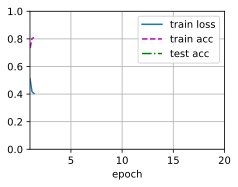

In [ ]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, embedding_size, num_filters, filter_sizes, hidden_size, num_classes, **kwargs):
        super(CNN, self).__init__(**kwargs)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1,
                      out_channels=num_filters,
                      kernel_size=(filter_size, embedding_size))
            for filter_size in filter_sizes
        ])
        # self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(num_filters * len(filter_sizes), hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x 的大小：(batch_size, sequence_length, embedding_size)
        x = x.unsqueeze(1)  # (batch_size, 1, sequence_length, embedding_size)
        # 经过多个卷积层
        conv_output = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [batch_size, num_filters, seq_len - filter_sizes[n] + 1]
        # 经过多个池化层
        pool_output = [F.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in conv_output]  # [batch_size, num_filters]
        # 拼接所有池化结果
        concat_output = torch.cat(pool_output, dim=1) # [batch_size, len(filter_sizes) * num_filters]
        # 经过全连接层和输出层
        hidden_output = F.relu(self.fc(concat_output))
        logits = self.output_layer(hidden_output)
        return logits

net = CNN(embedding_size=768, num_filters=100, filter_sizes=[3, 4, 5], hidden_size=256, num_classes=2)
devices = try_all_gpus()
lr, num_epochs = 0.001, 20
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_loader, test_loader, loss, trainer, num_epochs, devices)
evaluate(net, test_loader)

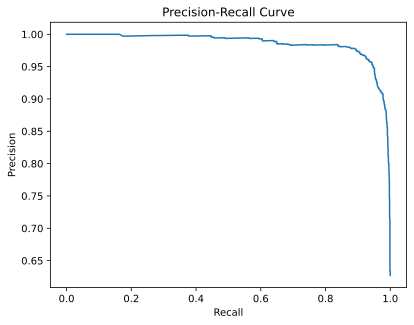

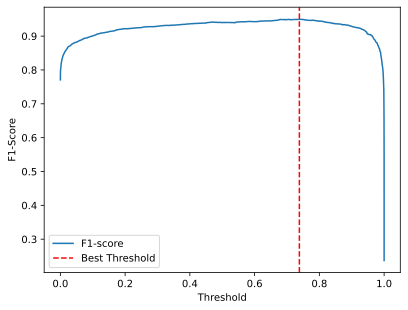

In [12]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

net.eval()  # 切换到测试模式
y_scores, y_true = [], []  # 用于存储预测概率和真实标签
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(devices[0]), y.to(devices[0])
        y_hat = net(X)
        y_hat = torch.softmax(y_hat, dim=1)[:, 1]  # 取出正例预测概率
        y_scores.extend(y_hat.cpu().numpy())
        y_true.extend(y.cpu().numpy())

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


# 计算F1-score并找到最大值的索引
f1_scores = 2 * (precision * recall) / (precision + recall)
max_f1_index = np.argmax(f1_scores)
# 绘制F1-score曲线
plt.plot(thresholds, f1_scores[:-1], label='F1-score')
plt.axvline(x=thresholds[max_f1_index], color='r', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.legend(loc='lower left')
plt.show()

loss 0.2553, train acc 0.8957, test acc 0.8675
10131.6 examples/sec on [device(type='cuda', index=0)]
Precision: 0.8740, Recall: 0.9216, F1-Score: 0.8971


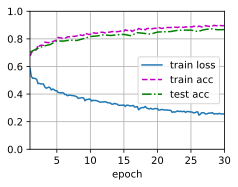

In [30]:
from torch import nn
import torch.nn.functional as F

class AttentionClassifier(nn.Module):
    def __init__(self, hidden_size, num_labels, **kwargs):
        super(AttentionClassifier, self).__init__(**kwargs)
        self.attention = nn.Linear(hidden_size, 1)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids):
        # input_ids shape: [batch_size, seq_len, hidden_size]
        attention_weights = self.attention(input_ids).squeeze(-1)
        attention_weights = F.softmax(attention_weights, dim=-1).unsqueeze(-1)
        # attention_weights shape: [batch_size, seq_len, 1]
        attention_output = input_ids * attention_weights
        # attention_output shape: [batch_size, seq_len, hidden_size]
        sum_embeddings = torch.sum(attention_output, dim=1)
        # sum_embeddings shape: [batch_size, hidden_size]
        logits = self.classifier(sum_embeddings)
        # logits shape: [batch_size, num_labels]
        return logits

net = AttentionClassifier(hidden_size=768, num_labels=2)
devices = try_all_gpus()
lr, num_epochs = 0.001, 30
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_loader, test_loader, loss, trainer, num_epochs, devices)
evaluate(net, test_loader)

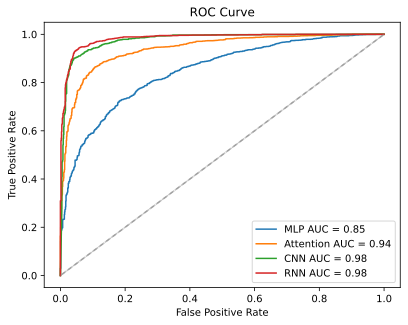

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

mlp_true = [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1] 
mlp_scores = [0.6840002536773682, 0.49284878373146057, 0.8335075378417969, 0.606503963470459, 0.33686646819114685, 0.2581369876861572, 0.5753867030143738, 0.4842211604118347, 0.44658637046813965, 0.5876297354698181, 0.346218466758728, 0.9643293023109436, 0.6083511114120483, 0.9950152039527893, 0.45135125517845154, 0.1956598162651062, 0.3126370906829834, 0.16430535912513733, 0.924819827079773, 0.5368043780326843, 0.5737630724906921, 0.21743135154247284, 0.8930158019065857, 0.09977050870656967, 0.8209497332572937, 0.9988803267478943, 0.18072058260440826, 0.2233322411775589, 0.17075484991073608, 0.22390057146549225, 0.16779740154743195, 0.865729570388794, 0.9063381552696228, 0.9064338803291321, 0.9213255047798157, 0.5893499255180359, 0.3956742286682129, 0.6663571000099182, 0.08722200989723206, 0.8797934651374817, 0.13773439824581146, 0.53104168176651, 0.9502646923065186, 0.2716904580593109, 0.9588638544082642, 0.8403103351593018, 0.771483302116394, 0.6631474494934082, 0.27551984786987305, 0.7893111705780029, 0.3116077482700348, 0.45860397815704346, 0.42724791169166565, 0.2523864507675171, 0.4738100469112396, 0.41303297877311707, 0.968679666519165, 0.8152753710746765, 0.36287516355514526, 0.5227644443511963, 0.6901395916938782, 0.8079961538314819, 0.9646334648132324, 0.4122098982334137, 0.7138738632202148, 0.6399039030075073, 0.834615170955658, 0.15172263979911804, 0.73946613073349, 0.5647155046463013, 0.364519864320755, 0.13142803311347961, 0.37272781133651733, 0.3902319371700287, 0.800152599811554, 0.3415951132774353, 0.9675477743148804, 0.9728381037712097, 0.843313992023468, 0.7749471664428711, 0.8716334104537964, 0.312836617231369, 0.3867356479167938, 0.9959110021591187, 0.7607774138450623, 0.1273351013660431, 0.48555633425712585, 0.4316311180591583, 0.6439697742462158, 0.6638766527175903, 0.9963262677192688, 0.25109052658081055, 0.8212652206420898, 0.15040212869644165, 0.42850127816200256, 0.07136663794517517, 0.9728381037712097, 0.07593879848718643, 0.7891718745231628, 0.9922385811805725, 0.7037241458892822, 0.7311066389083862, 0.6786326169967651, 0.9932356476783752, 0.9141218066215515, 0.07873944938182831, 0.17359907925128937, 0.9953179359436035, 0.9568267464637756, 0.6320314407348633, 0.9489849209785461, 0.8393423557281494, 0.503158688545227, 0.5130784511566162, 0.2690174877643585, 0.44166550040245056, 0.7368898391723633, 0.11137817054986954, 0.823723316192627, 0.9507980942726135, 0.8016202449798584, 0.6238177418708801, 0.8524839282035828, 0.9941970109939575, 0.4316311180591583, 0.2594638466835022, 0.1030433252453804, 0.2134983241558075, 0.8468245267868042, 0.35503169894218445, 0.13941559195518494, 0.3575950860977173, 0.7459914088249207, 0.23706360161304474, 0.763576865196228, 0.14810101687908173, 0.96101975440979, 0.18683189153671265, 0.634975790977478, 0.09940052777528763, 0.7186135053634644, 0.6531748175621033, 0.6485852599143982, 0.30395960807800293, 0.7441948652267456, 0.9662882089614868, 0.34653887152671814, 0.9873687624931335, 0.9058341979980469, 0.8954305052757263, 0.12393304705619812, 0.42172908782958984, 0.8967235088348389, 0.4168757498264313, 0.9728381037712097, 0.3778531849384308, 0.5305148363113403, 0.5006766319274902, 0.0356706939637661, 0.4356829822063446, 0.32107797265052795, 0.3351484537124634, 0.8737924695014954, 0.36194461584091187, 0.7324373126029968, 0.5246657729148865, 0.7101022005081177, 0.5028484463691711, 0.942733108997345, 0.7163987159729004, 0.998304009437561, 0.9112403392791748, 0.10062611103057861, 0.2288752794265747, 0.9335955381393433, 0.8819988369941711, 0.8984168767929077, 0.14844699203968048, 0.5639051795005798, 0.5554453134536743, 0.8011067509651184, 0.6799514889717102, 0.08516678214073181, 0.7414273023605347, 0.9948683977127075, 0.6172606348991394, 0.9862275719642639, 0.49149253964424133, 0.8393423557281494, 0.7450416088104248, 0.09603950381278992, 0.3748515248298645, 0.9930267333984375, 0.9202746152877808, 0.442230224609375, 0.1653282195329666, 0.6407672762870789, 0.5248405337333679, 0.9984532594680786, 0.33951282501220703, 0.15830324590206146, 0.9899784326553345, 0.07593879848718643, 0.9988634586334229, 0.5182440280914307, 0.5958007574081421, 0.9996895790100098, 0.38382038474082947, 0.6113865971565247, 0.6170101165771484, 0.42028096318244934, 0.1359500139951706, 0.11843153834342957, 0.8408989906311035, 0.23794034123420715, 0.9910967350006104, 0.9986953139305115, 0.5322752594947815, 0.13045039772987366, 0.38689953088760376, 0.977287769317627, 0.5389160513877869, 0.7541726231575012, 0.8592594265937805, 0.44713538885116577, 0.5551421642303467, 0.5736403465270996, 0.28016990423202515, 0.48684045672416687, 0.8714863061904907, 0.7285448312759399, 0.37272781133651733, 0.1618461012840271, 0.12441227585077286, 0.6886103749275208, 0.5424309372901917, 0.9486448168754578, 0.9846958518028259, 0.07873944938182831, 0.5087460279464722, 0.16951778531074524, 0.241205632686615, 0.8587511777877808, 0.2757047712802887, 0.9084212779998779, 0.7232987284660339, 0.3926375210285187, 0.0796707272529602, 0.20522348582744598, 0.7729442715644836, 0.5371994376182556, 0.2337908297777176, 0.01985592395067215, 0.16704203188419342, 0.5842790603637695, 0.8213211297988892, 0.9457337260246277, 0.4181540906429291, 0.3267679512500763, 0.2903275787830353, 0.4034414291381836, 0.9991768002510071, 0.1692192554473877, 0.27882981300354004, 0.9706630706787109, 0.4026654064655304, 0.6150157451629639, 0.2881667912006378, 0.16901864111423492, 0.5470578670501709, 0.9941970109939575, 0.16564589738845825, 0.8954305052757263, 0.15655581653118134, 0.8596326112747192, 0.15637435019016266, 0.9631466865539551, 0.5678297281265259, 0.621937096118927, 0.40372446179389954, 0.6154721975326538, 0.7677512168884277, 0.9728381037712097, 0.7749471664428711, 0.32693347334861755, 0.07509975135326385, 0.44693130254745483, 0.8393423557281494, 0.43171191215515137, 0.09268737584352493, 0.8714863061904907, 0.12298345565795898, 0.6580515503883362, 0.9413033127784729, 0.39849764108657837, 0.6575592756271362, 0.8101558685302734, 0.09624193608760834, 0.040875278413295746, 0.8690174221992493, 0.9668468832969666, 0.6971603631973267, 0.8657413721084595, 0.5577599406242371, 0.9908508658409119, 0.20470629632472992, 0.6623640060424805, 0.5492013692855835, 0.558870792388916, 0.5762428641319275, 0.5958007574081421, 0.44559481739997864, 0.8972866535186768, 0.9357598423957825, 0.34116411209106445, 0.6728065013885498, 0.9019391536712646, 0.5236520171165466, 0.7362427711486816, 0.9000001549720764, 0.9654256105422974, 0.15954414010047913, 0.06880953162908554, 0.4163302481174469, 0.5071227550506592, 0.18088744580745697, 0.8408989906311035, 0.7445281147956848, 0.27980273962020874, 0.6869388222694397, 0.6706259846687317, 0.8408302664756775, 0.21792326867580414, 0.31693530082702637, 0.962785005569458, 0.3290843367576599, 0.5121327638626099, 0.5889344215393066, 0.6407672762870789, 0.783499002456665, 0.37856873869895935, 0.6913482546806335, 0.10357553511857986, 0.08507684618234634, 0.7934021949768066, 0.4310636818408966, 0.9862275719642639, 0.89913010597229, 0.9674216508865356, 0.27693817019462585, 0.9282674193382263, 0.21803373098373413, 0.9764270782470703, 0.1185850128531456, 0.9986147880554199, 0.31538861989974976, 0.6518871188163757, 0.1956598162651062, 0.17211568355560303, 0.45245566964149475, 0.2559168338775635, 0.825093150138855, 0.2003914713859558, 0.13889960944652557, 0.2235904484987259, 0.9204779267311096, 0.6625862121582031, 0.3931249678134918, 0.9246410727500916, 0.7618211507797241, 0.44600027799606323, 0.8026065826416016, 0.6381150484085083, 0.5470879673957825, 0.14121077954769135, 0.5546680688858032, 0.08516678214073181, 0.9909371733665466, 0.180552676320076, 0.41908058524131775, 0.4995321035385132, 0.32361677289009094, 0.44204825162887573, 0.9960936903953552, 0.7794405221939087, 0.1995047926902771, 0.8741172552108765, 0.2970040738582611, 0.3123408555984497, 0.8956775665283203, 0.23433275520801544, 0.9254453778266907, 0.44709473848342896, 0.0609811395406723, 0.8418583273887634, 0.8466027975082397, 0.49453210830688477, 0.8110170960426331, 0.9926044940948486, 0.9721361994743347, 0.8860441446304321, 0.43737924098968506, 0.9790922403335571, 0.8468245267868042, 0.9149844646453857, 0.5153254866600037, 0.12393304705619812, 0.9670330882072449, 0.10819624364376068, 0.686206042766571, 0.2939336597919464, 0.3129764497280121, 0.06057221442461014, 0.9304375052452087, 0.7711647152900696, 0.7973332405090332, 0.71869957447052, 0.8797934651374817, 0.9996811151504517, 0.4748899042606354, 0.4921395778656006, 0.019636018201708794, 0.06097021326422691, 0.5608727335929871, 0.1926450878381729, 0.9502406716346741, 0.3455747067928314, 0.37035107612609863, 0.4315080940723419, 0.17899109423160553, 0.962440013885498, 0.36021608114242554, 0.29946666955947876, 0.8714863061904907, 0.2504033148288727, 0.9862275719642639, 0.43590718507766724, 0.8256294131278992, 0.9991936087608337, 0.4274630546569824, 0.6171771287918091, 0.4748899042606354, 0.3655698001384735, 0.2666947543621063, 0.6762163043022156, 0.6991099715232849, 0.2610924541950226, 0.9693009853363037, 0.9970990419387817, 0.13781242072582245, 0.5605769753456116, 0.9698823094367981, 0.07555292546749115, 0.9755263924598694, 0.9704915881156921, 0.31834572553634644, 0.5119295716285706, 0.5051419734954834, 0.314083456993103, 0.9507980942726135, 0.6273751258850098, 0.14413341879844666, 0.5675714015960693, 0.6149638891220093, 0.8525242209434509, 0.16938269138336182, 0.18567682802677155, 0.3719242513179779, 0.2235904484987259, 0.9991768002510071, 0.1956598162651062, 0.7727896571159363, 0.6613200902938843, 0.3565371334552765, 0.924611508846283, 0.7769339680671692, 0.998304009437561, 0.24617859721183777, 0.4810643196105957, 0.42082419991493225, 0.2725951373577118, 0.19132544100284576, 0.8979781866073608, 0.7890894412994385, 0.9821400046348572, 0.7037241458892822, 0.2587541937828064, 0.11860440671443939, 0.6116985082626343, 0.39721471071243286, 0.27020925283432007, 0.4402575194835663, 0.47647377848625183, 0.9091397523880005, 0.058735813945531845, 0.5473534464836121, 0.8773999810218811, 0.758560299873352, 0.7558671832084656, 0.5454447865486145, 0.6566727161407471, 0.3665737807750702, 0.8335830569267273, 0.3645962178707123, 0.9023173451423645, 0.7527502775192261, 0.5023503303527832, 0.5711691379547119, 0.1823858767747879, 0.9502646923065186, 0.5402278304100037, 0.9148390293121338, 0.24494676291942596, 0.3337520658969879, 0.19100125133991241, 0.9930267333984375, 0.036087557673454285, 0.8607162833213806, 0.23800799250602722, 0.7297289371490479, 0.574930727481842, 0.6807846426963806, 0.4135677218437195, 0.987153947353363, 0.9736413955688477, 0.19944271445274353, 0.9829066395759583, 0.5262472629547119, 0.9632379412651062, 0.8145383596420288, 0.9886264204978943, 0.9976198077201843, 0.1956598162651062, 0.9952919483184814, 0.5420675873756409, 0.44598615169525146, 0.5667765140533447, 0.188333660364151, 0.6003255844116211, 0.10862022638320923, 0.17586646974086761, 0.9754623174667358, 0.997391939163208, 0.9878646731376648, 0.1123121827840805, 0.5308341383934021, 0.86667400598526, 0.7528149485588074, 0.15091350674629211, 0.03256514295935631, 0.21362879872322083, 0.9375253915786743, 0.08221498876810074, 0.7532970905303955, 0.8692429065704346, 0.08353014290332794, 0.9976198077201843, 0.1952161341905594, 0.370649516582489, 0.14136694371700287, 0.6594151258468628, 0.7260551452636719, 0.09035079926252365, 0.5958007574081421, 0.7622888684272766, 0.834615170955658, 0.661285936832428, 0.6107521057128906, 0.2728491425514221, 0.19082799553871155, 0.9137194752693176, 0.5830386877059937, 0.6286047101020813, 0.48786813020706177, 0.31538861989974976, 0.24834896624088287, 0.09908066689968109, 0.3379509747028351, 0.6688827276229858, 0.20439238846302032, 0.9693009853363037, 0.9000001549720764, 0.9865070581436157, 0.25804710388183594, 0.22208820283412933, 0.21085897088050842, 0.12575650215148926, 0.7775333523750305, 0.38716110587120056, 0.17715606093406677, 0.7280417680740356, 0.32372215390205383, 0.5708461999893188, 0.36795204877853394, 0.33194494247436523, 0.5744791626930237, 0.34370505809783936, 0.26730382442474365, 0.12444331496953964, 0.7137495875358582, 0.9670330882072449, 0.5867667198181152, 0.9373011589050293, 0.8750661611557007, 0.18596328794956207, 0.5259686708450317, 0.6334856748580933, 0.578690230846405, 0.8916130065917969, 0.9037485122680664, 0.4726497232913971, 0.1454547494649887, 0.28302204608917236, 0.10331651568412781, 0.9632997512817383, 0.2622317373752594, 0.7759639024734497, 0.8152753710746765, 0.6547374129295349, 0.843313992023468, 0.09601742029190063, 0.3764469027519226, 0.3964070975780487, 0.1956598162651062, 0.9976902008056641, 0.09191764891147614, 0.3192433714866638, 0.44249778985977173, 0.7505897879600525, 0.22511814534664154, 0.45882678031921387, 0.8084787130355835, 0.8632766008377075, 0.9538228511810303, 0.8943675756454468, 0.9966703057289124, 0.46081411838531494, 0.7670519948005676, 0.8692429065704346, 0.9858989715576172, 0.783499002456665, 0.44456467032432556, 0.5731565356254578, 0.3917124271392822, 0.7445281147956848, 0.924611508846283, 0.9000001549720764, 0.8714863061904907, 0.37984174489974976, 0.76373690366745, 0.33622679114341736, 0.8598525524139404, 0.8930158019065857, 0.13306020200252533, 0.6356197595596313, 0.9141218066215515, 0.612183690071106, 0.757832944393158, 0.7815593481063843, 0.4549941122531891, 0.4905286729335785, 0.8891843557357788, 0.8734477758407593, 0.9137194752693176, 0.14876410365104675, 0.4304388761520386, 0.673468291759491, 0.05081906542181969, 0.6022837162017822, 0.7172179818153381, 0.8860441446304321, 0.9948047995567322, 0.4203127920627594, 0.32549533247947693, 0.5685793161392212, 0.400971382856369, 0.8353614807128906, 0.6617757081985474, 0.7432567477226257, 0.512624204158783, 0.23412249982357025, 0.33571016788482666, 0.31574374437332153, 0.46421200037002563, 0.8860441446304321, 0.7205895185470581, 0.14324358105659485, 0.5519485473632812, 0.7730011343955994, 0.6381164193153381, 0.6875461339950562, 0.3453337848186493, 0.8199607133865356, 0.9975167512893677, 0.6514199376106262, 0.7256843447685242, 0.27119573950767517, 0.5524719953536987, 0.5012245178222656, 0.21002601087093353, 0.9502406716346741, 0.25075429677963257, 0.049948014318943024, 0.4476499855518341, 0.11657003313302994, 0.9880189299583435, 0.6607860922813416, 0.22032497823238373, 0.7611939311027527, 0.8838796019554138, 0.07965531200170517, 0.42166268825531006, 0.4105687737464905, 0.489430695772171, 0.22970792651176453, 0.25782668590545654, 0.3833647072315216, 0.36604246497154236, 0.9976020455360413, 0.24197633564472198, 0.2592000365257263, 0.25539377331733704, 0.1654483824968338, 0.979941189289093, 0.43596363067626953, 0.7121769189834595, 0.62936931848526, 0.7123549580574036, 0.09145314246416092, 0.1426418572664261, 0.24795587360858917, 0.6657447814941406, 0.972367525100708, 0.3370262086391449, 0.13041023910045624, 0.8501889109611511, 0.20993828773498535, 0.21656352281570435, 0.19224904477596283, 0.5965458750724792, 0.2936843931674957, 0.5881475806236267, 0.6498335599899292, 0.18012063205242157, 0.4633140563964844, 0.24834896624088287, 0.629320502281189, 0.8714863061904907, 0.6807846426963806, 0.3543583154678345, 0.5486266613006592, 0.775225043296814, 0.6223921775817871, 0.2594488561153412, 0.11362912505865097, 0.0789370983839035, 0.16254402697086334, 0.38215404748916626, 0.3497287929058075, 0.9035323262214661, 0.9063381552696228, 0.9949475526809692, 0.1863839030265808, 0.686206042766571, 0.4796374440193176, 0.8128889799118042, 0.34191909432411194, 0.821541965007782, 0.6612342596054077, 0.15842083096504211, 0.06589525192975998, 0.33544179797172546, 0.04747738689184189, 0.40901315212249756, 0.6047629714012146, 0.38740161061286926, 0.8984168767929077, 0.9141218066215515, 0.5414703488349915, 0.6898559331893921, 0.9996811151504517, 0.7598364353179932, 0.9292766451835632, 0.6594485640525818, 0.29622116684913635, 0.07296718657016754, 0.3622753322124481, 0.7311066389083862, 0.6162974834442139, 0.6044794321060181, 0.418093740940094, 0.5075765252113342, 0.7625971436500549, 0.995254635810852, 0.37272781133651733, 0.09754426032304764, 0.1750413030385971, 0.681592583656311, 0.9992914199829102, 0.1759166121482849, 0.5457953214645386, 0.3943275809288025, 0.654334545135498, 0.5589885115623474, 0.37272781133651733, 0.9934878349304199, 0.8095159530639648, 0.9133053421974182, 0.9321299195289612, 0.5016096234321594, 0.8508421778678894, 0.843313992023468, 0.540678858757019, 0.49636784195899963, 0.32392436265945435, 0.9373011589050293, 0.4770722985267639, 0.5881054401397705, 0.8152148127555847, 0.3951352536678314, 0.7025212645530701, 0.6331412196159363, 0.30317261815071106, 0.33305874466896057, 0.5748015642166138, 0.556294322013855, 0.936467170715332, 0.4397600293159485, 0.15958890318870544, 0.485041081905365, 0.6971293091773987, 0.7876831293106079, 0.9507980942726135, 0.441704660654068, 0.33604294061660767, 0.6890143156051636, 0.9058341979980469, 0.8741172552108765, 0.9373011589050293, 0.49817946553230286, 0.6434199213981628, 0.9664023518562317, 0.7928621768951416, 0.572656512260437, 0.843313992023468, 0.24806800484657288, 0.8101814389228821, 0.8797934651374817, 0.34916138648986816, 0.15940144658088684, 0.6573972702026367, 0.9792898893356323, 0.995254635810852, 0.843313992023468, 0.86057049036026, 0.8376118540763855, 0.4642135500907898, 0.2640846073627472, 0.17112356424331665, 0.15046373009681702, 0.6621825695037842, 0.8903406262397766, 0.9504520297050476, 0.10364027321338654, 0.686840832233429, 0.11684198677539825, 0.12206507474184036, 0.9988803267478943, 0.9373011589050293, 0.5601085424423218, 0.8231086134910583, 0.7710617184638977, 0.9686192870140076, 0.5670375227928162, 0.3712958097457886, 0.3024735748767853, 0.4573773443698883, 0.6326987147331238, 0.14139088988304138, 0.20173729956150055, 0.9433068633079529, 0.7764007449150085, 0.811427116394043, 0.23115584254264832, 0.16952195763587952, 0.24113158881664276, 0.5606689453125, 0.1921267807483673, 0.8400099277496338, 0.783499002456665, 0.11546182632446289, 0.9586817026138306, 0.2605420649051666, 0.9554721713066101, 0.31871849298477173, 0.06246188282966614, 0.28953495621681213, 0.9204779267311096, 0.23840758204460144, 0.627864420413971, 0.4388826787471771, 0.42394983768463135, 0.1956598162651062, 0.32532909512519836, 0.2300160825252533, 0.737415075302124, 0.6279652118682861, 0.9159201979637146, 0.6629165410995483, 0.3856397569179535, 0.7981123924255371, 0.5830162763595581, 0.20861512422561646, 0.5937963724136353, 0.8550629019737244, 0.9529004096984863, 0.5825174450874329, 0.8860441446304321, 0.5229440331459045, 0.5256161093711853, 0.22713938355445862, 0.5577599406242371, 0.3758862018585205, 0.8717478513717651, 0.11743563413619995, 0.9646660685539246, 0.4748899042606354, 0.5058751106262207, 0.9958654642105103, 0.6507375240325928, 0.41963085532188416, 0.1956598162651062, 0.8212652206420898, 0.2592000365257263, 0.7120834589004517, 0.9203256368637085, 0.9930819869041443, 0.8819190859794617, 0.8328216075897217, 0.3694630563259125, 0.09624193608760834, 0.9991768002510071, 0.06802307814359665, 0.7769339680671692, 0.5593363046646118, 0.5178732872009277, 0.6795374751091003, 0.4505763351917267, 0.9485556483268738, 0.7677512168884277, 0.22127459943294525, 0.8545666933059692, 0.44252264499664307, 0.39889827370643616, 0.2842077314853668, 0.9893501400947571, 0.6166625022888184, 0.24229519069194794, 0.8381578922271729, 0.8240110278129578, 0.9942821264266968, 0.31627851724624634, 0.23120450973510742, 0.8835288286209106, 0.43298137187957764, 0.8940478563308716, 0.9002853631973267, 0.10415191948413849, 0.4484809935092926, 0.8283128142356873, 0.31659021973609924, 0.8480495810508728, 0.5846200585365295, 0.9728448987007141, 0.6867004632949829, 0.12025808542966843, 0.31199920177459717, 0.6807846426963806, 0.9063381552696228, 0.222601518034935, 0.6263222098350525, 0.8463214635848999, 0.8192741870880127, 0.36490538716316223, 0.663358211517334, 0.33011704683303833, 0.7645226716995239, 0.11035115271806717, 0.9983168840408325, 0.11841418594121933, 0.5323631763458252, 0.6515982151031494, 0.22431735694408417, 0.9943205118179321, 0.4748899042606354, 0.2704964578151703, 0.10357553511857986, 0.25065070390701294, 0.2876201570034027, 0.9673212766647339, 0.5622084140777588, 0.5992856025695801, 0.9986953139305115, 0.09265778213739395, 0.4491599500179291, 0.9934256076812744, 0.42794322967529297, 0.7579047083854675, 0.6889937520027161, 0.33119434118270874, 0.5647588968276978, 0.7489070892333984, 0.28358161449432373, 0.5330346822738647, 0.2696472406387329, 0.36596378684043884, 0.9094359278678894, 0.2658950090408325, 0.39990460872650146, 0.9991768002510071, 0.588555634021759, 0.1325363963842392, 0.32871150970458984, 0.15544955432415009, 0.4273028075695038, 0.04304380342364311, 0.8027751445770264, 0.3299970030784607, 0.09056717157363892, 0.9136260151863098, 0.9370033740997314, 0.17004811763763428, 0.5424309372901917, 0.2936843931674957, 0.6258144974708557, 0.093686543405056, 0.06974004209041595, 0.24053534865379333, 0.5990254282951355, 0.6543294191360474, 0.6213715672492981, 0.886001467704773, 0.22895993292331696, 0.9958654642105103, 0.843313992023468, 0.05742184817790985, 0.3967224657535553, 0.21969838440418243, 0.21442186832427979, 0.6815764307975769, 0.9443995356559753, 0.07844807952642441, 0.5863958597183228, 0.8954305052757263, 0.9693009853363037, 0.9361817836761475, 0.8468245267868042, 0.8319772481918335, 0.10331651568412781, 0.138253852725029, 0.7923191785812378, 0.8408989906311035, 0.7769339680671692, 0.0369441956281662, 0.07136663794517517, 0.09822726249694824, 0.6807846426963806, 0.5259234309196472, 0.6877952814102173, 0.6592651009559631, 0.3185008764266968, 0.1916094273328781, 0.9996811151504517, 0.29736876487731934, 0.84393709897995, 0.23372291028499603, 0.3646189868450165, 0.09567097574472427, 0.8773761987686157, 0.8209800124168396, 0.6454423666000366, 0.33554649353027344, 0.8393419981002808, 0.49866142868995667, 0.6888880133628845, 0.39659643173217773, 0.31397318840026855, 0.899700939655304, 0.9529004096984863, 0.20375636219978333, 0.8508303761482239, 0.43443891406059265, 0.557213544845581, 0.913673460483551, 0.7811948657035828, 0.3692508935928345, 0.46542009711265564, 0.7123490571975708, 0.5699601769447327, 0.2905365824699402, 0.9992784857749939, 0.07564356923103333, 0.800686776638031, 0.9204779267311096, 0.5384822487831116, 0.47367092967033386, 0.15797999501228333, 0.37272781133651733, 0.6240071058273315, 0.09437645971775055, 0.3948974907398224, 0.9443995356559753, 0.5920436382293701, 0.991733193397522, 0.35772940516471863, 0.7605030536651611, 0.7068227529525757, 0.9507980942726135, 0.44198742508888245, 0.4532206654548645, 0.44623124599456787, 0.4258072078227997, 0.07909554243087769, 0.4582632780075073, 0.6008898019790649, 0.13851749897003174, 0.07965531200170517, 0.40525758266448975, 0.3779163360595703, 0.9670330882072449, 0.3522011339664459, 0.8956634998321533, 0.09493837505578995, 0.7442403435707092, 0.19468162953853607, 0.7818556427955627, 0.8938973546028137, 0.6624912023544312, 0.9983406066894531, 0.8240110278129578, 0.9204779267311096, 0.12357286363840103, 0.8149259090423584, 0.521392822265625, 0.9950802326202393, 0.3813786208629608, 0.238305926322937, 0.9655061364173889, 0.9930267333984375, 0.5284589529037476, 0.8711832761764526, 0.40826547145843506, 0.1975136399269104, 0.17304518818855286, 0.787204384803772, 0.7677512168884277, 0.8967235088348389, 0.17949089407920837, 0.8746659755706787, 0.5004538297653198, 0.3277183771133423, 0.5301285982131958, 0.8688269257545471, 0.8712946772575378, 0.24792620539665222, 0.8587511777877808, 0.48087960481643677, 0.3422287404537201, 0.37217041850090027, 0.9272982478141785, 0.9941970109939575, 0.4920758605003357, 0.9958998560905457, 0.09485317021608353, 0.17085564136505127, 0.9176974296569824, 0.8453081250190735, 0.9278762340545654, 0.45949655771255493, 0.38371723890304565, 0.6955137848854065, 0.3503360450267792, 0.5238286256790161, 0.8401391506195068, 0.4356829822063446, 0.14547684788703918, 0.24755461513996124, 0.9878646731376648, 0.3286755383014679, 0.7326942682266235, 0.6347149014472961, 0.8530519008636475, 0.6558703780174255, 0.09666276723146439, 0.5722560286521912, 0.19785448908805847, 0.14810101687908173, 0.9693009853363037, 0.995270311832428, 0.2517412304878235, 0.9000001549720764, 0.7806499004364014, 0.41292470693588257, 0.527006208896637, 0.4229799807071686, 0.9999668598175049, 0.17334295809268951, 0.8240110278129578, 0.7217252254486084, 0.9897273182868958, 0.5774936676025391, 0.736700177192688, 0.34553706645965576, 0.3282169699668884, 0.34859541058540344, 0.23908784985542297, 0.47927534580230713, 0.9737775921821594, 0.20061762630939484, 0.6032363772392273, 0.5909952521324158, 0.25597506761550903, 0.9702168107032776, 0.3530939519405365, 0.5196681618690491, 0.23429806530475616, 0.5355224013328552, 0.5407606363296509, 0.44992223381996155, 0.9463291764259338, 0.5966377854347229, 0.5108478665351868, 0.856546938419342, 0.23436792194843292, 0.627116322517395, 0.3895704448223114, 0.21753716468811035, 0.9980518817901611, 0.8070797920227051, 0.07925555855035782, 0.6132523417472839, 0.10587965697050095, 0.2202061414718628, 0.3079192340373993, 0.6481267809867859, 0.7243032455444336, 0.05422694608569145, 0.683165967464447, 0.3865557014942169, 0.9405272006988525, 0.9996763467788696, 0.45671820640563965, 0.5068473815917969, 0.3662187159061432, 0.21928708255290985, 0.1712217777967453, 0.24644652009010315, 0.9992914199829102, 0.5283195972442627, 0.17034991085529327, 0.3380671739578247, 0.7271451950073242, 0.8456496000289917, 0.8249863982200623, 0.9648798108100891, 0.09757523983716965, 0.9756380319595337, 0.6421442031860352, 0.4594731032848358, 0.2293660044670105, 0.21492893993854523, 0.8606489300727844, 0.36146754026412964, 0.09056717157363892, 0.3739795684814453, 0.048930857330560684, 0.45203250646591187, 0.21896617114543915, 0.8940478563308716, 0.9959110021591187, 0.45028477907180786, 0.09808126091957092, 0.6542511582374573, 0.6409420371055603, 0.9757817983627319, 0.7041504383087158, 0.8934330344200134, 0.35318392515182495, 0.5463119745254517, 0.713626503944397, 0.5540817379951477, 0.5174251794815063, 0.6141952276229858, 0.9275339841842651, 0.7695545554161072, 0.516234815120697, 0.9994555115699768, 0.33488398790359497, 0.648070216178894, 0.1672995686531067, 0.9045013785362244, 0.09601742029190063, 0.16582705080509186, 0.6808269619941711, 0.1323634684085846, 0.18136078119277954, 0.4982219338417053, 0.7280641198158264, 0.11982515454292297, 0.15813501179218292, 0.48031148314476013, 0.4298357665538788, 0.5622084140777588, 0.9980862140655518, 0.2577899992465973, 0.9568267464637756, 0.9648662805557251, 0.9881997108459473, 0.6929313540458679, 0.02583582140505314, 0.6287755370140076, 0.5436732172966003, 0.7371289730072021, 0.5488199591636658, 0.8797934651374817, 0.2885141968727112, 0.3226892948150635, 0.27277737855911255, 0.5558657050132751, 0.9970314502716064, 0.3933497965335846, 0.9711931347846985, 0.9712215065956116, 0.1956598162651062, 0.1795194149017334, 0.1108873188495636, 0.34983447194099426, 0.8922795057296753, 0.3350100815296173, 0.5905906558036804, 0.41912010312080383, 0.33011704683303833, 0.9651264548301697, 0.9946776628494263, 0.9250947833061218, 0.987153947353363, 0.42445290088653564, 0.5803333520889282, 0.8775889873504639, 0.2801302671432495, 0.8741172552108765, 0.9693009853363037, 0.7864822149276733, 0.33501574397087097, 0.2825959622859955, 0.20960526168346405, 0.8967235088348389, 0.866670548915863, 0.4207901060581207, 0.42604517936706543, 0.5622084140777588, 0.3986126780509949, 0.9624302983283997, 0.3973349332809448, 0.9791602492332458, 0.6911599636077881, 0.7045310139656067, 0.17684365808963776, 0.2586219608783722, 0.40087059140205383, 0.4617173671722412, 0.45428112149238586, 0.4611086845397949, 0.11435101926326752, 0.8797934651374817, 0.9063381552696228, 0.5480180978775024, 0.4660106599330902, 0.924278974533081, 0.8902875185012817, 0.683165967464447, 0.37082067131996155, 0.9993119239807129, 0.763576865196228, 0.34127458930015564, 0.20983007550239563, 0.2600030303001404, 0.23372291028499603, 0.17249852418899536, 0.26688021421432495, 0.3259895443916321, 0.5163495540618896, 0.6158655285835266, 0.7091139554977417, 0.9052241444587708, 0.9507980942726135, 0.7386956810951233, 0.5968652963638306, 0.5297448635101318, 0.21549732983112335, 0.7928621768951416, 0.45705580711364746, 0.2176288515329361, 0.8414512872695923, 0.9794426560401917, 0.7426168322563171, 0.8970913887023926, 0.19833029806613922, 0.35659196972846985, 0.744805097579956, 0.392473429441452, 0.8930158019065857, 0.7309176921844482, 0.9985852241516113, 0.19684767723083496, 0.8772206902503967, 0.9225254654884338, 0.37494683265686035, 0.7260509133338928, 0.34155747294425964, 0.6132523417472839, 0.7408658266067505, 0.1663368046283722, 0.7270458340644836, 0.25822651386260986, 0.9320130944252014, 0.22895967960357666, 0.6866492033004761, 0.8004589676856995, 0.3113119602203369, 0.5889049172401428, 0.5146344900131226, 0.5244133472442627, 0.3709562420845032, 0.8224239945411682, 0.49750208854675293, 0.07866156101226807, 0.29462334513664246, 0.8785630464553833, 0.5438545942306519, 0.9998568296432495, 0.3883824646472931, 0.49517202377319336, 0.8104379177093506, 0.6791293621063232, 0.10331651568412781, 0.7027173638343811, 0.9895652532577515, 0.4581628143787384, 0.4759880006313324, 0.3014811873435974, 0.165201798081398, 0.1660880148410797, 0.7677512168884277, 0.9764270782470703, 0.05182512477040291, 0.9996811151504517, 0.4412233531475067, 0.9568267464637756, 0.9953179359436035, 0.8270506262779236, 0.8621485829353333, 0.31824639439582825, 0.5768060088157654, 0.7725929617881775, 0.9000001549720764, 0.07599495351314545, 0.972564697265625, 0.21539446711540222, 0.33301594853401184, 0.3994957208633423, 0.3260725736618042, 0.8956634998321533, 0.9709551930427551, 0.5189695358276367, 0.8987138867378235, 0.5753408670425415, 0.973822832107544, 0.30075693130493164, 0.8967235088348389, 0.2257722169160843, 0.5424309372901917, 0.5718618035316467, 0.36230364441871643, 0.6321392059326172, 0.5251152515411377, 0.674384355545044, 0.02720400132238865, 0.6079782247543335, 0.8960736989974976, 0.239561527967453, 0.2081402987241745, 0.9373011589050293, 0.9408839344978333, 0.7788258194923401, 0.6454423666000366, 0.1439923495054245, 0.6807846426963806, 0.9764270782470703, 0.21139059960842133, 0.4283148944377899, 0.05422694608569145, 0.5973250865936279, 0.34739646315574646, 0.7590643167495728, 0.6194509267807007, 0.9317663908004761, 0.2232004553079605, 0.6443306803703308, 0.2974800169467926, 0.7503932118415833, 0.23040618002414703, 0.7633603811264038, 0.9632379412651062, 0.11137817054986954, 0.9974114298820496, 0.8335830569267273, 0.5953936576843262, 0.24035413563251495, 0.9975541234016418, 0.4651372730731964, 0.30524560809135437, 0.5757087469100952, 0.8772442936897278, 0.20625902712345123, 0.8741172552108765, 0.9770280122756958, 0.13281705975532532, 0.1325363963842392, 0.2139412760734558, 0.5070903301239014, 0.9112403392791748, 0.4857766628265381, 0.4005756974220276, 0.3582243323326111, 0.3316344618797302, 0.7264627814292908, 0.10877200216054916, 0.4090041220188141, 0.9373635649681091, 0.41184329986572266, 0.9879155158996582, 0.5319443941116333, 0.8741172552108765, 0.6307946443557739, 0.6219158172607422, 0.9198896288871765, 0.2912406921386719, 0.8112300038337708, 0.8540133237838745, 0.5268386006355286, 0.7677512168884277, 0.7981123924255371, 0.11671961098909378, 0.6096020340919495, 0.9204779267311096, 0.47680163383483887, 0.6873518228530884, 0.6191126108169556, 0.41945523023605347, 0.18908201158046722, 0.16679924726486206, 0.10115252435207367, 0.9373011589050293, 0.43392959237098694, 0.742990255355835, 0.8320890069007874, 0.652888298034668, 0.368553102016449, 0.7489764094352722, 0.4046875536441803, 0.9697262048721313, 0.32894381880760193, 0.7708414196968079, 0.1309392750263214, 0.8110170960426331, 0.7410014867782593, 0.1956598162651062, 0.8215028047561646, 0.9320175647735596, 0.9670330882072449, 0.5996230840682983, 0.4814700186252594, 0.7309176921844482, 0.18640172481536865, 0.561451256275177, 0.8400293588638306, 0.8223873376846313, 0.4551955759525299, 0.23354212939739227, 0.7320380210876465, 0.42604517936706543, 0.7258039116859436, 0.44058850407600403, 0.8400099277496338, 0.9996811151504517, 0.8193581104278564, 0.8300406336784363, 0.5333151817321777, 0.5269379615783691, 0.3833138644695282, 0.9722674489021301, 0.3665737807750702, 0.4642500579357147, 0.5973250865936279, 0.8967235088348389, 0.5200413465499878, 0.3047955334186554, 0.6942956447601318, 0.5540941953659058, 0.4548155963420868, 0.8763556480407715, 0.8547412157058716, 0.8457660675048828, 0.9790927171707153, 0.8741743564605713, 0.4412233531475067, 0.42010360956192017, 0.33364585041999817, 0.8691751956939697, 0.4691392481327057, 0.6080579161643982, 0.7388517260551453, 0.6872777938842773, 0.9632379412651062, 0.5016096234321594, 0.8070797920227051, 0.9670330882072449, 0.4239960312843323, 0.6984789371490479, 0.6760708093643188, 0.8393423557281494, 0.9578357934951782, 0.8332756161689758, 0.39034533500671387, 0.9868553280830383, 0.4998549818992615, 0.15544955432415009, 0.700756311416626, 0.14458633959293365, 0.9507019519805908, 0.8956634998321533, 0.9996811151504517, 0.5980609655380249, 0.44727298617362976, 0.9878646731376648, 0.2792838215827942, 0.942845344543457, 0.519515335559845, 0.27674710750579834, 0.17054590582847595, 0.2498602718114853, 0.1872013807296753, 0.17366160452365875, 0.5310072302818298, 0.4476407468318939, 0.6734604835510254, 0.929304301738739, 0.9058341979980469, 0.9204779267311096, 0.3815036416053772, 0.21955738961696625, 0.9746600985527039, 0.7035057544708252, 0.7068227529525757, 0.21540576219558716, 0.9845325350761414, 0.7188973426818848, 0.8902528882026672, 0.1192985326051712, 0.7934021949768066, 0.9251657128334045, 0.7896602153778076, 0.19406072795391083, 0.1956598162651062, 0.14248797297477722, 0.758409321308136, 0.3892950713634491, 0.526997447013855, 0.47925370931625366, 0.06880953162908554, 0.525193989276886, 0.6355454325675964, 0.6330504417419434, 0.362089604139328, 0.9686192870140076, 0.9480563402175903, 0.6431204676628113, 0.2465241551399231, 0.987153947353363, 0.2692195475101471, 0.48031148314476013, 0.44210803508758545, 0.5323631763458252, 0.7769339680671692, 0.8239070773124695, 0.9568267464637756, 0.4899146854877472, 0.8110170960426331, 0.8446175456047058, 0.17520175874233246, 0.8652704358100891, 0.38739800453186035, 0.9007977843284607, 0.603847324848175, 0.17563773691654205, 0.7161675095558167, 0.9694771766662598, 0.40758898854255676, 0.2592000365257263, 0.9300100803375244, 0.7033419609069824, 0.7358376979827881, 0.9588638544082642, 0.7949972152709961, 0.5549168586730957, 0.8839246034622192, 0.23148223757743835, 0.31824639439582825, 0.279214471578598, 0.9457337260246277, 0.9986979961395264, 0.4560655355453491, 0.6838515996932983, 0.7891926169395447, 0.834615170955658, 0.6112014651298523, 0.6600667238235474, 0.5262592434883118, 0.08255045861005783, 0.3413911461830139, 0.5016096234321594, 0.8353614807128906, 0.3639969825744629, 0.7097633481025696, 0.9996811151504517, 0.6329830884933472, 0.9983008503913879, 0.06828437745571136, 0.4874379634857178, 0.28411778807640076, 0.5339888334274292, 0.5958007574081421, 0.720343828201294, 0.02160869911313057, 0.8972866535186768, 0.8752730488777161, 0.9991936087608337, 0.6921963691711426, 0.22665564715862274, 0.30545827746391296, 0.8070797920227051, 0.06104427948594093, 0.49810630083084106, 0.9058341979980469, 0.0609811395406723, 0.9588638544082642, 0.8652704358100891, 0.0871162936091423, 0.4476402997970581, 0.9104875922203064, 0.07442580908536911, 0.5412436127662659, 0.6169988512992859, 0.5622084140777588, 0.320371150970459, 0.9893501400947571, 0.3160903751850128, 0.8353614807128906, 0.35187655687332153, 0.8080873489379883, 0.875801146030426, 0.9542700052261353, 0.1030949279665947, 0.2524488866329193, 0.2700871229171753, 0.2151782065629959, 0.26467543840408325, 0.2501887083053589, 0.6619986295700073, 0.1309392750263214, 0.8980883955955505, 0.8967235088348389, 0.8400099277496338, 0.742830216884613, 0.2534579932689667, 0.1255343109369278, 0.7547163963317871, 0.7205560207366943, 0.7275078892707825, 0.600853681564331, 0.18957896530628204, 0.6756967306137085, 0.8072850704193115, 0.9998568296432495, 0.9338627457618713, 0.31349000334739685, 0.7523358464241028, 0.6018133163452148, 0.8159207105636597, 0.754458487033844, 0.42010360956192017, 0.6096606254577637, 0.6199998259544373, 0.37632203102111816, 0.5044310092926025, 0.20773056149482727, 0.6599702835083008, 0.5275603532791138, 0.7681690454483032, 0.19223211705684662, 0.35771575570106506, 0.575823962688446, 0.5749305486679077, 0.15544955432415009, 0.3730512261390686, 0.799159049987793, 0.5459840297698975, 0.9933253526687622, 0.987153947353363, 0.1786142885684967, 0.7701705098152161, 0.6181822419166565, 0.6121820211410522, 0.17156267166137695, 0.27173343300819397, 0.09271470457315445, 0.4714913070201874, 0.9608830213546753, 0.5340461730957031, 0.31957635283470154, 0.5258886218070984, 0.5827393531799316, 0.5623377561569214, 0.739155650138855, 0.7855236530303955, 0.6920619010925293, 0.7924133539199829, 0.3162291347980499, 0.6322448253631592, 0.2945486307144165, 0.16807295382022858, 0.4321148693561554, 0.07593925297260284, 0.5200620293617249, 0.4629998505115509, 0.612509548664093, 0.08122844994068146, 0.3133077621459961, 0.6615922451019287, 0.7387945055961609, 0.9908508658409119, 0.9507980942726135, 0.9673212766647339, 0.648070216178894, 0.32359883189201355, 0.8102079629898071, 0.26238447427749634, 0.4163888394832611, 0.5073270201683044, 0.10331651568412781, 0.7894496321678162, 0.25809335708618164, 0.5421277284622192, 0.7973864674568176, 0.3372569680213928, 0.06211192533373833, 0.9986953139305115, 0.3654730021953583, 0.20408660173416138, 0.886947751045227, 0.2339387685060501, 0.5668689012527466, 0.575213611125946, 0.3607000708580017, 0.722429096698761, 0.532378077507019, 0.34565040469169617, 0.41424641013145447, 0.3135567009449005, 0.2210189551115036, 0.04741470143198967, 0.9174020886421204, 0.028733612969517708, 0.3002558946609497, 0.6038498878479004, 0.641002357006073, 0.2609099745750427, 0.3990490436553955, 0.9651387929916382, 0.9861883521080017, 0.12685556709766388, 0.6930616497993469, 0.9419877529144287, 0.2656017541885376, 0.42918211221694946, 0.6030234694480896, 0.7229759693145752, 0.35751083493232727, 0.9708194136619568, 0.7802890539169312, 0.153888538479805, 0.9716930985450745, 0.5273614525794983, 0.14232990145683289, 0.022760841995477676, 0.9502406716346741, 0.9346194863319397, 0.5167244076728821, 0.7998778223991394, 0.8469781279563904, 0.13777999579906464, 0.5744411945343018, 0.15544955432415009, 0.5287836790084839, 0.6748666167259216, 0.09842370450496674, 0.9880343079566956, 0.16082103550434113, 0.3002435266971588, 0.1720593422651291, 0.3457317054271698, 0.997391939163208, 0.6799451112747192, 0.5481950044631958, 0.5156144499778748, 0.9361437559127808, 0.1062789335846901, 0.3268909454345703, 0.21867260336875916, 0.10052554309368134, 0.9091397523880005, 0.7094394564628601, 0.7161714434623718, 0.2128623127937317, 0.28805816173553467, 0.45718488097190857, 0.6921777129173279, 0.4504413306713104, 0.06104427948594093, 0.9731737375259399, 0.9632379412651062, 0.45369818806648254, 0.9717615246772766, 0.3814047873020172, 0.8200528025627136, 0.10357553511857986, 0.49162012338638306, 0.5945035219192505, 0.5636148452758789, 0.30862435698509216, 0.19578468799591064, 0.7544169425964355, 0.48853665590286255, 0.5552025437355042, 0.7934021949768066, 0.8374404311180115, 0.7798793315887451, 0.19442163407802582, 0.8092817664146423, 0.6217122077941895, 0.765035092830658, 0.6959318518638611, 0.31379762291908264, 0.9994555115699768, 0.7670536041259766, 0.7180167436599731, 0.8393423557281494, 0.8957887887954712, 0.547852635383606, 0.40834367275238037, 0.9984257221221924, 0.7240357995033264, 0.6853088736534119, 0.5229548215866089, 0.648070216178894, 0.20514735579490662, 0.7618211507797241, 0.16915759444236755, 0.8773999810218811, 0.18148821592330933, 0.36458733677864075, 0.2131032943725586, 0.3271372318267822, 0.9204779267311096, 0.9035323262214661, 0.8011067509651184, 0.22994095087051392, 0.48487788438796997, 0.9529004096984863, 0.32726627588272095, 0.8772442936897278, 0.8248163461685181, 0.4379481077194214, 0.6175064444541931, 0.20625902712345123, 0.7416701316833496, 0.4221563935279846, 0.843313992023468, 0.07573879510164261, 0.09977095574140549, 0.9999569654464722, 0.4368520975112915, 0.21958819031715393, 0.23899300396442413, 0.4525524377822876, 0.8353614807128906, 0.5798251628875732, 0.8741172552108765, 0.9736413955688477, 0.0592704713344574, 0.913673460483551, 0.043393202126026154, 0.6294398903846741, 0.9204779267311096, 0.631749153137207, 0.6121011972427368, 0.6854267716407776, 0.32002291083335876, 0.8749277591705322, 0.36731475591659546, 0.6304832696914673, 0.9103668332099915, 0.9987536668777466, 0.2824430763721466, 0.20173729956150055, 0.07555292546749115, 0.5512415170669556, 0.23998254537582397, 0.09121987223625183, 0.23650774359703064, 0.5200413465499878, 0.11662723124027252, 0.539141833782196, 0.3180863559246063, 0.6372128129005432, 0.6495836973190308, 0.687856912612915, 0.9507980942726135, 0.4323904812335968, 0.5492868423461914, 0.9630406498908997, 0.4292888939380646, 0.6165831089019775, 0.3716784119606018, 0.17400909960269928, 0.210051491856575, 0.42604517936706543, 0.9908508658409119, 0.7923191785812378, 0.42604517936706543, 0.9502646923065186, 0.224595844745636, 0.8357017040252686, 0.8393423557281494, 0.09773074835538864, 0.2189030647277832, 0.15544955432415009, 0.5532821416854858, 0.5213274955749512, 0.42604517936706543, 0.7045459151268005, 0.17112356424331665, 0.5579420924186707, 0.8956634998321533, 0.23293368518352509, 0.804510235786438, 0.8692429065704346, 0.09925216436386108, 0.20173729956150055, 0.40197259187698364, 0.14674539864063263, 0.8309515714645386, 0.1721082329750061, 0.9672396183013916, 0.4238820970058441, 0.5568305850028992, 0.6067618727684021, 0.261735737323761, 0.23545096814632416, 0.6050554513931274, 0.7210508584976196, 0.09664425253868103, 0.9897273182868958, 0.9792898893356323, 0.9845527410507202, 0.22328713536262512, 0.4690462350845337, 0.7981123924255371, 0.1921267807483673, 0.9925819635391235, 0.8466027975082397, 0.8967235088348389, 0.43261435627937317, 0.8967235088348389, 0.3629312813282013, 0.5415721535682678, 0.33918818831443787, 0.9104875922203064, 0.1620606929063797, 0.8421812057495117, 0.9897273182868958, 0.16493576765060425, 0.6501737833023071, 0.42336776852607727, 0.4051779806613922, 0.9950802326202393, 0.28244274854660034, 0.2522467076778412, 0.13509434461593628, 0.9200555086135864, 0.08388965576887131, 0.16637946665287018, 0.6773509383201599, 0.6344393491744995, 0.41364824771881104, 0.8367016315460205, 0.11177926510572433, 0.8797934651374817, 0.1679714471101761, 0.8393423557281494, 0.893621027469635, 0.42858850955963135, 0.4412233531475067, 0.2079780548810959, 0.8336526155471802, 0.7145591974258423, 0.1397719532251358, 0.37961822748184204, 0.5803333520889282, 0.21073022484779358, 0.9983406066894531, 0.4926806092262268, 0.7000751495361328, 0.9282715320587158, 0.2644377648830414, 0.29527172446250916, 0.9703627228736877, 0.40166690945625305, 0.8084313869476318, 0.4399009048938751, 0.44701269268989563, 0.35385268926620483, 0.09549347311258316, 0.27252259850502014, 0.8015455603599548, 0.4270296096801758, 0.2982548177242279, 0.9047331809997559, 0.5399901270866394, 0.5270988941192627, 0.8907541632652283, 0.5822628736495972, 0.2427164763212204, 0.9755263924598694, 0.2931589186191559, 0.8714863061904907, 0.6888428330421448, 0.9708847403526306, 0.3626796007156372, 0.9693009853363037, 0.31574374437332153, 0.9935649037361145, 0.11449772119522095, 0.8939155340194702, 0.3362373113632202, 0.3366353213787079, 0.3837698996067047, 0.945205807685852, 0.4015587270259857, 0.9981864094734192, 0.9214878678321838, 0.0356706939637661, 0.8828452229499817, 0.14299510419368744, 0.7083388566970825, 0.16176441311836243, 0.8091145157814026, 0.848149836063385, 0.3117718994617462, 0.4616359770298004, 0.8839246034622192, 0.6538517475128174, 0.7012758255004883, 0.7366610169410706, 0.9821802377700806, 0.536936342716217, 0.7934021949768066, 0.5201947689056396, 0.6527145504951477, 0.9673092365264893, 0.8606449365615845, 0.9953179359436035, 0.9424952268600464, 0.842068076133728, 0.9361437559127808, 0.5640007853507996, 0.7443015575408936, 0.15878908336162567, 0.9744735956192017, 0.4569897949695587, 0.4748899042606354, 0.2743779122829437, 0.34718647599220276, 0.18447428941726685, 0.9502406716346741, 0.609444797039032, 0.20963411033153534, 0.9193557500839233, 0.6106253266334534, 0.35503169894218445, 0.7923191785812378, 0.06821437180042267, 0.6495394110679626, 0.471574068069458, 0.27454763650894165, 0.6394847631454468, 0.21042513847351074, 0.9204779267311096, 0.6042606234550476, 0.8954305052757263, 0.6827018857002258, 0.27977254986763, 0.7891926169395447, 0.8797934651374817, 0.13081201910972595, 0.8632237315177917, 0.4517631232738495, 0.8466027975082397, 0.5623377561569214, 0.9935649037361145, 0.4356829822063446, 0.5016096234321594, 0.24718311429023743, 0.6611658334732056, 0.9200555086135864, 0.1726589798927307, 0.3330465257167816, 0.37782368063926697, 0.5749388933181763, 0.8065797090530396, 0.510474443435669, 0.4375813901424408, 0.8735427260398865, 0.08572147786617279, 0.5084142684936523, 0.13350316882133484, 0.9753667712211609, 0.3362616002559662, 0.8839246034622192, 0.43382927775382996, 0.8508026599884033, 0.8715922236442566, 0.9770280122756958, 0.9861883521080017, 0.9244852066040039, 0.41214191913604736, 0.4356829822063446, 0.7705907821655273, 0.9063381552696228, 0.935161292552948, 0.4497871994972229, 0.9764270782470703, 0.9244852066040039, 0.538602352142334, 0.26061826944351196, 0.4725709855556488, 0.36756008863449097, 0.16679924726486206, 0.4836386740207672, 0.6091140508651733, 0.9424952268600464, 0.601902425289154, 0.9529004096984863, 0.9373011589050293, 0.5597355365753174, 0.12656965851783752, 0.33011704683303833, 0.4638032615184784, 0.8827058672904968, 0.1321294754743576, 0.9678261280059814, 0.6421830654144287, 0.5803333520889282, 0.07921533286571503, 0.5680697560310364, 0.5984873175621033, 0.35159504413604736, 0.5256161093711853, 0.9632379412651062, 0.7029808163642883, 0.654508650302887, 0.5824222564697266, 0.21769961714744568, 0.913673460483551, 0.9701384902000427, 0.9886264204978943, 0.17229725420475006, 0.638938844203949, 0.843313992023468, 0.35473817586898804, 0.09316972643136978, 0.7147093415260315, 0.5930580496788025, 0.3583349883556366, 0.48403725028038025, 0.7906941175460815, 0.2163729965686798, 0.986164927482605, 0.05441826581954956, 0.9608402252197266, 0.9304154515266418, 0.2907392382621765, 0.17680762708187103, 0.7530845999717712, 0.8986744284629822, 0.8463214635848999, 0.2166551649570465, 0.09433333575725555, 0.5735031962394714, 0.11018961668014526, 0.5516642928123474, 0.34818267822265625, 0.7217317819595337, 0.18567682802677155, 0.29908910393714905, 0.8833383917808533, 0.2856438457965851, 0.26774314045906067, 0.916011393070221, 0.5730993151664734, 0.9886264204978943, 0.4748899042606354, 0.814520537853241, 0.5391489267349243, 0.9951948523521423, 0.11807747930288315, 0.8348050713539124, 0.8404098153114319, 0.758560299873352, 0.5958007574081421, 0.8984168767929077, 0.21127761900424957, 0.33778586983680725, 0.1437707245349884, 0.20377784967422485, 0.994343638420105, 0.4269160032272339, 0.16622422635555267, 0.9660557508468628, 0.35966765880584717, 0.8652704358100891, 0.1653282195329666, 0.21335162222385406, 0.16582705080509186, 0.5317599773406982, 0.5266403555870056, 0.9278590083122253, 0.508303701877594, 0.63176029920578, 0.9686192870140076, 0.5417180061340332, 0.23438110947608948, 0.5853082537651062, 0.834615170955658, 0.9725219011306763, 0.4615955948829651, 0.6667311787605286, 0.707549512386322, 0.9934878349304199, 0.7786064743995667, 0.4216267764568329, 0.8265306353569031, 0.6911599636077881, 0.8070797920227051, 0.5236867666244507, 0.6326988935470581, 0.5958007574081421, 0.47577783465385437, 0.35523465275764465, 0.09121987223625183, 0.15842083096504211, 0.15105758607387543, 0.23736520111560822, 0.8238615989685059, 0.31412872672080994, 0.8930158019065857, 0.7075758576393127, 0.2471376359462738, 0.6807846426963806, 0.5534140467643738, 0.6069926619529724, 0.14662712812423706, 0.9043078422546387, 0.8827900290489197, 0.2235904484987259, 0.09601742029190063, 0.686206042766571, 0.13032984733581543, 0.8864073157310486, 0.6977095603942871, 0.9300100803375244, 0.8143941164016724, 0.8763556480407715, 0.4910952150821686, 0.7583653926849365, 0.8870568871498108, 0.705184817314148, 0.2936843931674957, 0.15544955432415009, 0.5327450037002563, 0.9893501400947571, 0.3507397472858429, 0.5062602162361145, 0.739205539226532, 0.424320787191391, 0.7107251882553101, 0.6394681334495544, 0.7381081581115723, 0.8692429065704346, 0.2610531747341156, 0.49057191610336304, 0.38999372720718384, 0.9104875922203064, 0.6338382363319397, 0.180552676320076, 0.7866897583007812, 0.10357553511857986, 0.9670330882072449, 0.31461435556411743, 0.4417075514793396, 0.9708194136619568, 0.9978548884391785, 0.8741172552108765, 0.09121987223625183, 0.8037456274032593, 0.09407408535480499, 0.5577599406242371, 0.8271313309669495, 0.7594868540763855, 0.4853486120700836, 0.9840753674507141, 0.38548386096954346, 0.4641425311565399, 0.17121802270412445, 0.8785630464553833, 0.9706786870956421, 0.46648064255714417, 0.2586219608783722, 0.3034847676753998, 0.3952640891075134, 0.8240110278129578, 0.2779681980609894, 0.7711647152900696, 0.37272781133651733, 0.8414512872695923, 0.20707155764102936, 0.8484740853309631, 0.35882335901260376, 0.6229751110076904, 0.7596437931060791, 0.973125696182251, 0.8763556480407715, 0.5320472717285156, 0.8396871089935303, 0.9881997108459473, 0.575273334980011, 0.5459923148155212, 0.15322309732437134, 0.15474209189414978, 0.32592594623565674, 0.6369001865386963, 0.23488686978816986, 0.9550509452819824, 0.45433926582336426, 0.8401391506195068, 0.9103668332099915, 0.2144572138786316, 0.7130782008171082, 0.7102317214012146, 0.8082618713378906, 0.24626165628433228, 0.6562830209732056, 0.8468245267868042, 0.47639501094818115, 0.6533670425415039, 0.43389347195625305, 0.4748899042606354, 0.5561980605125427, 0.32329005002975464, 0.5437328219413757, 0.7934021949768066, 0.9699923396110535, 0.4053677022457123, 0.8278230428695679, 0.21220213174819946, 0.5041832327842712, 0.039582859724760056, 0.40915197134017944, 0.5305635333061218, 0.825093150138855, 0.32141056656837463, 0.5223632454872131, 0.1956598162651062, 0.39965522289276123, 0.45132651925086975, 0.9104875922203064, 0.7104490995407104, 0.7352303862571716, 0.7632734775543213, 0.19138877093791962, 0.28726139664649963, 0.5138253569602966, 0.843313992023468, 0.13504904508590698, 0.5369452834129333, 0.9093759059906006, 0.5853976011276245, 0.9985852241516113, 0.8006661534309387, 0.6726959347724915, 0.9828251004219055, 0.763576865196228, 0.9708194136619568, 0.19064205884933472, 0.8839246034622192, 0.261869877576828, 0.9458257555961609, 0.8962299227714539, 0.8250941038131714, 0.41792815923690796, 0.800686776638031, 0.336421936750412, 0.1375320702791214, 0.825093150138855, 0.7404030561447144, 0.37272781133651733, 0.7749471664428711, 0.913673460483551, 0.11580722033977509, 0.6976756453514099, 0.5016096234321594, 0.5537213087081909, 0.8454872369766235, 0.5963061451911926, 0.5123938918113708, 0.1818498969078064, 0.11941647529602051, 0.5810409188270569, 0.9653990268707275, 0.05014030262827873, 0.9632379412651062, 0.16782313585281372, 0.611443281173706, 0.09682001173496246, 0.8815304636955261, 0.09808126091957092, 0.8705238699913025, 0.9304154515266418, 0.45949655771255493, 0.2522572875022888, 0.16074338555335999, 0.9790927171707153, 0.6142726540565491, 0.6035139560699463, 0.8192608952522278, 0.1956598162651062, 0.987153947353363, 0.10733680427074432, 0.5346893668174744, 0.5463119745254517, 0.2403048276901245, 0.6391086578369141, 0.4248703718185425, 0.05345954746007919, 0.5239812135696411, 0.35844510793685913, 0.6198627948760986, 0.5795013904571533, 0.5539078116416931, 0.20185309648513794, 0.30740463733673096, 0.1345362812280655, 0.6621052026748657, 0.8530173897743225, 0.2613344192504883, 0.8743621706962585, 0.3693145215511322, 0.5577599406242371, 0.8763556480407715, 0.10790527611970901, 0.9452030658721924, 0.9941970109939575, 0.10331651568412781, 0.514966607093811, 0.5763944983482361, 0.886947751045227, 0.3515681326389313, 0.4714326858520508, 0.5590009093284607, 0.33501574397087097, 0.8916770815849304, 0.7782508730888367, 0.5016096234321594, 0.3546443283557892, 0.9864380359649658, 0.21931569278240204, 0.06211192533373833, 0.06991414725780487, 0.9460131525993347, 0.9480563402175903, 0.9801740646362305, 0.7731220722198486, 0.9979076385498047, 0.3594724237918854, 0.9943205118179321, 0.21442186832427979, 0.6853546500205994, 0.36266836524009705, 0.5521066784858704, 0.7327134013175964, 0.9984257221221924, 0.2936843931674957, 0.7905212640762329, 0.9588638544082642, 0.21553173661231995, 0.10959083586931229, 0.16975417733192444, 0.09720318019390106, 0.583590030670166, 0.3111349642276764, 0.8026974201202393, 0.29435986280441284, 0.9905160069465637, 0.9941970109939575, 0.43601101636886597, 0.931904137134552, 0.12957565486431122, 0.9950152039527893, 0.5204706788063049, 0.7673117518424988, 0.9103668332099915, 0.9834088087081909, 0.8010069131851196, 0.22074009478092194, 0.33678552508354187, 0.45882678031921387, 0.6280425786972046, 0.9880343079566956, 0.16975417733192444, 0.8463214635848999, 0.7548511028289795, 0.1871964931488037, 0.3119487166404724, 0.5940019488334656, 0.741174042224884, 0.9063381552696228, 0.30626821517944336, 0.09967049956321716, 0.7736133933067322, 0.7686493396759033, 0.07564356923103333, 0.18778997659683228, 0.11889946460723877, 0.8839246034622192, 0.07071203738451004, 0.4194473922252655, 0.02160869911313057, 0.4713752567768097, 0.36428508162498474, 0.30447569489479065, 0.19053970277309418, 0.3643154799938202, 0.27871865034103394, 0.551012396812439, 0.9626561403274536, 0.1485523283481598, 0.18822942674160004, 0.8077647089958191, 0.8759046196937561, 0.5073632001876831, 0.7921832203865051, 0.36791062355041504, 0.29310211539268494, 0.5097041130065918, 0.8332756161689758, 0.32195672392845154, 0.8984168767929077, 0.6529797911643982, 0.1594051569700241, 0.47607260942459106, 0.965961217880249, 0.4668731987476349, 0.15210005640983582, 0.6807846426963806, 0.5853975415229797, 0.12748216092586517, 0.3827367126941681, 0.4307939112186432, 0.7354283928871155, 0.19544924795627594, 0.8064085245132446, 0.059707820415496826, 0.19304221868515015, 0.198568195104599, 0.4835939407348633, 0.3628767132759094, 0.27228638529777527, 0.8070797920227051, 0.492866575717926, 0.3974391520023346, 0.5994191765785217, 0.7332850098609924, 0.8762515187263489, 0.8785630464553833, 0.843313992023468, 0.4950975775718689, 0.9821400046348572, 0.3272091746330261, 0.4433041214942932, 0.4569816291332245, 0.868296205997467, 0.5034198760986328, 0.6339523196220398, 0.18258880078792572, 0.3489185571670532, 0.5882537364959717, 0.07782288640737534, 0.6783679723739624, 0.4267081916332245, 0.8763556480407715, 0.5395458340644836, 0.875257670879364, 0.8405986428260803, 0.7262847423553467, 0.9940569400787354, 0.6052775979042053, 0.9995625615119934, 0.7382650971412659, 0.8943675756454468, 0.9236881732940674, 0.4150678813457489, 0.8283128142356873, 0.9035323262214661, 0.34796997904777527, 0.3327869772911072, 0.3848186433315277, 0.705106794834137, 0.6409357190132141, 0.1990886628627777, 0.36219504475593567, 0.863395094871521, 0.16045694053173065, 0.6518076658248901, 0.9137194752693176, 0.3692980706691742, 0.21508871018886566, 0.9567514061927795, 0.22636474668979645, 0.4255063235759735, 0.5937862992286682, 0.40952354669570923, 0.15933215618133545, 0.43032240867614746, 0.38459712266921997, 0.4085915684700012, 0.7934021949768066, 0.35318392515182495, 0.16525593400001526, 0.6076458692550659, 0.825093150138855, 0.11435101926326752, 0.4246934652328491, 0.7994638681411743, 0.9260147213935852, 0.22349663078784943, 0.843350350856781, 0.6869388222694397, 0.26634976267814636, 0.6680664420127869, 0.35826346278190613, 0.841400146484375, 0.3033178448677063, 0.9870347380638123, 0.19972333312034607, 0.367053747177124, 0.9987536668777466, 0.38458138704299927, 0.4936959147453308, 0.9699327349662781, 0.8455219268798828, 0.4156917333602905, 0.4431459605693817, 0.10365153849124908, 0.9007887840270996, 0.7558671832084656, 0.7290700674057007, 0.8864805102348328, 0.852980375289917, 0.8785630464553833, 0.9985852241516113, 0.5384792685508728, 0.13284137845039368, 0.7155356407165527, 0.23066605627536774, 0.7292351126670837, 0.07711762189865112, 0.9985911250114441, 0.39035627245903015, 0.3460410535335541, 0.22517308592796326, 0.9865070581436157, 0.4017601013183594, 0.27486923336982727, 0.6072731018066406, 0.8463214635848999, 0.045769620686769485, 0.8849011659622192, 0.28735315799713135, 0.10331651568412781, 0.11447468400001526, 0.5768442749977112, 0.28603699803352356, 0.5622084140777588, 0.8306942582130432, 0.9422396421432495, 0.028733612969517708, 0.516848087310791, 0.9937127232551575, 0.9960045218467712, 0.692338228225708, 0.08530575782060623, 0.9244852066040039, 0.4760168492794037, 0.4848874807357788, 0.9797306060791016, 0.2747049629688263, 0.14819364249706268, 0.3879411220550537, 0.9988803267478943, 0.9558190107345581, 0.7890810966491699, 0.8026974201202393, 0.8689978122711182, 0.45970436930656433, 0.3193100094795227, 0.2719324231147766, 0.8967235088348389, 0.4833639860153198, 0.5735031962394714, 0.15544955432415009, 0.7456540465354919, 0.09399043768644333, 0.4879275858402252, 0.6390771865844727, 0.2870817184448242, 0.9878646731376648, 0.37742847204208374, 0.9161534905433655, 0.6994009017944336, 0.4422858655452728, 0.11177926510572433, 0.4875514805316925, 0.4680052101612091, 0.7314173579216003, 0.1047530397772789, 0.7954109907150269, 0.8271313309669495, 0.49621397256851196, 0.5261221528053284, 0.8675262928009033, 0.2535369396209717, 0.8797033429145813, 0.0871162936091423, 0.7727417945861816, 0.11657003313302994, 0.4356829822063446, 0.34564581513404846, 0.32909831404685974, 0.4748899042606354, 0.5261221528053284, 0.5135093927383423, 0.9880343079566956, 0.5805187225341797, 0.6359760761260986, 0.4160058796405792, 0.9204779267311096, 0.7483031749725342, 0.43530017137527466, 0.8860441446304321, 0.8271313309669495, 0.7981123924255371, 0.6822223663330078, 0.924611508846283, 0.23798957467079163, 0.2849130630493164, 0.9996811151504517, 0.16624325513839722, 0.2879445552825928, 0.8943675756454468, 0.9499353170394897, 0.849443256855011, 0.9821802377700806, 0.8931057453155518, 0.1563093662261963, 0.20769433677196503, 0.8550629019737244, 0.973691463470459, 0.8652704358100891, 0.08255045861005783, 0.15620693564414978, 0.7000607252120972, 0.9502646923065186, 0.6454423666000366, 0.9354336857795715, 0.7275753021240234, 0.37501218914985657, 0.8110170960426331, 0.0798477753996849, 0.20625902712345123, 0.9693009853363037, 0.6979060173034668, 0.5450684428215027, 0.7221803665161133, 0.6663571000099182, 0.1185850128531456, 0.9504259824752808, 0.19037100672721863, 0.2889319062232971, 0.9009271264076233, 0.33571016788482666, 0.6718600392341614, 0.4902688264846802, 0.3656960129737854, 0.8240110278129578, 0.14876410365104675, 0.16462109982967377, 0.7445289492607117, 0.7764418125152588, 0.15055641531944275, 0.4061231017112732, 0.8463214635848999, 0.9246410727500916, 0.2498328685760498, 0.23411676287651062, 0.819835364818573, 0.9661824107170105, 0.6832485198974609, 0.8319772481918335, 0.4863167107105255, 0.9588638544082642, 0.7774638533592224, 0.7904835343360901, 0.6786671876907349, 0.7981123924255371, 0.07781317085027695, 0.8797934651374817, 0.1350703090429306, 0.05295972153544426, 0.3162275552749634, 0.8657413721084595, 0.634782612323761, 0.6708667278289795, 0.5195086002349854, 0.5264666080474854, 0.22557716071605682, 0.33676424622535706, 0.9063381552696228, 0.7309176921844482, 0.7674591541290283, 0.9632379412651062, 0.47278937697410583, 0.2580650746822357, 0.5699769854545593, 0.39137351512908936, 0.9984257221221924, 0.37252718210220337, 0.180552676320076, 0.0998799279332161, 0.05710301548242569, 0.5173401832580566, 0.04814109951257706, 0.6799514889717102, 0.33868148922920227, 0.9987536668777466, 0.8954305052757263, 0.3851465880870819, 0.9064338803291321, 0.28741633892059326, 0.3078620731830597, 0.7618211507797241, 0.7735046148300171, 0.15394152700901031, 0.5222461223602295, 0.4057328402996063, 0.9974114298820496, 0.33962541818618774, 0.10331651568412781, 0.9346194863319397, 0.7743695974349976, 0.3185008764266968, 0.6783493161201477, 0.1842019110918045, 0.21383026242256165, 0.5107848644256592, 0.5413416028022766, 0.398751825094223, 0.3931177258491516, 0.1795194149017334, 0.9706040024757385, 0.61845463514328, 0.44351860880851746, 0.8332756161689758, 0.8353614807128906, 0.7162395715713501, 0.04298003017902374, 0.8714863061904907, 0.8393423557281494, 0.17232541739940643, 0.5691892504692078, 0.9878646731376648, 0.9588638544082642, 0.5622084140777588, 0.1729239523410797, 0.2817343771457672, 0.1956598162651062, 0.10331651568412781, 0.6811408400535583, 0.5973250865936279, 0.7314273118972778, 0.5266279578208923, 0.548928439617157, 0.5914045572280884, 0.6419188380241394, 0.8694503903388977, 0.7484421730041504, 0.10584591329097748, 0.9677406549453735, 0.9641411304473877, 0.683165967464447, 0.7389915585517883, 0.17254742980003357, 0.921454668045044, 0.5743402242660522, 0.962440013885498, 0.38443389534950256, 0.5178732872009277, 0.8930158019065857, 0.42036959528923035, 0.13284137845039368, 0.6021720170974731, 0.6557273864746094, 0.155268132686615, 0.9084212779998779, 0.5716416239738464, 0.43888846039772034, 0.8727741241455078, 0.5568405985832214, 0.5249786972999573, 0.5128622055053711, 0.6264165043830872, 0.2761586606502533, 0.3139045834541321, 0.442432165145874, 0.6423929929733276, 0.966073215007782, 0.942733108997345, 0.9264093637466431, 0.4167841374874115, 0.2299836426973343, 0.2852044403553009, 0.9712752103805542]
mlp_auc = roc_auc_score(mlp_true, mlp_scores)
mlp_fpr, mlp_tpr, thresholds = roc_curve(mlp_true, mlp_scores)
plt.plot(mlp_fpr, mlp_tpr, label=f"MLP AUC = {mlp_auc:.2f}")

attention_true =[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
attention_scores = [0.9933483004570007, 0.9915621876716614, 0.9999232292175293, 0.9985355138778687, 0.8936933279037476, 0.9998010993003845, 0.9976680874824524, 0.9663781523704529, 0.9323374032974243, 0.2815919816493988, 0.30827975273132324, 0.9992818236351013, 0.9974543452262878, 0.9299178123474121, 0.17032481729984283, 0.4773206412792206, 0.8182864785194397, 0.9974700212478638, 0.9798728227615356, 0.14586111903190613, 0.8893856406211853, 0.9998461008071899, 0.08885286003351212, 0.07398948073387146, 0.9945198893547058, 0.6451355218887329, 0.21422885358333588, 0.9947064518928528, 0.8694875240325928, 0.9679797291755676, 0.9767925143241882, 0.24964624643325806, 0.994210958480835, 0.8068884611129761, 0.12190895527601242, 0.9909345507621765, 0.6168119311332703, 0.999437153339386, 0.1443052440881729, 0.8095981478691101, 0.9995123147964478, 0.9342106580734253, 0.3068919777870178, 0.9978477954864502, 0.99936443567276, 0.6898168325424194, 0.6242007613182068, 0.1747058480978012, 0.5320359468460083, 0.9931001663208008, 0.2789836525917053, 0.005553538911044598, 0.9844170808792114, 0.9979877471923828, 0.9991065859794617, 0.9781599640846252, 0.9258067607879639, 0.18232710659503937, 0.04831014946103096, 0.5947036743164062, 0.15235763788223267, 0.45214203000068665, 0.9991874098777771, 0.03904232755303383, 0.4321688115596771, 0.05429806932806969, 0.12199658900499344, 0.9998297691345215, 0.9415510892868042, 0.9978390336036682, 0.10749839246273041, 0.004239914007484913, 0.1073567271232605, 0.003569577820599079, 0.2263398915529251, 0.9208070039749146, 0.4419969916343689, 0.994115948677063, 0.994365930557251, 0.27277901768684387, 0.11906998604536057, 0.36049020290374756, 0.24566780030727386, 0.9048739075660706, 0.9969747066497803, 0.9093545079231262, 0.08396576344966888, 0.27112847566604614, 0.9827799797058105, 0.998375654220581, 0.9988206028938293, 0.2507171928882599, 0.804193377494812, 0.9895054697990417, 0.9961361289024353, 0.8137701749801636, 0.9175456762313843, 0.9697986245155334, 0.9881338477134705, 0.9996633529663086, 0.6660363674163818, 0.9626554250717163, 0.9206956624984741, 0.6176406741142273, 0.9995599389076233, 0.13439418375492096, 0.07270240783691406, 0.9914708733558655, 0.8589348196983337, 0.9404348134994507, 0.18162433803081512, 0.99431312084198, 0.7192537188529968, 0.9995731711387634, 0.04223041236400604, 0.6491485834121704, 0.9919740557670593, 0.8933427333831787, 0.08983157575130463, 0.008359581232070923, 0.758350670337677, 0.6552930474281311, 0.83356112241745, 0.9999581575393677, 0.9536539316177368, 0.1378890722990036, 0.9919740557670593, 0.05246033892035484, 0.669816792011261, 0.26330840587615967, 0.9370629191398621, 0.5925071835517883, 0.9990596175193787, 0.9773067831993103, 0.998989999294281, 0.49419185519218445, 0.34226587414741516, 0.9991492033004761, 0.09637921303510666, 0.9984782338142395, 0.6465770602226257, 0.994210958480835, 0.045872658491134644, 0.1601669192314148, 0.9909275770187378, 0.8603199124336243, 0.17225871980190277, 0.999437153339386, 0.22566495835781097, 0.9802452921867371, 0.8677912354469299, 0.009674692526459694, 0.9978477954864502, 0.051430702209472656, 0.008542698808014393, 0.9976824522018433, 0.9858819246292114, 0.16680601239204407, 0.13116800785064697, 0.9614577293395996, 0.9375455379486084, 0.8635016083717346, 0.880525529384613, 0.02024860680103302, 0.9982646107673645, 0.8854244947433472, 0.7530713677406311, 0.039420731365680695, 0.09134431183338165, 0.13167332112789154, 0.9966434240341187, 0.9998227953910828, 0.7744627594947815, 0.9767925143241882, 0.054360345005989075, 0.9992449283599854, 0.9603484272956848, 0.9841790795326233, 0.3869965374469757, 0.9720120429992676, 0.4737303555011749, 0.9926532506942749, 0.977564811706543, 0.23560456931591034, 0.9847710728645325, 0.2047148048877716, 0.34101012349128723, 0.8567579388618469, 0.9967349171638489, 0.7991477847099304, 0.9760658740997314, 0.20077094435691833, 0.011137442663311958, 0.9948934316635132, 0.9984990358352661, 0.9996833801269531, 0.7626110315322876, 0.9919740557670593, 0.991712212562561, 0.8313973546028137, 0.06943710148334503, 0.958159863948822, 0.2694786489009857, 0.9986501336097717, 0.9999322891235352, 0.9283128380775452, 0.1687997430562973, 0.6559640765190125, 0.9955782294273376, 0.9993429780006409, 0.8029183149337769, 0.9999984502792358, 0.11556566506624222, 0.47122475504875183, 0.8279391527175903, 0.9374150037765503, 0.4287923574447632, 0.9873120784759521, 0.9763588905334473, 0.05557289719581604, 0.9987496137619019, 0.979962944984436, 0.9321430325508118, 0.9999954700469971, 0.4674595296382904, 0.28157323598861694, 0.9996665716171265, 0.16255764663219452, 0.9977492690086365, 0.5493032932281494, 0.5062483549118042, 0.9881338477134705, 0.10175119340419769, 0.9583401083946228, 0.9961541295051575, 0.6686521768569946, 0.9603713154792786, 0.9654489159584045, 0.31097787618637085, 0.6910344362258911, 0.9236089587211609, 0.7414566874504089, 0.9982584118843079, 0.26331284642219543, 0.9994786381721497, 0.35961389541625977, 0.8870128393173218, 0.7803600430488586, 0.3858298361301422, 0.9207227230072021, 0.9995797276496887, 0.44129592180252075, 0.9914708733558655, 0.9985596537590027, 0.9572358131408691, 0.3128645718097687, 0.5196882486343384, 0.9546618461608887, 0.012147719971835613, 0.3531249165534973, 0.02733948826789856, 0.787510335445404, 0.9969484210014343, 0.9860754609107971, 0.9762560725212097, 0.0157212745398283, 0.2272554337978363, 0.9903664588928223, 0.9771924614906311, 0.04904515668749809, 0.0009025451145134866, 0.018935969099402428, 0.5388031601905823, 0.5812351703643799, 0.9972540736198425, 0.8509821891784668, 0.7646414041519165, 0.992185652256012, 0.0640401542186737, 0.06418682634830475, 0.08440515398979187, 0.9978793859481812, 0.14922069013118744, 0.9988412261009216, 0.4138388931751251, 0.9994896650314331, 0.6371326446533203, 0.9873120784759521, 0.9657505750656128, 0.9998555183410645, 0.9975011944770813, 0.9897582530975342, 0.3430056571960449, 0.6915966272354126, 0.9994706511497498, 0.9482433199882507, 0.9462875127792358, 0.08213354647159576, 0.9687354564666748, 0.9999656677246094, 0.9172471761703491, 0.9324780702590942, 0.8933427333831787, 0.9097463488578796, 0.8567778468132019, 0.9494330286979675, 0.9993587136268616, 0.990742027759552, 0.1081756129860878, 0.016069358214735985, 0.7397905588150024, 0.9868757724761963, 0.60086989402771, 0.1455429643392563, 0.9995718598365784, 0.8265690803527832, 0.9863795638084412, 0.9376855492591858, 0.9394999146461487, 0.2296803742647171, 0.9994871616363525, 0.9814233183860779, 0.9536797404289246, 0.961959719657898, 0.9958831071853638, 0.22187843918800354, 0.38764363527297974, 0.9685665965080261, 0.8172159194946289, 0.9601955413818359, 0.4964599609375, 0.299071729183197, 0.003343035699799657, 0.9912657141685486, 0.9998713731765747, 0.989033579826355, 0.9999948740005493, 0.0311745498329401, 0.9732730984687805, 0.11995652318000793, 0.9958509206771851, 0.9960732460021973, 0.4893110394477844, 0.9998922348022461, 0.7158046960830688, 0.001988313626497984, 0.9993159770965576, 0.012616891413927078, 0.9999656677246094, 0.498771071434021, 0.3324142396450043, 0.9999784231185913, 0.3655245006084442, 0.25224968791007996, 0.04381217807531357, 0.9783148765563965, 0.9962402582168579, 0.2115757018327713, 0.8933427333831787, 0.20283232629299164, 0.9226410388946533, 0.9991064667701721, 0.10303378850221634, 0.9918273687362671, 0.9324780702590942, 0.5258708596229553, 0.15760987997055054, 0.9961063265800476, 0.8650676012039185, 0.9754084348678589, 0.997478187084198, 0.4191015958786011, 0.9607915878295898, 0.08747412264347076, 0.07333336770534515, 0.9999740123748779, 0.847829282283783, 0.14447085559368134, 0.25007033348083496, 0.11116989701986313, 0.014420895837247372, 0.02781958505511284, 0.978683352470398, 0.41622430086135864, 0.38864362239837646, 0.09519344568252563, 0.9689406752586365, 0.6753743290901184, 0.022784536704421043, 0.7428881525993347, 0.02856685221195221, 0.1820143461227417, 0.9120509028434753, 0.7574928402900696, 0.999437153339386, 0.1298559010028839, 0.9545751810073853, 0.003402487840503454, 0.9837127923965454, 0.9204972386360168, 0.9534592628479004, 0.20585067570209503, 0.06706071645021439, 0.427840918302536, 0.04571826010942459, 0.06596802175045013, 0.3767826557159424, 0.9688429236412048, 0.27450233697891235, 0.9887868762016296, 0.9994913339614868, 0.9571878910064697, 0.5539779663085938, 0.9944319128990173, 0.9733210206031799, 0.057117268443107605, 0.9860754609107971, 0.9835544228553772, 0.9821637868881226, 0.9954366087913513, 0.9371134042739868, 0.9177295565605164, 0.017615171149373055, 0.3885093629360199, 0.8818102478981018, 0.9255537390708923, 0.12492330372333527, 0.9965439438819885, 0.7234182953834534, 0.9685665965080261, 0.9713881611824036, 0.978683352470398, 0.9781724214553833, 0.9991273283958435, 0.9998146891593933, 0.152494415640831, 0.09078353643417358, 0.7712697982788086, 0.9847865700721741, 0.9837321639060974, 0.45739835500717163, 0.999437153339386, 0.7294530272483826, 0.9987707734107971, 0.013149118050932884, 0.05357025936245918, 0.5968783497810364, 0.7323176264762878, 0.9982640147209167, 0.2530013918876648, 0.7550707459449768, 0.992864727973938, 0.7173073887825012, 0.9999668598175049, 0.9988504648208618, 0.9999713897705078, 0.9886138439178467, 0.4668813943862915, 0.9978235960006714, 0.8069496750831604, 0.40943294763565063, 0.17746055126190186, 0.7784806489944458, 0.8856977224349976, 0.06225193664431572, 0.7832492589950562, 0.7158225178718567, 0.5268640518188477, 0.9037198424339294, 0.9590413570404053, 0.999437153339386, 0.1112496554851532, 0.8255022168159485, 0.9019686579704285, 0.09802435338497162, 0.9942227005958557, 0.0709386095404625, 0.00505833001807332, 0.03936711326241493, 0.06943710148334503, 0.9220311641693115, 0.9854723811149597, 0.5359677672386169, 0.9816333651542664, 0.999601423740387, 0.5530633926391602, 0.13014309108257294, 0.00936957448720932, 0.9660894870758057, 0.9986501336097717, 0.9860754609107971, 0.14039427042007446, 0.5616819262504578, 0.4022570550441742, 0.38412919640541077, 0.35736650228500366, 0.9952120780944824, 0.9996665716171265, 0.9998959302902222, 0.9999656677246094, 0.9328707456588745, 0.9999493360519409, 0.1637229174375534, 0.9978390336036682, 0.9999669790267944, 0.004617407452315092, 0.1908414661884308, 0.9634900689125061, 0.9955145716667175, 0.9999289512634277, 0.9168682098388672, 0.9997449517250061, 0.15385399758815765, 0.6069778800010681, 0.08327288925647736, 0.9989467263221741, 0.9223034381866455, 0.9926447868347168, 0.06943710148334503, 0.5754923820495605, 0.4180032014846802, 0.248385488986969, 0.1278553158044815, 0.9986118078231812, 0.9860754609107971, 0.9987276196479797, 0.41264498233795166, 0.9988698363304138, 0.9998237490653992, 0.968508243560791, 0.9204863905906677, 0.2417515218257904, 0.44000309705734253, 0.1187436431646347, 0.9998888969421387, 0.06861504167318344, 0.954164981842041, 0.40952053666114807, 0.9481255412101746, 0.9420974254608154, 0.004594286438077688, 0.86622154712677, 0.9997178912162781, 0.9952054023742676, 0.1641654670238495, 0.9597426056861877, 0.012094452977180481, 0.8717748522758484, 0.9120725989341736, 0.85608971118927, 0.023373018950223923, 0.01246321015059948, 0.5647143721580505, 0.9999912977218628, 0.9914708733558655, 0.6321192383766174, 0.9981923699378967, 0.8398730754852295, 0.999774158000946, 0.9919740557670593, 0.9919740557670593, 0.038169506937265396, 0.37142983078956604, 0.9998959302902222, 0.9904083013534546, 0.9094187021255493, 0.9384639263153076, 0.9856234788894653, 0.8116942644119263, 0.8700893521308899, 0.4448976218700409, 0.9673700332641602, 0.3511984050273895, 0.2875903844833374, 0.9691318869590759, 0.974465012550354, 0.9842543601989746, 0.6812627911567688, 0.2029435932636261, 0.9972696900367737, 0.9993659853935242, 0.6707202792167664, 0.9875989556312561, 0.28585901856422424, 0.39525458216667175, 0.9999562501907349, 0.045888084918260574, 0.9987276196479797, 0.8181127309799194, 0.9482433199882507, 0.9847474098205566, 0.040476419031620026, 0.9958836436271667, 0.5475329756736755, 0.9841592311859131, 0.9625733494758606, 0.6868261098861694, 0.7446954250335693, 0.8023680448532104, 0.08736947178840637, 0.8148123621940613, 0.5644364356994629, 0.009352492168545723, 0.9777853488922119, 0.9996939897537231, 0.9523326754570007, 0.9341939687728882, 0.15867862105369568, 0.10546079277992249, 0.7261801362037659, 0.04749506711959839, 0.8852097392082214, 0.998496413230896, 0.1519765853881836, 0.9701809883117676, 0.9998854398727417, 0.5846393704414368, 0.03345846012234688, 0.9968841671943665, 0.08520107716321945, 0.995470404624939, 0.9997218251228333, 0.22506622970104218, 0.9988011121749878, 0.08121925592422485, 0.8516675233840942, 0.04115179553627968, 0.9768283367156982, 0.8402288556098938, 0.17537809908390045, 0.5083248019218445, 0.27470120787620544, 0.9999741315841675, 0.9194052219390869, 0.9925293326377869, 0.7397236824035645, 0.9999943971633911, 0.6479036211967468, 0.9330480098724365, 0.05316630005836487, 0.922738790512085, 0.9999728202819824, 0.9998959302902222, 0.968508243560791, 0.9974017143249512, 0.6340723037719727, 0.03784226253628731, 0.8856977224349976, 0.20684301853179932, 0.989033579826355, 0.9997645020484924, 0.16616807878017426, 0.089363232254982, 0.12490762770175934, 0.39108237624168396, 0.9353901743888855, 0.31097787618637085, 0.9944455027580261, 0.9975080490112305, 0.03392177075147629, 0.703446626663208, 0.9665914177894592, 0.9987859129905701, 0.13639266788959503, 0.8603168725967407, 0.9994786381721497, 0.18408149480819702, 0.9996665716171265, 0.9981416463851929, 0.35848021507263184, 0.8822824358940125, 0.5273137092590332, 0.02593812718987465, 0.8461316823959351, 0.8744747638702393, 0.976579487323761, 0.9641143083572388, 0.40367391705513, 0.5911843776702881, 0.3578709363937378, 0.5060524940490723, 0.07691223174333572, 0.9701369404792786, 0.9978504180908203, 0.026189381256699562, 0.9984782338142395, 0.25151771306991577, 0.9998747110366821, 0.9988206028938293, 0.9015070796012878, 0.8639607429504395, 0.16593582928180695, 0.9985355138778687, 0.3296097218990326, 0.3128495514392853, 0.9663277268409729, 0.9746073484420776, 0.6031953692436218, 0.05402195081114769, 0.8928804397583008, 0.7166873812675476, 0.08593595772981644, 0.9999712705612183, 0.058471519500017166, 0.9635622501373291, 0.9851363301277161, 0.15216758847236633, 0.9916724562644958, 0.2439807653427124, 0.11884874850511551, 0.9923770427703857, 0.7120486497879028, 0.9291458129882812, 0.16075186431407928, 0.05705245956778526, 0.1312135010957718, 0.9987455606460571, 0.9837596416473389, 0.7691908478736877, 0.9993417859077454, 0.9678266048431396, 0.889975368976593, 0.9725989699363708, 0.09245561808347702, 0.013566698879003525, 0.9952883720397949, 0.30374136567115784, 0.9952054023742676, 0.9482433199882507, 0.9207590818405151, 0.9985594153404236, 0.20022322237491608, 0.6004554629325867, 0.018262740224599838, 0.9985594153404236, 0.9146443009376526, 0.9999465942382812, 0.11493736505508423, 0.9887301325798035, 0.9094225168228149, 0.11303039640188217, 0.998375654220581, 0.9961361289024353, 0.9766955971717834, 0.12216902524232864, 0.854803740978241, 0.9859747290611267, 0.999924898147583, 0.9977177381515503, 0.9058504104614258, 0.9935781955718994, 0.9945279955863953, 0.017764408141374588, 0.6881014704704285, 0.9859768152236938, 0.010511256754398346, 0.39197203516960144, 0.2918788492679596, 0.32685983180999756, 0.9110879302024841, 0.9482433199882507, 0.996721088886261, 0.2891196608543396, 0.10341885685920715, 0.09486149251461029, 0.9927743673324585, 0.12192928791046143, 0.9832131862640381, 0.38221636414527893, 0.01008752454072237, 0.9994706511497498, 0.9979462027549744, 0.579308271408081, 0.06943710148334503, 0.8486544489860535, 0.7189410924911499, 0.9986501336097717, 0.6536361575126648, 0.4901440441608429, 0.002335293684154749, 0.9966201782226562, 0.9920073747634888, 0.9999740123748779, 0.9994706511497498, 0.6805298924446106, 0.05827909708023071, 0.1402953714132309, 0.9987276196479797, 0.9998747110366821, 0.09010550379753113, 0.9350138902664185, 0.3781414031982422, 0.18624883890151978, 0.9955145716667175, 0.4579331874847412, 0.34289342164993286, 0.9621782898902893, 0.4175959825515747, 0.8558027744293213, 0.9035254120826721, 0.6852101683616638, 0.996216356754303, 0.7275106310844421, 0.9998900890350342, 0.14348089694976807, 0.44621890783309937, 0.3580826222896576, 0.09582526236772537, 0.998683512210846, 0.7982381582260132, 0.9998719692230225, 0.02161562629044056, 0.11688827723264694, 0.4160839021205902, 0.999550998210907, 0.028646545484662056, 0.44379571080207825, 0.9999762773513794, 0.5539430379867554, 0.9938284754753113, 0.25467655062675476, 0.5145485997200012, 0.9997660517692566, 0.18515878915786743, 0.9780592918395996, 0.9644383788108826, 0.024066023528575897, 0.9995288848876953, 0.8981627225875854, 0.9473004341125488, 0.2790946364402771, 0.9863795638084412, 0.47976699471473694, 0.3262210488319397, 0.32748931646347046, 0.9997941851615906, 0.9968961477279663, 0.9997689127922058, 0.9995998740196228, 0.261261910200119, 0.9768283367156982, 0.9823123812675476, 0.7626110315322876, 0.99936443567276, 0.8096068501472473, 0.010632446967065334, 0.8163796663284302, 0.9343249797821045, 0.6179888844490051, 0.01246321015059948, 0.8333654403686523, 0.9466472864151001, 0.986430287361145, 0.687721312046051, 0.994210958480835, 0.2916909456253052, 0.1186605915427208, 0.17409847676753998, 0.9853964447975159, 0.8936740159988403, 0.999774158000946, 0.6222491264343262, 0.0294011402875185, 0.44739896059036255, 0.014614352025091648, 0.6932297348976135, 0.9621325731277466, 0.3447057902812958, 0.38750529289245605, 0.9886138439178467, 0.9094187021255493, 0.8780602216720581, 0.7294296026229858, 0.9508521556854248, 0.12528406083583832, 0.12592650949954987, 0.9982617497444153, 0.4900193512439728, 0.010785086080431938, 0.9708117842674255, 0.6899793744087219, 0.6350706815719604, 0.505041241645813, 0.9513993859291077, 0.36328041553497314, 0.9998959302902222, 0.9994871616363525, 0.9689961075782776, 0.45739835500717163, 0.9112695455551147, 0.013082810677587986, 0.9995428323745728, 0.667903482913971, 0.9918273687362671, 0.9999511241912842, 0.5671489834785461, 0.9757056832313538, 0.753585934638977, 0.040224503725767136, 0.09791527688503265, 0.8701726794242859, 0.39516615867614746, 0.41622430086135864, 0.04381217807531357, 0.5444588661193848, 0.8026651740074158, 0.7627087831497192, 0.6212348937988281, 0.7993541359901428, 0.9261347651481628, 0.7275106310844421, 0.9747944474220276, 0.024074804037809372, 0.7331992983818054, 0.5258326530456543, 0.01060763280838728, 0.9906553626060486, 0.2916909456253052, 0.9999959468841553, 0.9989197254180908, 0.9994896650314331, 0.1759127676486969, 0.9998900890350342, 0.9957558512687683, 0.02667560614645481, 0.9687245488166809, 0.9952054023742676, 0.9996088147163391, 0.8933427333831787, 0.9656328558921814, 0.6241189241409302, 0.38864362239837646, 0.18110410869121552, 0.7781559228897095, 0.979225218296051, 0.99906986951828, 0.9341939687728882, 0.06612500548362732, 0.2839951515197754, 0.6849640607833862, 0.5730746388435364, 0.17686274647712708, 0.6216359734535217, 0.9121804237365723, 0.07387292385101318, 0.30788782238960266, 0.038941558450460434, 0.09908649325370789, 0.9999139308929443, 0.8224436044692993, 0.543714165687561, 0.6043216586112976, 0.9148680567741394, 0.7069072723388672, 0.41626325249671936, 0.0029003890231251717, 0.053930602967739105, 0.5863405466079712, 0.9172471761703491, 0.6479036211967468, 0.10920922458171844, 0.3589727580547333, 0.1050015389919281, 0.6545777916908264, 0.9310169816017151, 0.980348527431488, 0.022666161879897118, 0.30903249979019165, 0.5172551274299622, 0.9725989699363708, 0.5123118162155151, 0.5278602838516235, 0.9856954216957092, 0.977290153503418, 0.2303277552127838, 0.9745060801506042, 0.9788590669631958, 0.8785147666931152, 0.9902700185775757, 0.1349864900112152, 0.06478540599346161, 0.9969552755355835, 0.4886375367641449, 0.9919799566268921, 0.9962921142578125, 0.36328041553497314, 0.3040497303009033, 0.9085731506347656, 0.9999784231185913, 0.9896605014801025, 0.49146562814712524, 0.9328809380531311, 0.27112847566604614, 0.02902825176715851, 0.9410600066184998, 0.9992440938949585, 0.999945878982544, 0.213989719748497, 0.5165129899978638, 0.8407221436500549, 0.41622430086135864, 0.37373897433280945, 0.9803111553192139, 0.051683779805898666, 0.33582115173339844, 0.8563995361328125, 0.9985355138778687, 0.9434585571289062, 0.999940037727356, 0.18680910766124725, 0.2630630135536194, 0.31308019161224365, 0.056655917316675186, 0.12349360436201096, 0.9998337030410767, 0.2733866572380066, 0.9783148765563965, 0.4964599609375, 0.9421530961990356, 0.30853116512298584, 0.28576117753982544, 0.9461718201637268, 0.9976446032524109, 0.2251465916633606, 0.9476441144943237, 0.5317202806472778, 0.9847865700721741, 0.2816055417060852, 0.12934061884880066, 0.9956910014152527, 0.9990159273147583, 0.6176406741142273, 0.905242919921875, 0.9440552592277527, 0.8933427333831787, 0.9856954216957092, 0.9644383788108826, 0.09253226220607758, 0.08755378425121307, 0.9924724102020264, 0.33846670389175415, 0.6235681772232056, 0.24338208138942719, 0.02610175497829914, 0.9203405976295471, 0.9966979026794434, 0.4484298527240753, 0.8717748522758484, 0.9940798878669739, 0.968508243560791, 0.0955146849155426, 0.04905426874756813, 0.9831311702728271, 0.9941840767860413, 0.03466619923710823, 0.6588063836097717, 0.5154303312301636, 0.9955331087112427, 0.9895516037940979, 0.9983662962913513, 0.9687354564666748, 0.18366274237632751, 0.9745175242424011, 0.8635733127593994, 0.5599154233932495, 0.9903804063796997, 0.329740971326828, 0.16671019792556763, 0.9944319128990173, 0.9998900890350342, 0.46006453037261963, 0.3216387927532196, 0.9914708733558655, 0.6172124147415161, 0.9999961853027344, 0.997616171836853, 0.9995332956314087, 0.37014031410217285, 0.6591991186141968, 0.25731661915779114, 0.8512904644012451, 0.3812370300292969, 0.9845758676528931, 0.9482433199882507, 0.9952054023742676, 0.03244006261229515, 0.6668099761009216, 0.8555001020431519, 0.9799112677574158, 0.9969552755355835, 0.986627995967865, 0.21628613770008087, 0.9725348353385925, 0.9982921481132507, 0.4568762183189392, 0.995214581489563, 0.15800151228904724, 0.9993330836296082, 0.9860754609107971, 0.9634481072425842, 0.9997941851615906, 0.9783148765563965, 0.8852097392082214, 0.9966525435447693, 0.888422429561615, 0.4095066487789154, 0.9911342859268188, 0.6916528344154358, 0.07565302401781082, 0.8964895009994507, 0.5275449752807617, 0.11437199264764786, 0.0776224359869957, 0.9989479184150696, 0.5203132629394531, 0.15040281414985657, 0.8445559144020081, 0.9310535192489624, 0.975271999835968, 0.22928887605667114, 0.3591296374797821, 0.9901556968688965, 0.9953428506851196, 0.5812351703643799, 0.9997363686561584, 0.48415112495422363, 0.36328041553497314, 0.96859210729599, 0.9950326681137085, 0.9974182844161987, 0.1614498347043991, 0.15523485839366913, 0.06007988378405571, 0.8933427333831787, 0.9862005710601807, 0.8643445372581482, 0.9953731894493103, 0.22159144282341003, 0.9148790240287781, 0.9999784231185913, 0.8717748522758484, 0.9977214932441711, 0.9353901743888855, 0.3757431209087372, 0.8723939657211304, 0.9993777275085449, 0.03824830427765846, 0.9922385811805725, 0.9906664490699768, 0.2426081746816635, 0.29211878776550293, 0.3477325737476349, 0.05255628377199173, 0.999971866607666, 0.6787649393081665, 0.9829230308532715, 0.9626285433769226, 0.4980218708515167, 0.9195075035095215, 0.21620190143585205, 0.9894202947616577, 0.27057573199272156, 0.4363965690135956, 0.8090224266052246, 0.9657505750656128, 0.9999712705612183, 0.9986355900764465, 0.9753099679946899, 0.09996294230222702, 0.9955177903175354, 0.07786726951599121, 0.6803814172744751, 0.05316630005836487, 0.9750288724899292, 0.9994027614593506, 0.7519358992576599, 0.01122430618852377, 0.8413613438606262, 0.30620497465133667, 0.07530630379915237, 0.9953428506851196, 0.44361141324043274, 0.7863566875457764, 0.9768283367156982, 0.005636905319988728, 0.35590970516204834, 0.05909709259867668, 0.8699166774749756, 0.999346911907196, 0.9112460613250732, 0.2155160903930664, 0.9994871616363525, 0.999437153339386, 0.11264190822839737, 0.010632446967065334, 0.36295264959335327, 0.9991207718849182, 0.7396026849746704, 0.06943710148334503, 0.11624659597873688, 0.12292234599590302, 0.673442006111145, 0.2916909456253052, 0.48042869567871094, 0.9094187021255493, 0.11075720936059952, 0.04381217807531357, 0.9910005927085876, 0.960581362247467, 0.9978773593902588, 0.052251894026994705, 0.04813240095973015, 0.8228694200515747, 0.9979325532913208, 0.17565250396728516, 0.08520107716321945, 0.8822824358940125, 0.012027336284518242, 0.6321192383766174, 0.6988100409507751, 0.9852085113525391, 0.3194129467010498, 0.9997320771217346, 0.9747893214225769, 0.9980558156967163, 0.03833663463592529, 0.9981042146682739, 0.9955613613128662, 0.6957364082336426, 0.9192352294921875, 0.8144018054008484, 0.8703139424324036, 0.017454631626605988, 0.9987276196479797, 0.1381840854883194, 0.7809063792228699, 0.8983528017997742, 0.6498755812644958, 0.9054244160652161, 0.9570687413215637, 0.9569978713989258, 0.10895365476608276, 0.9998192191123962, 0.9271191358566284, 0.9996383190155029, 0.9838874936103821, 0.6495760083198547, 0.13791503012180328, 0.05302770063281059, 0.11019392311573029, 0.38417014479637146, 0.9963351488113403, 0.9993624091148376, 0.12123969197273254, 0.9910668730735779, 0.6406795978546143, 0.1990276575088501, 0.9734851121902466, 0.9999953508377075, 0.06943710148334503, 0.3624352812767029, 0.2584957778453827, 0.4124845266342163, 0.3287930488586426, 0.9982617497444153, 0.7877686619758606, 0.9077017903327942, 0.9847927093505859, 0.46995809674263, 0.35961389541625977, 0.17979837954044342, 0.9881338477134705, 0.9864344596862793, 0.8433457016944885, 0.43029454350471497, 0.9755492806434631, 0.8323938250541687, 0.0765327513217926, 0.9700798392295837, 0.9836792349815369, 0.9998651742935181, 0.9712154269218445, 0.94875168800354, 0.19175918400287628, 0.9999645948410034, 0.7813671827316284, 0.18437734246253967, 0.9716837406158447, 0.03024950437247753, 0.3017057478427887, 0.7812724113464355, 0.9881338477134705, 0.9807199835777283, 0.04292506352066994, 0.9383335113525391, 0.9877089262008667, 0.8585702180862427, 0.36328041553497314, 0.002940516220405698, 0.9406753778457642, 0.0016815755516290665, 0.8094322681427002, 0.2004157453775406, 0.9621782898902893, 0.9746714234352112, 0.0023287273943424225, 0.34823665022850037, 0.8159030079841614, 0.9989162683486938, 0.9821100831031799, 0.9054499268531799, 0.9673700332641602, 0.13898657262325287, 0.2916909456253052, 0.47594955563545227, 0.9998297691345215, 0.2499481439590454, 0.08192475140094757, 0.9857646822929382, 0.9448364973068237, 0.841498076915741, 0.9570229053497314, 0.5241667032241821, 0.9943091869354248, 0.19246423244476318, 0.9845676422119141, 0.9427081346511841, 0.9997941851615906, 0.9323374032974243, 0.9987519979476929, 0.3134879767894745, 0.23143410682678223, 0.5073550343513489, 0.9089251160621643, 0.06035451591014862, 0.9999455213546753, 0.9915354251861572, 0.20022322237491608, 0.9999814033508301, 0.9955145716667175, 0.9980521202087402, 0.7132148146629333, 0.8874356746673584, 0.9049484729766846, 0.999437153339386, 0.2018459588289261, 0.9902967810630798, 0.018475191667675972, 0.9969860911369324, 0.9979031085968018, 0.6179888844490051, 0.9906664490699768, 0.016497889533638954, 0.9353901743888855, 0.9340635538101196, 0.9363796710968018, 0.65325528383255, 0.9999784231185913, 0.013695924542844296, 0.9534592628479004, 0.41622430086135864, 0.9427056908607483, 0.9170663952827454, 0.26539328694343567, 0.6836284399032593, 0.03732777759432793, 0.9970411658287048, 0.8578574657440186, 0.5247775316238403, 0.8900118470191956, 0.5995477437973022, 0.9610694050788879, 0.25716346502304077, 0.9986501336097717, 0.0502590611577034, 0.9953368306159973, 0.7453250288963318, 0.9944038391113281, 0.9983558058738708, 0.9978925585746765, 0.9876775145530701, 0.9987758994102478, 0.9539180994033813, 0.9999599456787109, 0.9800620675086975, 0.2569708228111267, 0.8677409291267395, 0.09904232621192932, 0.5799127817153931, 0.28173208236694336, 0.6930751800537109, 0.5929083824157715, 0.6563620567321777, 0.9916724562644958, 0.937225341796875, 0.9998959302902222, 0.9920073747634888, 0.12516991794109344, 0.9955145716667175, 0.993813157081604, 0.3684779405593872, 0.9999561309814453, 0.15018883347511292, 0.46996989846229553, 0.9505084753036499, 0.23163828253746033, 0.9995415210723877, 0.047330379486083984, 0.8750907778739929, 0.6220790147781372, 0.894152045249939, 0.897553026676178, 0.9396606683731079, 0.9558308124542236, 0.4986194670200348, 0.25409072637557983, 0.2710096538066864, 0.7414566874504089, 0.03500455617904663, 0.014295266009867191, 0.0007645830046385527, 0.9768283367156982, 0.9999734163284302, 0.5499444603919983, 0.5909793376922607, 0.9897318482398987, 0.9991125464439392, 0.9869362711906433, 0.5580283999443054, 0.9966529011726379, 0.2344096601009369, 0.014987044967710972, 0.8454434871673584, 0.8882080316543579, 0.6406345367431641, 0.43050074577331543, 0.9987276196479797, 0.9310535192489624, 0.5294095873832703, 0.917483925819397, 0.003961287904530764, 0.9999748468399048, 0.4956008791923523, 0.999437153339386, 0.9258067607879639, 0.06528051197528839, 0.0322631299495697, 0.05036890134215355, 0.9961228966712952, 0.9986501336097717, 0.0057231285609304905, 0.8445545434951782, 0.9896230697631836, 0.9033718705177307, 0.958159863948822, 0.9950326681137085, 0.9556909799575806, 0.3775864541530609, 0.9912398457527161, 0.6803879737854004, 0.07398948073387146, 0.005799028556793928, 0.9956960678100586, 0.9968460202217102, 0.9762767553329468, 0.8740663528442383, 0.4694363474845886, 0.02838299237191677, 0.9842188954353333, 0.3859120309352875, 0.9685665965080261, 0.9301947355270386, 0.9547281265258789, 0.06340381503105164, 0.8862407207489014, 0.968508243560791, 0.9524723887443542, 0.9999706745147705, 0.9094187021255493, 0.9685414433479309, 0.5626797676086426, 0.06594960391521454, 0.21832939982414246, 0.1729278415441513, 0.9394289255142212, 0.9992592930793762, 0.9963830709457397, 0.976579487323761, 0.9779882431030273, 0.9158959984779358, 0.9376855492591858, 0.2414102405309677, 0.12281292676925659, 0.8528227806091309, 0.00873113889247179, 0.18684829771518707, 0.9965812563896179, 0.9999656677246094, 0.9968841671943665, 0.9961063265800476, 0.6381146311759949, 0.9310535192489624, 0.9411701560020447, 0.9079738855361938, 0.8345370888710022, 0.9967389702796936, 0.09942576289176941, 0.9922637939453125, 0.94542396068573, 0.9981139898300171, 0.9989830851554871, 0.12257590889930725, 0.9985185265541077, 0.9881338477134705, 0.4364321529865265, 0.9824602603912354, 0.9767196178436279, 0.985734224319458, 0.9094187021255493, 0.112481988966465, 0.6876894235610962, 0.9673700332641602, 0.8795748353004456, 0.6021018624305725, 0.9999164342880249, 0.8228694200515747, 0.9200680255889893, 0.2166803777217865, 0.9794753789901733, 0.9989098310470581, 0.8794089555740356, 0.6473004221916199, 0.9341939687728882, 0.9353901743888855, 0.15295864641666412, 0.8359112739562988, 0.0009055996197275817, 0.968508243560791, 0.20850121974945068, 0.9902231693267822, 0.9999943971633911, 0.9949238896369934, 0.017974793910980225, 0.2891879677772522, 0.9989197254180908, 0.9980440139770508, 0.10246962308883667, 0.8548899292945862, 0.9989879727363586, 0.8067160844802856, 0.09224018454551697, 0.9738354682922363, 0.2916909456253052, 0.10407618433237076, 0.878974199295044, 0.05914516746997833, 0.9991874098777771, 0.15069060027599335, 0.6483656764030457, 0.9992462396621704, 0.9819000959396362, 0.99908447265625, 0.9353235363960266, 0.01681170053780079, 0.93147212266922, 0.9744439721107483, 0.9998010993003845, 0.3274136185646057, 0.6187745332717896, 0.8131034970283508, 0.25508633255958557, 0.14356856048107147, 0.93129962682724, 0.04381217807531357, 0.8265604972839355, 0.4019928574562073, 0.9230489730834961, 0.1448633372783661, 0.18937505781650543, 0.24315205216407776, 0.9120725989341736, 0.9898889660835266, 0.2507352828979492, 0.4672352969646454, 0.04381217807531357, 0.8075867891311646, 0.08983157575130463, 0.9415510892868042, 0.5998402833938599, 0.47824934124946594, 0.9743869304656982, 0.8043849468231201, 0.9996533393859863, 0.8822824358940125, 0.9924099445343018, 0.9996455907821655, 0.18522204458713531, 0.9932777285575867, 0.11645597964525223, 0.9933998584747314, 0.9999312162399292, 0.7730251550674438, 0.1810503602027893, 0.9526577591896057, 0.5717513561248779, 0.06291166692972183, 0.5055360794067383, 0.15087659657001495, 0.4371016323566437, 0.9965108036994934, 0.5493493676185608, 0.9952054023742676, 0.29044321179389954, 0.20262977480888367, 0.017873164266347885, 0.9822703003883362, 0.9871470928192139, 0.4620887041091919, 0.49055016040802, 0.5748116970062256, 0.9994033575057983, 0.013351314701139927, 0.0642327219247818, 0.045746345072984695, 0.7841448783874512, 0.712272584438324, 0.5572788119316101, 0.9778178930282593, 0.20691610872745514, 0.7727940082550049, 0.9818927049636841, 0.4440965950489044, 0.9482433199882507, 0.23381184041500092, 0.9877805709838867, 0.9906882047653198, 0.3461660146713257, 0.11414293944835663, 0.41456732153892517, 0.9930036664009094, 0.3624350428581238, 0.9994999170303345, 0.9861542582511902, 0.08783303946256638, 0.9997712969779968, 0.9195075035095215, 0.7949925661087036, 0.35402265191078186, 0.9985014200210571, 0.9980992674827576, 0.24483463168144226, 0.9741346836090088, 0.9827799797058105, 0.8856977224349976, 0.1442423015832901, 0.9740235209465027, 0.9829764366149902, 0.9997043013572693, 0.08266647905111313, 0.0762786865234375, 0.9928503036499023, 0.09671041369438171, 0.9985355138778687, 0.9761032462120056, 0.6779894828796387, 0.998806357383728, 0.13691367208957672, 0.019964085891842842, 0.9816333651542664, 0.9998883008956909, 0.7894001603126526, 0.7234175205230713, 0.7729958295822144, 0.8064287900924683, 0.9310702681541443, 0.9980521202087402, 0.9017557501792908, 0.9981139898300171, 0.9992440938949585, 0.9956793189048767, 0.7879596948623657, 0.7275106310844421, 0.6664167642593384, 0.9981093406677246, 0.9457306265830994, 0.9726485013961792, 0.9999953508377075, 0.8463003039360046, 0.004239914007484913, 0.9742736220359802, 0.524369478225708, 0.14704746007919312, 0.9685209393501282, 0.9629439115524292, 0.09011097252368927, 0.9972696900367737, 0.9999953508377075, 0.07569735497236252, 0.014307337813079357, 0.9976297616958618, 0.22879354655742645, 0.5626797676086426, 0.9993762373924255, 0.9989149570465088, 0.9588736295700073, 0.9282979369163513, 0.19113564491271973, 0.6537172198295593, 0.23261551558971405, 0.9980732202529907, 0.9274123311042786, 0.9989356398582458, 0.9967389702796936, 0.8995133638381958, 0.9341939687728882, 0.9719266891479492, 0.06671027839183807, 0.999755322933197, 0.9483888149261475, 0.18510740995407104, 0.9766290783882141, 0.9999599456787109, 0.36145076155662537, 0.6216821074485779, 0.02024860680103302, 0.8216831684112549, 0.0756898745894432, 0.8006450533866882, 0.23259775340557098, 0.9693672060966492, 0.9998980760574341, 0.9957333207130432, 0.960581362247467, 0.9999750852584839, 0.9966631531715393, 0.10516326874494553, 0.8918627500534058, 0.899455189704895, 0.99936443567276, 0.8372853398323059, 0.9559690356254578, 0.8909490704536438, 0.9997714161872864, 0.7163947820663452, 0.5068302750587463, 0.86622154712677, 0.944408655166626, 0.1005062609910965, 0.16366153955459595, 0.9581741690635681, 0.35912683606147766, 0.6105979084968567, 0.8373783230781555, 0.9985999464988708, 0.9341939687728882, 0.9679797291755676, 0.021958064287900925, 0.5577357411384583, 0.99944669008255, 0.8461316823959351, 0.9952054023742676, 0.10770546644926071, 0.9618273377418518, 0.7670636177062988, 0.26383525133132935, 0.9920073747634888, 0.3084371089935303, 0.988907516002655, 0.5493493676185608, 0.99936443567276, 0.5864221453666687, 0.3155815601348877, 0.9362543821334839, 0.9969552755355835, 0.9905457496643066, 0.9989830851554871, 0.9999500513076782, 0.9942142367362976, 0.9549112319946289, 0.2898856997489929, 0.9999063014984131, 0.9989356398582458, 0.9914708733558655, 0.4306257665157318, 0.5401300191879272, 0.5309972763061523, 0.9906664490699768, 0.16366629302501678, 0.434597373008728, 0.006551679689437151, 0.9989879727363586, 0.5369567275047302, 0.4650355577468872, 0.3159782588481903, 0.5417017936706543, 0.9969552755355835, 0.9383304119110107, 0.03509911522269249, 0.16366538405418396, 0.04211803153157234, 0.9997592568397522, 0.0015056661795824766, 0.08950227499008179, 0.21893717348575592, 0.9112460613250732, 0.12592650949954987, 0.9292327761650085, 0.5823331475257874, 0.9937198162078857, 0.883628785610199, 0.9886138439178467, 0.7517645359039307, 0.49725306034088135, 0.9991125464439392, 0.9979549646377563, 0.25716346502304077, 0.5748116970062256, 0.83356112241745, 0.17227019369602203, 0.9836947917938232, 0.6357318758964539, 0.9859825968742371, 0.3710203766822815, 0.976579487323761, 0.028556862846016884, 0.9999576807022095, 0.9698447585105896, 0.9985355138778687, 0.9920073747634888, 0.9999493360519409, 0.09550830721855164, 0.9920073747634888, 0.195459246635437, 0.9594812989234924, 0.8674529194831848, 0.4363965690135956, 0.07641081511974335, 0.6829676628112793, 0.608084499835968, 0.7036111354827881, 0.9859771728515625, 0.8927074670791626, 0.9995094537734985, 0.999602735042572, 0.9985594153404236, 0.10094563663005829, 0.9931179285049438, 0.9130865335464478, 0.97132807970047, 0.08520107716321945, 0.9955613613128662, 0.9353901743888855, 0.7593531012535095, 0.8852097392082214, 0.8715425729751587, 0.3506600856781006, 0.6176406741142273, 0.9993762373924255, 0.8435510396957397, 0.22512607276439667, 0.5423350930213928, 0.6241008639335632, 0.902550458908081, 0.9353901743888855, 0.1712382733821869, 0.7382638454437256, 0.5627086162567139, 0.999804675579071, 0.6337948441505432, 0.04864856228232384, 0.03952060267329216, 0.04684523493051529, 0.994365930557251, 0.2325502634048462, 0.9911393523216248, 0.33752045035362244, 0.41622430086135864, 0.9725989699363708, 0.9768283367156982, 0.07407521456480026, 0.9765035510063171, 0.9972096085548401, 0.569870114326477, 0.1868186742067337, 0.9857160449028015, 0.430757999420166, 0.9841556549072266, 0.019964085891842842, 0.9997941851615906, 0.8627081513404846, 0.025245998054742813, 0.015896780416369438, 0.8121864199638367, 0.22862732410430908, 0.03244006261229515, 0.9967095851898193, 0.3430056571960449, 0.9999343156814575, 0.00490987254306674, 0.4735400676727295, 0.3403318524360657, 0.058471519500017166, 0.9822176098823547, 0.0322631299495697, 0.41622430086135864, 0.9959891438484192, 0.9998822212219238, 0.4764872193336487, 0.8294915556907654, 0.14268195629119873, 0.082041896879673, 0.9955613613128662, 0.9993273019790649, 0.032037682831287384, 0.7077017426490784, 0.9989499449729919, 0.9534592628479004, 0.9856954216957092, 0.9673700332641602, 0.6111881136894226, 0.9938524961471558, 0.6339648365974426, 0.9977675676345825, 0.8818102478981018, 0.8228694200515747, 0.23135103285312653, 0.5812351703643799, 0.0932832807302475, 0.7218032479286194, 0.9992357492446899, 0.9601632952690125, 0.3916095793247223, 0.6793619990348816, 0.9914708733558655, 0.141727015376091, 0.42552080750465393, 0.025737740099430084, 0.9999903440475464, 0.9999645948410034, 0.16043542325496674, 0.9897318482398987, 0.9105818867683411, 0.5619258880615234, 0.1914583444595337, 0.04797883331775665, 0.8872447609901428, 0.09108361601829529, 0.03590673208236694, 0.995022177696228, 0.8568515181541443, 0.2681812644004822, 0.9359842538833618, 0.7729958295822144, 0.9832494258880615, 0.9986118078231812, 0.8966199159622192, 0.9970467686653137, 0.9058504104614258, 0.4004261791706085, 0.7601698637008667, 0.01023754570633173, 0.034853316843509674, 0.11238080263137817, 0.958159863948822, 0.9687150120735168, 0.9913311004638672, 0.6877763867378235, 0.9376962184906006, 0.33752045035362244, 0.24189342558383942, 0.23376362025737762, 0.999998927116394, 0.6571316123008728, 0.9918273687362671, 0.9949976205825806, 0.9827799797058105, 0.34763041138648987, 0.9747017621994019, 0.9968079924583435, 0.41620582342147827, 0.1219484880566597, 0.516329288482666, 0.9954743981361389, 0.9957333207130432, 0.24212296307086945, 0.9834346175193787, 0.9701369404792786, 0.9400185346603394, 0.9870932698249817, 0.21452122926712036, 0.9563196301460266, 0.5188966989517212, 0.993813157081604, 0.038590848445892334, 0.40622997283935547, 0.5013307332992554, 0.9561854004859924, 0.9999257326126099, 0.9963294863700867, 0.9953428506851196, 0.6357670426368713, 0.9966425895690918, 0.044392090290784836, 0.9062050580978394, 0.6833258867263794, 0.5078997015953064, 0.9997218251228333, 0.9066742062568665, 0.9996322393417358, 0.86995929479599, 0.8274854421615601, 0.9854574799537659, 0.913883626461029, 0.9552325010299683, 0.19386273622512817, 0.998730480670929, 0.5094982385635376, 0.010785086080431938, 0.5796700119972229, 0.2647218406200409, 0.924209713935852, 0.11384186148643494, 0.03253071382641792, 0.9981245398521423, 0.3654697835445404, 0.217856302857399, 0.9804916381835938, 0.16789208352565765, 0.6880423426628113, 0.3591461777687073, 0.29983457922935486, 0.9926252961158752, 0.41622430086135864, 0.897391140460968, 0.1973770260810852, 0.4572814702987671, 0.9996833801269531, 0.15206128358840942, 0.9998959302902222, 0.6801608204841614, 0.4248431622982025, 0.930837094783783, 0.980705976486206, 0.8570961952209473, 0.675155520439148, 0.29871872067451477, 0.9783148765563965, 0.9999736547470093, 0.9772894382476807, 0.9739897847175598, 0.9880544543266296, 0.23672522604465485, 0.907041072845459, 0.8094398379325867, 0.2916909456253052, 0.8107988238334656, 0.7926413416862488, 0.2635378837585449, 0.5686395168304443, 0.20904657244682312, 0.13735362887382507, 0.8818102478981018, 0.14014844596385956, 0.8872447609901428, 0.8299634456634521, 0.9901648163795471, 0.11881217360496521, 0.8933427333831787, 0.9797067642211914, 0.12417155504226685, 0.04381217807531357, 0.9821639060974121, 0.9970732927322388, 0.8884549140930176, 0.0294011402875185, 0.00578096741810441, 0.9830401539802551, 0.8751678466796875, 0.9342955350875854, 0.9989197254180908, 0.01343394722789526, 0.9999784231185913, 0.9644516706466675, 0.9981518387794495, 0.41622430086135864, 0.5960341691970825, 0.6176406741142273, 0.6277230381965637, 0.4563726484775543, 0.9978504180908203, 0.9994786381721497, 0.9992375373840332, 0.08788561075925827, 0.9998277425765991, 0.9988828301429749, 0.05804067477583885, 0.10098826885223389, 0.007362486328929663, 0.9948544502258301, 0.9977492690086365, 0.37610095739364624, 0.9841668605804443, 0.9965672492980957, 0.14014844596385956, 0.9676607847213745, 0.931423544883728, 0.9935694932937622, 0.5928933024406433, 0.9952213168144226, 0.35485807061195374, 0.9997734427452087, 0.9299317002296448, 0.23258890211582184, 0.7833138108253479, 0.9310535192489624, 0.027304895222187042, 0.9886077642440796, 0.14116130769252777, 0.9696483016014099, 0.9586412906646729, 0.9936102032661438, 0.9989479184150696, 0.24849382042884827, 0.98753821849823, 0.027351822704076767, 0.1877010315656662, 0.41360098123550415, 0.999943733215332, 0.6340723037719727, 0.9022533893585205, 0.25408440828323364, 0.5654680728912354, 0.7516772747039795, 0.8822824358940125, 0.4107220470905304, 0.9644516706466675, 0.9903664588928223, 0.9893544912338257, 0.4390675127506256, 0.9578717947006226, 0.98847496509552, 0.9999920129776001, 0.9998900890350342, 0.9995195865631104, 0.8096068501472473, 0.9763346910476685, 0.9999599456787109, 0.5863405466079712, 0.9783148765563965, 0.5247775316238403, 0.9999707937240601, 0.9783148765563965, 0.4762905240058899, 0.9655837416648865, 0.02509327419102192, 0.14682148396968842, 0.9534592628479004, 0.06820942461490631, 0.07840131223201752, 0.9807361364364624, 0.9999599456787109, 0.9999164342880249, 0.007867380976676941, 0.3443250060081482, 0.043508630245923996, 0.9821434617042542, 0.4355525076389313, 0.24386031925678253, 0.2785390317440033, 0.9850518703460693, 0.9934539794921875, 0.3287930488586426, 0.051233768463134766, 0.9856954216957092, 0.999278724193573, 0.4454510509967804, 0.7427463531494141, 0.9994706511497498, 0.9859054684638977, 0.9963786005973816, 0.03877495601773262, 0.8535474538803101, 0.05027011036872864, 0.994820237159729, 0.9143529534339905, 0.19631807506084442, 0.9860754609107971, 0.5426662564277649, 0.8852097392082214, 0.9407534003257751, 0.9984849095344543, 0.9890643954277039, 0.35753118991851807, 0.03244006261229515, 0.5114035606384277, 0.958159863948822, 0.9985594153404236, 0.7718960642814636, 0.8372936248779297, 0.2535378336906433, 0.39113232493400574, 0.9278076887130737, 0.7469991445541382, 0.9906664490699768, 0.9816048741340637, 0.42552080750465393, 0.2187550961971283, 0.9845676422119141, 0.9536539316177368, 0.171177476644516, 0.9891958236694336, 0.7925683856010437, 0.06808654218912125, 0.32311323285102844, 0.9995813965797424, 0.8008439540863037, 0.009352492168545723, 0.48908957839012146, 0.8324870467185974, 0.02733948826789856, 0.28468194603919983, 0.9839308857917786, 0.9928232431411743, 0.08864717185497284, 0.9994111061096191, 0.3690957725048065, 0.9972434043884277, 0.3886677920818329, 0.9900556802749634, 0.22290055453777313, 0.7739407420158386, 0.3155815601348877, 0.9320785403251648, 0.9989616870880127, 0.9906664490699768, 0.9687354564666748, 0.8770700693130493, 0.9570804238319397, 0.6157089471817017, 0.9994706511497498, 0.8763175010681152, 0.31184762716293335, 0.4666575491428375, 0.9969674944877625, 0.9967533946037292, 0.9904925227165222, 0.010632446967065334, 0.9895516037940979, 0.9987369179725647, 0.9972102046012878, 0.9999699592590332, 0.8936740159988403, 0.04230795428156853, 0.994365930557251, 0.999607503414154, 0.7376816272735596, 0.5493493676185608, 0.9999536275863647, 0.9130996465682983, 0.33960264921188354, 0.027789384126663208, 0.4100389778614044, 0.943851113319397, 0.14922751486301422, 0.923973560333252, 0.020085440948605537, 0.8926844000816345, 0.9946953654289246, 0.3572612404823303, 0.9997878670692444, 0.786395251750946, 0.6926400065422058, 0.22215324640274048, 0.9538936018943787, 0.7048225998878479, 0.9217901825904846, 0.7809846997261047, 0.015896780416369438, 0.9294872879981995, 0.9915697574615479, 0.8629960417747498, 0.9998900890350342, 0.9957641363143921, 0.9860754609107971, 0.9972684383392334, 0.10053220391273499, 0.933748722076416, 0.9977492690086365, 0.9094187021255493, 0.9786527156829834, 0.47179675102233887, 0.11240208894014359, 0.9651375412940979, 0.051980964839458466, 0.881624698638916, 0.1164795383810997, 0.4205525517463684, 0.056722491979599, 0.9094187021255493, 0.9972304701805115, 0.8081769347190857, 0.684798538684845, 0.009189924225211143, 0.03215237706899643, 0.9997363686561584, 0.10194314271211624, 0.9964120984077454, 0.9932630658149719, 0.04381217807531357, 0.9819000959396362, 0.9667084813117981, 0.9987082481384277, 0.9982921481132507, 0.993813157081604, 0.484836220741272, 0.9998708963394165, 0.9825846552848816, 0.0038386762607842684, 0.41622430086135864, 0.9990472197532654, 0.3084371089935303, 0.6825480461120605, 0.7296546697616577, 0.056335803121328354, 0.16086579859256744, 0.9759399890899658, 0.9985355138778687, 0.003824169049039483, 0.31980928778648376, 0.9883981347084045, 0.6026795506477356, 0.9997714161872864, 0.9969552755355835, 0.07495991140604019, 0.9763715863227844, 0.21180808544158936, 0.5952538251876831, 0.9621832370758057, 0.03830970823764801, 0.9982584118843079, 0.639369547367096, 0.9887301325798035, 0.9803111553192139, 0.2020668089389801, 0.5812351703643799, 0.9975110292434692, 0.010031397454440594, 0.9798014163970947, 0.407736212015152, 0.9981399774551392, 0.2856907844543457, 0.06225193664431572, 0.9919047355651855, 0.06946015357971191, 0.7183446884155273, 0.9978925585746765, 0.9956279993057251, 0.9961786270141602, 0.8100605607032776, 0.9975110292434692, 0.8038442134857178, 0.4891000986099243, 0.9987758994102478, 0.4684012532234192, 0.8650676012039185, 0.12528406083583832, 0.06276042014360428, 0.989033579826355, 0.9552612900733948, 0.07636488974094391, 0.08520107716321945, 0.7900261878967285, 0.9969723224639893, 0.0009339663083665073, 0.9768283367156982, 0.4538189172744751, 0.997605562210083, 0.7823183536529541, 0.029212256893515587, 0.9922890067100525, 0.98415607213974, 0.02690543606877327, 0.9860754609107971, 0.3553992509841919, 0.9954743981361389, 0.3580484688282013, 0.9147793650627136, 0.07743233442306519, 0.9994058609008789, 0.17409847676753998, 0.32072511315345764, 0.6027605533599854, 0.9802365899085999, 0.601845920085907, 0.9983217120170593, 0.9978651404380798, 0.9899207353591919, 0.9832009077072144, 0.7780709266662598, 0.0021501744631677866, 0.7062513828277588, 0.9077017903327942, 0.8530853986740112, 0.9078862071037292, 0.984183132648468, 0.9990515112876892, 0.9172471761703491, 0.6222814917564392, 0.2090780884027481, 0.05172763392329216, 0.944117546081543, 0.008125077933073044, 0.1629217118024826, 0.2991894483566284, 0.6539779901504517, 0.9540451765060425, 0.9997941851615906, 0.5402992963790894, 0.9952054023742676, 0.9969552755355835, 0.9294992685317993, 0.5153988599777222, 0.9863795638084412, 0.8334724307060242, 0.04115179553627968, 0.9859768152236938, 0.9881338477134705, 0.9969552755355835, 0.46781662106513977, 0.7910664081573486, 0.9860754609107971, 0.99774569272995, 0.9466946125030518, 0.9908661246299744, 0.6851236820220947, 0.49013805389404297, 0.6176406741142273, 0.41622430086135864, 0.9978477954864502, 0.987194836139679, 0.5880885720252991, 0.8317651748657227, 0.9427831172943115, 0.7364386320114136, 0.8639599680900574, 0.021958064287900925, 0.1457253247499466, 0.9980679154396057, 0.9871324300765991, 0.29169416427612305, 0.989033579826355, 0.9812079668045044, 0.03904232755303383, 0.7711353898048401, 0.9606245756149292, 0.03750284016132355, 0.9698992371559143, 0.012652571313083172, 0.7207402586936951, 0.6598626375198364, 0.06943710148334503, 0.9883472323417664, 0.9999558925628662, 0.9310535192489624, 0.13108497858047485, 0.10817396640777588, 0.9863795638084412, 0.09877114742994308, 0.8997027277946472, 0.6350486874580383, 0.9994596838951111, 0.19649910926818848, 0.06943710148334503, 0.4843360483646393, 0.049611013382673264, 0.9301026463508606, 0.5822402834892273, 0.5396137237548828, 0.9936309456825256, 0.4946903884410858, 0.9680272936820984, 0.036960944533348083, 0.41622430086135864, 0.23853008449077606, 0.933748722076416, 0.9711756110191345, 0.19680066406726837, 0.6995621919631958, 0.11896426975727081, 0.21296580135822296, 0.7840749621391296, 0.4568312168121338, 0.1924392282962799, 0.9859768152236938, 0.9937297105789185, 0.055698614567518234, 0.852156400680542, 0.16197307407855988, 0.9094187021255493, 0.9906664490699768, 0.017147215083241463, 0.9555517435073853, 0.9998747110366821, 0.08520107716321945, 0.9998914003372192, 0.17473071813583374, 0.9195075035095215, 0.9996941089630127, 0.9999736547470093, 0.7559526562690735, 0.28019973635673523, 0.9999712705612183, 0.9341939687728882, 0.013106608763337135, 0.3340320289134979, 0.9991496801376343, 0.9998747110366821, 0.758090078830719, 0.9310535192489624, 0.07095522433519363, 0.9790249466896057, 0.28824925422668457, 0.24344240128993988, 0.5717146396636963, 0.9998573064804077, 0.9995419979095459, 0.5493493676185608, 0.5929368138313293, 0.4659050405025482, 0.9999130964279175, 0.9914267063140869, 0.11226850003004074, 0.974380373954773, 0.9376855492591858, 0.0980045348405838, 0.9867914915084839, 0.034741126000881195, 0.9942352175712585, 0.9994014501571655, 0.8915855288505554, 0.9881338477134705, 0.41627249121665955, 0.5730928182601929, 0.9999581575393677, 0.022089216858148575, 0.43807220458984375, 0.13837657868862152, 0.03275164216756821, 0.9970719814300537, 0.3983236253261566, 0.960581362247467, 0.9933289289474487, 0.8094161152839661, 0.9999589920043945, 0.8927752375602722, 0.06577952951192856, 0.18402718007564545, 0.8362008333206177, 0.40155500173568726, 0.06797260046005249, 0.9968187808990479, 0.9403893947601318, 0.995712399482727, 0.9998013377189636, 0.8210994601249695, 0.035643570125103, 0.16086579859256744, 0.9988206028938293, 0.22454650700092316, 0.18417231738567352, 0.5997759103775024, 0.9984782338142395, 0.11760573834180832, 0.9814759492874146, 0.40761134028434753, 0.35728201270103455, 0.2021278589963913, 0.15680021047592163, 0.9178986549377441, 0.9999500513076782, 0.9301026463508606, 0.9906664490699768, 0.9985594153404236, 0.9987051486968994, 0.941061794757843, 0.99774569272995, 0.013605071231722832, 0.12025514245033264, 0.9491761326789856, 0.36090078949928284, 0.9454032182693481, 0.13507525622844696, 0.9969321489334106, 0.05804067477583885, 0.9817416071891785, 0.8459100127220154, 0.3077157139778137, 0.9440552592277527, 0.20938637852668762, 0.7626110315322876, 0.2058885246515274, 0.9930036664009094, 0.9859768152236938, 0.980233371257782, 0.1703031361103058, 0.9997630715370178, 0.578773021697998, 0.44136956334114075, 0.7832492589950562, 0.8512775301933289, 0.998646080493927, 0.6228787899017334, 0.9518753290176392, 0.9482433199882507, 0.15301257371902466, 0.29912152886390686, 0.07487738877534866, 0.9999581575393677, 0.9120725989341736, 0.8945497274398804, 0.9860754609107971, 0.1887127161026001, 0.9968928098678589, 0.9353901743888855, 0.915166437625885, 0.9489004015922546, 0.3159659206867218, 0.9930437803268433, 0.048395078629255295, 0.6137462854385376, 0.7334807515144348, 0.8096068501472473, 0.9971551895141602, 0.913883626461029, 0.9897700548171997, 0.16192807257175446, 0.8502650856971741, 0.012094452977180481, 0.978683352470398, 0.9961361289024353, 0.2916909456253052, 0.9857886433601379, 0.9172471761703491, 0.9972499012947083, 0.03236705809831619, 0.991271436214447, 0.9328809380531311, 0.15671716630458832, 0.999974250793457, 0.976579487323761, 0.1858271062374115, 0.6479036211967468, 0.9546969532966614, 0.9866856336593628, 0.9201120138168335, 0.9974609613418579, 0.9981399774551392, 0.08525851368904114, 0.9310702681541443, 0.9644516706466675, 0.3688313066959381, 0.941061794757843, 0.927668571472168, 0.3362293541431427, 0.012616891413927078, 0.9996833801269531, 0.31324121356010437, 0.7433709502220154, 0.9854022264480591, 0.7832492589950562, 0.6137296557426453, 0.5661441087722778, 0.9812458753585815, 0.11903358995914459, 0.9987596273422241, 0.9803111553192139, 0.8826535940170288, 0.9545033574104309, 0.9803111553192139, 0.9942337870597839, 0.9679797291755676, 0.9323140978813171, 0.04126996919512749, 0.9914708733558655, 0.40023836493492126, 0.7718960642814636, 0.20213626325130463, 0.8992770314216614, 0.9999455213546753, 0.9925336837768555, 0.11308200657367706, 0.08466693758964539, 0.11347217112779617, 0.9241266250610352, 0.9944514632225037, 0.9999988079071045, 0.9302100539207458, 0.9991874098777771, 0.6105502843856812, 0.9195075035095215, 0.2883310616016388, 0.9978390336036682, 0.9375607371330261, 0.9982073307037354, 0.990331768989563, 0.19960832595825195, 0.9877176284790039, 0.9986799359321594, 0.17802925407886505, 0.06263063102960587, 0.01105132233351469, 0.6234588623046875, 0.9171914458274841, 0.6920310854911804, 0.9863795638084412, 0.03024950437247753, 0.9757394790649414, 0.018262740224599838, 0.3681625723838806, 0.7007765769958496, 0.7525514364242554, 0.29498186707496643, 0.018928712233901024, 0.21393415331840515, 0.9587871432304382, 0.9999041557312012, 0.9121383428573608, 0.11316802352666855, 0.9998812675476074, 0.9260926842689514, 0.8919087648391724, 0.5390061140060425, 0.9997218251228333, 0.011780439876019955, 0.9994706511497498, 0.049679916352033615, 0.9841727018356323, 0.6549887657165527, 0.14965598285198212, 0.9997648596763611, 0.9966163039207458, 0.9922215342521667, 0.16086579859256744, 0.9656485319137573, 0.6925949454307556, 0.28510555624961853, 0.8727200031280518, 0.6791525483131409, 0.7379133701324463, 0.9999340772628784, 0.9320167303085327, 0.24189342558383942, 0.5735492706298828, 0.0659998282790184, 0.982884407043457, 0.9900113940238953, 0.9967095851898193, 0.9914708733558655, 0.9985594153404236, 0.9879226088523865, 0.026320625096559525, 0.999622106552124, 0.9286466240882874, 0.38791710138320923, 0.16748858988285065, 0.044468022882938385, 0.8856977224349976, 0.9989356398582458, 0.7379133701324463, 0.7178686261177063, 0.36937883496284485, 0.07567666471004486, 0.9166204929351807, 0.7688471078872681, 0.02610175497829914, 0.9993245601654053, 0.7869905829429626, 0.999514102935791, 0.023373018950223923, 0.9959198236465454, 0.02279062382876873, 0.9994027614593506, 0.6343622207641602, 0.22972926497459412, 0.04021575674414635, 0.8200088739395142, 0.8417437672615051, 0.9998254179954529, 0.8507460355758667, 0.7254096269607544, 0.9955471754074097, 0.9969407320022583, 0.28486233949661255, 0.9989197254180908, 0.9083603620529175, 0.9999581575393677, 0.9840058088302612, 0.034427132457494736, 0.9998900890350342, 0.48878294229507446, 0.23005108535289764, 0.9998941421508789, 0.9328809380531311, 0.6709170937538147, 0.10303302109241486, 0.9627746343612671, 0.999957799911499, 0.978683352470398, 0.42262181639671326, 0.09530826658010483, 0.9989175796508789, 0.14148765802383423, 0.3243785500526428, 0.3147701621055603, 0.9847865700721741, 0.9993159770965576, 0.9954268932342529, 0.7699125409126282, 0.8581504821777344, 0.9994871616363525, 0.3879982829093933, 0.055712562054395676, 0.26008540391921997, 0.20022322237491608, 0.7276305556297302, 0.9195075035095215, 0.060598164796829224, 0.2528921961784363, 0.9972545504570007, 0.7010241150856018, 0.4017154276371002, 0.7864888906478882, 0.9878219962120056, 0.9841960668563843, 0.9736875295639038, 0.9965996146202087, 0.9715961813926697, 0.9094187021255493, 0.9175081253051758, 0.17594805359840393, 0.5812926888465881, 0.9982895255088806, 0.9242180585861206, 0.9981139898300171, 0.5367256999015808, 0.835712194442749, 0.9999953508377075, 0.33154115080833435, 0.25421610474586487, 0.9326639175415039, 0.9999632835388184, 0.4505455791950226, 0.9985594153404236, 0.9985355138778687, 0.9966309666633606, 0.9912657141685486, 0.9792966246604919, 0.9832069873809814, 0.16054363548755646, 0.9986799359321594, 0.6124743819236755, 0.9619000554084778, 0.20935435593128204, 0.9774192571640015, 0.9789139032363892, 0.9914708733558655, 0.9966525435447693, 0.9856171011924744, 0.33752045035362244, 0.9699033498764038, 0.906578779220581, 0.9985594153404236, 0.3757431209087372, 0.9999748468399048, 0.989033579826355, 0.999920129776001, 0.9989499449729919, 0.602899432182312, 0.999961256980896, 0.11223606765270233, 0.8627630472183228, 0.9162808656692505, 0.940750241279602, 0.7275106310844421, 0.01008752454072237, 0.9696483016014099, 0.8266953825950623, 0.9978390336036682, 0.5903631448745728, 0.8855893611907959, 0.6907902956008911, 0.028025584295392036, 0.9982617497444153, 0.44244593381881714, 0.9867089986801147, 0.6001755595207214, 0.9859768152236938, 0.9400399327278137, 0.9560211896896362, 0.9627695083618164, 0.9994896650314331, 0.5710311532020569, 0.999957799911499, 0.9999247789382935, 0.9800981283187866, 0.9995947480201721, 0.9310535192489624, 0.9398382306098938, 0.20249837636947632, 0.9938502311706543, 0.9969269633293152, 0.9555517435073853, 0.025172311812639236, 0.15527251362800598, 0.042441390454769135, 0.6406345367431641, 0.9773805737495422, 0.9658967852592468, 0.2586488127708435, 0.2047894448041916, 0.25751084089279175, 0.8600245714187622, 0.996829092502594, 0.8005214333534241, 0.3287930488586426, 0.9993630051612854, 0.9893990755081177, 0.7951169013977051, 0.2898856997489929, 0.3636687994003296, 0.9914708733558655, 0.5058306455612183, 0.5746983885765076, 0.9544683694839478, 0.09816338121891022, 0.9353901743888855, 0.7273978590965271, 0.3712170422077179, 0.9993740916252136, 0.9955686926841736, 0.9996633529663086, 0.999872088432312, 0.9842426776885986, 0.8399450182914734, 0.9902700185775757, 0.1201762929558754, 0.994365930557251, 0.8097960948944092, 0.41622430086135864, 0.3619524836540222, 0.7387645840644836, 0.9909275770187378, 0.27277901768684387, 0.4528929889202118, 0.8074901103973389, 0.08008408546447754, 0.17877887189388275, 0.9534592628479004, 0.2022414207458496, 0.9960911870002747, 0.8822824358940125, 0.9784384965896606, 0.8909490704536438, 0.9868393540382385, 0.5154920220375061, 0.14148765802383423, 0.9952054023742676, 0.02313133515417576, 0.7399671077728271, 0.9862101674079895, 0.945934534072876, 0.9954743981361389, 0.9037723541259766, 0.9906681180000305, 0.0559723936021328, 0.7178686261177063, 0.997736930847168, 0.9990435242652893, 0.9195075035095215, 0.2747352123260498, 0.1649552434682846, 0.9978883862495422, 0.696042001247406, 0.01343394722789526, 0.144153892993927, 0.9120725989341736, 0.9989499449729919, 0.9997363686561584, 0.8731972575187683, 0.14063182473182678, 0.6022964715957642, 0.9780745506286621, 0.9991505146026611, 0.9711663722991943, 0.9998013377189636, 0.7564113736152649, 0.8373783230781555, 0.23924849927425385, 0.9759573340415955, 0.9946044087409973, 0.008953884243965149, 0.9970909357070923, 0.05478695034980774, 0.9531124830245972, 0.884512722492218, 0.0942755788564682, 0.36328041553497314, 0.9995633959770203, 0.9917166829109192, 0.9952563643455505, 0.9744816422462463, 0.31640326976776123, 0.04496047645807266, 0.9770082235336304, 0.1596721112728119, 0.9999953508377075, 0.978683352470398, 0.9976478219032288, 0.12926410138607025, 0.9980459213256836, 0.9890300631523132, 0.04280548170208931, 0.933748722076416, 0.5570818185806274, 0.9957333207130432, 0.9989467263221741, 0.019964085891842842, 0.8095872402191162, 0.8649246096611023, 0.018326131626963615, 0.9606698155403137, 0.999972939491272, 0.1806473284959793, 0.9921420812606812, 0.28026947379112244, 0.970557689666748, 0.0881531685590744, 0.2315509021282196, 0.9529617428779602, 0.9998456239700317, 0.004633233416825533, 0.9993863105773926, 0.8765220642089844, 0.4975648820400238, 0.5801408290863037, 0.9933157563209534, 0.9183182716369629, 0.9842690229415894, 0.7811394333839417, 0.9999656677246094, 0.41622430086135864, 0.5163826942443848, 0.7394381165504456, 0.9057124257087708, 0.16361424326896667, 0.0559723936021328, 0.06848271191120148, 0.993813157081604, 0.1820136159658432, 0.3998369872570038, 0.42055782675743103, 0.2700665593147278, 0.9621782898902893, 0.09253226220607758, 0.6357318758964539, 0.13735362887382507, 0.1232341080904007, 0.7868319153785706, 0.12951530516147614, 0.9929252862930298, 0.1186346635222435, 0.9806525707244873]
attention_auc = roc_auc_score(attention_true, attention_scores)
attention_fpr, attention_tpr, thresholds = roc_curve(attention_true, attention_scores)
plt.plot(attention_fpr, attention_tpr, label=f"Attention AUC = {attention_auc:.2f}")

cnn_true = [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0]
cnn_scores = [1.0, 0.2618022561073303, 0.9996352195739746, 0.9943108558654785, 0.014009520411491394, 0.6510528922080994, 0.9996650218963623, 0.9249722957611084, 0.434979110956192, 0.0021893135271966457, 0.6018524765968323, 0.5834444761276245, 0.999721348285675, 0.9976094961166382, 1.0, 0.9996868371963501, 1.0, 0.0074632782489061356, 0.9999747276306152, 0.9999943971633911, 0.9999827146530151, 0.01994679681956768, 0.0009021161822602153, 0.9999994039535522, 0.009120361879467964, 0.004762688651680946, 0.02599371410906315, 1.0, 0.04015948250889778, 0.9992803931236267, 0.9999279975891113, 0.9998041987419128, 0.8318304419517517, 0.9999997615814209, 0.2954196035861969, 0.7977328896522522, 0.9037281274795532, 0.9999909400939941, 0.9998644590377808, 0.9999998807907104, 0.9999992847442627, 0.9998146891593933, 0.006879107560962439, 1.0, 0.0006602174835279584, 1.0, 0.34247246384620667, 0.0938405767083168, 0.4440738558769226, 0.9999899864196777, 1.0, 1.0, 0.9999996423721313, 0.9999978542327881, 0.9385899305343628, 0.22658291459083557, 0.7104870080947876, 0.8815748691558838, 0.02758406661450863, 0.012533649802207947, 0.9999381303787231, 1.0, 0.9999988079071045, 0.8168763518333435, 1.0, 0.9999991655349731, 1.0, 0.9700138568878174, 1.1848892000898559e-07, 0.9999994039535522, 0.9991034865379333, 3.2337320590158924e-05, 0.9999986886978149, 0.999964714050293, 0.0023542249109596014, 1.0, 0.9999998807907104, 0.6388304829597473, 5.991638545310707e-07, 0.9998311996459961, 1.0, 0.9997102618217468, 0.9999819993972778, 0.9982572197914124, 0.9338161945343018, 0.022029228508472443, 0.6516002416610718, 0.9999986886978149, 0.01963937282562256, 0.7832862734794617, 0.0004751864180434495, 0.0806363970041275, 1.0, 1.0, 0.9939476251602173, 0.999995231628418, 1.0, 0.9999829530715942, 1.0, 0.9999666213989258, 0.999830961227417, 1.0, 0.6647348403930664, 1.0, 0.3322586417198181, 0.5492008924484253, 0.99991774559021, 0.6143444776535034, 0.004302850924432278, 0.9998496770858765, 0.9999597072601318, 0.32223331928253174, 0.99953293800354, 0.09960624575614929, 0.9902434945106506, 0.9999998807907104, 0.08614636957645416, 0.030025573447346687, 1.0, 0.7825795412063599, 0.9999942779541016, 8.445167622994632e-06, 0.9999475479125977, 0.999840259552002, 1.0, 0.028504671528935432, 0.00042328634299337864, 0.002250445308163762, 0.0005629942752420902, 0.04742482304573059, 0.03873017802834511, 0.9999886751174927, 0.9999992847442627, 1.0, 0.9998321533203125, 0.999961256980896, 0.9999998807907104, 0.9991711378097534, 0.010750952176749706, 0.9999998807907104, 0.3687088191509247, 0.07975644618272781, 0.7113773822784424, 0.9999988079071045, 0.983878493309021, 0.9999959468841553, 0.9999552965164185, 0.9997381567955017, 0.6156678795814514, 0.025692302733659744, 0.9970802664756775, 0.9645019173622131, 0.9999984502792358, 0.9999892711639404, 0.003263713326305151, 1.0, 0.9330960512161255, 0.9999963045120239, 0.27493956685066223, 0.8326579332351685, 1.0, 1.0, 1.0, 0.0012316047213971615, 0.05603901669383049, 0.995866060256958, 0.29568034410476685, 1.0, 0.22658291459083557, 0.9270917773246765, 0.9999924898147583, 0.5291858315467834, 0.06841491907835007, 0.27672260999679565, 0.9999961853027344, 0.9999948740005493, 1.0, 0.9996868371963501, 0.00016137260536197573, 0.9081107974052429, 0.18314367532730103, 0.9999990463256836, 0.9999760389328003, 0.5734535455703735, 0.00980655662715435, 0.9999992847442627, 0.999991774559021, 0.9515703320503235, 0.6673692464828491, 0.9999988079071045, 0.9956691265106201, 0.010859009809792042, 0.9974730610847473, 0.9999020099639893, 0.026985112577676773, 0.9971206188201904, 1.0, 0.9999936819076538, 0.9989744424819946, 1.0, 1.0, 0.24142082035541534, 0.9999996423721313, 0.010930557735264301, 0.999972939491272, 1.0, 0.7586525678634644, 0.1413484513759613, 0.9992786049842834, 0.000597385223954916, 0.0002622643078211695, 0.9998680353164673, 0.9999988079071045, 0.9999991655349731, 1.0, 0.9999973773956299, 0.8739995956420898, 0.9996623992919922, 7.74009240558371e-05, 0.0008430053130723536, 1.0, 1.0, 0.006483752280473709, 0.9999822378158569, 0.9999254941940308, 0.9999995231628418, 0.19908945262432098, 0.9999351501464844, 0.02289131097495556, 0.9999836683273315, 1.0, 0.9997020363807678, 0.9791803956031799, 0.05912645533680916, 1.0, 0.16377688944339752, 0.9999452829360962, 0.15121550858020782, 0.047164056450128555, 0.9999998807907104, 1.0, 0.9999994039535522, 0.07798631489276886, 0.9999856948852539, 0.9992552399635315, 0.021953430026769638, 4.1066883568419144e-05, 1.0, 1.0, 0.9996126294136047, 0.9999997615814209, 0.9999985694885254, 5.5135315051302314e-05, 0.999139666557312, 0.9999949932098389, 0.9996291399002075, 0.9999997615814209, 0.9999895095825195, 0.9991694688796997, 0.005937482230365276, 0.0138884037733078, 0.9999998807907104, 0.012289454229176044, 0.007417808286845684, 0.011777297593653202, 0.29568034410476685, 0.9999998807907104, 1.0, 1.0, 0.9996650218963623, 0.375363290309906, 0.4735080599784851, 0.8631258606910706, 0.48084187507629395, 0.08643689751625061, 0.9998999834060669, 1.0, 0.9999020099639893, 1.0, 0.05761854723095894, 0.036327045410871506, 0.9995538592338562, 0.9284886717796326, 0.9988180994987488, 0.9999624490737915, 0.2767990231513977, 1.0, 1.0, 0.928765058517456, 0.5706010460853577, 0.9997593760490417, 0.9987534284591675, 0.9999974966049194, 0.9997485280036926, 0.6357082724571228, 1.0, 0.8279724717140198, 0.48084187507629395, 0.07520823180675507, 0.9998791217803955, 0.17135976254940033, 1.0, 0.9996650218963623, 0.0004271590441931039, 1.0, 0.972098708152771, 0.9999703168869019, 0.9999792575836182, 0.01950632780790329, 0.9999991655349731, 0.8895092010498047, 0.9999972581863403, 1.0, 0.999993085861206, 1.0, 0.7118352055549622, 0.9998989105224609, 0.9997554421424866, 0.9999961853027344, 0.0015952172689139843, 0.9997308850288391, 0.9999994039535522, 0.016521217301487923, 1.0, 0.00011378063936717808, 0.11103596538305283, 1.0, 0.47518110275268555, 0.9999890327453613, 0.999975323677063, 0.027551906183362007, 0.9999266862869263, 0.9999996423721313, 0.9999270439147949, 0.9934892654418945, 0.9999998807907104, 0.9999998807907104, 0.9973970651626587, 0.9999151229858398, 0.9999994039535522, 0.0007159177912399173, 0.4290531575679779, 1.0, 0.9999990463256836, 0.9138305187225342, 0.9994789958000183, 1.0, 0.9524832963943481, 0.035557378083467484, 0.9044812917709351, 0.9999963045120239, 0.1573827564716339, 0.9999974966049194, 0.6856353878974915, 0.004025650676339865, 0.9791803956031799, 0.9999293088912964, 0.0050814393907785416, 0.0003464253095444292, 0.9999992847442627, 0.6830418705940247, 1.0, 0.8849067687988281, 0.9975144863128662, 0.6092739701271057, 0.9999909400939941, 0.01088795531541109, 0.00015788424934726208, 0.7273188233375549, 0.34524017572402954, 1.0, 0.9999923706054688, 1.0, 1.0, 0.00394880585372448, 0.42854008078575134, 0.987979531288147, 0.9112107753753662, 0.9999998807907104, 0.8560296893119812, 0.9999642372131348, 1.0, 0.999998927116394, 0.9999972581863403, 0.9999089241027832, 0.9998528957366943, 0.9531223177909851, 1.0, 0.14350931346416473, 0.9999094009399414, 0.9998793601989746, 0.023765699937939644, 0.9999997615814209, 1.0, 0.1695733219385147, 0.6657911539077759, 1.0, 0.00939994864165783, 0.6338218450546265, 0.005026360508054495, 0.9999979734420776, 0.08535820245742798, 0.9996320009231567, 0.00019889410759788007, 0.021953430026769638, 1.0, 0.9992152452468872, 0.11588294059038162, 1.0, 0.5646081566810608, 0.16928820312023163, 0.028886253014206886, 0.9997913241386414, 0.0013469221303239465, 0.9999346733093262, 0.9999246597290039, 0.9994321465492249, 0.9999996423721313, 0.0007380567258223891, 0.45146501064300537, 0.9999984502792358, 0.02416071854531765, 0.9996730089187622, 1.9059334022131225e-07, 0.9998443126678467, 0.9999980926513672, 0.5492252707481384, 0.9992475509643555, 0.051947154104709625, 0.544337809085846, 1.0, 0.0003459510044194758, 0.9999990463256836, 0.9999796152114868, 0.9980456829071045, 0.9938814640045166, 0.9998171925544739, 1.0, 0.000366123829735443, 0.9999945163726807, 0.9999126195907593, 0.9999996423721313, 0.02883576788008213, 0.012798699550330639, 0.9999762773513794, 0.9995805621147156, 0.1475723385810852, 0.02793595939874649, 0.4694444537162781, 0.9999966621398926, 1.0, 1.0, 1.0, 1.0, 0.9893520474433899, 0.9999308586120605, 0.999968409538269, 1.0, 0.11557938158512115, 0.9930463433265686, 0.9934923052787781, 0.9997557997703552, 0.9999983310699463, 0.013045466504991055, 0.9999998807907104, 0.9524832963943481, 0.9999936819076538, 0.014989620074629784, 1.0, 1.0, 0.9982845187187195, 0.9991779923439026, 0.9382298588752747, 0.9998321533203125, 0.047914907336235046, 0.00021196558373048902, 0.9999758005142212, 0.027644526213407516, 0.0437980592250824, 0.9979485869407654, 0.0019225231371819973, 0.9980423450469971, 0.11206259578466415, 0.9996650218963623, 0.9997287392616272, 0.04074890911579132, 0.9999997615814209, 0.00765583012253046, 0.9999984502792358, 0.9999996423721313, 0.9999948740005493, 0.6443068385124207, 1.0, 0.9632653594017029, 0.9999901056289673, 0.9999996423721313, 0.9999129772186279, 0.9999840259552002, 0.004668841604143381, 0.9999563694000244, 0.007399916648864746, 0.9999566078186035, 1.0, 1.0, 0.9994505047798157, 1.0, 0.2863435745239258, 1.0, 0.021724339574575424, 1.0, 0.00012945555499754846, 0.9998613595962524, 0.9975144863128662, 0.9999996423721313, 9.63685852184426e-06, 1.0, 0.841741681098938, 0.0002067049063043669, 0.9783685207366943, 1.0, 0.9999679327011108, 0.9999592304229736, 0.9996813535690308, 1.0, 0.25793683528900146, 0.0015852315118536353, 0.9999994039535522, 0.0015244653914123774, 0.999998927116394, 1.0, 0.999985933303833, 0.7965563535690308, 0.047164056450128555, 0.9871216416358948, 0.0002868091978598386, 0.9987156391143799, 0.999854564666748, 0.9999985694885254, 0.9999886751174927, 0.9999996423721313, 1.0, 0.9999802112579346, 0.42316484451293945, 1.0, 0.9999990463256836, 0.021027734503149986, 0.9985966086387634, 8.586978947278112e-05, 0.029405828565359116, 0.9998032450675964, 0.9999943971633911, 0.9999959468841553, 0.9839120507240295, 0.13075605034828186, 0.9177336692810059, 0.25123828649520874, 0.27715441584587097, 1.0, 0.015397925861179829, 0.9999920129776001, 1.0, 0.9999988079071045, 0.9999873638153076, 0.06866074353456497, 8.298398461192846e-05, 0.5444133877754211, 0.039993152022361755, 0.9999500513076782, 0.9916805624961853, 0.999990701675415, 0.0005982674774713814, 0.9412301182746887, 0.6959938406944275, 0.9874663949012756, 0.9377987384796143, 0.29568034410476685, 0.9993244409561157, 0.9999998807907104, 1.0, 0.9999872446060181, 0.43037179112434387, 0.9998866319656372, 0.9999996423721313, 0.28665369749069214, 0.9847915172576904, 0.3956333100795746, 2.088999463012442e-05, 0.9999858140945435, 1.0, 0.026772884652018547, 0.004295272286981344, 0.9999394416809082, 1.0, 0.9995274543762207, 0.9992873072624207, 1.0, 1.0, 1.0, 1.0, 1.0, 0.18081240355968475, 0.29568034410476685, 0.999998927116394, 0.9999997615814209, 0.07130096107721329, 0.9989640712738037, 0.9999983310699463, 0.0002555582032073289, 0.20023542642593384, 0.9651058912277222, 0.03783174231648445, 0.999974250793457, 0.9996180534362793, 0.9996352195739746, 0.9999969005584717, 0.0013984192628413439, 0.9999980926513672, 0.0004751864180434495, 0.0749782845377922, 0.9999988079071045, 0.9999915361404419, 1.0, 0.9999651908874512, 0.9999996423721313, 1.0, 0.9990915060043335, 0.9999995231628418, 0.01006031408905983, 0.9999735355377197, 0.9999998807907104, 0.9999966621398926, 0.9999250173568726, 1.0, 0.2578132450580597, 1.0, 0.8178725838661194, 1.0, 0.9984915256500244, 0.9854755997657776, 0.9999834299087524, 0.7211856842041016, 0.4413439631462097, 0.9929322004318237, 0.9916074275970459, 0.9999390840530396, 4.0651444578543305e-05, 0.9999984502792358, 0.7725400328636169, 1.0, 1.0, 0.09225248545408249, 0.00014113022189121693, 0.9999974966049194, 3.567508974811062e-05, 0.9999954700469971, 0.9997981190681458, 0.12478915601968765, 1.0, 0.9996820688247681, 0.9999903440475464, 1.0, 0.23604415357112885, 2.5263554562116042e-05, 0.9999097585678101, 0.17337915301322937, 0.9999808073043823, 0.9999254941940308, 1.0, 0.9999988079071045, 0.9979419112205505, 0.6467977166175842, 0.41717469692230225, 0.7121143341064453, 0.02324346825480461, 0.9999960660934448, 0.4987335205078125, 0.8920133113861084, 0.9992475509643555, 1.0, 0.9999991655349731, 0.990925669670105, 0.9713286757469177, 0.710573673248291, 0.0015794984064996243, 0.9430404305458069, 0.03012796677649021, 0.00980655662715435, 0.9996455907821655, 0.03645622357726097, 0.9999868869781494, 0.9999997615814209, 0.9999996423721313, 0.0812108963727951, 0.023568112403154373, 1.0, 0.29568034410476685, 0.9814305901527405, 0.9999997615814209, 0.9999617338180542, 0.0009282942046411335, 0.6684173941612244, 0.003987195901572704, 0.6498950719833374, 0.9996684789657593, 0.9998272061347961, 0.9999885559082031, 0.9999980926513672, 1.0, 0.9999890327453613, 0.47365909814834595, 0.9999814033508301, 0.9999966621398926, 8.586978947278112e-05, 0.9999840259552002, 1.0, 1.0, 1.0, 0.18547005951404572, 0.9999983310699463, 0.001925228745676577, 0.0010752257658168674, 0.0075951265171170235, 0.9999616146087646, 1.0, 0.7514414191246033, 0.9999840259552002, 1.0, 0.5474239587783813, 0.9998639822006226, 0.0011594538809731603, 0.999998927116394, 0.20705172419548035, 1.0, 0.9999880790710449, 0.037554193288087845, 0.9999812841415405, 0.0004531135782599449, 0.2576541006565094, 0.9998809099197388, 0.9999991655349731, 0.9988681077957153, 1.0, 1.481298227190564e-06, 0.21333733201026917, 0.9467512369155884, 0.9994688630104065, 0.6020404696464539, 0.001752366661094129, 0.9999586343765259, 0.9999935626983643, 1.0, 0.6936405897140503, 0.9999980926513672, 0.9999784231185913, 1.0, 0.9989919066429138, 1.0, 0.9944146871566772, 0.9999983310699463, 0.019907675683498383, 1.0, 0.9999946355819702, 0.9999969005584717, 0.9999674558639526, 0.9995689988136292, 0.9999101161956787, 1.0, 0.9997000694274902, 1.0, 1.0, 0.9999990463256836, 0.00012374890502542257, 0.0007442852947860956, 1.0, 0.9999423027038574, 1.0, 0.9999608993530273, 0.9872143268585205, 0.0006225829129107296, 1.886727574174074e-07, 1.0, 0.999996542930603, 0.9999998807907104, 0.9114186763763428, 0.9999940395355225, 0.7135667204856873, 0.6736904978752136, 0.9999504089355469, 0.9999966621398926, 0.010819346643984318, 0.04067039489746094, 0.9999886751174927, 0.9999998807907104, 7.253324292832986e-05, 0.0007380567258223891, 1.0, 0.9999992847442627, 0.9999028444290161, 0.9524832963943481, 0.0002622643078211695, 0.9999998807907104, 0.0001738084392854944, 0.9987924098968506, 0.9987778067588806, 0.17931704223155975, 0.8028275966644287, 0.0003204042441211641, 0.9997095465660095, 0.9999560117721558, 1.0, 0.9992751479148865, 1.0, 0.0005120420828461647, 1.0, 0.9068588018417358, 1.0, 1.0, 0.049287717789411545, 0.9999995231628418, 0.00220990227535367, 0.2211477905511856, 0.0012568084057420492, 0.3821074962615967, 0.025077514350414276, 1.0, 0.998978853225708, 0.9999988079071045, 0.0013183420524001122, 0.11693111807107925, 0.046288955956697464, 0.4624694883823395, 0.43031761050224304, 1.0, 0.002250445308163762, 0.9999992847442627, 0.054602231830358505, 0.9999997615814209, 0.08095011860132217, 0.9999992847442627, 0.004756689537316561, 0.9999992847442627, 0.999998927116394, 0.9980663657188416, 0.9999995231628418, 0.00014503473357763141, 0.07876958698034286, 0.9117878675460815, 0.00010716831457102671, 0.9999810457229614, 0.01907830685377121, 1.0, 0.12105884402990341, 0.0013469221303239465, 0.00314211449585855, 0.2211250513792038, 0.9406746029853821, 1.0, 0.9999998807907104, 0.19531333446502686, 9.998837049352005e-05, 0.9545372724533081, 0.9999653100967407, 0.9999761581420898, 1.0, 0.5875734686851501, 0.5588474869728088, 0.0003464253095444292, 0.29568034410476685, 1.0967487185098435e-07, 0.0006497090216726065, 0.9999651908874512, 0.995866060256958, 0.0032242448069155216, 0.9999630451202393, 7.041409844532609e-05, 0.9999995231628418, 1.481298227190564e-06, 0.0067846281453967094, 1.0, 8.66158734424971e-06, 0.9998937845230103, 0.9999992847442627, 0.9999747276306152, 0.9999805688858032, 0.7309630513191223, 0.34337422251701355, 1.0, 0.9996775388717651, 1.0, 0.0010710081551223993, 0.3610764443874359, 0.007658615708351135, 1.0, 0.9975564479827881, 0.604650616645813, 0.9923064112663269, 0.3440995514392853, 0.999834418296814, 0.007322921417653561, 0.41941142082214355, 1.0, 0.9998512268066406, 0.8841132521629333, 0.9990887641906738, 0.9612122774124146, 0.3374430537223816, 1.0, 0.008735274896025658, 0.9999988079071045, 0.9999880790710449, 0.00028803219902329147, 0.0011606153566390276, 0.9999951124191284, 0.999798595905304, 0.22658291459083557, 0.13958173990249634, 0.9999873638153076, 1.0, 0.9655188322067261, 0.29568034410476685, 0.09636788815259933, 0.9999990463256836, 0.9858371019363403, 0.11947797983884811, 0.9999840259552002, 0.007360192947089672, 1.0, 0.021953430026769638, 0.9999556541442871, 0.9999998807907104, 1.0, 0.9999556541442871, 0.9999146461486816, 0.999390721321106, 0.41082385182380676, 0.023907886818051338, 0.5722247958183289, 0.021953430026769638, 0.00013875291915610433, 1.0, 0.00031474718707613647, 0.012312152422964573, 0.9999426603317261, 0.9999940395355225, 0.999998927116394, 0.9921383261680603, 0.9524832963943481, 0.0003464253095444292, 0.0017926968866959214, 0.012005551718175411, 0.011123549193143845, 0.40713968873023987, 0.9999630451202393, 0.1031096801161766, 0.8397987484931946, 0.00011422907846281305, 0.008659162558615208, 0.9999997615814209, 0.99998939037323, 0.0019449983956292272, 0.9999966621398926, 1.0, 0.9999606609344482, 1.0, 0.9999959468841553, 0.6622244715690613, 0.11758286505937576, 0.9984046816825867, 0.9732561707496643, 0.9999947547912598, 0.9999984502792358, 0.0002067049063043669, 1.0, 0.81983882188797, 0.999937891960144, 0.02466660924255848, 0.929410994052887, 1.0, 1.0, 0.9999058246612549, 1.0, 0.937548041343689, 0.024229101836681366, 0.9999985694885254, 0.02489583007991314, 1.0, 1.0, 0.9999816417694092, 0.11575029790401459, 1.0, 0.14950570464134216, 0.013318655081093311, 0.9999985694885254, 0.990707278251648, 0.9999996423721313, 0.10767131298780441, 0.9999960660934448, 0.999994158744812, 0.9908067584037781, 0.0002644389751367271, 1.0, 0.9999433755874634, 0.48879268765449524, 0.4278661906719208, 0.9644493460655212, 0.10074976086616516, 0.9969018697738647, 0.8689801692962646, 0.9999982118606567, 0.009211841970682144, 1.0, 0.9999961853027344, 0.9999996423721313, 0.9999312162399292, 1.0, 1.0, 0.00017633844981901348, 0.19908945262432098, 0.9999986886978149, 0.0036628732923418283, 0.01987934298813343, 0.9999978542327881, 0.9983065128326416, 0.00980655662715435, 1.0, 0.03397176414728165, 0.02138620615005493, 1.0, 0.18735219538211823, 0.02578727714717388, 0.9999573230743408, 0.476691871881485, 0.05860516428947449, 1.0, 0.8921856880187988, 0.9999988079071045, 0.2535504698753357, 2.3324382709688507e-05, 0.9999998807907104, 1.0, 0.9999923706054688, 1.0, 0.16026471555233002, 8.030866410990711e-06, 0.9987755417823792, 0.6999221444129944, 0.9887686967849731, 0.9999986886978149, 0.8916614055633545, 0.6460974812507629, 1.0, 0.769021213054657, 0.993165910243988, 0.009548913687467575, 0.5689505934715271, 1.0, 0.9999942779541016, 0.9998266100883484, 0.999993085861206, 0.9999822378158569, 0.007207648362964392, 1.0, 0.812350869178772, 1.0, 1.0, 1.0, 0.9993606209754944, 0.027536911889910698, 0.9990202188491821, 0.9999876022338867, 0.006153391674160957, 0.014893722720444202, 0.9999781847000122, 0.5531963109970093, 0.0005747357499785721, 1.0, 0.9530670046806335, 0.9999977350234985, 0.9986090064048767, 1.0, 0.02234462834894657, 0.003065109485760331, 1.0, 0.0003464253095444292, 1.0, 0.20023542642593384, 0.2067682147026062, 0.0491877906024456, 0.9999550580978394, 0.9999995231628418, 0.9996618032455444, 0.9999994039535522, 0.6085189580917358, 0.8233193159103394, 0.006130658555775881, 0.012709160335361958, 0.9999966621398926, 0.7799545526504517, 1.0, 0.18088248372077942, 0.9999674558639526, 0.5544421076774597, 0.9989604949951172, 0.9998459815979004, 1.0, 0.18146376311779022, 0.42316484451293945, 0.6490744948387146, 1.0, 0.630498468875885, 8.153786438924726e-06, 0.999993085861206, 0.9998797178268433, 0.6093286275863647, 0.9999966621398926, 0.7733044028282166, 0.9999997615814209, 1.0, 0.9997990727424622, 0.0002272885467391461, 0.645635724067688, 0.656505823135376, 0.07657250016927719, 0.24432028830051422, 0.9999982118606567, 1.0, 1.0, 0.9998724460601807, 0.07876958698034286, 1.0, 1.0, 0.9994832277297974, 0.0005302249337546527, 0.7077800631523132, 5.432131729321554e-05, 0.9999966621398926, 0.5215725898742676, 0.0006563621573150158, 0.990066409111023, 0.9987823367118835, 0.9999799728393555, 0.06745544075965881, 0.9999970197677612, 0.9999963045120239, 0.5138301849365234, 0.9999998807907104, 1.0, 1.0, 1.0, 0.9999942779541016, 0.8111822605133057, 0.9999954700469971, 0.9983612895011902, 0.9996992349624634, 0.024059727787971497, 0.9999864101409912, 0.16518501937389374, 0.0032242448069155216, 0.9999992847442627, 0.9999998807907104, 0.005809756927192211, 0.9999908208847046, 0.9999266862869263, 0.5064521431922913, 0.001508639776147902, 1.0, 1.0, 0.10603124648332596, 1.0, 0.987979531288147, 0.9990983009338379, 3.709178781718947e-05, 0.9852308034896851, 0.01950632780790329, 0.9993684887886047, 0.9944146871566772, 1.0, 0.0004443880170583725, 0.9999990463256836, 0.8950351476669312, 0.9999995231628418, 0.9999998807907104, 0.034218478947877884, 0.2863435745239258, 5.413494727690704e-05, 1.0, 4.313937824917957e-05, 0.9999556541442871, 0.9999866485595703, 1.0, 0.2517188787460327, 0.999901294708252, 0.9999794960021973, 0.9999997615814209, 0.6447740197181702, 0.9971876740455627, 6.74575348966755e-05, 1.0, 1.0, 0.0037735220976173878, 1.0, 1.0, 1.0, 0.4763866364955902, 0.9791803956031799, 1.0, 0.9986485838890076, 0.010024325922131538, 0.9998201727867126, 0.15790019929409027, 0.998316764831543, 0.9999991655349731, 1.0, 0.9999988079071045, 9.650271977079683e-07, 0.11991830915212631, 0.16063286364078522, 0.23939357697963715, 0.012072516605257988, 0.0031542624346911907, 0.022252433001995087, 1.0, 0.5504633784294128, 0.9999552965164185, 0.9993358254432678, 0.20023542642593384, 0.030761923640966415, 0.8876731395721436, 0.22093792259693146, 1.0, 0.9872061014175415, 0.03043564036488533, 0.9952672719955444, 0.8817034959793091, 0.9996731281280518, 0.7726906538009644, 0.9999994039535522, 1.0, 1.0, 0.9442687630653381, 0.9999997615814209, 0.9993780851364136, 0.9996684789657593, 0.00015763395640533417, 0.036497823894023895, 0.2333506941795349, 0.008253643289208412, 0.9999915361404419, 0.9999992847442627, 0.9999884366989136, 0.9975296854972839, 0.7392647862434387, 0.9999979734420776, 0.9999959468841553, 0.7832862734794617, 0.9999094009399414, 0.29568034410476685, 0.9359806776046753, 0.29568034410476685, 0.0001609986647963524, 0.9999881982803345, 0.9594566226005554, 0.9997747540473938, 1.0, 1.0, 0.040471483021974564, 0.08034953474998474, 1.5680932847317308e-05, 0.11723258346319199, 0.9782186150550842, 0.9999990463256836, 0.47183990478515625, 0.9999674558639526, 0.9999992847442627, 0.4290531575679779, 0.9999717473983765, 0.013698313385248184, 0.0010641322005540133, 1.0, 0.9999986886978149, 0.039968736469745636, 0.11782927811145782, 1.0, 1.0, 1.0, 0.9975793957710266, 0.9971024394035339, 0.006652913521975279, 0.999316930770874, 0.9999936819076538, 0.9999996423721313, 0.010133806616067886, 0.48325273394584656, 0.19259311258792877, 0.7498555183410645, 1.0, 0.9999992847442627, 0.5018178820610046, 0.9994506239891052, 0.0015794984064996243, 0.9999997615814209, 1.0, 1.0, 0.9997218251228333, 0.999998927116394, 0.9999948740005493, 0.9999338388442993, 0.9974900484085083, 0.9999815225601196, 0.9999977350234985, 0.9996799230575562, 0.007047025486826897, 0.0003689747827593237, 0.9999955892562866, 0.18349015712738037, 0.5536970496177673, 0.9999998807907104, 0.9999972581863403, 0.9999833106994629, 8.389716822421178e-05, 0.9973234534263611, 1.0, 1.0, 0.9996650218963623, 1.0, 0.8319136500358582, 0.9981733560562134, 3.709178781718947e-05, 0.9999996423721313, 0.9935449361801147, 0.28227943181991577, 0.9999512434005737, 0.2111668884754181, 0.9999873638153076, 0.9999778270721436, 0.9999983310699463, 1.0, 0.0006687647546641529, 0.9999887943267822, 0.9999996423721313, 2.4324215701199137e-05, 1.0, 1.0, 0.99988853931427, 0.9883497953414917, 0.9169571399688721, 0.9405893087387085, 0.9999996423721313, 0.0172463096678257, 1.0, 1.0, 0.9949793219566345, 0.9999673366546631, 0.9955275654792786, 0.9999439716339111, 0.022002454847097397, 0.3679116666316986, 0.2856895923614502, 0.35572549700737, 0.9999961853027344, 1.0, 0.9999874830245972, 0.9999998807907104, 0.5461953282356262, 1.0, 1.0, 0.9999966621398926, 0.9999998807907104, 0.9329145550727844, 1.0, 1.0, 0.998102605342865, 0.981868326663971, 0.9996967315673828, 0.8330405950546265, 0.029394879937171936, 0.5019513964653015, 1.0, 3.7023488630438806e-07, 0.017794186249375343, 1.0, 1.0, 0.03439921885728836, 0.889718234539032, 1.0, 0.9999761581420898, 0.9994096755981445, 0.00016199034871533513, 0.9858060479164124, 0.9998226761817932, 0.0012316047213971615, 0.9999985694885254, 0.999997615814209, 0.9997159838676453, 1.0, 0.04303019866347313, 0.6979126930236816, 1.0, 0.999971866607666, 0.8708451986312866, 0.9997281432151794, 0.999902606010437, 0.000140451462357305, 0.9995336532592773, 0.13218975067138672, 0.14775922894477844, 0.6423071622848511, 0.03983056917786598, 0.9999966621398926, 0.999996542930603, 0.9999997615814209, 0.9865793585777283, 0.010743207298219204, 0.9999997615814209, 0.03988586738705635, 0.0002601078012958169, 0.0003239935322199017, 0.9999762773513794, 1.0, 0.9999988079071045, 0.9999840259552002, 0.044546015560626984, 0.9999995231628418, 1.8353322957409546e-05, 0.001985537353903055, 0.0013837201986461878, 0.013320046477019787, 0.9999630451202393, 0.9999998807907104, 0.08075284212827682, 0.915651261806488, 0.9972769618034363, 0.9999990463256836, 0.9515703320503235, 0.1070588007569313, 0.012853295542299747, 0.009843574836850166, 0.06836065649986267, 0.9999997615814209, 0.9999998807907104, 0.023236773908138275, 0.9999990463256836, 0.9999889135360718, 0.009838222526013851, 0.9852908849716187, 0.045529697090387344, 0.9999512434005737, 0.9999927282333374, 0.9858060479164124, 0.001640878152102232, 1.0, 0.9999616146087646, 0.29281914234161377, 0.5733374953269958, 0.9999396800994873, 0.9997286200523376, 1.0, 1.0, 0.9844451546669006, 0.9999992847442627, 0.9867128133773804, 0.24456818401813507, 0.9964845180511475, 0.9999994039535522, 0.9999963045120239, 0.999968409538269, 1.1933293535548728e-05, 1.0, 0.9995150566101074, 0.9999067783355713, 1.0, 4.3230053847764793e-07, 0.26219579577445984, 1.0, 4.942792293149978e-05, 0.07742579281330109, 0.010930557735264301, 0.007882480509579182, 0.00482703885063529, 1.0, 0.9999984502792358, 1.0, 0.35572549700737, 0.42750558257102966, 0.9999998807907104, 0.17638304829597473, 0.00037840247387066483, 0.20023542642593384, 1.0, 1.0, 0.3516332507133484, 0.001190769369713962, 0.8550003170967102, 0.99998939037323, 0.9999978542327881, 0.006648881360888481, 1.0, 0.42316484451293945, 0.9999920129776001, 0.9999949932098389, 0.9888666272163391, 1.0, 1.0, 0.9999234676361084, 0.9999985694885254, 0.05273811146616936, 0.9998772144317627, 0.9996868371963501, 0.7604057788848877, 1.0, 0.9999961853027344, 0.927987277507782, 0.9999747276306152, 0.003573095425963402, 1.0, 0.9997686743736267, 1.0, 0.22658291459083557, 0.9191347360610962, 0.9724268317222595, 0.467745840549469, 0.9993661046028137, 0.9994828701019287, 0.0003464253095444292, 1.0, 1.0, 0.005017473362386227, 1.0, 0.9941021800041199, 0.999996542930603, 0.9998644590377808, 0.9999992847442627, 0.14357943832874298, 0.4277547001838684, 0.03865828365087509, 0.9996868371963501, 0.14357943832874298, 0.03983056917786598, 0.9942892789840698, 0.9999940395355225, 1.0, 0.9999991655349731, 0.02324346825480461, 0.9996575117111206, 0.999916672706604, 0.8391566872596741, 1.0, 0.8854172825813293, 0.9999980926513672, 1.0, 0.44122886657714844, 0.8590178489685059, 0.000506042328197509, 0.9999439716339111, 1.0, 1.0, 0.009955013170838356, 0.8319136500358582, 1.0, 0.0007500752108171582, 0.14633749425411224, 0.9983439445495605, 0.4828180968761444, 0.999968409538269, 0.9999836683273315, 0.9999997615814209, 0.8913012146949768, 1.0, 0.9999988079071045, 0.9996660947799683, 0.9999985694885254, 1.0, 0.999998927116394, 1.0, 1.0, 1.0, 0.0008360990323126316, 1.0, 0.9999979734420776, 0.5849446654319763, 1.0, 0.9999942779541016, 4.045398600283079e-05, 0.9979307651519775, 0.9998326301574707, 0.9968716502189636, 0.8399542570114136, 0.9999731779098511, 0.9999998807907104, 1.0, 0.9999258518218994, 0.9999988079071045, 0.0002306078386027366, 1.0, 0.7138090133666992, 0.9999998807907104, 1.0, 0.001136323786340654, 0.695525586605072, 1.0, 0.1739092320203781, 0.12551535665988922, 1.0, 0.024351656436920166, 0.5563835501670837, 0.9999996423721313, 0.9989989399909973, 0.0002855269121937454, 0.9996330738067627, 1.0, 0.969038724899292, 0.041639771312475204, 0.10868840664625168, 0.06340410560369492, 1.0, 0.9999089241027832, 0.999832272529602, 0.9999089241027832, 0.3386386036872864, 0.9999500513076782, 0.9999992847442627, 0.9997321963310242, 0.06488902866840363, 1.0, 1.0, 0.9632653594017029, 0.44253110885620117, 0.9892404675483704, 0.11222716420888901, 0.14717727899551392, 1.0, 0.0009282942046411335, 0.9999940395355225, 0.00498233363032341, 2.3387417968478985e-05, 0.06845530867576599, 0.9999945163726807, 0.0222952738404274, 0.011749699711799622, 0.30629873275756836, 0.007073215674608946, 0.9999743700027466, 1.481298227190564e-06, 1.0, 0.9999982118606567, 1.0, 0.9999947547912598, 0.10736025124788284, 1.0, 0.8334424495697021, 0.999842643737793, 0.9997482895851135, 0.4248896837234497, 2.6997247914550826e-05, 0.7687805891036987, 0.9999991655349731, 0.9999850988388062, 0.9999967813491821, 0.9422124624252319, 1.0, 0.9993765950202942, 0.9858060479164124, 1.0, 0.9934923052787781, 0.5215725898742676, 1.0, 0.997886598110199, 1.0, 0.9999496936798096, 0.009833142161369324, 0.6795938014984131, 0.42316484451293945, 0.9986409544944763, 1.0, 0.9999674558639526, 0.9999978542327881, 0.0405111126601696, 0.9899631142616272, 0.9999945163726807, 0.6708023548126221, 0.999998927116394, 0.31101036071777344, 0.9999845027923584, 0.9994693398475647, 0.9708274006843567, 0.9999040365219116, 0.9999966621398926, 0.04214555770158768, 0.9391850233078003, 0.9999997615814209, 0.9999758005142212, 0.9293373823165894, 0.9996297359466553, 0.9995243549346924, 0.9997305274009705, 0.03182254731655121, 0.21649838984012604, 0.9999990463256836, 0.9375705718994141, 0.9524832963943481, 0.9999666213989258, 1.0, 0.0001759454607963562, 0.9999724626541138, 1.0, 1.0, 0.9999786615371704, 1.0, 0.9994459748268127, 0.9996531009674072, 1.0, 0.00971194263547659, 0.9125574827194214, 0.9994693398475647, 0.9999512434005737, 0.47414645552635193, 0.0011606153566390276, 1.0, 0.9960152506828308, 0.03983056917786598, 0.06488902866840363, 1.0, 0.0029724878259003162, 0.8797847032546997, 0.8889408707618713, 0.9999674558639526, 0.0002711680717766285, 0.9998140931129456, 0.9791803956031799, 0.999925971031189, 0.8910742998123169, 0.9946761131286621, 0.9791803956031799, 1.0, 0.999972939491272, 1.0, 0.03501337021589279, 1.0, 0.5680320858955383, 0.9998482465744019, 0.9999998807907104, 0.9999796152114868, 1.0, 0.0001493403105996549, 0.9999990463256836, 0.9998835325241089, 1.0, 0.058588605374097824, 0.9999873638153076, 0.9138305187225342, 0.9999998807907104, 0.9999816417694092, 0.03983056917786598, 0.9999947547912598, 0.008659162558615208, 0.9628090858459473, 0.8807932734489441, 0.8936421275138855, 0.9926102757453918, 0.9999439716339111, 0.5659752488136292, 0.25076109170913696, 0.003929245751351118, 0.026047520339488983, 0.9999829530715942, 0.5895079374313354, 0.47983190417289734, 0.9999338388442993, 0.7016229629516602, 0.13160082697868347, 1.0, 0.9999138116836548, 0.9813304543495178, 1.0, 0.009170475415885448, 0.9999988079071045, 0.9521616697311401, 0.21808092296123505, 0.07122445851564407, 0.3856286108493805, 1.0, 0.5446317791938782, 0.9999245405197144, 0.005328450817614794, 0.050870783627033234, 1.0, 0.9999619722366333, 0.9981656670570374, 1.0, 1.0, 0.9999997615814209, 0.00040748840547166765, 0.020410040393471718, 0.9999958276748657, 0.9952297210693359, 1.0, 0.9999902248382568, 0.0019578291103243828, 0.9999978542327881, 0.0002868091978598386, 1.0, 0.9954879879951477, 1.0, 0.018090911209583282, 0.010750952176749706, 1.0, 0.028081374242901802, 0.022586846724152565, 0.06283461302518845, 0.9998761415481567, 0.6970061659812927, 0.9999758005142212, 0.9999972581863403, 0.9999997615814209, 1.0, 0.014586607925593853, 0.9999091625213623, 0.0001829729153541848, 0.9990180730819702, 0.999983549118042, 0.5544931888580322, 1.0, 0.42854008078575134, 0.9999998807907104, 0.9999998807907104, 2.2193714244167495e-07, 0.054981473833322525, 0.005063571967184544, 0.9995272159576416, 0.0012568084057420492, 1.0, 0.9999990463256836, 1.0, 0.29627352952957153, 0.9999964237213135, 6.394025695044547e-05, 1.0, 0.998995840549469, 1.0, 0.0013614316703751683, 1.0, 1.0, 0.9998735189437866, 0.9524832963943481, 0.9991379976272583, 0.9999942779541016, 0.7728989720344543, 0.9969594478607178, 0.9997522234916687, 0.9999964237213135, 1.0, 1.0, 0.9835377335548401, 0.9934923052787781, 1.0, 1.0, 1.0, 0.9999817609786987, 0.9999758005142212, 0.005937482230365276, 0.9999980926513672, 0.999933123588562, 0.9999154806137085, 0.021953430026769638, 1.0, 0.9999963045120239, 1.0, 0.9999938011169434, 0.021953430026769638, 0.4938274323940277, 0.0001693033700576052, 0.0032833758741617203, 0.9999996423721313, 0.9998351335525513, 0.9776517748832703, 0.9515703320503235, 0.9999998807907104, 0.9999974966049194, 1.0, 0.01169601920992136, 2.84435850517184e-06, 0.9999886751174927, 0.999903678894043, 0.9998699426651001, 0.9999762773513794, 1.0, 0.002437666989862919, 0.0003181936335749924, 0.025552134960889816, 0.09515295922756195, 0.030243538320064545, 1.0, 0.9998894929885864, 0.999994158744812, 0.9963613152503967, 0.9997730851173401, 0.9999983310699463, 0.9793539047241211, 1.0, 0.9998096823692322, 0.0004387160879559815, 0.9999996423721313, 0.4290531575679779, 1.0, 0.03899184614419937, 0.9995864033699036, 0.9357024431228638, 0.9999912977218628, 0.9858060479164124, 0.3897917568683624, 0.9998600482940674, 0.018838630989193916, 0.0003464253095444292, 0.9999972581863403, 0.012339075095951557, 0.3339833617210388, 0.0019449983956292272, 0.9993377327919006, 0.9998775720596313, 1.0, 1.0, 0.9784206748008728, 0.9999120235443115, 0.00034469086676836014, 0.48084187507629395, 0.9974327683448792, 0.009916212409734726, 0.9999964237213135, 0.9999998807907104, 0.9982374906539917, 0.010467168875038624, 0.9978106617927551, 0.9999637603759766, 0.9394389390945435, 0.0647658035159111, 0.9994131326675415, 1.0, 0.9566498398780823, 0.24485987424850464, 0.9791803956031799, 0.9998719692230225, 0.9993377327919006, 0.9272691607475281, 0.9984385371208191, 0.877270519733429, 0.9561903476715088, 0.9997323155403137, 0.14950570464134216, 0.6913655400276184, 0.9999998807907104, 0.0004792518157046288, 0.9999992847442627, 0.9997352957725525, 0.9998059868812561, 0.9954930543899536, 0.5026585459709167, 0.9983071088790894, 0.9998496770858765, 1.0, 0.8074800968170166, 0.9997569918632507, 0.8806591629981995, 1.0, 0.31216856837272644, 0.616203248500824, 0.971996545791626, 1.0, 0.09082508832216263, 0.9999988079071045, 0.0028017875738441944, 0.999901294708252, 1.0, 0.020184427499771118, 0.03865828365087509, 0.004413311369717121, 0.9994887113571167, 0.044817965477705, 0.9999876022338867, 0.15473492443561554, 0.9999873638153076, 0.9999998807907104, 0.9999998807907104, 0.9999949932098389, 0.3800846338272095, 0.9999879598617554, 0.9996696710586548, 0.9999089241027832, 0.00447827996686101, 0.20023542642593384, 0.9999866485595703, 0.8911081552505493, 0.3790200352668762, 0.3955193758010864, 1.0, 0.9999998807907104, 0.9999630451202393, 0.29568034410476685, 0.9999477863311768, 0.9961179494857788, 0.5744260549545288, 0.022002454847097397, 0.9999361038208008, 1.0, 1.0, 1.0, 1.0, 0.9999996423721313, 0.9999997615814209, 0.9999934434890747, 1.0, 0.9524832963943481, 0.9999953508377075, 0.9999955892562866, 0.9838716983795166, 0.9874663949012756, 0.20797596871852875, 0.9595311284065247, 0.014299371279776096, 0.05882709100842476, 0.9999845027923584, 0.9999620914459229, 0.3007158935070038, 0.9844859838485718, 0.9999762773513794, 0.02054752968251705, 0.7155829071998596, 0.9999998807907104, 0.06643091887235641, 0.07814046740531921, 0.1376919150352478, 0.005223801359534264, 1.0, 0.5013694763183594, 1.7538648535264656e-05, 0.006922314874827862, 0.2974577248096466, 0.010531500913202763, 0.9983599781990051, 0.9874663949012756, 0.9998700618743896, 5.3132607717998326e-05, 1.0, 1.0, 0.029915528371930122, 0.831018328666687, 0.9993711113929749, 0.9999943971633911, 0.9263425469398499, 0.6092342734336853, 0.012603996321558952, 0.5555620193481445, 1.0, 1.0, 0.9923398494720459, 0.9999972581863403, 0.9999988079071045, 0.9999955892562866, 0.9911701679229736, 0.729177713394165, 0.5014529228210449, 0.9999758005142212, 0.0033709544222801924, 0.999909520149231, 0.0014775025192648172, 1.0, 0.0007043582736514509, 0.6529783606529236, 1.0, 0.6812707781791687, 1.0, 0.6288573741912842, 0.9999713897705078, 0.2732267379760742, 0.9996650218963623, 1.0, 0.00019388381042517722, 0.9996684789657593, 2.1413826800653624e-07, 0.6275617480278015, 0.9999998807907104, 0.9999977350234985, 0.00220990227535367, 0.9990943670272827, 0.5873387455940247, 0.9999094009399414, 0.9999994039535522, 0.12018773704767227, 0.9999606609344482, 0.999657392501831, 1.0, 0.0013611646136268973, 1.0, 0.9999415874481201, 0.9998524188995361, 0.2863435745239258, 0.3506771922111511, 0.7813807129859924, 0.002034160541370511, 0.9999998807907104, 9.152731763606425e-06, 0.19799956679344177, 0.9999997615814209, 0.021533966064453125, 0.03444637730717659, 0.8918981552124023, 0.987414538860321, 1.0, 0.09016991406679153, 0.005384774878621101, 0.9999674558639526, 0.9999556541442871, 0.9999995231628418, 0.9999856948852539, 0.9999998807907104, 0.9995197057723999, 0.0012125589419156313, 0.999933123588562, 0.9987910389900208, 0.9992617964744568, 0.9998692274093628, 0.48084187507629395, 0.0024084479082375765, 1.0, 1.0, 0.9987456798553467, 0.999925971031189, 0.9994915723800659, 0.9999674558639526, 0.00021712188026867807, 0.9845156669616699, 1.0, 0.9999957084655762, 1.0, 0.9975144863128662, 0.22658291459083557, 2.4157032385119237e-05, 1.0, 0.005206208676099777, 0.0007452111458405852, 0.32841092348098755, 0.9998999834060669, 0.20023542642593384, 0.15756896138191223, 0.9999998807907104, 1.0, 0.011303596198558807, 1.0, 1.0, 1.0, 0.9375705718994141, 1.0636827596499643e-07, 1.0, 0.20976419746875763, 0.9999934434890747, 0.02005654200911522, 0.9999996423721313, 0.99913090467453, 0.999998927116394, 0.9999768733978271, 0.02185641974210739, 0.00035951839527115226, 1.0, 1.0, 1.0, 0.9998024106025696, 0.9999866485595703, 0.002437666989862919, 0.9999810457229614, 0.9999961853027344, 0.9999804496765137, 1.0, 0.29116207361221313, 0.9999226331710815, 1.0, 0.9164254069328308, 0.08342742174863815, 0.7143152356147766, 0.9999966621398926, 0.999994158744812, 4.3230053847764793e-07, 0.9999942779541016, 0.999941349029541, 0.0118796955794096, 0.9183433055877686, 0.9999630451202393, 0.9999480247497559, 0.9999958276748657, 0.9998812675476074, 0.9008936285972595, 1.0, 0.004764328245073557, 0.010420471429824829, 0.9999898672103882, 0.9999997615814209, 0.0005731318378821015, 0.9999998807907104, 0.9675312042236328, 0.9999866485595703, 0.9999915361404419, 0.14950570464134216, 0.9999679327011108, 0.9999988079071045, 0.9999954700469971, 0.9999737739562988, 0.9999972581863403, 0.9994394183158875, 0.9946371912956238, 0.9032008647918701, 0.999518871307373, 0.004787608981132507, 1.0, 0.0007053342997096479, 0.0009348583989776671, 0.3451668918132782, 0.007871170528233051, 0.9996763467788696, 0.003379765199497342, 0.38962218165397644, 0.9999886751174927, 1.0, 0.999424934387207, 0.9999904632568359, 1.1485447430459317e-05, 0.003781219245865941, 0.9999758005142212, 0.9999974966049194, 0.19378599524497986, 1.0, 0.999743640422821, 0.9999974966049194, 0.8197458982467651, 0.03983056917786598, 0.000880025327205658, 0.03624914586544037, 1.0, 0.9931176900863647, 0.99983811378479, 0.9556018114089966, 0.23376214504241943, 0.07851261645555496, 0.9984641075134277, 1.0, 0.0402369350194931, 0.9986860156059265, 0.042769983410835266, 0.9978664517402649, 0.9746968150138855, 1.0, 0.006628783885389566, 1.0, 0.9306973814964294, 0.9016909003257751, 0.9731348156929016, 0.9897683262825012, 0.9350374341011047, 0.0009025868494063616, 0.9975144863128662, 0.08577752858400345, 0.9999990463256836, 0.15687203407287598, 1.0, 0.9935179948806763, 0.9999984502792358, 0.1399647742509842, 1.0, 0.9999998807907104, 0.21786312758922577, 0.9999996423721313, 0.002193291438743472, 0.0006110565736889839, 0.9999974966049194, 1.0, 0.6622471213340759, 0.9450153112411499, 0.9998984336853027, 0.9972278475761414, 0.9998687505722046, 1.0, 0.9999744892120361, 4.942792293149978e-05, 0.9488695859909058, 0.47459134459495544, 0.020608508959412575, 0.0007609541644342244, 0.9999966621398926, 0.30083680152893066, 0.48084187507629395, 0.8525065183639526, 1.0, 1.0, 0.6707130670547485, 0.031791262328624725, 0.9999998807907104, 0.3007139563560486, 1.0, 0.5653359889984131, 0.23594900965690613, 0.9977638721466064, 0.014395800419151783, 0.9998979568481445, 0.6417499780654907, 0.9999998807907104, 1.0, 0.0003464253095444292, 1.0, 0.9999910593032837, 1.0, 0.04859302192926407, 0.9986447691917419, 0.3714938759803772, 0.9999812841415405, 0.9999747276306152, 0.8502465486526489, 2.4157032385119237e-05, 1.0, 0.987979531288147, 0.0004641453851945698, 0.13409225642681122, 0.9993756413459778, 0.6519566774368286, 0.9999988079071045, 1.0, 0.9858060479164124, 1.0, 0.8168456554412842, 1.0, 0.9524832963943481, 0.9999995231628418, 0.03631967306137085, 0.997917115688324, 0.9999961853027344, 0.999996542930603, 0.8971239924430847, 3.414960019654245e-06, 0.4560578167438507, 0.03233178332448006, 0.0001065196338458918, 0.9999998807907104, 0.939198911190033, 0.9999822378158569, 0.10967704653739929, 0.0002306078386027366, 0.9999822378158569, 0.9999840259552002, 0.9999995231628418, 0.9995803236961365, 0.20325687527656555, 1.0, 0.29568034410476685, 0.0015794984064996243, 0.009465930983424187, 1.0, 0.9551288485527039, 0.9999302625656128, 0.999996542930603, 0.008411637507379055, 0.9999961853027344, 7.426118827424943e-05, 1.0, 0.00014332341379486024, 7.667467434657738e-05, 1.0, 1.0, 0.9999991655349731, 0.18146376311779022, 0.003702965099364519, 0.0001602573465788737, 0.7032380700111389, 0.9999254941940308, 9.18186196940951e-05, 1.0, 0.8227983117103577, 0.999974250793457, 0.9999982118606567, 1.0, 1.0, 0.9994650483131409, 0.7935637831687927, 1.0, 0.02134401910007, 0.9999998807907104, 0.9999927282333374, 0.9999886751174927, 0.5257917642593384, 1.0, 0.026512501761317253, 0.9999997615814209, 0.00015634583542123437, 0.9997631907463074, 0.999997615814209, 2.7770287488237955e-05, 0.9999890327453613, 0.1452726423740387, 0.9546268582344055, 0.8658657073974609, 0.03457591310143471, 0.17923954129219055, 0.16935470700263977, 1.0, 0.9999961853027344, 0.46681728959083557, 0.9999996423721313, 0.999997615814209, 0.6012247800827026, 0.9999845027923584, 0.9999185800552368, 0.9722821116447449, 0.999991774559021, 0.9999020099639893, 1.0, 0.9637240767478943, 0.35777783393859863, 0.9999984502792358, 0.9999943971633911, 0.9489575028419495, 1.0, 0.9998316764831543, 0.9999997615814209, 0.038010820746421814, 0.999998927116394, 0.16935470700263977, 0.9999998807907104, 0.9999966621398926, 0.9169666171073914, 0.03448463976383209, 1.0, 0.7337706685066223, 1.0, 0.8316861987113953, 0.9559897184371948, 1.0, 1.0, 0.011052640154957771, 0.9892084002494812, 0.03159918636083603, 0.593859851360321, 0.9998915195465088, 0.9993802309036255, 0.9991692304611206, 8.002745630619756e-07, 0.9999359846115112, 0.0006145404768176377, 1.0, 0.011639228090643883, 1.0, 1.0, 0.8671677708625793, 0.0017559697153046727, 0.9999912977218628, 0.5072892904281616, 1.0, 0.9036409258842468, 0.9999994039535522, 0.6519566774368286, 0.47647958993911743, 0.9999995231628418, 0.467745840549469, 0.023237887769937515, 0.016654035076498985, 0.9476215839385986, 0.9999998807907104, 0.14370380342006683, 1.0, 0.9999918937683105, 0.9515703320503235, 0.016575610265135765, 0.012934491969645023, 0.9999843835830688, 1.0, 0.04592152312397957, 0.9998272061347961, 0.9515703320503235, 7.54859365770244e-06, 0.020219700410962105, 0.0005565672181546688, 1.0, 0.046364184468984604, 1.0, 0.1725921928882599, 0.025540756061673164, 0.9957106113433838, 0.9997245669364929, 0.0002133093512384221, 0.37610113620758057, 0.4779459536075592, 1.0, 0.035190071910619736, 0.9999781847000122, 0.0405111126601696, 0.999915599822998, 5.447175135486759e-05, 0.632073700428009, 1.0, 0.9595605731010437, 0.9997326731681824, 0.9999996423721313, 1.0, 1.0, 0.9745345115661621, 0.9999829530715942, 0.9631266593933105, 0.02357049658894539, 0.9999674558639526, 7.371257379418239e-05, 0.011123549193143845, 0.999992847442627, 0.9999690055847168, 0.024351656436920166, 0.028236303478479385, 0.28775322437286377, 0.17337915301322937, 0.999994158744812, 0.9979698061943054, 1.0, 0.9999998807907104, 0.9999675750732422, 0.999835729598999, 1.0, 0.00014524067228194326, 0.9593673348426819, 0.9999980926513672, 1.0, 0.9999630451202393, 0.9999998807907104, 0.9999988079071045, 1.0, 0.9463438987731934, 0.009509424678981304, 0.08034953474998474, 0.001316037611104548, 0.9999876022338867, 0.9999188184738159, 1.0, 0.9999927282333374, 0.9999758005142212, 0.9999406337738037, 0.0016178434016183019, 0.0002306078386027366, 0.9994797110557556, 0.01324619259685278, 0.924798309803009, 0.011581184342503548, 0.9999996423721313, 0.6041619181632996, 0.9999674558639526, 0.9758752584457397, 1.0, 1.0, 0.836775541305542, 0.8800148963928223, 0.9999942779541016, 0.9999639987945557, 0.9532493948936462, 0.9997702240943909, 0.9999897480010986, 1.0, 1.0, 0.013318655081093311, 0.31017622351646423, 0.024399537593126297, 0.9844695329666138, 0.998197615146637, 0.9983816146850586, 0.29568034410476685, 0.954253077507019, 0.9999717473983765, 0.04938012361526489, 0.9671403765678406, 1.0, 0.9999599456787109, 0.9999992847442627, 0.9999810457229614, 0.002700649667531252, 0.9987456798553467, 0.9960202574729919, 0.9995142221450806, 0.9999978542327881, 0.9999998807907104, 0.9044897556304932, 1.0, 0.9999977350234985, 0.6622244715690613, 0.02228361926972866, 0.021953430026769638, 0.999998927116394, 0.7534508109092712, 0.9999994039535522, 0.8551257252693176, 1.0, 0.07328089326620102, 1.0, 0.008163435384631157, 0.9999216794967651, 0.6937961578369141, 0.028403444215655327, 0.9995809197425842, 0.9990730285644531, 0.9253789186477661, 1.0, 0.9999887943267822, 1.4403848581423517e-05, 0.9999617338180542, 0.017091846093535423, 0.0057550109922885895, 0.5961279273033142, 0.9588207602500916, 0.9999866485595703, 0.11517612636089325, 0.9986421465873718, 0.0155174033716321, 0.9999940395355225, 0.9944146871566772, 1.0, 1.0, 0.999997615814209, 1.0, 0.9998793601989746, 1.0, 0.9979903697967529, 1.0, 0.9999797344207764, 0.9814085364341736, 0.0007208421593531966, 0.9809234142303467, 0.9999994039535522, 0.9999998807907104, 0.9999011754989624, 1.0, 1.0, 0.9999964237213135, 0.2642582058906555, 0.987979531288147, 0.9979227185249329, 0.12500715255737305, 1.0, 0.9988046884536743, 0.030230185016989708, 0.0006460629520006478, 0.9999988079071045, 0.010396224446594715, 0.9997095465660095, 0.22560442984104156, 0.003230127040296793, 0.5020982027053833, 0.003872145200148225, 0.9032008647918701, 0.003872145200148225, 0.9999936819076538, 0.9802330732345581, 1.0, 0.9997954964637756, 0.1005382165312767, 1.0, 0.06682653725147247, 0.02363470010459423, 1.0, 0.010958775877952576, 0.9999967813491821, 0.30226123332977295, 0.06653639674186707, 0.9999990463256836, 0.5692269206047058, 0.9997639060020447, 1.0, 0.0033133768010884523, 1.0, 1.3220050277595874e-05, 0.9997895359992981, 1.0, 0.9999997615814209, 0.9999245405197144, 0.6519566774368286, 0.5258305668830872, 0.9999988079071045, 1.0, 0.985780656337738, 0.9999998807907104, 1.0, 1.0, 0.32538923621177673, 0.0033839826937764883, 0.00980655662715435, 0.0023177622351795435, 1.0, 1.0, 0.9999966621398926, 0.017857465893030167, 0.9997559189796448, 0.0002555582032073289, 0.0038430294953286648, 0.07066287845373154, 0.006928355433046818, 0.0008514163200743496, 0.5845129489898682, 0.9998171925544739, 0.12468048930168152, 0.9999788999557495, 0.9999440908432007, 1.0, 1.0, 0.9999983310699463, 0.9999991655349731, 0.3570709228515625, 0.9996770620346069, 0.8251910209655762, 0.9999616146087646, 0.9999971389770508, 0.5443586111068726, 0.9999333620071411, 0.9999949932098389, 0.9999957084655762, 0.5550992488861084, 0.8493766188621521, 0.18037016689777374, 1.0, 0.9996084570884705, 0.4714246392250061, 0.9999997615814209, 0.9999717473983765, 0.0031587835401296616, 0.976070761680603, 1.0, 0.002823133487254381, 0.9999992847442627, 1.0, 0.9999998807907104, 0.055793263018131256, 7.65900404076092e-05, 0.0007208421593531966, 0.9999994039535522, 0.9995892643928528, 0.9466409683227539, 0.048600468784570694, 1.0, 0.0008672510739415884, 0.9999966621398926, 0.04441997781395912, 0.07727891951799393, 0.6619449853897095, 0.00018554054258856922, 0.9994491934776306, 0.9956881403923035, 0.0012526863720268011, 0.14691348373889923, 0.9999833106994629, 1.2124056411266793e-05, 0.9237624406814575, 0.0014974772930145264, 1.0, 1.0, 0.13574819266796112, 0.623464047908783, 0.9994032382965088, 0.10273906588554382, 1.0, 0.999998927116394, 0.4873901903629303, 0.9998272061347961, 0.8214457631111145, 0.044665757566690445, 1.0, 0.00356405321508646, 0.9999997615814209, 0.01445259340107441, 0.9999873638153076, 0.9999949932098389, 0.16381685435771942, 4.332211119617568e-06, 0.9994637370109558, 1.0, 0.12600699067115784, 0.9999911785125732, 1.0, 0.9962307810783386, 0.008054063655436039, 1.0, 1.0, 0.9999938011169434, 0.9999556541442871, 0.12153588980436325, 0.9999992847442627, 0.9999994039535522, 0.018186261877417564, 0.09124334901571274, 0.9999994039535522, 1.0, 1.0, 0.9999871253967285, 1.0, 0.045067235827445984, 0.042224299162626266, 0.005559971556067467, 0.43332475423812866, 0.9999985694885254, 0.011005768552422523, 0.0015543707413598895, 1.0, 0.9932871460914612, 1.0, 0.9999678134918213, 0.999998927116394, 1.0, 0.9999994039535522, 0.9980822801589966, 0.9999972581863403, 0.22721318900585175, 1.0, 0.3152754306793213, 0.9944146871566772, 0.9999998807907104, 0.8800148963928223, 0.9999308586120605, 0.0003464253095444292, 0.09499309211969376, 0.9944456815719604, 1.0, 0.9999474287033081, 0.0008752162684686482, 0.9999439716339111, 0.9995689988136292, 0.9998241066932678, 0.9999920129776001, 0.06874528527259827, 0.9999996423721313, 1.0, 0.9377506375312805, 0.8398513197898865, 0.9999974966049194, 1.0, 0.9996973276138306, 1.0, 0.9999758005142212, 0.37558117508888245, 0.008644855581223965, 0.9997320771217346, 0.7838066220283508, 0.4482240080833435, 1.0, 0.9865664839744568, 0.9791803956031799, 0.18274225294589996, 0.9999825954437256, 0.9919849634170532, 1.0, 0.9999972581863403, 0.9969704151153564, 1.0, 0.002712040673941374, 0.0007027856772765517, 0.013677475042641163, 1.0, 0.9167402982711792, 0.9994550347328186, 0.9999997615814209, 0.9999997615814209, 0.9999921321868896, 0.999099850654602, 0.999708354473114, 0.834884524345398, 0.40432271361351013, 0.014912554994225502, 1.0, 0.9999078512191772, 0.9999997615814209, 0.9999997615814209, 0.9997852444648743, 0.997517466545105, 0.9972392320632935, 0.9990501999855042, 1.0, 0.9999994039535522, 1.0, 0.9999927282333374, 1.0, 0.1315665990114212, 0.999875545501709, 0.987979531288147, 1.0, 1.0, 0.9999959468841553, 0.9999972581863403, 0.9999939203262329, 0.9999861717224121, 0.9999697208404541, 1.0, 0.9999996423721313, 0.9992584586143494, 0.09170227497816086, 0.9999974966049194, 0.9999650716781616, 0.9998142123222351, 1.0, 0.9999983310699463, 0.03490522503852844, 0.9999932050704956, 1.0, 0.9997634291648865, 0.9994693398475647, 1.0, 0.9999992847442627, 0.9881707429885864, 0.9999998807907104, 0.001826775842346251, 0.9999966621398926, 1.0, 0.9999537467956543, 0.18796749413013458, 0.9999988079071045, 0.9994041919708252, 0.9999996423721313, 0.6576364636421204, 0.04821839556097984, 0.0029858837369829416, 0.1092735305428505, 0.0004976724740117788, 0.9999974966049194, 0.0003092082333751023, 1.0, 1.0, 0.9999988079071045, 0.9999966621398926, 0.9195780754089355, 0.99998939037323, 0.8537287712097168, 0.9999887943267822, 1.0, 1.0, 1.0, 1.0, 0.9999849796295166, 0.9001024961471558, 0.0003869965730700642, 1.3437288259865454e-07, 0.9989578723907471, 1.0, 0.9999998807907104, 0.9910712242126465, 0.5027061104774475, 0.9999094009399414, 0.9999550580978394, 1.0, 0.978725790977478, 0.05372435227036476, 4.264977633283706e-06, 0.9999998807907104, 0.02051325887441635, 0.9972291588783264, 0.9999865293502808, 0.9999988079071045, 1.0, 0.9995831847190857, 0.05248353257775307, 0.9998171925544739, 0.9999998807907104, 0.9988956451416016, 0.507612407207489, 0.9999983310699463, 1.0, 0.004057165700942278, 0.0337519608438015, 0.9999997615814209, 1.0, 1.0, 0.9987694621086121, 0.9999991655349731, 0.9229702353477478, 0.9999983310699463, 0.8958655595779419, 1.0, 0.9997647404670715, 0.39665934443473816, 0.00014022451068740338, 0.9990887641906738, 0.0012264321558177471, 0.9712702035903931, 0.0004933679010719061, 0.986782431602478, 0.9999662637710571, 0.9999877214431763, 0.9994693398475647, 0.05532862991094589, 0.999874472618103, 1.0, 1.0, 0.991139829158783, 0.9998747110366821, 1.0, 1.0, 0.9984361529350281, 0.9999974966049194, 0.9999890327453613, 0.18788836896419525, 0.9995214939117432, 0.999901294708252, 0.006901484914124012, 0.0011770990677177906, 1.0, 0.8617027401924133, 0.9993358254432678, 0.9997338652610779, 0.999705970287323, 0.20023542642593384, 1.0, 0.9999998807907104, 0.9999440908432007, 1.4400359305000165e-07, 0.9986756443977356, 0.9999966621398926, 0.9041712880134583, 0.9857929348945618, 0.9999998807907104, 0.9999995231628418, 0.9999803304672241, 0.9996367692947388, 0.5027061104774475, 0.8959653377532959, 0.00048678647726774216, 0.9999687671661377, 0.1371154636144638, 0.045283038169145584, 0.9999998807907104, 1.0, 0.0011477891821414232, 0.07227429747581482, 0.994367778301239, 0.021272599697113037, 0.9998660087585449, 0.9999972581863403, 0.4290531575679779, 0.00015634583542123437, 0.9993626475334167, 0.999981164932251, 0.2904115617275238, 0.29568034410476685, 0.999910831451416, 0.3722005784511566, 1.0, 0.9709551930427551, 0.9999792575836182, 1.0, 0.984872043132782, 0.629916787147522, 0.5576475262641907, 1.3068625776213594e-05, 0.03887323662638664, 1.0, 0.06713427603244781, 1.0, 0.013355047442018986, 0.9999890327453613, 0.2709857225418091, 1.0, 0.9990525841712952, 0.002193291438743472, 0.9138305187225342, 1.0, 0.9999935626983643, 0.999985933303833, 0.0017074960051104426, 1.0, 1.0, 0.9971109628677368, 0.19799956679344177, 0.024641724303364754, 0.9987429976463318, 0.2954200804233551, 0.9995689988136292, 1.0, 0.019943030551075935, 0.9994693398475647, 0.9996259212493896, 0.9043164849281311]
cnn_auc = roc_auc_score(cnn_true, cnn_scores)
cnn_fpr, cnn_tpr, thresholds = roc_curve(cnn_true, cnn_scores)
plt.plot(cnn_fpr, cnn_tpr, label=f"CNN AUC = {cnn_auc:.2f}")

rnn_true = [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1] 
rnn_scores =  [0.9633891582489014, 0.1480173021554947, 0.9999974966049194, 0.0004787589132320136, 0.9917568564414978, 0.9696114659309387, 0.999699592590332, 0.9999449253082275, 0.952500581741333, 0.999605119228363, 0.9370394945144653, 0.00035876105539500713, 0.9991685152053833, 0.9999979734420776, 0.010187899693846703, 0.9990085959434509, 0.9977098703384399, 0.5362298488616943, 0.06791004538536072, 0.9972144961357117, 0.9999206066131592, 0.319297730922699, 0.9994508624076843, 0.9934879541397095, 0.995070219039917, 0.0007412575068883598, 0.41780075430870056, 0.9999043941497803, 0.000149487066664733, 0.005413840524852276, 0.999998927116394, 0.024142740294337273, 0.9787144064903259, 0.0011083753779530525, 0.9999967813491821, 0.9999650716781616, 0.9928733110427856, 0.8936641216278076, 0.6024238467216492, 0.9422675967216492, 0.9963862895965576, 0.99991774559021, 0.9998550415039062, 0.09909719973802567, 0.23359423875808716, 0.9999483823776245, 0.9989927411079407, 0.05291556194424629, 0.034130070358514786, 0.0007840647595003247, 0.9987372756004333, 0.99820876121521, 0.6668026447296143, 0.9999163150787354, 0.0011310784611850977, 0.0020818430930376053, 0.9997292160987854, 0.9991315007209778, 0.001070649130269885, 0.9992477893829346, 0.002484570723026991, 0.6041737794876099, 0.058991145342588425, 0.8744890689849854, 0.9999988079071045, 0.9754862189292908, 0.98574298620224, 0.41314372420310974, 0.03091316856443882, 0.9804940223693848, 0.6183692216873169, 0.9999626874923706, 0.9920835494995117, 0.004095120821148157, 0.0008360170177184045, 0.9998062252998352, 0.00042532975203357637, 0.027039499953389168, 0.9980108141899109, 0.9995569586753845, 0.0006854841485619545, 0.9993744492530823, 0.11868242919445038, 0.9994997978210449, 0.0014953619102016091, 5.689066165359691e-05, 0.9955682158470154, 0.9996577501296997, 0.9992788434028625, 0.99956876039505, 0.9998743534088135, 0.9978801012039185, 0.9422675967216492, 0.9977231621742249, 0.9999990463256836, 0.9947549104690552, 0.9999102354049683, 0.9833031296730042, 0.9944981932640076, 0.997960090637207, 0.9706958532333374, 0.9519628286361694, 0.8974050879478455, 0.9959270358085632, 0.9534471035003662, 0.9999927282333374, 0.005972347222268581, 0.005265405401587486, 0.12356343120336533, 0.9819489121437073, 0.9895753860473633, 0.6095747351646423, 0.9860249161720276, 0.995735764503479, 0.9865453839302063, 0.0010148751316592097, 0.993553638458252, 0.9995821118354797, 0.9678122997283936, 0.001635105349123478, 0.9999994039535522, 0.9951332211494446, 0.9920290112495422, 0.9999973773956299, 0.003261516336351633, 0.9999986886978149, 0.0016418867744505405, 0.041987575590610504, 0.9999918937683105, 0.026191841810941696, 0.00045619194861501455, 0.33972522616386414, 0.9999675750732422, 0.9593777060508728, 0.9999994039535522, 0.004584310110658407, 0.9995115995407104, 0.008666484616696835, 0.0693846344947815, 0.9967748522758484, 0.9899678230285645, 0.0033017536625266075, 0.9999682903289795, 0.9999774694442749, 0.9999918937683105, 0.9743176698684692, 0.9999988079071045, 0.9969785213470459, 0.9999905824661255, 0.9996318817138672, 0.9971672892570496, 0.9799972772598267, 0.003993379883468151, 0.9999951124191284, 0.999996542930603, 0.9883632063865662, 0.9993211030960083, 0.9193181395530701, 0.0009981280891224742, 8.026768045965582e-05, 0.9946959614753723, 0.0012518110452219844, 0.3790338337421417, 0.009923995472490788, 0.00030851742485538125, 0.999958872795105, 0.9990084767341614, 0.9999951124191284, 0.7857687473297119, 0.9963122010231018, 0.9932861924171448, 0.9969589710235596, 0.9899435043334961, 0.9989245533943176, 0.4793538749217987, 0.0013104648096486926, 0.2889572083950043, 0.9999994039535522, 0.0005953906220383942, 0.9997778534889221, 0.9989853501319885, 0.9994507431983948, 0.9997850060462952, 0.9995885491371155, 0.9922757744789124, 0.6928715109825134, 0.9999967813491821, 0.8160765767097473, 0.9999865293502808, 0.0006854841485619545, 0.0005953906220383942, 0.17602409422397614, 0.9999716281890869, 0.9662794470787048, 0.9999756813049316, 0.9999876022338867, 0.042077530175447464, 0.9999759197235107, 0.991095781326294, 0.9998935461044312, 0.9984763264656067, 0.9953319430351257, 7.242770516313612e-05, 0.9999685287475586, 0.9953808784484863, 0.0010132089955732226, 0.9995695948600769, 0.987726628780365, 0.12570245563983917, 0.9983794689178467, 0.9998016953468323, 0.0215790756046772, 0.9962943196296692, 0.01145291980355978, 0.00041336670983582735, 8.697216981090605e-05, 0.9987521171569824, 0.9999765157699585, 0.08816882222890854, 0.99991774559021, 0.019006598740816116, 0.34292489290237427, 0.997847318649292, 0.9996994733810425, 0.03206024691462517, 0.0002347612607991323, 0.9400836229324341, 0.7369745969772339, 0.9989228844642639, 0.9999643564224243, 0.9997695088386536, 0.9826279282569885, 0.998948872089386, 0.999958872795105, 0.9999059438705444, 0.9998162388801575, 0.33240485191345215, 0.997847318649292, 0.9998624324798584, 0.03164191544055939, 0.9998111128807068, 0.9662394523620605, 0.9958859086036682, 0.9995574355125427, 0.9990907907485962, 0.980266273021698, 0.9827897548675537, 0.06188199296593666, 0.9935965538024902, 0.9999954700469971, 0.7916541695594788, 0.6121137142181396, 0.867202877998352, 0.9989157915115356, 0.002680024364963174, 0.9997689127922058, 0.9999954700469971, 0.04912733659148216, 0.5450423359870911, 0.9993553757667542, 0.9999682903289795, 0.9999392032623291, 0.9999099969863892, 0.735419511795044, 0.9999650716781616, 0.9999234676361084, 0.9706958532333374, 0.04637280851602554, 0.9992679953575134, 0.998924195766449, 0.00932058785110712, 0.19243936240673065, 0.14422428607940674, 0.9996428489685059, 0.0019426173530519009, 0.9999959468841553, 0.9565624594688416, 0.996254563331604, 0.00046891308738850057, 0.9962756633758545, 0.9055997729301453, 0.9961129426956177, 0.01021389290690422, 0.997769832611084, 5.8874218666460365e-05, 0.021120991557836533, 0.9999867677688599, 0.9994183778762817, 0.9997748732566833, 0.051251135766506195, 0.9995875954627991, 0.0027671880088746548, 0.9999107122421265, 0.9601259827613831, 0.00474756071344018, 0.9999951124191284, 0.9978364109992981, 0.0074638002552092075, 0.9962512850761414, 0.9999090433120728, 0.9999979734420776, 0.0006349101313389838, 0.9955867528915405, 0.9993628859519958, 0.0961376279592514, 4.07429579354357e-05, 0.9999765157699585, 0.0025370388757437468, 6.953815318411216e-05, 0.0074638002552092075, 0.0004896115860901773, 0.1468077003955841, 0.003385028336197138, 0.9661367535591125, 0.9994018077850342, 0.9959900975227356, 0.9999973773956299, 0.9971575736999512, 0.03239643573760986, 0.01333097368478775, 0.9999898672103882, 0.31204262375831604, 0.9998094439506531, 0.012504405342042446, 0.029966970905661583, 0.009304912760853767, 0.999946117401123, 0.21566112339496613, 0.996658444404602, 0.0042897965759038925, 0.11868242919445038, 0.9999352693557739, 0.9993378520011902, 0.9998109936714172, 0.999824583530426, 0.0007538701756857336, 0.4500463902950287, 0.06020136922597885, 0.9999452829360962, 7.8581266279798e-05, 0.9999960660934448, 0.8537546396255493, 0.9764266014099121, 0.9909317493438721, 0.03549681603908539, 0.32692426443099976, 0.7537828087806702, 0.0099985022097826, 0.9984873533248901, 0.05459021031856537, 0.9999102354049683, 0.9989566802978516, 0.9996100068092346, 0.9948235750198364, 0.9999526739120483, 0.9951332211494446, 0.9997802376747131, 0.580739438533783, 0.9972144961357117, 0.9999903440475464, 0.9999992847442627, 0.9990719556808472, 0.061342086642980576, 0.0023950382601469755, 0.011608298867940903, 0.06934744119644165, 0.999997615814209, 0.8755840063095093, 0.9979616403579712, 0.9999982118606567, 0.9999909400939941, 0.40070784091949463, 0.9984158277511597, 0.04456942528486252, 0.03452860936522484, 0.18667757511138916, 0.988437831401825, 0.9481489062309265, 0.04586400091648102, 0.9992679953575134, 9.319497621618211e-05, 0.00015495001571252942, 0.9995600581169128, 0.04659963399171829, 0.2950093448162079, 0.9868060350418091, 0.9998698234558105, 0.6154259443283081, 0.9998698234558105, 0.029333660379052162, 0.0011765843955799937, 0.06654152274131775, 0.999966025352478, 0.00014550612831953913, 0.9994919300079346, 0.9999343156814575, 0.2008848935365677, 0.9887815117835999, 0.9999326467514038, 0.9997034668922424, 0.5142475366592407, 0.002266229595988989, 5.1732364227063954e-05, 0.9999359846115112, 0.9999589920043945, 0.9997584223747253, 0.18598362803459167, 0.17606742680072784, 0.9999768733978271, 0.9861876964569092, 0.9989157915115356, 0.03808680549263954, 0.9997947812080383, 0.9992176294326782, 0.8896707892417908, 0.9999591112136841, 0.9990313053131104, 0.9911653399467468, 0.9962769150733948, 0.988543689250946, 0.9997028708457947, 0.9999982118606567, 0.9982596039772034, 0.13948781788349152, 0.0001500348444096744, 0.9970588684082031, 4.3620158976409584e-05, 0.9999982118606567, 0.0019199993694201112, 0.006254342384636402, 0.6183277368545532, 0.001272675464861095, 0.9993137121200562, 0.999998927116394, 0.9981786012649536, 0.6397014856338501, 0.9999630451202393, 0.9751943349838257, 0.0021741054952144623, 0.9999959468841553, 0.00024035967362578958, 0.9999983310699463, 0.031724922358989716, 0.07840561866760254, 0.9981753826141357, 0.1014033704996109, 0.9981208443641663, 0.5527185797691345, 0.04634251818060875, 0.03164191544055939, 4.884981899522245e-05, 0.9991711378097534, 0.27877888083457947, 0.9999090433120728, 0.033124975860118866, 0.9951989054679871, 0.9756438136100769, 0.8991675972938538, 0.9999954700469971, 0.9999551773071289, 0.12160368263721466, 0.007104829419404268, 0.00013652181951329112, 0.9962343573570251, 0.9999980926513672, 0.12009724229574203, 0.0034974059090018272, 0.44154804944992065, 0.9886132478713989, 0.0001741629675962031, 0.998494029045105, 0.0016673870850354433, 0.9995324611663818, 0.9967844486236572, 0.010644106194376945, 0.9999861717224121, 0.00021217182802502066, 0.9994714856147766, 0.9999961853027344, 0.6196558475494385, 0.16218847036361694, 0.9977275729179382, 0.6041737794876099, 0.9968444108963013, 0.99991774559021, 0.47580018639564514, 0.003421022789552808, 0.9909346699714661, 0.0015116450376808643, 0.9927351474761963, 0.999848484992981, 0.9996317625045776, 0.9869735240936279, 0.38797175884246826, 0.9860534071922302, 0.9999963045120239, 0.052803099155426025, 0.9996387958526611, 0.9920603036880493, 0.00041872961446642876, 0.9992548823356628, 0.8192558288574219, 0.9993904829025269, 0.01762033812701702, 0.9971672892570496, 0.9982298016548157, 0.02719656378030777, 0.9999072551727295, 0.051568638533353806, 0.9998530149459839, 0.9962692260742188, 0.9865438342094421, 0.9989157915115356, 0.5438306927680969, 0.9953332543373108, 0.9864626526832581, 0.9947918057441711, 0.0012971694814041257, 0.9999973773956299, 0.9998958110809326, 0.2731943428516388, 0.0006638080812990665, 0.8589900135993958, 0.9999982118606567, 0.4230065643787384, 0.999651312828064, 0.989264726638794, 0.0007037739269435406, 0.9999234676361084, 0.9730745553970337, 0.0027304731775075197, 0.8618104457855225, 9.93276116787456e-05, 0.0003311927430331707, 0.9470347166061401, 0.9988382458686829, 0.999997615814209, 0.9990917444229126, 0.01905675046145916, 0.9999324083328247, 0.9993952512741089, 0.9943821430206299, 0.9897506833076477, 0.9999884366989136, 0.9976710677146912, 0.9593777060508728, 0.9999918937683105, 0.9995214939117432, 0.9175446629524231, 0.002325128298252821, 0.8618104457855225, 0.18546231091022491, 0.9999988079071045, 0.9997879862785339, 0.9999971389770508, 0.9992979764938354, 0.9748191237449646, 0.13603398203849792, 0.8476534485816956, 0.99991774559021, 0.009702554903924465, 0.9999102354049683, 0.021186593919992447, 0.9999959468841553, 0.9995754361152649, 0.9999234676361084, 0.19025090336799622, 0.19243936240673065, 0.08060730993747711, 0.9999947547912598, 0.9793065786361694, 0.9999904632568359, 0.0008821661467663944, 0.00780272064730525, 0.9999604225158691, 0.7109483480453491, 0.0006651663570664823, 0.5683489441871643, 0.019247541204094887, 0.2778274416923523, 0.9999887943267822, 0.0023049497976899147, 0.7179660797119141, 0.013632461428642273, 0.997769832611084, 0.38872259855270386, 0.013578248210251331, 0.9996660947799683, 0.9762974977493286, 0.04525207355618477, 0.9914432168006897, 0.9843392372131348, 0.0004676468961406499, 0.11394673585891724, 0.002147912746295333, 0.9904001355171204, 0.9999994039535522, 0.9999678134918213, 0.9988201260566711, 0.9988691210746765, 0.9953332543373108, 0.9994018077850342, 0.957884669303894, 0.9999656677246094, 0.9990941286087036, 0.9999983310699463, 0.0001008235412882641, 0.9980878233909607, 0.9999967813491821, 0.9999935626983643, 0.006493244785815477, 0.9917919635772705, 0.00017573319200892001, 0.0003776209778152406, 0.9943240880966187, 0.9705932140350342, 0.9987372756004333, 0.14505957067012787, 0.9985483288764954, 0.00013717271212954074, 0.017124349251389503, 0.015458646230399609, 0.9999988079071045, 0.0178665854036808, 1.6472378774778917e-05, 0.0017607101472094655, 0.04659963399171829, 0.9999982118606567, 0.999659538269043, 0.006449132226407528, 0.9997689127922058, 0.9999971389770508, 0.013954457826912403, 0.999987006187439, 0.999816358089447, 0.022419536486268044, 0.021186593919992447, 0.9999982118606567, 0.00022400783200282604, 0.0017329949187114835, 0.25105762481689453, 0.9890785813331604, 0.9478226900100708, 0.9999830722808838, 0.7085367441177368, 0.9979819059371948, 0.9870097637176514, 0.13452593982219696, 0.9988998174667358, 0.9997850060462952, 0.9992874264717102, 0.06980345398187637, 0.9995250701904297, 0.3533566892147064, 0.00545527832582593, 0.9992004036903381, 0.0016935033490881324, 0.9999324083328247, 0.025815092027187347, 0.9982841610908508, 0.999987006187439, 0.08050047606229782, 0.9909317493438721, 0.0006838522967882454, 0.8625128269195557, 0.9999982118606567, 0.001560325501486659, 0.9794609546661377, 0.9991714954376221, 0.9999967813491821, 0.9886888861656189, 0.9694995880126953, 0.787460207939148, 0.30542686581611633, 1.5272358723450452e-05, 0.9997045397758484, 0.9999774694442749, 0.9999059438705444, 0.9999324083328247, 0.9999927282333374, 0.8171154260635376, 0.9953332543373108, 0.9999971389770508, 0.9919537901878357, 0.9995850920677185, 0.021073751151561737, 0.9995044469833374, 0.736060380935669, 0.0638490542769432, 0.024469509720802307, 0.8618104457855225, 0.999058187007904, 0.019775813445448875, 0.9999966621398926, 0.9988933205604553, 0.882838249206543, 0.9038327932357788, 0.9962406158447266, 0.9982411861419678, 0.9999719858169556, 0.5872659683227539, 0.07449381798505783, 0.005722737405449152, 0.021394269540905952, 0.9986057877540588, 0.004446357488632202, 0.12356343120336533, 0.8713963031768799, 0.004488128703087568, 0.6179904937744141, 0.9999982118606567, 0.9995878338813782, 0.008757971227169037, 0.009695200249552727, 0.9999951124191284, 0.9954140186309814, 0.005266319960355759, 0.9705932140350342, 0.9979616403579712, 0.9998310804367065, 0.9999979734420776, 0.017338715493679047, 0.9817155003547668, 0.998745322227478, 0.9696114659309387, 0.01333097368478775, 0.9951332211494446, 0.0005531369824893773, 0.1295621544122696, 0.9995007514953613, 0.04585152119398117, 0.5358349680900574, 0.2155875265598297, 0.998451828956604, 0.9920763969421387, 0.13807916641235352, 0.34084010124206543, 0.008232259191572666, 0.9957386255264282, 0.9999974966049194, 0.9999550580978394, 0.9728249311447144, 0.9999958276748657, 0.5490116477012634, 0.0018272611778229475, 0.003948781173676252, 0.9999945163726807, 0.9976462721824646, 0.893547534942627, 0.9997777342796326, 0.998880922794342, 0.9989891648292542, 0.9994497895240784, 0.30381348729133606, 0.9385292530059814, 0.9718557596206665, 0.0020955665968358517, 0.9997413754463196, 0.8484731316566467, 0.1313161998987198, 0.00014233302499633282, 0.9983262419700623, 0.8713963031768799, 0.9900508522987366, 0.9999973773956299, 0.17338316142559052, 0.0009445628966204822, 0.9999090433120728, 0.9999991655349731, 0.9999167919158936, 0.7974812984466553, 0.9999991655349731, 0.03910444304347038, 0.0016258188989013433, 0.01142952498048544, 0.9947299957275391, 0.8789642453193665, 0.30520719289779663, 0.08450698852539062, 0.975480318069458, 0.002847034018486738, 0.12645505368709564, 0.9999966621398926, 0.9996988773345947, 0.011599461548030376, 0.9874365329742432, 0.8157573342323303, 0.012834487482905388, 0.99991774559021, 0.01838393323123455, 0.9989627599716187, 0.9985914826393127, 0.0005209969822317362, 0.9173344373703003, 0.008909307420253754, 0.1535365879535675, 0.8890212178230286, 0.9999631643295288, 0.9946915507316589, 0.9999688863754272, 0.11277520656585693, 0.9999666213989258, 0.9999927282333374, 0.9907722473144531, 0.0006020103464834392, 0.9977275729179382, 0.8618104457855225, 0.9989908337593079, 0.047532036900520325, 0.0012676585465669632, 0.9986977577209473, 0.9715193510055542, 0.9958702921867371, 0.9999974966049194, 0.9983319640159607, 0.9996324777603149, 0.007045550737529993, 0.9999082088470459, 0.5837587118148804, 0.9999992847442627, 0.9053297638893127, 0.0003781719715334475, 0.9999951124191284, 0.7782078981399536, 0.9999911785125732, 8.894477650756016e-05, 0.9962058067321777, 0.9760261178016663, 0.9822841286659241, 0.2902589440345764, 0.000628171837888658, 0.9985455274581909, 0.9998698234558105, 0.9999725818634033, 0.5860974788665771, 0.9009063243865967, 0.9951332211494446, 0.9999974966049194, 0.9960202574729919, 0.9999971389770508, 0.9999607801437378, 0.0002062743151327595, 0.31042587757110596, 0.0030547829810529947, 0.9996669292449951, 0.0009813318029046059, 0.9749791026115417, 0.9977275729179382, 0.9691219329833984, 0.9997157454490662, 0.9999876022338867, 0.9520948529243469, 0.0022953725419938564, 0.0006535532884299755, 0.036962538957595825, 0.5857224464416504, 0.9973069429397583, 0.018574751913547516, 0.37360334396362305, 0.8618104457855225, 0.0037110731936991215, 0.02142956107854843, 9.426294127479196e-05, 0.026750925928354263, 0.20549984276294708, 0.6183692216873169, 0.05134505406022072, 0.00016162468818947673, 0.031982701271772385, 0.9908220767974854, 0.02806355245411396, 0.9951332211494446, 0.0034583169035613537, 6.911634500283981e-06, 0.9999982118606567, 0.9999070167541504, 0.11824720352888107, 0.9732010960578918, 0.02607804723083973, 0.0006535532884299755, 0.9992820620536804, 0.9999070167541504, 0.9986478686332703, 0.019127381965517998, 0.9951332211494446, 0.7998778820037842, 0.9985699653625488, 0.995973527431488, 0.999066174030304, 0.009808391332626343, 0.9999326467514038, 0.889923632144928, 0.951960027217865, 0.8230496048927307, 0.03311939537525177, 0.9990766048431396, 0.021700480952858925, 0.999901533126831, 0.9999626874923706, 0.011965377256274223, 0.0021407175809144974, 0.007118138950318098, 0.9999548196792603, 0.6676806211471558, 0.008385050110518932, 0.9996685981750488, 0.9999880790710449, 0.9554044604301453, 0.14413000643253326, 0.7378506660461426, 0.01568121463060379, 0.05884149298071861, 0.9738309383392334, 0.9999759197235107, 0.9999388456344604, 0.985054075717926, 0.999824583530426, 0.004645464941859245, 0.10973814129829407, 0.03164191544055939, 0.009845304302871227, 0.9999914169311523, 0.9999549388885498, 0.9171656370162964, 0.9135399460792542, 0.03164191544055939, 0.9987480640411377, 0.99996018409729, 0.01065902505069971, 0.008023636415600777, 0.1616383045911789, 0.0035821928177028894, 0.9908142685890198, 0.6480329632759094, 0.9422675967216492, 0.9999966621398926, 0.9999593496322632, 0.9999977350234985, 0.9398192763328552, 0.8912235498428345, 3.130921322735958e-05, 0.33240485191345215, 0.999093770980835, 0.009757040068507195, 0.9952238202095032, 0.02125491388142109, 0.9999650716781616, 0.8038731813430786, 0.9044837355613708, 0.9999982118606567, 0.005432103294879198, 0.9999924898147583, 0.9909317493438721, 0.9718557596206665, 0.0031679843086749315, 0.0002431755856378004, 0.9999992847442627, 0.9999974966049194, 0.9983407258987427, 0.9996994733810425, 0.25698918104171753, 0.9776496887207031, 0.009792676195502281, 0.9992908239364624, 0.9998698234558105, 0.33240485191345215, 0.999963641166687, 0.9860534071922302, 0.5364388227462769, 0.00029870367143303156, 0.03174800053238869, 0.98366379737854, 0.6313496828079224, 0.9998169541358948, 0.9422675967216492, 0.9954850673675537, 0.9999982118606567, 0.9952636957168579, 0.9718557596206665, 0.9997871518135071, 0.999786913394928, 0.9360719919204712, 0.006270826794207096, 0.02381025440990925, 0.999987006187439, 0.9967716336250305, 0.9999972581863403, 0.016421128064393997, 0.07657624036073685, 0.00469558360055089, 0.33240485191345215, 0.03435886651277542, 0.9999982118606567, 0.9999959468841553, 0.9781309962272644, 0.0024586995132267475, 0.05900287628173828, 0.03018144890666008, 0.9998842477798462, 0.0009654729510657489, 0.877662181854248, 0.029831595718860626, 0.9998658895492554, 0.9999959468841553, 0.9998849630355835, 0.0013252855278551579, 0.04641289263963699, 0.9998538494110107, 0.10749658942222595, 0.006392529234290123, 0.5362298488616943, 0.0844273492693901, 0.00702642509713769, 0.9987095594406128, 0.2214219570159912, 0.9874365329742432, 0.9703172445297241, 0.011499105021357536, 0.006122813560068607, 0.9998687505722046, 0.027763312682509422, 0.9996687173843384, 0.04144223406910896, 0.0007655125227756798, 0.01754179038107395, 0.9769251346588135, 0.9101452827453613, 0.9959604144096375, 0.010946260765194893, 0.000946803716942668, 0.9998062252998352, 0.9903956055641174, 0.46092432737350464, 0.0011806103866547346, 0.9993553757667542, 0.33240485191345215, 0.9626040458679199, 0.026310399174690247, 0.9972144961357117, 0.03830519691109657, 0.3795466423034668, 0.0026449437718838453, 0.0005257571465335786, 0.04836174100637436, 0.9999059438705444, 0.99955815076828, 0.9989532232284546, 0.9999384880065918, 0.9999756813049316, 0.00012771713954862207, 0.062323011457920074, 0.9618479609489441, 0.999363124370575, 0.9998645782470703, 0.9999898672103882, 0.8416365385055542, 0.9989309906959534, 0.8957926034927368, 0.9962769150733948, 0.9999392032623291, 0.0060598705895245075, 0.9997005462646484, 0.9921385645866394, 0.9998698234558105, 0.9992844462394714, 0.5620311498641968, 0.9932861924171448, 0.6041737794876099, 0.34654971957206726, 0.9988998174667358, 0.999990701675415, 0.2983192801475525, 0.9999960660934448, 0.006916835904121399, 0.15876159071922302, 0.9999527931213379, 0.9615492820739746, 0.0012332828482612967, 0.9967344403266907, 0.9853432178497314, 0.1933290958404541, 0.9583457112312317, 0.8159154057502747, 0.9867628216743469, 0.03574660047888756, 0.0006899888394400477, 0.024361448362469673, 0.9997562766075134, 0.9999693632125854, 0.9999973773956299, 0.6041737794876099, 0.9970958232879639, 0.9999774694442749, 0.009947138838469982, 0.09556380659341812, 0.9999059438705444, 0.9993378520011902, 0.5362298488616943, 0.9992176294326782, 0.0001553786132717505, 0.9989527463912964, 0.9974616765975952, 0.9993553757667542, 0.9921633005142212, 0.004119815304875374, 0.0030709258280694485, 0.9999980926513672, 0.9992788434028625, 0.99554044008255, 0.08023279160261154, 0.9990758895874023, 0.33240485191345215, 0.9985944628715515, 0.9985841512680054, 0.9999563694000244, 0.11320805549621582, 0.9994018077850342, 0.998977541923523, 0.9996024966239929, 0.999991774559021, 0.9999991655349731, 0.03393494710326195, 0.043849654495716095, 0.9999971389770508, 0.9999973773956299, 0.9999756813049316, 0.9979180693626404, 0.9739633202552795, 0.0025497805327177048, 0.9982081651687622, 0.9998698234558105, 0.9804415702819824, 0.9999898672103882, 0.9998925924301147, 0.9997288584709167, 0.0036755360197275877, 0.020318346098065376, 0.12450192868709564, 0.34001845121383667, 0.3846939206123352, 0.9582686424255371, 0.05705690011382103, 0.9986610412597656, 0.9427866339683533, 0.9999362230300903, 0.08716203272342682, 0.9999948740005493, 0.2148335725069046, 0.9999982118606567, 0.9990947246551514, 0.9477916359901428, 0.0028911586850881577, 0.999950647354126, 0.34235990047454834, 0.9999973773956299, 0.9999979734420776, 0.14074726402759552, 0.999901533126831, 0.8654805421829224, 0.0022700778208673, 0.9992156028747559, 0.008910870179533958, 0.015007507987320423, 0.05627576261758804, 0.9964074492454529, 0.0271911583840847, 0.999988317489624, 0.9999810457229614, 0.0063607520423829556, 0.9863213896751404, 0.9725866913795471, 0.9932465553283691, 0.15620630979537964, 0.0062928469851613045, 0.9999508857727051, 0.9426105618476868, 0.00018967963114846498, 0.06886720657348633, 0.9927351474761963, 0.9965180158615112, 0.001746534020639956, 0.017971737310290337, 0.9905179142951965, 0.0009412563522346318, 0.9999325275421143, 0.004865334369242191, 0.10973814129829407, 0.9969198703765869, 0.9942042231559753, 0.9999679327011108, 0.006808427162468433, 0.9999971389770508, 0.9696114659309387, 0.9976828098297119, 0.9786795377731323, 0.060236286371946335, 0.9999657869338989, 0.0030757791828364134, 0.9959900975227356, 0.9996114373207092, 0.2540692389011383, 0.9997348189353943, 0.0013815448619425297, 0.9927351474761963, 0.9989429116249084, 0.07762397825717926, 0.9999595880508423, 0.9999567270278931, 0.00422419048845768, 0.0010275979293510318, 0.028497222810983658, 0.9999451637268066, 0.999987006187439, 0.9979616403579712, 0.9982174038887024, 0.0430527925491333, 0.9999986886978149, 0.04832636937499046, 0.9999167919158936, 0.0003289488086011261, 0.9995280504226685, 0.9999969005584717, 0.9961115717887878, 0.0007648008759133518, 0.00110216427128762, 2.8846085115219466e-05, 0.0017710269894450903, 0.9957887530326843, 0.0008607431082054973, 0.9854251742362976, 0.9593777060508728, 0.9999973773956299, 0.9106552004814148, 0.5257168412208557, 0.999987006187439, 0.10106990486383438, 0.16265968978405, 0.02072729915380478, 0.9204136729240417, 0.9799156188964844, 0.9969485402107239, 0.9999650716781616, 1.6472378774778917e-05, 0.12917070090770721, 0.9999982118606567, 0.008022288791835308, 0.9990085959434509, 0.02717282436788082, 0.9999701976776123, 0.9997625946998596, 0.9658934473991394, 0.9976680874824524, 0.9958232641220093, 0.9999775886535645, 0.9993140697479248, 0.000149487066664733, 0.9796062111854553, 0.000825132941827178, 0.018954390659928322, 0.9999983310699463, 0.9999948740005493, 0.9992591738700867, 0.9801574349403381, 0.009013436734676361, 0.9995273351669312, 0.9998169541358948, 0.9990947246551514, 0.9999511241912842, 0.9972032308578491, 0.2884489893913269, 0.9989157915115356, 0.999840259552002, 0.029627682641148567, 0.9999988079071045, 0.9999375343322754, 0.9999567270278931, 0.0047035058960318565, 0.9999979734420776, 0.9991852641105652, 0.9999982118606567, 0.9994018077850342, 0.9997005462646484, 0.9985472559928894, 0.8718022704124451, 0.6668026447296143, 0.9999951124191284, 0.999914288520813, 0.9999982118606567, 0.07486359775066376, 0.10280153900384903, 0.12356343120336533, 0.9993070363998413, 0.0008459622040390968, 0.9487969279289246, 0.999976634979248, 0.006871124729514122, 0.030844593420624733, 0.9998937845230103, 0.9721795916557312, 0.9506474137306213, 0.9989627599716187, 0.0019337161211296916, 0.6983994245529175, 0.0006498997681774199, 0.9422416687011719, 0.9998977184295654, 0.8912235498428345, 0.9999974966049194, 0.9999994039535522, 0.005492683500051498, 0.009427307173609734, 0.9997871518135071, 0.6358257532119751, 0.9985455274581909, 0.9980377554893494, 0.9981566071510315, 0.02055225893855095, 0.9969724416732788, 0.9999730587005615, 0.9973064661026001, 0.9999171495437622, 0.0002714016300160438, 0.9999979734420776, 0.0009412563522346318, 0.9995482563972473, 0.9996989965438843, 0.9999997615814209, 0.9999986886978149, 0.9999449253082275, 0.9999974966049194, 0.04659963399171829, 0.998802661895752, 0.9999449253082275, 0.0008292556740343571, 0.06800643354654312, 0.9999911785125732, 0.01169478427618742, 0.9219927191734314, 0.7711084485054016, 0.013860260136425495, 0.004310936667025089, 0.9998698234558105, 0.9946948885917664, 0.9998433589935303, 0.04581845924258232, 0.9116946458816528, 0.00010485236998647451, 0.9134407639503479, 0.9992788434028625, 0.6008936762809753, 0.0011193447280675173, 0.005983471404761076, 0.5940194129943848, 0.017818890511989594, 0.14678579568862915, 0.9999905824661255, 0.023846901953220367, 0.47272562980651855, 0.9568614363670349, 0.9969306588172913, 0.14570628106594086, 0.9991852641105652, 0.5940194129943848, 0.013125321827828884, 0.929415225982666, 0.055599506944417953, 0.0028331964276731014, 0.999998927116394, 0.000688094412907958, 0.9999995231628418, 0.001318284310400486, 0.6041737794876099, 0.9834375381469727, 0.008888881653547287, 0.0024384360294789076, 0.9874721169471741, 0.0018741016974672675, 0.10488570481538773, 0.3174556791782379, 0.902224600315094, 0.9909317493438721, 0.9995201826095581, 0.003785353386774659, 0.00036665977677330375, 0.00025086558889597654, 0.999804675579071, 0.029359916225075722, 0.27780061960220337, 0.9999997615814209, 0.058174896985292435, 0.9999363422393799, 0.6237753629684448, 0.9999988079071045, 0.9999818801879883, 0.005356938578188419, 0.0005655262502841651, 0.9999988079071045, 0.024142740294337273, 0.8642575144767761, 0.4841327965259552, 0.999824583530426, 0.009927069768309593, 0.915500283241272, 0.9982393980026245, 0.6401805281639099, 0.33240485191345215, 0.9980267882347107, 0.9994922876358032, 0.005518745165318251, 0.9999890327453613, 0.8912235498428345, 0.9982922673225403, 0.255878210067749, 0.0013666872400790453, 0.9992176294326782, 0.9842011332511902, 0.9997943043708801, 0.47892701625823975, 0.999592125415802, 0.9811698794364929, 0.9992510676383972, 0.0029439348727464676, 0.03164191544055939, 0.9994673132896423, 0.9999961853027344, 0.0008784269448369741, 0.9999974966049194, 0.9760586023330688, 0.1429981291294098, 0.9993348717689514, 0.0025606444105505943, 0.9997712969779968, 0.4988483786582947, 0.2459535449743271, 0.008355162106454372, 0.9999959468841553, 0.9830841422080994, 0.9999967813491821, 0.1616361439228058, 0.07743590325117111, 0.9997169375419617, 0.9994852542877197, 0.4937964081764221, 0.9979193806648254, 0.6041737794876099, 0.9999517202377319, 0.6095747351646423, 0.0005748174153268337, 0.9085525870323181, 0.9999723434448242, 0.9992645382881165, 0.9971664547920227, 0.003172890981659293, 0.9998581409454346, 0.03164191544055939, 0.0003311927430331707, 0.9999682903289795, 0.0034474239218980074, 0.9999116659164429, 0.00024035967362578958, 0.012661552056670189, 9.319497621618211e-05, 0.1429622322320938, 7.81082853791304e-05, 0.9996669292449951, 0.0013807708164677024, 0.0021741054952144623, 0.9997338652610779, 0.9999326467514038, 0.591838002204895, 0.6183692216873169, 0.9900777339935303, 0.9964357614517212, 0.6041737794876099, 0.3187023103237152, 0.9999994039535522, 0.7553359270095825, 0.9969081282615662, 0.9397037029266357, 0.9999681711196899, 0.07553816586732864, 0.9763761758804321, 0.0037391644436866045, 0.12087557464838028, 0.9993354678153992, 0.0006673246389254928, 0.9997856020927429, 0.9999982118606567, 0.41314372420310974, 0.32228773832321167, 0.7278763651847839, 0.2301385998725891, 0.9999717473983765, 0.9999959468841553, 0.11732076108455658, 0.6729968786239624, 0.9999158382415771, 0.8618104457855225, 0.9999171495437622, 0.9408997893333435, 0.9999758005142212, 0.9996788501739502, 0.9999959468841553, 0.84717857837677, 0.0009260349906980991, 0.00022616874775849283, 0.0026749081443995237, 0.9998698234558105, 0.9860534071922302, 0.0007390611572191119, 0.0006873512174934149, 0.9815595149993896, 0.999651312828064, 0.9423225522041321, 0.01807250641286373, 0.9997654557228088, 0.007039065007120371, 0.014957677572965622, 0.9351089596748352, 0.002758390735834837, 0.9999991655349731, 0.9999730587005615, 0.08023279160261154, 0.0246017687022686, 0.9998900890350342, 0.9998062252998352, 0.9933059811592102, 0.12216406315565109, 0.9998916387557983, 0.003218676196411252, 0.016882680356502533, 0.9993545413017273, 0.5599793195724487, 0.3933663070201874, 0.9987372756004333, 0.9998936653137207, 0.007714590523391962, 0.017070550471544266, 0.9964973330497742, 0.005739789921790361, 0.9999876022338867, 0.9992895126342773, 0.9996336698532104, 0.07884924113750458, 0.02615993842482567, 0.0021473485976457596, 0.9972461462020874, 0.9999983310699463, 0.99991774559021, 0.9998624324798584, 0.9949547648429871, 0.9023827910423279, 0.9998340606689453, 0.9997894167900085, 0.5359897017478943, 0.0034700343385338783, 0.0005129502969793975, 0.00031741976272314787, 0.9723256230354309, 0.9999953508377075, 0.9947299957275391, 0.024129675701260567, 0.0019317424157634377, 0.9999991655349731, 0.9999995231628418, 0.7157017588615417, 0.006769362837076187, 0.9999127388000488, 0.9999650716781616, 0.9994889497756958, 0.8333589434623718, 0.9999088048934937, 0.01193438284099102, 0.9995322227478027, 0.9998908042907715, 0.9999558925628662, 0.3571527600288391, 0.9994018077850342, 7.600688695674762e-05, 0.999531626701355, 0.9849001169204712, 0.9811698794364929, 0.9810351729393005, 0.9401916265487671, 0.9999650716781616, 0.9997157454490662, 0.9661367535591125, 0.00047437180182896554, 0.5219369530677795, 0.9997625946998596, 0.6041737794876099, 0.99993896484375, 0.9993553757667542, 0.9972144961357117, 0.9999523162841797, 0.010691034607589245, 0.0023895304184406996, 0.0010739568388089538, 0.9999971389770508, 0.009572538547217846, 0.011506098322570324, 0.00013180285168346018, 0.9944981932640076, 0.9989247918128967, 0.9967844486236572, 0.998671293258667, 0.021311823278665543, 0.0246017687022686, 0.9991713762283325, 0.9998910427093506, 0.9958550333976746, 0.9968511462211609, 0.9986070990562439, 0.9999730587005615, 0.0007176275830715895, 0.29426050186157227, 0.9999476671218872, 0.988549530506134, 0.9996711015701294, 0.9983168840408325, 0.6041737794876099, 0.018863050267100334, 0.3442814350128174, 0.9997618794441223, 0.053973257541656494, 0.9998736381530762, 0.8683659434318542, 0.9864192605018616, 0.718747079372406, 0.04789508134126663, 0.13845962285995483, 0.0009510556701570749, 0.0001741629675962031, 0.21430805325508118, 0.9999896287918091, 0.9817699790000916, 0.6373631954193115, 0.9999973773956299, 0.9998900890350342, 0.9998910427093506, 0.9995465874671936, 0.8912235498428345, 0.9905959367752075, 0.9992788434028625, 0.5940194129943848, 0.9982510209083557, 0.6403357982635498, 0.09734972566366196, 0.01664169318974018, 0.9980704188346863, 0.1880020946264267, 0.9999960660934448, 0.9988316893577576, 0.9996401071548462, 0.9983602166175842, 0.9966789484024048, 0.9704406261444092, 0.013754560612142086, 0.22503593564033508, 0.7324489951133728, 0.9999758005142212, 0.9909937977790833, 0.5358349680900574, 0.033234089612960815, 0.9704406261444092, 0.9999703168869019, 0.09973958879709244, 0.9994482398033142, 0.009667235426604748, 0.9999959468841553, 0.9974683523178101, 0.9963165521621704, 0.9988376498222351, 0.01105923019349575, 0.9996718168258667, 6.9063762566656806e-06, 0.36577922105789185, 0.02447381243109703, 0.0024154921993613243, 0.030731545761227608, 0.0011416542110964656, 0.9998800754547119, 0.7503729462623596, 0.9951332211494446, 0.8050112724304199, 0.9999890327453613, 0.9992548823356628, 0.0033167514484375715, 0.9998218417167664, 0.9995816349983215, 0.00898907333612442, 0.9999544620513916, 0.9999171495437622, 0.9996782541275024, 0.9680737853050232, 0.9994018077850342, 0.14422428607940674, 0.9989746809005737, 0.9989074468612671, 0.9995214939117432, 0.9944981932640076, 0.5009536743164062, 0.9762331247329712, 0.26419776678085327, 0.05281877890229225, 1.0359795851400122e-05, 0.9999983310699463, 0.016090739518404007, 0.9902783036231995, 0.016565419733524323, 0.9463822245597839, 0.9746666550636292, 0.003663603914901614, 0.011571208946406841, 0.03908509761095047, 0.05538308992981911, 0.20112846791744232, 0.9418231844902039, 0.9705932140350342, 0.9995625615119934, 0.999901533126831, 0.9612982869148254, 0.999824583530426, 0.9992176294326782, 0.9982367753982544, 0.9960085153579712, 0.9996715784072876, 0.997613787651062, 0.007684330455958843, 0.9991021156311035, 0.006872276309877634, 5.251657967164647e-06, 0.3531430959701538, 0.9907311797142029, 0.0002176357083953917, 0.9999028444290161, 4.4511176383821294e-05, 0.9932861924171448, 0.2715219259262085, 0.00011277435987722129, 0.7191622853279114, 0.9475416541099548, 0.07679218053817749, 0.9996024966239929, 0.9971457123756409, 0.9999127388000488, 0.016744090244174004, 0.9938249588012695, 0.2974642217159271, 0.9999585151672363, 0.03817528113722801, 0.8506004214286804, 0.999093770980835, 0.12936583161354065, 0.6045541167259216, 0.9945907592773438, 0.01905348338186741, 0.002705186838284135, 0.02443297579884529, 0.0014686061767861247, 0.9984980821609497, 0.9968704581260681, 0.9793150424957275, 0.9970959424972534, 0.9997327923774719, 0.999997615814209, 0.9999927282333374, 0.02310522086918354, 0.9990315437316895, 0.9519875645637512, 0.9999979734420776, 0.9999909400939941, 0.9764883518218994, 0.9997414946556091, 0.9999957084655762, 0.9999964237213135, 0.9995810389518738, 0.8625128269195557, 0.999958872795105, 0.9992788434028625, 0.9990542531013489, 0.9743999242782593, 0.9926472902297974, 0.9989157915115356, 0.9998918771743774, 0.9495905637741089, 0.9999982118606567, 0.8951353430747986, 0.9033356308937073, 0.962548553943634, 0.7876171469688416, 0.9850302338600159, 0.03498077392578125, 0.02050953172147274, 0.00799371674656868, 0.01072338130325079, 0.9632870554924011, 0.9999898672103882, 0.9974938631057739, 0.0024165844079107046, 0.9998008608818054, 0.00028045152430422604, 0.024415912106633186, 0.0074638002552092075, 0.9985412359237671, 0.9253242015838623, 0.9999681711196899, 0.9999994039535522, 0.9994164705276489, 0.9774768948554993, 0.731640100479126, 0.9999758005142212, 0.9999876022338867, 0.09129541367292404, 0.9909317493438721, 0.9982284903526306, 0.26243478059768677, 0.574779212474823, 0.9995007514953613, 0.9999171495437622, 0.01954387128353119, 0.0037455789279192686, 0.30940908193588257, 0.007986459881067276, 0.9962769150733948, 0.9999462366104126, 0.9985483288764954, 0.9998592138290405, 0.047532036900520325, 0.7427731156349182, 0.9999234676361084, 0.9985437393188477, 0.14329560101032257, 0.9999994039535522, 0.5722671747207642, 0.9988510608673096, 0.9991852641105652, 0.001378504210151732, 0.9998438358306885, 0.9992176294326782, 0.9973018169403076, 0.9993744492530823, 0.4841327965259552, 0.9999678134918213, 0.5358349680900574, 0.9999979734420776, 0.32492974400520325, 0.9970654845237732, 0.04946179687976837, 0.877790629863739, 0.9999573230743408, 0.00432505551725626, 0.003924165386706591, 0.24314552545547485, 0.1029980406165123, 0.043379172682762146, 0.9982411861419678, 0.06006946787238121, 0.07431771606206894, 0.15365132689476013, 0.8575137853622437, 0.9943888783454895, 0.6409774422645569, 0.9999982118606567, 0.10719159990549088, 0.952500581741333, 0.8791908621788025, 0.00033759334473870695, 0.9422675967216492, 0.0012842132709920406, 0.9302259087562561, 0.0315077044069767, 0.880038857460022, 0.9999598264694214, 0.0030311360023915768, 0.9999974966049194, 0.9999958276748657, 0.9999539852142334, 0.9988369345664978, 0.0003840897115878761, 0.0007369990344159305, 0.9994164705276489, 0.06526025384664536, 0.20943517982959747, 0.9999713897705078, 0.0016489882254973054, 0.9615492820739746, 0.9116247892379761, 0.9999499320983887, 0.17182931303977966, 0.034616753458976746, 0.08863791078329086, 0.9999974966049194, 0.999765932559967, 0.9636592864990234, 0.9997838139533997, 0.9999479055404663, 0.029155634343624115, 0.9999988079071045, 0.9992432594299316, 5.535463060368784e-05, 0.012745295651257038, 0.9996242523193359, 0.9729127883911133, 0.9506281614303589, 0.06022991985082626, 0.012698174454271793, 0.9963254332542419, 0.9975710511207581, 0.9794542193412781, 0.9994164705276489, 0.9999234676361084, 0.03057870641350746, 0.9999397993087769, 0.4901675879955292, 0.9999685287475586, 0.004219390917569399, 0.9999330043792725, 0.9859090447425842, 0.01901666633784771, 0.9997245669364929, 0.9999330043792725, 0.9996160268783569, 0.9990516304969788, 0.03194181248545647, 0.07743590325117111, 0.0006375332595780492, 0.0074638002552092075, 0.9999980926513672, 0.12637244164943695, 0.03848586231470108, 0.0005706218653358519, 0.0027769580483436584, 0.08607595413923264, 0.0003840897115878761, 0.00941051822155714, 0.9998900890350342, 0.9998319149017334, 0.9996433258056641, 0.9999943971633911, 0.9405145049095154, 0.006480074021965265, 0.9082880616188049, 0.9999964237213135, 0.9999821186065674, 0.992551326751709, 0.9988755583763123, 0.9982989430427551, 0.9999326467514038, 0.6313496828079224, 0.6203716397285461, 0.9998799562454224, 0.9999973773956299, 0.9840078353881836, 0.9999959468841553, 0.9574601650238037, 0.9999607801437378, 0.000732968095690012, 0.9999642372131348, 0.9984418749809265, 0.9999918937683105, 0.9999983310699463, 0.6041737794876099, 0.9947299957275391, 0.0055093890987336636, 0.9999725818634033, 0.9593777060508728, 0.9980878233909607, 0.999987006187439, 0.003484980668872595, 0.9978649020195007, 0.5746467113494873, 0.30260658264160156, 0.3250638544559479, 1.6999634681269526e-05, 0.9999872446060181, 0.9999934434890747, 0.9999234676361084, 0.9980335831642151, 0.7277001142501831, 0.0006684066611342132, 0.3613501489162445, 0.9998248219490051, 0.11171791702508926, 0.29089879989624023, 0.9860534071922302, 0.009554222226142883, 0.9996558427810669, 0.9951785802841187, 0.9999946355819702, 0.0009542834013700485, 0.29834306240081787, 0.0022825729101896286, 0.9999943971633911, 0.0074638002552092075, 0.0017041146056726575, 0.4030960202217102, 0.6952498555183411, 0.9999293088912964, 0.0011804800014942884, 0.9999650716781616, 0.07410430163145065, 0.9999980926513672, 0.0026314465794712305, 0.9982662796974182, 0.2512795031070709, 0.9999953508377075, 0.31719523668289185, 0.9922757744789124, 0.025072427466511726, 0.01094130054116249, 0.00010345134069211781, 0.9987937211990356, 0.9947068095207214, 0.997357189655304, 0.8679913878440857, 0.0015241295332089067, 0.9999040365219116, 0.9966928958892822, 0.9320030212402344, 0.01065902505069971, 0.9990947246551514, 0.34599408507347107, 0.5491604804992676, 0.0026004803366959095, 0.0007213513017632067, 0.9990900754928589, 0.9978698492050171, 0.001387260970659554, 0.9922401905059814, 0.9999946355819702, 0.9718557596206665, 0.9558932781219482, 0.9928483963012695, 0.9999942779541016, 0.01096991915255785, 0.9999598264694214, 0.9973414540290833, 0.9889642000198364, 0.0960443839430809, 0.9999995231628418, 0.996525228023529, 0.9985697269439697, 0.9998736381530762, 0.999950647354126, 0.046281084418296814, 0.00011816414189524949, 0.9302259087562561, 0.9989157915115356, 0.999996542930603, 0.9248849153518677, 0.9909317493438721, 0.9999927282333374, 0.16515596210956573, 0.9999754428863525, 0.9997311234474182, 0.3546433746814728, 0.9989230036735535, 0.08734901994466782, 0.9985455274581909, 0.99598228931427, 0.9992130994796753, 0.0007332160603255033, 0.9997459053993225, 0.9987951517105103, 0.03627419471740723, 0.9999455213546753, 0.980266273021698, 0.9997625946998596, 0.9214532375335693, 0.01901956833899021, 0.9996820688247681, 0.9999650716781616, 0.0037196266930550337, 0.010519948787987232, 0.3303229510784149, 0.08023279160261154, 0.9999973773956299, 0.8624095916748047, 0.9985789060592651, 0.9992510676383972, 0.009604733437299728, 0.9998143315315247, 0.9999973773956299, 0.5445597767829895, 0.9977824091911316, 0.22857104241847992, 0.012834413908421993, 0.999987006187439, 0.9998816251754761, 0.00012771713954862207, 0.03345487639307976, 0.0031180826481431723, 0.03745059669017792, 0.9990741014480591, 0.8485934138298035, 0.9441333413124084, 0.5533231496810913, 0.9982059001922607, 0.705082893371582, 0.016607562080025673, 0.00010090068099088967, 0.0005948704201728106, 0.9965168237686157, 0.9995007514953613, 0.0008745677187107503, 0.9999945163726807, 0.927341639995575, 0.07743590325117111, 0.9885568618774414, 0.999804675579071, 0.0022724149748682976, 0.0016407272778451443, 0.9999982118606567, 0.0006965589127503335, 0.349287211894989, 0.6041737794876099, 0.032144978642463684, 0.9996577501296997, 0.999863862991333, 0.1058424860239029, 0.6010344624519348, 0.9862326383590698, 0.28476443886756897, 0.0004172280605416745, 0.9999603033065796, 0.9501050114631653, 0.0028912026900798082, 3.37003730237484e-05, 0.9995174407958984, 0.013288016431033611, 0.9999343156814575, 0.38334810733795166, 0.8501999378204346, 0.11407466977834702, 0.021394269540905952, 0.9996844530105591, 0.0006465513724833727, 0.9999986886978149, 0.9942882061004639, 0.20968930423259735, 0.8629450798034668, 0.04963122308254242, 0.9994508624076843, 0.9989319443702698, 0.9999703168869019, 0.9998959302902222, 0.9696114659309387, 0.9999979734420776, 0.021401746198534966, 0.4150943458080292, 0.9999138116836548, 0.0015228986740112305, 0.9998134970664978, 0.9781309962272644, 0.999750554561615, 0.9932861924171448, 0.9992788434028625, 0.008377925492823124, 0.9998281002044678, 0.0004859565815422684, 0.0006984583451412618, 0.012758689001202583, 0.051090922206640244, 0.9951671361923218, 0.9172528982162476, 0.9999715089797974, 0.9997829794883728, 0.9756438136100769, 0.9992176294326782, 0.9041832685470581, 0.5512819290161133, 0.9999507665634155, 0.002190875820815563, 0.744634747505188, 0.0002293743600603193, 0.9890539646148682, 0.9999959468841553, 0.9999414682388306, 0.9999669790267944, 0.9997472167015076, 0.9996159076690674, 0.11969906091690063, 2.716381823120173e-05, 0.9995007514953613, 0.999822199344635, 0.0040109711699187756, 0.999934196472168, 0.023103948682546616, 0.5942850708961487, 0.6041737794876099, 0.001635446329601109, 0.9999979734420776, 0.0006991025875322521, 0.9999090433120728, 0.7684471607208252, 0.5188838243484497, 0.20799461007118225, 0.9999980926513672, 0.7935206890106201, 0.04308149963617325, 0.006982413586229086, 0.9979154467582703, 0.34994882345199585, 0.001125486334785819, 0.0047523691318929195, 0.8618104457855225, 0.9999513626098633, 0.9999158382415771, 0.9899094104766846, 0.9914578795433044, 0.013618080876767635, 0.20121285319328308, 0.7584871053695679, 0.9999090433120728, 0.9999973773956299, 0.9880891442298889, 0.9999861717224121, 0.9999959468841553, 0.9687129855155945, 0.9998916387557983, 0.9737682938575745, 0.0003983820497523993, 0.47533276677131653, 0.000545472139492631, 0.9769811034202576, 0.9999902248382568, 0.9999995231628418, 0.9968270659446716, 0.9725155830383301, 0.9999692440032959, 0.9998326301574707, 0.9999754428863525, 0.960085391998291, 0.18634827435016632, 0.9998800754547119, 0.001746534020639956, 0.9999451637268066, 0.004121399950236082, 0.9664390683174133, 0.8450731039047241, 0.9951332211494446, 0.011676732450723648, 0.1815921515226364, 0.8713963031768799, 0.004381690174341202, 0.9988075494766235, 0.9981207251548767, 0.9998698234558105, 0.9999682903289795, 0.6961162686347961, 0.9967791438102722, 0.02850727178156376, 0.9995273351669312, 0.9997932314872742, 0.01653834991157055, 0.999997615814209, 0.012214172631502151, 0.9997791647911072, 0.0003786704037338495, 0.9299723505973816, 0.9988998174667358, 0.9998718500137329, 0.9999725818634033, 0.00020777330792043358, 0.07084887474775314, 6.569270772160962e-05, 0.9975045323371887, 0.0006932093529030681, 0.007054513785988092, 0.9990838766098022, 0.9919487237930298, 0.17829634249210358, 0.9981182813644409, 0.9697930216789246, 0.9911082983016968, 0.7234925627708435, 0.9715337157249451, 0.9999673366546631, 0.9999645948410034, 0.0018136728322133422, 0.0007673883228562772, 0.9994086027145386, 0.03118950128555298, 0.9992532134056091, 0.9998425245285034, 0.007373304106295109, 0.9999392032623291, 0.9999991655349731, 0.9998194575309753, 0.9781064987182617, 9.426294127479196e-05, 0.6992173194885254, 0.9999980926513672, 0.9999326467514038, 0.9912549257278442, 0.9999973773956299, 0.051945850253105164, 0.015418817289173603, 0.9983381032943726, 0.9625495672225952, 0.00022400783200282604, 0.9715908169746399, 0.9970542192459106, 0.9995682835578918, 0.5349664688110352, 0.049497343599796295, 0.9947549104690552, 0.999987006187439, 0.020439300686120987, 0.0004211158084217459, 0.21737860143184662, 0.9944981932640076, 0.5358349680900574, 0.0003786704037338495, 0.001035179477185011, 0.6118949055671692, 0.9948235750198364, 0.694043755531311, 0.9998598098754883, 0.9943355917930603, 0.9996546506881714, 0.8171154260635376, 0.9980878233909607, 0.004282860551029444, 0.01386439148336649, 0.9992303848266602, 0.9989480376243591, 0.0014082513516768813, 0.052536386996507645, 0.04659963399171829, 0.9677966833114624, 0.9998413324356079, 0.9998067021369934, 0.9999330043792725, 0.9922757744789124, 0.0005619584117084742, 0.0024284301325678825, 0.9862079620361328, 0.0014082513516768813, 0.0033467919565737247, 0.9999151229858398, 0.0029959746170789003, 0.9999067783355713, 0.9989429116249084, 0.993553638458252, 0.9635679721832275, 0.8812038898468018, 0.9999973773956299, 0.999373733997345, 0.9999972581863403, 0.9981207251548767, 0.007371468003839254, 0.9999513626098633, 0.9999991655349731, 0.9853951930999756, 0.9999537467956543, 0.9908220767974854, 0.998065173625946, 7.242770516313612e-05, 0.9999971389770508, 0.9940127730369568, 0.9999816417694092, 0.007394154090434313, 0.0034696832299232483, 0.9999927282333374, 0.017820341512560844, 0.023395538330078125, 0.9986563920974731, 0.06077387183904648, 0.00041556369978934526, 0.9985455274581909, 0.9999988079071045, 0.0012985534267500043, 0.9999412298202515, 0.9872577786445618, 0.004865334369242191, 0.9999995231628418, 0.6567448377609253, 0.9962769150733948, 0.5318155288696289, 0.12520554661750793, 0.9999948740005493, 0.999997615814209, 0.9996111989021301, 0.8469554781913757, 0.6668026447296143, 0.03164191544055939, 0.001394421560689807, 0.18715734779834747, 0.9999090433120728, 0.00184857368003577, 0.006468084175139666, 0.9999681711196899, 0.9990081191062927, 0.9999954700469971, 0.0015712215099483728, 0.9596942663192749, 0.9942042231559753, 0.9995194673538208, 0.10749658942222595, 0.9951438903808594, 0.0335363931953907, 0.9972144961357117, 0.9992291927337646, 0.09023972600698471, 0.2242315262556076, 0.9954169988632202, 0.0044968086294829845, 0.2538391351699829, 0.0009124081116169691, 0.08504526317119598, 0.9999001026153564, 0.9999876022338867, 0.9839701056480408, 0.001731995609588921, 0.9985455274581909, 0.9994934797286987, 0.00372903048992157, 0.050659194588661194, 0.9999991655349731, 0.13948781788349152, 0.9982694387435913, 0.9999090433120728, 0.994745135307312, 0.9993247985839844, 0.999958872795105, 0.9999532699584961, 0.9925262928009033, 0.9994532465934753, 0.8330984115600586, 0.009510035626590252, 0.3074404001235962, 0.7055028676986694, 0.6643109917640686, 0.9997289776802063, 0.0045574805699288845, 0.0019210889004170895, 0.00385054643265903, 0.9999476671218872, 0.6588032245635986, 0.9985789060592651, 0.9872376918792725, 0.9955118298530579, 0.0017789258854463696, 0.9999504089355469, 0.9976414442062378, 0.6211307048797607, 0.9999961853027344, 0.08437300473451614, 0.9988483190536499, 0.9960910677909851, 0.9999661445617676, 0.9982946515083313, 0.0018536064308136702, 0.8357157707214355, 0.9990085959434509, 0.9999598264694214, 0.9999703168869019, 0.9996194839477539, 0.9995859265327454, 0.9999881982803345, 0.0005800806684419513, 0.9535006880760193, 0.5362298488616943, 0.4544163942337036, 0.9960519671440125, 0.999950647354126, 0.0012867870973423123, 0.12356343120336533, 0.9996395111083984, 0.9999861717224121, 0.9998906850814819, 0.9999511241912842, 0.09325599670410156, 0.9811698794364929, 0.012949781492352486, 0.003261516336351633, 0.012361555360257626, 0.01553369965404272, 0.9935897588729858, 0.9574918150901794, 0.002261147368699312, 0.0006123982020653784, 0.9999762773513794, 0.5183026790618896, 0.9999973773956299, 0.01788332872092724, 0.9999518394470215, 0.9674848318099976, 0.9994788765907288, 0.005137627013027668, 0.0020984066650271416, 0.9999982118606567, 0.9999523162841797, 0.9992673993110657, 0.9999979734420776, 3.130921322735958e-05, 0.9986037611961365, 0.9563975930213928, 0.9904001355171204, 0.9869500994682312, 0.7506827116012573, 0.9997871518135071, 0.9668928980827332, 0.9999959468841553, 0.5362298488616943, 0.6379991173744202, 0.9934406876564026, 0.9998795986175537, 0.9984808564186096, 0.0002552245859988034, 0.003547924105077982, 0.9978043437004089, 0.0967743769288063, 0.9999955892562866, 0.9994508624076843, 0.986365556716919, 0.9927377104759216, 0.024228455498814583, 0.9999995231628418, 0.08236668258905411, 0.001008523628115654, 0.000568438321352005, 0.9999325275421143, 0.018033063039183617, 0.9998652935028076, 0.9997926354408264, 0.9959900975227356, 0.9999818801879883, 0.9986565113067627, 0.9999542236328125, 0.016304360702633858, 1.5563149645458907e-05, 0.00564176682382822, 0.02778548374772072, 0.9999759197235107, 0.71682208776474, 0.34084010124206543, 0.2617422342300415, 0.004028690978884697, 0.9999995231628418, 0.9998779296875, 0.9305960536003113, 0.9999973773956299, 4.07429579354357e-05, 0.0008567688637413085, 0.8442767262458801, 0.034370917826890945, 0.03335592523217201, 0.008401949889957905, 0.02310522086918354, 0.9992176294326782, 0.6115615963935852, 0.9960818886756897, 0.9988054037094116, 0.00013943729572929442, 0.9986013770103455, 0.9999387264251709, 0.9922091960906982, 0.9996024966239929, 0.9999725818634033, 0.9999121427536011, 0.9823833703994751, 0.9999759197235107, 0.9723523259162903, 0.9999865293502808, 0.9999982118606567, 0.015474148094654083, 0.04044552892446518, 0.13948781788349152, 0.003872338216751814, 0.9971286654472351, 0.16047635674476624, 0.9998494386672974, 0.9999964237213135, 0.9996994733810425, 0.0016358715947717428, 0.4171799123287201, 0.0022825729101896286, 0.09980541467666626, 0.9972144961357117, 0.9999984502792358, 0.9999918937683105, 0.019810141995549202, 0.010522917844355106, 0.0018238809425383806, 0.9995007514953613, 0.999640941619873, 0.9999973773956299, 0.9999607801437378, 0.9999775886535645, 0.024402985349297523, 0.9807177186012268, 0.9999759197235107, 0.04471658542752266, 0.9999912977218628, 0.9999927282333374, 0.9907382130622864, 0.023031480610370636, 0.9999983310699463, 0.9979616403579712, 0.0001502447121310979, 0.001435411162674427, 0.03174800053238869, 0.0012862287694588304, 0.9999120235443115, 0.9994866847991943, 0.09712295979261398, 0.9988563060760498, 0.9999359846115112, 0.9985101819038391, 0.9999982118606567, 0.9993553757667542, 0.9948235750198364, 0.9996577501296997, 0.9999028444290161, 0.9999366998672485, 0.9999959468841553, 0.9999967813491821, 0.0010143567342311144, 0.0004977661883458495, 0.9962233304977417, 0.5972109436988831, 0.9988402724266052, 0.9999451637268066, 0.9999971389770508, 0.9999974966049194, 0.02783932536840439, 0.9998764991760254, 0.9696114659309387, 0.3273949921131134, 0.9927586317062378, 0.999426007270813, 0.9844685196876526, 0.9999954700469971, 0.9994245767593384, 0.9999982118606567, 0.3286955952644348, 0.45176634192466736, 0.02331925369799137, 0.9999964237213135, 0.06109604984521866, 0.0028429313097149134, 0.9999996423721313, 0.9996337890625, 0.0003065910132136196, 0.21181033551692963, 0.0074638002552092075, 0.00023305365175474435, 0.08023279160261154, 0.9999979734420776, 0.9999982118606567, 0.8043574094772339, 5.338054688763805e-05, 0.9999994039535522, 0.001215966185554862, 0.9999598264694214, 0.9999970197677612, 0.9996089339256287, 0.004446357488632202, 0.9995367527008057, 0.0001427769602742046, 0.00035876105539500713, 0.06332642585039139, 0.9999709129333496, 0.9507020711898804, 0.9491295218467712, 0.9991921782493591, 0.9971889853477478, 0.19436019659042358, 0.9933030605316162, 0.0015311759198084474, 0.9999969005584717, 0.9999879598617554, 0.9999386072158813, 0.019827650859951973, 0.004974564537405968, 0.9999983310699463, 0.99869304895401, 0.28445538878440857, 0.07132735848426819, 0.9999430179595947, 0.9980935454368591, 0.26285406947135925, 0.005300391465425491, 0.9973462820053101, 0.9999957084655762, 0.9860534071922302, 0.9996882677078247, 0.9999945163726807, 0.021700480952858925, 0.0002805962285492569, 0.9998133778572083, 0.9979948997497559, 0.9997654557228088, 0.9989157915115356, 0.6547455787658691, 0.9996882677078247, 0.00026641564909368753, 0.9999665021896362, 0.5665485858917236, 0.09403201192617416, 0.9944328665733337, 0.0009796343510970473, 0.9996024966239929, 0.019085826352238655, 0.9860534071922302, 0.9998438358306885, 0.03820251673460007, 0.9854200482368469, 0.9994508624076843, 0.9961523413658142, 2.067316381726414e-05, 0.9987956285476685, 0.9993473887443542, 0.8943507075309753, 0.9998972415924072, 0.9999547004699707, 0.9981207251548767, 0.9999171495437622, 0.9990476965904236, 0.993886411190033, 0.9999982118606567, 0.980266273021698, 0.25413569808006287, 0.9999958276748657, 0.05459021031856537, 0.99595707654953, 0.004629094619303942, 0.006907663773745298, 0.04662267118692398, 0.9994018077850342, 0.999708354473114, 0.001584209967404604, 0.00637999689206481, 0.9946158528327942, 0.9982534050941467, 0.9985789060592651, 0.999640941619873, 0.9999449253082275, 0.9998236298561096, 0.9989417195320129, 0.008354965597391129, 0.9999730587005615, 0.9683516025543213, 0.9983489513397217, 0.010616138577461243, 0.9874721169471741, 0.12356343120336533, 0.002114995149895549, 0.9999090433120728, 0.08297303318977356, 0.9999563694000244, 0.00043289465247653425, 0.9972960352897644, 0.07050010561943054, 0.8153473138809204, 0.9999927282333374, 0.9998791217803955, 0.9999982118606567, 0.999953031539917, 0.9996323585510254, 0.9990222454071045, 0.9999904632568359, 0.9996401071548462, 0.0011633504182100296, 0.99970942735672, 0.9990561604499817, 0.13473306596279144, 0.9999990463256836, 0.999998927116394, 0.9715132713317871, 0.0011896266369149089, 0.9729127883911133, 0.9900298714637756, 0.9999922513961792, 0.9928812980651855, 0.9992316961288452, 0.0020545609295368195, 0.13410978019237518, 0.8662603497505188, 0.9961108565330505, 0.07657888531684875, 0.9983775615692139, 0.9986359477043152, 0.9999959468841553, 0.9983262419700623, 0.3001088500022888, 0.9932252764701843, 0.9735212922096252, 0.5494701862335205, 0.005928513593971729, 0.9992788434028625, 0.9949823021888733, 0.04789508134126663, 0.14570628106594086, 0.005470436532050371, 0.996600329875946, 0.9964015483856201, 0.030684376135468483, 0.9999374151229858, 0.9999966621398926, 0.0026499824598431587, 0.9995966553688049, 0.016011061146855354, 0.9999977350234985, 0.9999974966049194, 0.9999953508377075, 0.9999650716781616, 0.998572587966919, 0.9999918937683105, 0.9998393058776855, 0.00015616972814314067, 0.9999972581863403, 0.9999979734420776, 0.9999113082885742, 0.0013246292946860194, 0.017783772200345993, 0.9980947375297546, 0.051362860947847366, 0.9999942779541016, 0.9999995231628418, 0.9962769150733948, 0.0003776209778152406, 0.6041737794876099, 0.014075011014938354, 0.9989712238311768, 0.9999972581863403, 0.9860534071922302, 0.02085520140826702, 0.9995455145835876, 0.9999955892562866, 0.0002176357083953917, 0.8439298868179321, 0.9539215564727783, 0.0074638002552092075, 0.0010450766421854496, 0.07270753383636475, 0.9998718500137329, 1.6999634681269526e-05, 0.6961162686347961, 0.9977275729179382, 0.9999982118606567, 0.11501181125640869, 0.002261147368699312, 0.9991488456726074, 0.999651312828064, 0.9999959468841553, 0.9999492168426514, 0.9999102354049683, 0.9994508624076843, 0.9999648332595825, 0.8037242293357849, 0.9996925592422485, 0.9953332543373108, 0.01018705777823925, 0.03944703936576843, 0.7015777826309204, 0.9999234676361084, 0.059587158262729645, 0.9999958276748657, 0.9380918741226196, 0.9986563920974731, 0.9988625049591064, 0.7782837748527527, 0.5358349680900574, 0.999645471572876, 0.9988436698913574, 0.9999504089355469, 0.9998624324798584, 0.0010392690310254693, 0.9932861924171448, 0.9997757077217102, 0.9718557596206665, 0.01065902505069971, 0.01687738485634327, 0.0008101541316136718, 0.9932689070701599, 0.001758409314788878, 0.004966272972524166, 0.5337550044059753, 0.9999696016311646, 0.999232292175293, 0.9993078708648682, 0.9999982118606567, 0.9999430179595947, 0.9679058790206909, 0.6527031064033508, 0.9998791217803955, 0.04786151275038719, 0.9995007514953613, 0.014065518975257874, 0.08050047606229782, 0.9999706745147705, 0.9999593496322632, 0.99989914894104, 0.038800254464149475, 0.9999934434890747, 0.035081345587968826, 0.9989796280860901, 0.001290345680899918, 0.9996558427810669, 0.12992848455905914, 0.9255662560462952, 0.8618104457855225, 0.6091752648353577, 0.0014603767776861787, 0.9999392032623291, 0.9883887767791748, 0.9874721169471741, 0.004968115594238043, 6.569270772160962e-05, 0.9997825026512146, 0.0003311927430331707, 0.6826881170272827, 0.9099703431129456, 0.9961207509040833, 0.9947299957275391, 0.9547418355941772, 0.9999946355819702, 0.000590745359659195, 0.9999969005584717, 0.18598362803459167, 0.99991774559021, 0.6321151256561279, 0.9999979734420776, 0.00026210336363874376, 0.9999982118606567, 0.9996165037155151, 0.9996751546859741, 0.0015035634860396385, 0.9994508624076843, 0.9998757839202881, 0.0012469550129026175, 0.9987488985061646, 0.9999598264694214, 0.9987290501594543, 0.9962769150733948, 0.9959900975227356, 0.0005164802423678339, 0.0015434289816766977, 0.9994164705276489, 0.9998818635940552, 0.9999090433120728, 0.0011886695865541697, 0.022018276154994965, 0.9999943971633911, 0.9543947577476501, 0.9993613362312317, 0.9999324083328247, 0.022079017013311386, 0.002657931763678789, 0.9999682903289795, 0.06549277156591415, 0.12222253531217575, 0.00799482874572277, 0.9971110820770264, 0.999279797077179, 0.9999713897705078, 0.995053231716156, 0.018309785053133965, 0.0020780626218765974, 0.9956028461456299, 0.9988104104995728, 0.005341788753867149, 0.23760585486888885, 0.9967969059944153, 0.9966999888420105, 0.97184157371521, 0.28809118270874023, 0.0006587429088540375, 0.9999990463256836, 0.9999961853027344, 0.6668026447296143, 0.010891980491578579, 0.9023693799972534, 0.9998815059661865, 3.37003730237484e-05, 0.9968065023422241, 0.9972144961357117, 0.9998931884765625, 0.007048349827528, 0.9999959468841553, 0.00648319348692894, 0.9999116659164429, 0.999997615814209, 0.9997871518135071, 0.9998326301574707, 0.00025004844064824283, 0.9998708963394165, 0.9992788434028625, 0.008627974428236485, 0.9996814727783203, 0.15341097116470337, 0.9999759197235107, 0.9998236298561096, 0.9993440508842468, 0.03199784830212593, 0.006835456006228924, 0.3908245861530304, 0.9999324083328247, 0.9993904829025269, 0.9992504715919495, 0.03194181248545647, 0.9995115995407104, 0.9992573857307434, 0.987913191318512, 0.007582363672554493, 0.9999518394470215, 0.0074638002552092075, 0.9999539852142334, 0.9998660087585449, 0.021660979837179184, 0.9999675750732422, 0.9997000694274902, 0.9992377758026123, 0.9999150037765503, 0.0178083349019289, 0.5250605344772339, 0.003164002439007163, 0.9964522123336792, 0.8979480266571045, 0.984621524810791, 0.9797238111495972, 0.007432632148265839, 0.9989174604415894, 0.9999982118606567, 0.99982088804245, 0.9999759197235107, 0.9925841093063354, 0.26374369859695435, 0.9998900890350342, 0.997847318649292, 0.9869715571403503, 0.0918678492307663, 0.9999289512634277, 0.6379991173744202, 0.9964196681976318, 0.8093950748443604, 0.8314253091812134, 0.9999449253082275, 0.0361928828060627, 0.9999650716781616, 0.9962255954742432, 0.9999682903289795, 0.9999943971633911, 0.9593777060508728, 0.14823836088180542, 0.017679326236248016, 0.18715734779834747, 0.00024194570141844451, 0.9590343236923218, 0.9900227189064026, 0.002915722317993641, 0.9999725818634033, 0.46092432737350464, 0.9998601675033569, 0.9999090433120728, 0.999956488609314, 0.13728953897953033, 0.9952238202095032, 0.0002176357083953917, 0.9999724626541138, 0.9996073842048645, 0.5305355191230774, 0.7993465662002563, 0.9998544454574585, 0.007551353424787521, 0.00028112425934523344, 0.9999957084655762, 0.9999881982803345]
rnn_auc = roc_auc_score(rnn_true, rnn_scores)
rnn_fpr, rnn_tpr, thresholds = roc_curve(rnn_true, rnn_scores)
plt.plot(rnn_fpr, rnn_tpr, label=f"RNN AUC = {rnn_auc:.2f}")

plt.plot([1, 0], [1, 0], "--", color="gray", alpha=0.5)
plt.plot([0, 1], [0, 1], "--", color="gray", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

loss 0.4633, train acc 0.7640, test acc 0.7646
10802.3 examples/sec on [device(type='cuda', index=0)]
Precision: 0.8451, Recall: 0.7648, F1-Score: 0.8029


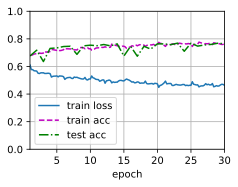

In [28]:
from torch import nn
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)
    
    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x[:, 0, :])))
    
net = MLPClassifier(input_size=768, hidden_size=128)
devices = try_all_gpus()
lr, num_epochs = 0.001, 30
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_loader, test_loader, loss, trainer, num_epochs, devices)
evaluate(net, test_loader)